# Cycle GAN 



## import libraries

In [25]:
!pip install tensorflow-addons

In [26]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random, seed
from tqdm import tqdm
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

## Load images

In [27]:
#Resizing all the images and storing in compressed Numpy array.
def load_celeb_images(path, size=(128, 128), max_images=None):
    data_list = []
    for filename in listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter for specific image file extensions
            pixels = load_img(path + filename, target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)

celeb_path = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'

# Load real data
dataA = load_celeb_images(celeb_path, max_images=400)
print('loaded dataA', dataA.shape)

loaded dataA (400, 128, 128, 3)


In [28]:
def load_style_images(path, size=(128, 128), max_images=None):
    data_list = []
    for filename in listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter for specific image file extensions
            pixels = load_img(path + filename, target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)

style_path = "../input/cartoonset10k/cartoonset10k/"

# Load style data
dataB = load_style_images(style_path, max_images=400)
print('loaded dataB', dataB.shape)

loaded dataB (400, 128, 128, 3)


In [29]:
filename = 'celebrity2style.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)
print('Saved dataset:', filename)

Saved dataset: celebrity2style.npz


## Plotting images of Celebrity and Style

Loaded data: (400, 128, 128, 3) (400, 128, 128, 3)


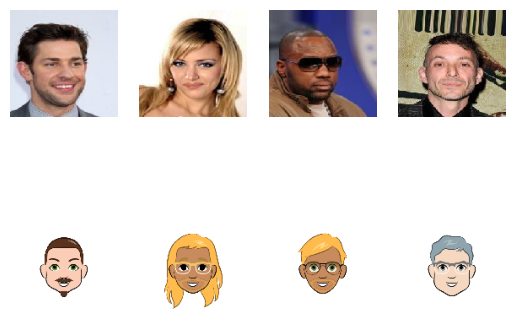

In [30]:
from numpy import load
data = load('celebrity2style.npz')
daraA, dataB = data['dataA'], data['dataB']
print('Loaded data:', dataA.shape, dataB.shape)

n_samples = 4
# plot original image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+i )
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot style image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+n_samples+i )
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()

Unlike other models, the CycleGAN discriminator uses InstanceNormalization instead of BatchNormalization. 

## Defining discriminator model

In [31]:
#define the discriminator model
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(input_image)
    x = LeakyReLU(alpha = 0.2)(x)
    #c128
    x = Conv2D(128,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c256
    x = Conv2D(256,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c512
    x = Conv2D(512,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    out_put = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, use_bias=False)(x)

    model = Model(input_image, out_put)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001, beta_1=0.5), loss_weights=[0.5])

    return model
    
image_shape = (128, 128, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_81 (Conv2D)          (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_82 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization_81 (  (None, 32, 32, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                           

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Defining generator model

In [32]:
def resnet_block(filters, layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    
    # skip connection
    x = Concatenate()([x, layer])
    return x
    

In [33]:
# define the generator model
def define_generator(image_shape, n_resnet=9):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(7,7), padding = 'same', kernel_initializer = init)(input_image)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c128 
    x = Conv2D(128,(3,3), strides = 2, padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c256 
    x = Conv2D(256,(3,3), strides = 2, padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    
    for i in range(n_resnet):
        x = resnet_block(256 , x)
        
    # Add Conv2DTranspose layers to upscale the image to the desired shape
    
    x = Conv2DTranspose(128, (3, 3), strides = 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(64, (3, 3),  strides = 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    out_image = Activation('relu')(x)

    model = Model(input_image, out_image)
    return model

image_shape = (128, 128, 3)
generator = define_generator(image_shape)
generator.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_86 (Conv2D)             (None, 128, 128, 64  9472        ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 instance_normalization_84 (Ins  (None, 128, 128, 64  128        ['conv2d_86[0][0]']              
 tanceNormalization)            )                                                           

**adversarial loss**
The generator models are trained via their related discriminator models. Specifically, they are updated to minimize the loss predicted by the discriminator for generated images marked as “real“, called adversarial loss. 

**cycle loss**
The generator models are also updated based on how effective they are at the regeneration of a source image when used with the other generator model, called cycle loss. 

**identity loss**
Finally, a generator model is expected to output an image without translation when provided an example from the target domain, called identity loss.

Altogether, each generator model is optimized via the combination of four outputs with four loss functions:

- Adversarial loss (L2 or mean squared error).
- Identity loss (L1 or mean absolute error).
- Forward cycle loss (L1 or mean absolute error).
- Backward cycle loss (L1 or mean absolute error).

MSE for label, MAE for graph.

4 outputs: discriminator output, identity generated image, forward cycle generated image, and backward cycle generated image.

## Defining Composite model

In [34]:
from keras.layers import Lambda, Reshape

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # Input for generated images
    input_gen = Input(shape=image_shape)
    
    # Resize generated images to the shape expected by the discriminator
    resized_gen = Lambda(lambda x: tf.image.resize(x, (128, 128), method=tf.image.ResizeMethod.BILINEAR))(input_gen)
    
    # Forward pass through the generator and discriminator
    gen_1_out = g_model_1(resized_gen)
    output_d = d_model(gen_1_out)
    
    # Input for identity mapping
    input_id = Input(shape=image_shape)
    
    # Forward pass for identity mapping
    output_id = g_model_1(input_id)
    
    # Forward and backward cycle loss
    output_f = g_model_2(gen_1_out)
    gen_2_out = g_model_2(input_id)
    output_b = g_model_1(gen_2_out)
    
    # Define the composite model
    # adversarial loss, identity loss, forward cycle loss, backward cycle loss
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 30, 30, 30], optimizer=opt)
    
    return model

## Load real samples

In [35]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['dataA'],data['dataB']
    X1 = (X1-127.5)/127.5 #for source image
    X2 = (X2-127.5)/127.5 # for target images
    return [X1,X2]

In [36]:
import random

def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


A sample of generated images is required to update each discriminator model in each training iteration.

In [37]:
##select a batch of random samples,return images and target
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate a batch of random noise as input for the generator
    X = g_model.predict(dataset)
    
    # Create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape,patch_shape, 1))
    
    return X, y


In [38]:
#save the generator model to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' %(step +1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' %(step +1)
    g_model_BtoA.save(filename2)
    print('>saved:%s and %s' %(filename1,filename2))
    

In [39]:
#update image pool for fake image
import random  # Import the random module

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # Use random.random() instead of random() here
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use the replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)  #
 

In [40]:
def show_image(image , title = None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [41]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(dataA))
        data = load('celebrity2style.npz')
        celeb, style = dataA[id], dataB[id]
        celeb_pred, style_pred = g_BA.predict(tf.expand_dims(style, axis=0))[0], g_AB.predict(tf.expand_dims(celeb, axis=0))[0]
        
        plt.figure(figsize=(10, 8))
        
        plt.subplot(1, 4, 1)
        show_image(celeb.astype('uint8'), title='Original celeb')
        
        plt.subplot(1, 4, 2)
        show_image(style_pred, title='Generated celeb')
        
        plt.subplot(1, 4, 3)
        show_image(style.astype('uint8'), title='Original style')
        
        plt.subplot(1, 4, 4)
        show_image(celeb_pred, title='Generated style')
        
        
        plt.show()

Now the training the models which takes all 6 models ( 2 discriminator , 2 generator and 2 composite models) as input with dataset for training.

## Train cyclegan model

In [42]:
# train cyclegan model
def train(dataset,d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,epochs=10, chunk=5):
    #define peroperties of the training run
    n_epochs, n_batch = epochs, 1
    #determine the output square shape of discriminator
    n_patch = d_model_A.output_shape[1]
    #unpack dataset
    trainA, trainB = dataset[0], dataset[1]
    #prepare image pool for fakes
    poolA, poolB = list(), list()
    #calcute the number of batches per training epoch
    batch_per_epoch = int(len(trainA)/n_batch)
    #calcute the number of training iteration
    n_steps = batch_per_epoch 
    
    #manually enumerate epochs
    loss_history = []
    for j in tqdm(range(epochs), desc='Epochs'):
        for i in tqdm(range(n_steps), desc='Batchs'):
            #select a batch of real sample
            X_realA, y_realA = generate_real_samples(trainA,n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB,n_batch, n_patch)
            
            #genarate a batch of fake sample
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
            
            #update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)
            
            #update generator B->A via adversarial and cycle loss
            gen_loss2, _, _, _,_ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])


            # update discriminator for A->[real/fake]
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            #update generator A->B via adversarial and cycle loss
            gen_loss1, _, _, _,_ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
            
            # update discriminator for B->[real/fake]
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
            
            #summerize performance
            print('>%d, dA[%.3f ,%.3f ] dB[%.3f ,%.3f] g[%.3f ,%.3f]' %(i+1,dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2))
        
        loss_history.append([dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2])
            
        if(j%chunk)==0:
            show_preds(g_model_AtoB,g_model_BtoA, n_images=1)
                #save the models
            g_model_AtoB.save('Generator_Celebrity_to_Style.h5')
            g_model_BtoA.save('Generator_Style_to_Celebrity.h5')
    
    return loss_history
                

The loss is reported each training iteration, including the Discriminator-A loss on real and fake examples (dA), Discriminator-B loss on real and fake examples (dB), and Generator-AtoB and Generator-BtoA loss, each of which is a weighted average of adversarial, identity, forward, and backward cycle loss (g).

Loaded (400, 128, 128, 3) (400, 128, 128, 3)


Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step



Batchs:   0%|          | 1/400 [01:18<8:42:23, 78.56s/it]

>1, dA[1.177 ,2.662 ] dB[0.828 ,2.575] g[72.836 ,69.947]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [01:19<3:36:55, 32.70s/it]

>2, dA[5.817 ,13.540 ] dB[8.389 ,2.737] g[80.992 ,117.122]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [01:19<1:59:21, 18.04s/it]

>3, dA[12.595 ,9.853 ] dB[29.296 ,8.432] g[76.315 ,104.002]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [01:20<1:13:35, 11.15s/it]

>4, dA[9.725 ,3.266 ] dB[12.866 ,2.072] g[71.595 ,99.201]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 5/400 [01:20<48:20,  7.34s/it]  

>5, dA[3.644 ,9.492 ] dB[14.378 ,3.745] g[75.195 ,112.509]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 6/400 [01:21<33:08,  5.05s/it]

>6, dA[2.788 ,1.481 ] dB[2.230 ,1.455] g[65.370 ,74.405]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [01:22<23:30,  3.59s/it]

>7, dA[0.787 ,0.811 ] dB[1.478 ,0.489] g[56.257 ,62.602]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [01:22<17:12,  2.63s/it]

>8, dA[0.569 ,0.382 ] dB[0.852 ,0.188] g[49.750 ,55.170]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 9/400 [01:23<13:00,  2.00s/it]

>9, dA[0.426 ,0.174 ] dB[0.300 ,0.268] g[52.399 ,60.983]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 10/400 [01:23<10:09,  1.56s/it]

>10, dA[0.434 ,0.290 ] dB[0.132 ,0.387] g[53.793 ,60.002]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [01:24<08:11,  1.26s/it]

>11, dA[0.414 ,0.234 ] dB[0.179 ,0.226] g[51.078 ,56.697]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [01:25<06:50,  1.06s/it]

>12, dA[0.293 ,0.115 ] dB[0.206 ,0.287] g[54.195 ,65.650]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 13/400 [01:25<05:55,  1.09it/s]

>13, dA[0.292 ,0.117 ] dB[0.156 ,0.177] g[49.610 ,54.573]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [01:26<05:16,  1.22it/s]

>14, dA[0.120 ,0.126 ] dB[0.110 ,0.127] g[46.028 ,48.346]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [01:26<04:50,  1.33it/s]

>15, dA[0.205 ,0.121 ] dB[0.095 ,0.131] g[47.589 ,53.490]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 16/400 [01:27<04:32,  1.41it/s]

>16, dA[0.302 ,0.258 ] dB[0.216 ,0.140] g[49.034 ,56.640]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 17/400 [01:28<04:18,  1.48it/s]

>17, dA[0.216 ,0.132 ] dB[0.085 ,0.219] g[52.044 ,64.782]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 18/400 [01:28<04:08,  1.54it/s]

>18, dA[0.159 ,0.242 ] dB[0.389 ,0.322] g[46.376 ,54.696]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [01:29<04:00,  1.58it/s]

>19, dA[0.294 ,0.174 ] dB[0.147 ,0.128] g[41.970 ,50.223]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [01:29<03:55,  1.62it/s]

>20, dA[0.116 ,0.142 ] dB[0.255 ,0.130] g[45.261 ,49.459]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [01:30<03:52,  1.63it/s]

>21, dA[0.226 ,0.142 ] dB[0.225 ,0.069] g[39.939 ,47.957]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [01:31<03:49,  1.65it/s]

>22, dA[0.178 ,0.262 ] dB[0.202 ,0.092] g[47.619 ,51.747]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 23/400 [01:31<03:46,  1.66it/s]

>23, dA[0.144 ,0.091 ] dB[0.133 ,0.139] g[47.504 ,56.321]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [01:32<03:44,  1.67it/s]

>24, dA[0.129 ,0.116 ] dB[0.287 ,0.285] g[43.597 ,44.069]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [01:32<03:44,  1.67it/s]

>25, dA[0.227 ,0.092 ] dB[0.179 ,0.050] g[41.766 ,43.043]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [01:33<03:43,  1.67it/s]

>26, dA[0.053 ,0.193 ] dB[0.073 ,0.085] g[43.223 ,45.318]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [01:33<03:42,  1.67it/s]

>27, dA[0.264 ,0.240 ] dB[0.104 ,0.179] g[43.133 ,45.840]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [01:34<03:41,  1.68it/s]

>28, dA[0.210 ,0.226 ] dB[0.077 ,0.113] g[39.183 ,40.670]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [01:35<03:41,  1.67it/s]

>29, dA[0.281 ,0.177 ] dB[0.091 ,0.211] g[45.888 ,53.377]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [01:35<03:40,  1.68it/s]

>30, dA[0.175 ,0.135 ] dB[0.078 ,0.056] g[45.228 ,52.873]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 31/400 [01:36<03:39,  1.68it/s]

>31, dA[0.229 ,0.199 ] dB[0.121 ,0.204] g[39.119 ,39.403]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [01:36<03:38,  1.69it/s]

>32, dA[0.198 ,0.078 ] dB[0.046 ,0.091] g[42.868 ,47.369]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [01:37<03:38,  1.68it/s]

>33, dA[0.248 ,0.155 ] dB[0.407 ,0.205] g[40.379 ,38.752]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 34/400 [01:38<03:38,  1.68it/s]

>34, dA[0.205 ,0.092 ] dB[0.431 ,0.202] g[39.872 ,42.213]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [01:38<03:36,  1.68it/s]

>35, dA[0.177 ,0.102 ] dB[0.870 ,0.402] g[39.162 ,38.251]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 36/400 [01:39<03:36,  1.68it/s]

>36, dA[0.135 ,0.181 ] dB[0.458 ,0.234] g[43.402 ,48.450]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 37/400 [01:39<03:42,  1.63it/s]

>37, dA[0.307 ,0.283 ] dB[0.903 ,0.598] g[45.666 ,49.547]
1/1 [==============================] - 0s 27ms/step



Batchs:  10%|▉         | 38/400 [01:40<03:41,  1.63it/s]

>38, dA[0.250 ,0.180 ] dB[0.348 ,0.353] g[36.690 ,39.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 39/400 [01:41<03:40,  1.64it/s]

>39, dA[0.370 ,0.154 ] dB[0.218 ,0.242] g[46.279 ,59.406]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [01:41<03:38,  1.65it/s]

>40, dA[0.281 ,0.606 ] dB[0.152 ,0.123] g[46.367 ,55.596]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 41/400 [01:42<03:36,  1.66it/s]

>41, dA[0.234 ,0.411 ] dB[0.346 ,0.152] g[42.713 ,52.902]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [01:42<03:35,  1.66it/s]

>42, dA[0.177 ,0.522 ] dB[0.196 ,0.134] g[44.052 ,46.221]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 43/400 [01:43<03:33,  1.67it/s]

>43, dA[0.677 ,0.210 ] dB[0.152 ,0.208] g[39.035 ,44.523]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█         | 44/400 [01:44<03:33,  1.67it/s]

>44, dA[0.126 ,0.292 ] dB[0.084 ,0.123] g[38.668 ,42.634]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 45/400 [01:44<03:34,  1.66it/s]

>45, dA[0.235 ,0.225 ] dB[0.043 ,0.136] g[36.113 ,35.540]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 46/400 [01:45<03:34,  1.65it/s]

>46, dA[0.263 ,0.668 ] dB[0.121 ,0.030] g[33.495 ,33.655]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 47/400 [01:46<03:34,  1.65it/s]

>47, dA[0.294 ,0.402 ] dB[0.060 ,0.072] g[39.593 ,41.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [01:46<03:32,  1.66it/s]

>48, dA[0.622 ,1.073 ] dB[0.128 ,0.048] g[49.788 ,62.647]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 49/400 [01:47<03:34,  1.64it/s]

>49, dA[0.202 ,0.678 ] dB[0.083 ,0.159] g[38.973 ,41.264]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▎        | 50/400 [01:47<03:33,  1.64it/s]

>50, dA[0.465 ,0.668 ] dB[0.108 ,0.069] g[40.780 ,47.351]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 51/400 [01:48<03:33,  1.64it/s]

>51, dA[0.520 ,0.320 ] dB[0.069 ,0.039] g[39.587 ,40.732]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 52/400 [01:49<03:31,  1.65it/s]

>52, dA[0.143 ,0.212 ] dB[0.198 ,0.110] g[42.476 ,48.965]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 53/400 [01:49<03:30,  1.65it/s]

>53, dA[0.260 ,0.296 ] dB[0.130 ,0.045] g[36.934 ,38.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 54/400 [01:50<03:28,  1.66it/s]

>54, dA[0.272 ,0.217 ] dB[0.533 ,0.342] g[40.974 ,43.366]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 55/400 [01:50<03:26,  1.67it/s]

>55, dA[0.137 ,0.116 ] dB[0.405 ,0.176] g[45.684 ,50.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [01:51<03:25,  1.68it/s]

>56, dA[0.140 ,0.804 ] dB[0.931 ,0.439] g[39.100 ,36.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [01:52<03:24,  1.68it/s]

>57, dA[0.954 ,0.357 ] dB[0.874 ,0.245] g[41.404 ,50.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 58/400 [01:52<03:23,  1.68it/s]

>58, dA[0.273 ,0.685 ] dB[1.100 ,0.481] g[42.665 ,45.291]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [01:53<03:22,  1.68it/s]

>59, dA[0.334 ,0.268 ] dB[0.254 ,0.419] g[30.106 ,28.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [01:53<03:21,  1.69it/s]

>60, dA[0.738 ,0.244 ] dB[0.616 ,0.240] g[36.741 ,33.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [01:54<03:21,  1.69it/s]

>61, dA[0.119 ,0.671 ] dB[0.158 ,0.449] g[34.335 ,33.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [01:55<03:20,  1.68it/s]

>62, dA[0.734 ,0.298 ] dB[0.146 ,0.410] g[44.957 ,48.385]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 63/400 [01:55<03:20,  1.68it/s]

>63, dA[0.088 ,0.246 ] dB[0.201 ,0.420] g[38.411 ,40.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [01:56<03:19,  1.69it/s]

>64, dA[0.110 ,0.196 ] dB[0.205 ,0.259] g[36.811 ,38.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [01:56<03:19,  1.68it/s]

>65, dA[0.169 ,0.175 ] dB[0.171 ,0.211] g[49.441 ,57.073]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 66/400 [01:57<03:20,  1.67it/s]

>66, dA[0.111 ,0.056 ] dB[0.216 ,0.156] g[37.428 ,31.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [01:57<03:19,  1.67it/s]

>67, dA[0.074 ,0.081 ] dB[0.144 ,0.111] g[40.691 ,46.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [01:58<03:17,  1.68it/s]

>68, dA[0.083 ,0.258 ] dB[0.115 ,0.079] g[44.088 ,54.396]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 69/400 [01:59<03:16,  1.68it/s]

>69, dA[0.356 ,0.282 ] dB[0.036 ,0.103] g[33.045 ,34.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [01:59<03:15,  1.68it/s]

>70, dA[0.135 ,0.186 ] dB[0.089 ,0.040] g[33.869 ,32.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [02:00<03:14,  1.69it/s]

>71, dA[0.192 ,0.299 ] dB[0.095 ,0.099] g[35.591 ,33.164]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [02:00<03:14,  1.69it/s]

>72, dA[0.516 ,0.223 ] dB[0.091 ,0.074] g[44.695 ,53.468]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 73/400 [02:01<03:13,  1.69it/s]

>73, dA[0.148 ,0.930 ] dB[0.063 ,0.071] g[36.043 ,34.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [02:02<03:13,  1.69it/s]

>74, dA[1.083 ,0.280 ] dB[0.049 ,0.084] g[44.435 ,54.570]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [02:02<03:12,  1.69it/s]

>75, dA[0.520 ,0.780 ] dB[0.023 ,0.061] g[36.826 ,34.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [02:03<03:11,  1.69it/s]

>76, dA[0.535 ,0.311 ] dB[0.089 ,0.085] g[34.382 ,35.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [02:03<03:11,  1.68it/s]

>77, dA[0.536 ,0.530 ] dB[0.044 ,0.074] g[33.397 ,33.819]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 78/400 [02:04<03:12,  1.67it/s]

>78, dA[0.308 ,0.315 ] dB[0.043 ,0.067] g[47.377 ,55.342]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [02:05<03:12,  1.67it/s]

>79, dA[0.206 ,0.273 ] dB[0.052 ,0.089] g[38.879 ,43.911]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 80/400 [02:05<03:11,  1.67it/s]

>80, dA[0.135 ,0.354 ] dB[0.124 ,0.051] g[37.179 ,32.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [02:06<03:11,  1.67it/s]

>81, dA[0.415 ,0.262 ] dB[0.093 ,0.130] g[38.271 ,46.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [02:06<03:10,  1.67it/s]

>82, dA[0.280 ,0.346 ] dB[0.031 ,0.061] g[35.831 ,39.308]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [02:07<03:08,  1.68it/s]

>83, dA[0.137 ,0.598 ] dB[0.049 ,0.037] g[44.328 ,46.501]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 84/400 [02:08<03:07,  1.68it/s]

>84, dA[0.529 ,0.365 ] dB[0.066 ,0.082] g[45.469 ,58.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [02:08<03:07,  1.68it/s]

>85, dA[0.400 ,0.551 ] dB[0.229 ,0.120] g[38.119 ,35.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [02:09<03:06,  1.68it/s]

>86, dA[1.100 ,0.723 ] dB[0.123 ,0.458] g[46.253 ,57.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [02:09<03:05,  1.68it/s]

>87, dA[0.382 ,0.823 ] dB[0.164 ,0.404] g[47.796 ,54.038]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [02:10<03:06,  1.68it/s]

>88, dA[0.283 ,0.408 ] dB[0.322 ,0.724] g[42.025 ,54.790]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [02:11<03:07,  1.66it/s]

>89, dA[0.297 ,0.705 ] dB[0.367 ,0.390] g[41.336 ,44.095]
1/1 [==============================] - 0s 29ms/step



Batchs:  22%|██▎       | 90/400 [02:11<03:08,  1.65it/s]

>90, dA[0.502 ,0.147 ] dB[0.363 ,0.825] g[29.671 ,29.718]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [02:12<03:06,  1.66it/s]

>91, dA[0.609 ,0.907 ] dB[0.120 ,0.184] g[33.430 ,28.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [02:12<03:04,  1.67it/s]

>92, dA[0.385 ,0.363 ] dB[0.073 ,0.126] g[39.566 ,47.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [02:13<03:03,  1.67it/s]

>93, dA[0.147 ,0.354 ] dB[0.153 ,0.058] g[44.821 ,55.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [02:14<03:02,  1.68it/s]

>94, dA[0.320 ,0.169 ] dB[0.150 ,0.132] g[41.280 ,45.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [02:14<03:00,  1.69it/s]

>95, dA[0.278 ,0.708 ] dB[0.234 ,0.178] g[38.002 ,38.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [02:15<02:59,  1.69it/s]

>96, dA[0.147 ,0.433 ] dB[0.427 ,0.406] g[42.565 ,44.788]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 97/400 [02:15<03:00,  1.68it/s]

>97, dA[0.410 ,0.716 ] dB[0.223 ,0.244] g[39.140 ,42.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 98/400 [02:16<02:59,  1.69it/s]

>98, dA[0.269 ,0.206 ] dB[0.106 ,0.079] g[43.077 ,50.518]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [02:17<02:58,  1.69it/s]

>99, dA[0.201 ,0.546 ] dB[0.137 ,0.161] g[32.137 ,31.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [02:17<02:57,  1.69it/s]

>100, dA[0.534 ,0.329 ] dB[0.603 ,0.297] g[34.688 ,31.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [02:18<02:57,  1.69it/s]

>101, dA[0.240 ,0.199 ] dB[0.463 ,0.203] g[38.767 ,40.518]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 102/400 [02:18<02:56,  1.69it/s]

>102, dA[0.255 ,0.327 ] dB[0.672 ,0.378] g[35.680 ,32.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [02:19<02:55,  1.69it/s]

>103, dA[0.168 ,0.170 ] dB[0.904 ,0.221] g[48.141 ,56.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [02:19<02:54,  1.69it/s]

>104, dA[0.181 ,0.157 ] dB[0.636 ,0.394] g[45.481 ,57.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [02:20<02:54,  1.69it/s]

>105, dA[0.084 ,0.063 ] dB[0.354 ,0.165] g[50.705 ,66.057]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [02:21<02:54,  1.69it/s]

>106, dA[0.071 ,0.108 ] dB[0.199 ,0.220] g[38.466 ,43.507]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 107/400 [02:21<02:54,  1.68it/s]

>107, dA[0.095 ,0.189 ] dB[0.149 ,0.115] g[33.462 ,28.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [02:22<02:53,  1.68it/s]

>108, dA[0.105 ,0.101 ] dB[0.193 ,0.123] g[45.161 ,53.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [02:22<02:52,  1.68it/s]

>109, dA[0.121 ,0.229 ] dB[0.029 ,0.037] g[37.980 ,44.992]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [02:23<02:52,  1.68it/s]

>110, dA[0.082 ,0.174 ] dB[0.036 ,0.022] g[48.090 ,58.289]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 111/400 [02:24<02:52,  1.67it/s]

>111, dA[0.072 ,0.228 ] dB[0.025 ,0.038] g[31.813 ,27.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [02:24<02:51,  1.68it/s]

>112, dA[0.123 ,0.131 ] dB[0.111 ,0.059] g[38.865 ,38.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [02:25<02:51,  1.67it/s]

>113, dA[0.217 ,0.119 ] dB[0.069 ,0.038] g[35.300 ,33.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [02:25<02:50,  1.68it/s]

>114, dA[0.037 ,0.301 ] dB[0.077 ,0.156] g[33.103 ,30.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [02:26<02:49,  1.68it/s]

>115, dA[0.407 ,0.338 ] dB[0.051 ,0.068] g[36.900 ,43.918]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 116/400 [02:27<02:48,  1.68it/s]

>116, dA[0.442 ,0.195 ] dB[0.049 ,0.131] g[35.582 ,36.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [02:27<02:49,  1.67it/s]

>117, dA[0.212 ,0.192 ] dB[0.063 ,0.048] g[31.494 ,26.714]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 118/400 [02:28<02:49,  1.67it/s]

>118, dA[0.303 ,0.104 ] dB[0.091 ,0.053] g[32.086 ,30.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [02:28<02:47,  1.68it/s]

>119, dA[0.122 ,0.172 ] dB[0.040 ,0.049] g[40.834 ,44.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [02:29<02:46,  1.68it/s]

>120, dA[0.132 ,0.074 ] dB[0.053 ,0.016] g[45.913 ,53.782]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [02:30<02:45,  1.68it/s]

>121, dA[0.185 ,0.126 ] dB[0.052 ,0.027] g[41.804 ,42.782]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [02:30<02:45,  1.68it/s]

>122, dA[0.243 ,0.265 ] dB[0.090 ,0.102] g[36.519 ,36.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [02:31<02:44,  1.69it/s]

>123, dA[0.120 ,0.200 ] dB[0.126 ,0.212] g[39.679 ,46.281]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 124/400 [02:31<02:43,  1.69it/s]

>124, dA[0.082 ,0.450 ] dB[0.124 ,0.092] g[38.160 ,37.740]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [02:32<02:43,  1.68it/s]

>125, dA[0.277 ,0.532 ] dB[0.171 ,0.140] g[38.525 ,43.187]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 126/400 [02:33<02:42,  1.68it/s]

>126, dA[0.259 ,0.462 ] dB[0.315 ,0.267] g[40.101 ,40.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [02:33<02:41,  1.69it/s]

>127, dA[0.430 ,0.426 ] dB[0.490 ,0.267] g[32.105 ,29.807]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 128/400 [02:34<02:40,  1.69it/s]

>128, dA[0.317 ,0.477 ] dB[0.504 ,0.373] g[42.874 ,45.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [02:34<02:41,  1.68it/s]

>129, dA[0.288 ,0.405 ] dB[0.342 ,0.333] g[36.471 ,38.700]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▎      | 130/400 [02:35<02:40,  1.68it/s]

>130, dA[0.218 ,0.198 ] dB[0.063 ,0.040] g[34.691 ,36.487]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [02:36<02:39,  1.69it/s]

>131, dA[0.094 ,0.366 ] dB[0.078 ,0.037] g[46.226 ,55.857]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [02:36<02:38,  1.69it/s]

>132, dA[0.240 ,0.060 ] dB[0.054 ,0.045] g[42.813 ,49.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [02:37<02:38,  1.68it/s]

>133, dA[0.354 ,0.494 ] dB[0.123 ,0.062] g[38.810 ,41.765]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▎      | 134/400 [02:37<02:38,  1.68it/s]

>134, dA[0.248 ,0.106 ] dB[0.087 ,0.060] g[32.246 ,37.292]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 135/400 [02:38<02:37,  1.68it/s]

>135, dA[0.400 ,0.090 ] dB[0.128 ,0.094] g[35.525 ,35.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [02:39<02:36,  1.69it/s]

>136, dA[0.133 ,0.438 ] dB[0.139 ,0.127] g[34.218 ,35.602]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 137/400 [02:39<02:36,  1.68it/s]

>137, dA[0.583 ,0.068 ] dB[0.139 ,0.121] g[37.303 ,40.348]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 138/400 [02:40<02:36,  1.68it/s]

>138, dA[0.077 ,0.072 ] dB[0.082 ,0.050] g[36.959 ,41.062]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 139/400 [02:40<02:36,  1.67it/s]

>139, dA[0.122 ,0.270 ] dB[0.065 ,0.110] g[40.294 ,50.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [02:41<02:35,  1.68it/s]

>140, dA[0.586 ,0.190 ] dB[0.097 ,0.083] g[38.582 ,44.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [02:42<02:34,  1.68it/s]

>141, dA[0.346 ,0.094 ] dB[0.066 ,0.075] g[34.413 ,32.595]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 142/400 [02:42<02:36,  1.65it/s]

>142, dA[0.264 ,0.120 ] dB[0.044 ,0.028] g[44.658 ,52.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [02:43<02:35,  1.65it/s]

>143, dA[0.152 ,0.064 ] dB[0.039 ,0.043] g[28.513 ,26.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [02:43<02:33,  1.66it/s]

>144, dA[0.099 ,0.103 ] dB[0.020 ,0.023] g[39.117 ,47.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [02:44<02:33,  1.67it/s]

>145, dA[0.091 ,0.099 ] dB[0.022 ,0.039] g[37.479 ,40.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [02:45<02:32,  1.67it/s]

>146, dA[0.096 ,0.282 ] dB[0.065 ,0.028] g[38.048 ,39.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [02:45<02:31,  1.67it/s]

>147, dA[0.189 ,0.239 ] dB[0.025 ,0.036] g[34.727 ,39.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [02:46<02:30,  1.68it/s]

>148, dA[0.119 ,0.323 ] dB[0.027 ,0.063] g[34.443 ,36.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [02:46<02:29,  1.67it/s]

>149, dA[0.237 ,0.123 ] dB[0.021 ,0.088] g[35.134 ,34.221]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 150/400 [02:47<02:30,  1.66it/s]

>150, dA[0.107 ,0.093 ] dB[0.044 ,0.092] g[44.533 ,53.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [02:48<02:29,  1.67it/s]

>151, dA[0.210 ,0.098 ] dB[0.050 ,0.072] g[38.231 ,43.101]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [02:48<02:27,  1.68it/s]

>152, dA[0.276 ,0.167 ] dB[0.094 ,0.168] g[36.870 ,43.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [02:49<02:27,  1.68it/s]

>153, dA[0.446 ,0.212 ] dB[0.186 ,0.100] g[37.520 ,41.511]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 154/400 [02:49<02:26,  1.68it/s]

>154, dA[0.170 ,0.345 ] dB[0.165 ,0.095] g[39.125 ,42.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [02:50<02:25,  1.69it/s]

>155, dA[0.226 ,0.189 ] dB[0.085 ,0.089] g[37.083 ,35.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [02:50<02:24,  1.69it/s]

>156, dA[0.223 ,0.123 ] dB[0.026 ,0.061] g[34.032 ,36.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [02:51<02:24,  1.68it/s]

>157, dA[0.349 ,0.070 ] dB[0.063 ,0.029] g[39.555 ,44.407]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 158/400 [02:52<02:23,  1.68it/s]

>158, dA[0.480 ,0.348 ] dB[0.252 ,0.391] g[45.516 ,53.935]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [02:52<02:23,  1.68it/s]

>159, dA[0.165 ,0.164 ] dB[0.194 ,0.252] g[40.950 ,47.332]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [02:53<02:22,  1.68it/s]

>160, dA[0.069 ,0.071 ] dB[0.526 ,0.796] g[39.026 ,42.424]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [02:53<02:22,  1.68it/s]

>161, dA[0.132 ,0.324 ] dB[0.133 ,0.250] g[38.458 ,40.538]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 162/400 [02:54<02:21,  1.68it/s]

>162, dA[0.097 ,0.121 ] dB[0.207 ,0.166] g[37.630 ,40.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [02:55<02:21,  1.67it/s]

>163, dA[0.154 ,0.127 ] dB[0.554 ,0.313] g[38.223 ,40.847]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 164/400 [02:55<02:21,  1.67it/s]

>164, dA[0.154 ,0.504 ] dB[0.149 ,0.186] g[33.337 ,35.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [02:56<02:20,  1.67it/s]

>165, dA[0.936 ,0.426 ] dB[0.107 ,0.042] g[36.779 ,41.071]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 166/400 [02:56<02:20,  1.67it/s]

>166, dA[0.147 ,0.064 ] dB[0.369 ,0.505] g[43.209 ,50.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [02:57<02:19,  1.68it/s]

>167, dA[0.131 ,0.128 ] dB[0.202 ,0.121] g[33.284 ,31.817]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [02:58<02:18,  1.68it/s]

>168, dA[0.075 ,0.130 ] dB[0.235 ,0.119] g[34.970 ,34.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [02:58<02:18,  1.67it/s]

>169, dA[0.218 ,0.309 ] dB[0.126 ,0.290] g[32.482 ,32.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [02:59<02:17,  1.67it/s]

>170, dA[0.270 ,0.089 ] dB[0.157 ,0.063] g[40.949 ,45.558]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 171/400 [02:59<02:16,  1.67it/s]

>171, dA[0.140 ,0.103 ] dB[0.063 ,0.044] g[41.659 ,47.353]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 172/400 [03:00<02:16,  1.68it/s]

>172, dA[0.085 ,0.086 ] dB[0.111 ,0.045] g[39.708 ,47.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [03:01<02:15,  1.68it/s]

>173, dA[0.063 ,0.244 ] dB[0.111 ,0.058] g[34.526 ,35.777]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [03:01<02:14,  1.67it/s]

>174, dA[0.257 ,0.112 ] dB[0.023 ,0.054] g[41.356 ,52.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 175/400 [03:02<02:14,  1.67it/s]

>175, dA[0.182 ,0.078 ] dB[0.017 ,0.026] g[45.754 ,55.330]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 176/400 [03:02<02:13,  1.68it/s]

>176, dA[0.150 ,0.131 ] dB[0.047 ,0.110] g[37.724 ,44.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 177/400 [03:03<02:13,  1.67it/s]

>177, dA[0.289 ,0.098 ] dB[0.043 ,0.063] g[36.910 ,39.030]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 178/400 [03:04<02:12,  1.68it/s]

>178, dA[0.145 ,0.155 ] dB[0.070 ,0.073] g[29.301 ,25.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [03:04<02:11,  1.68it/s]

>179, dA[0.146 ,0.053 ] dB[0.048 ,0.037] g[35.475 ,32.634]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 180/400 [03:05<02:10,  1.68it/s]

>180, dA[0.052 ,0.046 ] dB[0.050 ,0.100] g[46.411 ,56.726]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [03:05<02:11,  1.67it/s]

>181, dA[0.147 ,0.114 ] dB[0.058 ,0.050] g[35.305 ,34.628]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 182/400 [03:06<02:11,  1.66it/s]

>182, dA[0.111 ,0.183 ] dB[0.011 ,0.030] g[36.485 ,38.359]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 183/400 [03:07<02:12,  1.64it/s]

>183, dA[0.064 ,0.414 ] dB[0.010 ,0.023] g[29.881 ,27.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [03:07<02:11,  1.65it/s]

>184, dA[0.385 ,0.280 ] dB[0.005 ,0.016] g[41.854 ,50.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 185/400 [03:08<02:10,  1.64it/s]

>185, dA[0.402 ,0.751 ] dB[0.013 ,0.043] g[31.702 ,32.102]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 186/400 [03:08<02:10,  1.64it/s]

>186, dA[1.336 ,0.395 ] dB[0.025 ,0.034] g[35.983 ,40.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [03:09<02:09,  1.65it/s]

>187, dA[0.627 ,0.671 ] dB[0.043 ,0.064] g[32.561 ,29.642]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 188/400 [03:10<02:08,  1.65it/s]

>188, dA[0.237 ,0.248 ] dB[0.043 ,0.033] g[30.729 ,28.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [03:10<02:08,  1.64it/s]

>189, dA[0.134 ,0.360 ] dB[0.010 ,0.048] g[43.443 ,50.267]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 190/400 [03:11<02:08,  1.64it/s]

>190, dA[0.209 ,0.373 ] dB[0.014 ,0.034] g[40.383 ,50.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [03:12<02:07,  1.64it/s]

>191, dA[0.368 ,0.212 ] dB[0.032 ,0.011] g[34.109 ,34.373]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 192/400 [03:12<02:06,  1.64it/s]

>192, dA[0.356 ,0.432 ] dB[0.025 ,0.040] g[31.277 ,29.276]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 193/400 [03:13<02:06,  1.63it/s]

>193, dA[0.106 ,0.156 ] dB[0.014 ,0.038] g[40.203 ,43.647]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 194/400 [03:13<02:08,  1.60it/s]

>194, dA[0.137 ,0.102 ] dB[0.041 ,0.019] g[36.263 ,37.592]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 195/400 [03:14<02:07,  1.61it/s]

>195, dA[0.299 ,0.217 ] dB[0.031 ,0.017] g[51.038 ,65.659]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 196/400 [03:15<02:05,  1.62it/s]

>196, dA[0.140 ,0.201 ] dB[0.019 ,0.014] g[36.274 ,38.586]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [03:15<02:04,  1.63it/s]

>197, dA[0.099 ,0.073 ] dB[0.011 ,0.039] g[41.734 ,48.886]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 198/400 [03:16<02:03,  1.63it/s]

>198, dA[0.116 ,0.083 ] dB[0.033 ,0.051] g[36.338 ,41.810]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [03:16<02:02,  1.64it/s]

>199, dA[0.054 ,0.085 ] dB[0.176 ,0.184] g[45.973 ,59.847]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [03:17<02:01,  1.64it/s]

>200, dA[0.215 ,0.280 ] dB[0.048 ,0.133] g[35.889 ,40.189]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 201/400 [03:18<02:01,  1.64it/s]

>201, dA[0.064 ,0.052 ] dB[0.063 ,0.026] g[36.851 ,39.903]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 202/400 [03:18<02:00,  1.64it/s]

>202, dA[0.041 ,0.065 ] dB[0.011 ,0.027] g[33.441 ,33.033]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 203/400 [03:19<01:59,  1.64it/s]

>203, dA[0.050 ,0.187 ] dB[0.023 ,0.036] g[36.715 ,41.736]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 204/400 [03:19<01:59,  1.65it/s]

>204, dA[0.171 ,0.102 ] dB[0.046 ,0.058] g[32.762 ,33.433]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 205/400 [03:20<01:58,  1.64it/s]

>205, dA[0.063 ,0.093 ] dB[0.015 ,0.030] g[39.166 ,41.429]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 206/400 [03:21<01:58,  1.64it/s]

>206, dA[0.034 ,0.059 ] dB[0.016 ,0.012] g[46.946 ,59.562]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 207/400 [03:21<01:57,  1.65it/s]

>207, dA[0.093 ,0.123 ] dB[0.013 ,0.023] g[36.458 ,40.598]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [03:22<01:56,  1.65it/s]

>208, dA[0.044 ,0.058 ] dB[0.022 ,0.034] g[37.785 ,42.481]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 209/400 [03:23<01:56,  1.64it/s]

>209, dA[0.046 ,0.081 ] dB[0.051 ,0.028] g[33.292 ,35.965]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▎    | 210/400 [03:23<01:55,  1.64it/s]

>210, dA[0.062 ,0.079 ] dB[0.043 ,0.016] g[38.806 ,45.483]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 211/400 [03:24<01:54,  1.64it/s]

>211, dA[0.067 ,0.064 ] dB[0.014 ,0.032] g[33.937 ,33.696]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 212/400 [03:24<01:53,  1.65it/s]

>212, dA[0.052 ,0.111 ] dB[0.026 ,0.028] g[42.670 ,46.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 213/400 [03:25<01:53,  1.64it/s]

>213, dA[0.035 ,0.255 ] dB[0.029 ,0.019] g[31.590 ,28.106]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 214/400 [03:26<01:53,  1.64it/s]

>214, dA[0.217 ,0.078 ] dB[0.015 ,0.025] g[33.623 ,34.571]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 215/400 [03:26<01:52,  1.64it/s]

>215, dA[0.210 ,0.136 ] dB[0.023 ,0.014] g[38.249 ,46.395]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 216/400 [03:27<01:51,  1.65it/s]

>216, dA[0.093 ,0.090 ] dB[0.040 ,0.028] g[30.553 ,28.842]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 217/400 [03:27<01:51,  1.64it/s]

>217, dA[0.056 ,0.098 ] dB[0.075 ,0.051] g[38.124 ,44.705]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 218/400 [03:28<01:50,  1.64it/s]

>218, dA[0.121 ,0.109 ] dB[0.183 ,0.158] g[31.176 ,34.860]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 219/400 [03:29<01:49,  1.65it/s]

>219, dA[0.136 ,0.117 ] dB[0.211 ,0.176] g[32.325 ,32.185]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 220/400 [03:29<01:49,  1.64it/s]

>220, dA[0.076 ,0.104 ] dB[0.291 ,0.273] g[32.991 ,33.049]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [03:30<01:49,  1.64it/s]

>221, dA[0.128 ,0.082 ] dB[0.346 ,0.421] g[37.151 ,43.751]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 222/400 [03:30<01:48,  1.64it/s]

>222, dA[0.112 ,0.107 ] dB[0.444 ,1.099] g[32.898 ,32.179]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 223/400 [03:31<01:47,  1.64it/s]

>223, dA[0.100 ,0.100 ] dB[0.315 ,0.116] g[32.879 ,31.567]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 224/400 [03:32<01:47,  1.64it/s]

>224, dA[0.071 ,0.077 ] dB[0.123 ,0.142] g[36.733 ,36.816]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 225/400 [03:32<01:46,  1.64it/s]

>225, dA[0.075 ,0.036 ] dB[0.076 ,0.066] g[38.584 ,40.984]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▋    | 226/400 [03:33<01:46,  1.64it/s]

>226, dA[0.097 ,0.066 ] dB[0.138 ,0.081] g[47.998 ,61.500]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 227/400 [03:33<01:46,  1.63it/s]

>227, dA[0.128 ,0.193 ] dB[0.069 ,0.053] g[32.654 ,30.347]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 228/400 [03:34<01:45,  1.63it/s]

>228, dA[0.171 ,0.107 ] dB[0.053 ,0.052] g[38.324 ,41.705]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 229/400 [03:35<01:45,  1.62it/s]

>229, dA[0.224 ,0.224 ] dB[0.092 ,0.053] g[32.378 ,34.287]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▊    | 230/400 [03:35<01:44,  1.63it/s]

>230, dA[0.061 ,0.139 ] dB[0.144 ,0.043] g[33.799 ,39.693]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 231/400 [03:36<01:43,  1.63it/s]

>231, dA[0.187 ,0.127 ] dB[0.059 ,0.061] g[28.973 ,28.484]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 232/400 [03:37<01:43,  1.63it/s]

>232, dA[0.117 ,0.081 ] dB[0.074 ,0.102] g[36.186 ,42.450]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [03:37<01:42,  1.63it/s]

>233, dA[0.208 ,0.085 ] dB[0.040 ,0.061] g[36.512 ,45.420]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 234/400 [03:38<01:41,  1.63it/s]

>234, dA[0.067 ,0.259 ] dB[0.207 ,0.371] g[29.212 ,27.374]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 235/400 [03:38<01:40,  1.65it/s]

>235, dA[0.195 ,0.109 ] dB[0.057 ,0.309] g[30.784 ,29.545]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 236/400 [03:39<01:38,  1.66it/s]

>236, dA[0.092 ,0.187 ] dB[0.219 ,0.485] g[34.862 ,35.298]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 237/400 [03:40<01:38,  1.66it/s]

>237, dA[0.158 ,0.182 ] dB[0.151 ,0.241] g[41.399 ,49.850]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 238/400 [03:40<01:37,  1.66it/s]

>238, dA[0.131 ,0.211 ] dB[0.496 ,0.260] g[39.106 ,44.611]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [03:41<01:37,  1.66it/s]

>239, dA[0.239 ,0.249 ] dB[0.038 ,0.098] g[31.904 ,27.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [03:41<01:36,  1.66it/s]

>240, dA[0.213 ,0.132 ] dB[0.088 ,0.047] g[29.135 ,26.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 241/400 [03:42<01:35,  1.66it/s]

>241, dA[0.034 ,0.108 ] dB[0.028 ,0.036] g[32.704 ,31.622]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 242/400 [03:43<01:35,  1.66it/s]

>242, dA[0.086 ,0.063 ] dB[0.021 ,0.059] g[32.269 ,32.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [03:43<01:34,  1.67it/s]

>243, dA[0.042 ,0.035 ] dB[0.026 ,0.032] g[38.917 ,44.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [03:44<01:33,  1.68it/s]

>244, dA[0.036 ,0.051 ] dB[0.064 ,0.061] g[36.500 ,42.684]
1/1 [==============================] - 0s 31ms/step



Batchs:  61%|██████▏   | 245/400 [03:44<01:34,  1.64it/s]

>245, dA[0.107 ,0.038 ] dB[0.038 ,0.068] g[33.647 ,40.958]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 246/400 [03:45<01:34,  1.64it/s]

>246, dA[0.043 ,0.054 ] dB[0.056 ,0.079] g[32.692 ,36.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [03:46<01:32,  1.65it/s]

>247, dA[0.075 ,0.048 ] dB[0.068 ,0.067] g[35.317 ,32.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [03:46<01:31,  1.66it/s]

>248, dA[0.045 ,0.192 ] dB[0.045 ,0.050] g[42.658 ,50.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [03:47<01:30,  1.66it/s]

>249, dA[0.155 ,0.171 ] dB[0.018 ,0.020] g[30.355 ,33.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [03:47<01:29,  1.67it/s]

>250, dA[0.110 ,0.174 ] dB[0.035 ,0.015] g[39.153 ,44.729]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 251/400 [03:48<01:29,  1.67it/s]

>251, dA[0.226 ,0.138 ] dB[0.022 ,0.029] g[37.404 ,43.965]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 252/400 [03:49<01:28,  1.67it/s]

>252, dA[0.382 ,0.227 ] dB[0.021 ,0.031] g[43.633 ,52.443]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 253/400 [03:49<01:28,  1.67it/s]

>253, dA[0.856 ,0.599 ] dB[0.060 ,0.056] g[34.024 ,37.589]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 254/400 [03:50<01:27,  1.67it/s]

>254, dA[0.958 ,0.691 ] dB[0.019 ,0.048] g[43.486 ,55.122]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 255/400 [03:50<01:27,  1.67it/s]

>255, dA[1.745 ,0.330 ] dB[0.095 ,0.089] g[30.548 ,30.034]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [03:51<01:26,  1.67it/s]

>256, dA[0.704 ,0.434 ] dB[0.210 ,0.079] g[37.009 ,46.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 257/400 [03:52<01:25,  1.67it/s]

>257, dA[1.803 ,0.684 ] dB[0.083 ,0.086] g[41.154 ,54.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 258/400 [03:52<01:24,  1.67it/s]

>258, dA[0.671 ,0.844 ] dB[0.099 ,0.067] g[34.774 ,36.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [03:53<01:27,  1.61it/s]

>259, dA[0.193 ,0.483 ] dB[0.114 ,0.059] g[36.375 ,40.099]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 260/400 [03:54<01:28,  1.59it/s]

>260, dA[0.493 ,1.014 ] dB[0.211 ,0.041] g[32.689 ,36.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [03:54<01:26,  1.61it/s]

>261, dA[0.128 ,0.217 ] dB[0.100 ,0.056] g[31.968 ,33.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [03:55<01:24,  1.63it/s]

>262, dA[0.320 ,0.193 ] dB[0.062 ,0.048] g[33.464 ,33.587]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 263/400 [03:55<01:23,  1.65it/s]

>263, dA[0.155 ,0.058 ] dB[0.076 ,0.057] g[37.614 ,41.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [03:56<01:21,  1.66it/s]

>264, dA[0.113 ,0.116 ] dB[0.138 ,0.082] g[38.393 ,41.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [03:56<01:21,  1.67it/s]

>265, dA[0.081 ,0.035 ] dB[0.122 ,0.119] g[43.580 ,53.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [03:57<01:20,  1.67it/s]

>266, dA[0.329 ,0.258 ] dB[0.082 ,0.219] g[32.648 ,27.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [03:58<01:19,  1.68it/s]

>267, dA[0.107 ,0.056 ] dB[0.142 ,0.104] g[34.831 ,36.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [03:58<01:18,  1.68it/s]

>268, dA[0.102 ,0.054 ] dB[0.156 ,0.110] g[39.939 ,44.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [03:59<01:17,  1.68it/s]

>269, dA[0.130 ,0.063 ] dB[0.116 ,0.087] g[37.110 ,43.182]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 270/400 [03:59<01:17,  1.69it/s]

>270, dA[0.043 ,0.096 ] dB[0.093 ,0.062] g[37.800 ,43.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [04:00<01:16,  1.69it/s]

>271, dA[0.071 ,0.098 ] dB[0.117 ,0.101] g[39.453 ,47.106]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 272/400 [04:01<01:15,  1.69it/s]

>272, dA[0.189 ,0.098 ] dB[0.049 ,0.064] g[39.382 ,46.391]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 273/400 [04:01<01:15,  1.68it/s]

>273, dA[0.089 ,0.166 ] dB[0.071 ,0.020] g[32.060 ,28.219]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 274/400 [04:02<01:15,  1.68it/s]

>274, dA[0.116 ,0.138 ] dB[0.058 ,0.038] g[39.386 ,47.434]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 275/400 [04:02<01:14,  1.68it/s]

>275, dA[0.197 ,0.144 ] dB[0.057 ,0.016] g[34.656 ,34.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [04:03<01:13,  1.68it/s]

>276, dA[0.035 ,0.068 ] dB[0.035 ,0.044] g[40.578 ,49.313]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 277/400 [04:04<01:13,  1.68it/s]

>277, dA[0.066 ,0.108 ] dB[0.085 ,0.084] g[32.413 ,38.684]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 278/400 [04:04<01:13,  1.67it/s]

>278, dA[0.067 ,0.027 ] dB[0.068 ,0.096] g[38.267 ,45.023]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 279/400 [04:05<01:12,  1.67it/s]

>279, dA[0.050 ,0.045 ] dB[0.059 ,0.149] g[31.743 ,32.225]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [04:05<01:11,  1.67it/s]

>280, dA[0.150 ,0.051 ] dB[0.104 ,0.072] g[39.221 ,40.583]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 281/400 [04:06<01:11,  1.67it/s]

>281, dA[0.265 ,0.102 ] dB[0.162 ,0.147] g[28.462 ,25.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 282/400 [04:07<01:11,  1.66it/s]

>282, dA[0.151 ,0.215 ] dB[0.224 ,0.027] g[38.904 ,43.031]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 283/400 [04:07<01:10,  1.66it/s]

>283, dA[0.076 ,0.107 ] dB[0.045 ,0.027] g[37.989 ,42.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [04:08<01:09,  1.67it/s]

>284, dA[0.095 ,0.054 ] dB[0.101 ,0.117] g[39.893 ,45.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 285/400 [04:08<01:09,  1.67it/s]

>285, dA[0.150 ,0.087 ] dB[0.094 ,0.135] g[30.217 ,27.858]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 286/400 [04:09<01:08,  1.67it/s]

>286, dA[0.155 ,0.126 ] dB[0.086 ,0.126] g[26.062 ,22.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [04:10<01:07,  1.68it/s]

>287, dA[0.043 ,0.068 ] dB[0.069 ,0.021] g[29.603 ,33.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [04:10<01:06,  1.68it/s]

>288, dA[0.050 ,0.063 ] dB[0.046 ,0.097] g[36.670 ,41.917]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [04:11<01:06,  1.67it/s]

>289, dA[0.039 ,0.208 ] dB[0.022 ,0.016] g[30.331 ,28.437]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▎  | 290/400 [04:11<01:06,  1.65it/s]

>290, dA[0.202 ,0.117 ] dB[0.064 ,0.033] g[31.684 ,36.200]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 291/400 [04:12<01:05,  1.66it/s]

>291, dA[0.211 ,0.382 ] dB[0.069 ,0.144] g[29.521 ,30.195]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [04:13<01:04,  1.67it/s]

>292, dA[0.131 ,0.213 ] dB[0.132 ,0.047] g[24.516 ,21.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [04:13<01:04,  1.67it/s]

>293, dA[0.101 ,0.271 ] dB[0.141 ,0.226] g[29.142 ,27.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [04:14<01:03,  1.67it/s]

>294, dA[0.091 ,0.155 ] dB[0.146 ,0.055] g[29.714 ,26.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [04:14<01:02,  1.68it/s]

>295, dA[0.162 ,0.080 ] dB[0.090 ,0.088] g[38.726 ,44.233]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 296/400 [04:15<01:01,  1.68it/s]

>296, dA[0.272 ,0.242 ] dB[0.123 ,0.039] g[34.681 ,34.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [04:16<01:02,  1.65it/s]

>297, dA[0.057 ,0.042 ] dB[0.151 ,0.322] g[31.897 ,32.317]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 298/400 [04:16<01:01,  1.65it/s]

>298, dA[0.065 ,0.042 ] dB[0.124 ,0.108] g[33.951 ,38.275]
1/1 [==============================] - 0s 29ms/step



Batchs:  75%|███████▍  | 299/400 [04:17<01:01,  1.65it/s]

>299, dA[0.022 ,0.033 ] dB[0.149 ,0.062] g[33.089 ,39.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [04:17<01:00,  1.66it/s]

>300, dA[0.029 ,0.030 ] dB[0.420 ,0.306] g[35.639 ,38.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [04:18<00:59,  1.65it/s]

>301, dA[0.030 ,0.023 ] dB[0.399 ,0.357] g[35.486 ,38.236]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 302/400 [04:19<00:59,  1.65it/s]

>302, dA[0.104 ,0.033 ] dB[1.012 ,1.207] g[28.117 ,24.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [04:19<01:01,  1.57it/s]

>303, dA[0.080 ,0.064 ] dB[0.348 ,0.244] g[29.135 ,30.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [04:20<00:59,  1.61it/s]

>304, dA[0.042 ,0.028 ] dB[0.449 ,0.694] g[28.063 ,26.501]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [04:21<00:58,  1.62it/s]

>305, dA[0.092 ,0.049 ] dB[0.234 ,0.134] g[46.763 ,60.232]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▋  | 306/400 [04:21<00:57,  1.64it/s]

>306, dA[0.030 ,0.026 ] dB[0.138 ,0.173] g[37.150 ,45.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [04:22<00:56,  1.65it/s]

>307, dA[0.061 ,0.034 ] dB[0.038 ,0.077] g[33.274 ,33.431]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 308/400 [04:22<00:55,  1.66it/s]

>308, dA[0.055 ,0.115 ] dB[0.124 ,0.244] g[32.001 ,29.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [04:23<00:54,  1.67it/s]

>309, dA[0.014 ,0.112 ] dB[0.215 ,0.029] g[44.744 ,49.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [04:24<00:53,  1.67it/s]

>310, dA[0.041 ,0.047 ] dB[0.135 ,0.098] g[46.237 ,60.954]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 311/400 [04:24<00:53,  1.68it/s]

>311, dA[0.016 ,0.097 ] dB[0.089 ,0.096] g[40.426 ,46.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 312/400 [04:25<00:52,  1.67it/s]

>312, dA[0.018 ,0.066 ] dB[0.119 ,0.128] g[31.135 ,32.364]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 313/400 [04:25<00:52,  1.66it/s]

>313, dA[0.019 ,0.074 ] dB[0.112 ,0.073] g[40.894 ,46.869]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 314/400 [04:26<00:52,  1.65it/s]

>314, dA[0.081 ,0.022 ] dB[0.073 ,0.040] g[34.592 ,34.429]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [04:27<00:51,  1.66it/s]

>315, dA[0.024 ,0.036 ] dB[0.034 ,0.050] g[30.850 ,33.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [04:27<00:50,  1.67it/s]

>316, dA[0.031 ,0.052 ] dB[0.027 ,0.106] g[42.674 ,52.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [04:28<00:49,  1.66it/s]

>317, dA[0.081 ,0.032 ] dB[0.164 ,0.063] g[45.064 ,56.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [04:28<00:49,  1.67it/s]

>318, dA[0.030 ,0.062 ] dB[0.072 ,0.132] g[45.205 ,57.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [04:29<00:48,  1.68it/s]

>319, dA[0.037 ,0.028 ] dB[0.104 ,0.074] g[38.116 ,46.608]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 320/400 [04:30<00:47,  1.69it/s]

>320, dA[0.045 ,0.044 ] dB[0.168 ,0.071] g[39.838 ,46.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [04:30<00:46,  1.69it/s]

>321, dA[0.028 ,0.068 ] dB[0.065 ,0.054] g[29.394 ,27.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [04:31<00:46,  1.69it/s]

>322, dA[0.039 ,0.091 ] dB[0.068 ,0.061] g[29.240 ,26.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [04:31<00:45,  1.69it/s]

>323, dA[0.033 ,0.118 ] dB[0.077 ,0.099] g[31.896 ,32.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [04:32<00:44,  1.69it/s]

>324, dA[0.114 ,0.041 ] dB[0.167 ,0.062] g[26.318 ,20.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [04:32<00:44,  1.69it/s]

>325, dA[0.033 ,0.034 ] dB[0.114 ,0.075] g[31.086 ,30.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 326/400 [04:33<00:43,  1.68it/s]

>326, dA[0.037 ,0.053 ] dB[0.101 ,0.031] g[43.720 ,53.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [04:34<00:43,  1.69it/s]

>327, dA[0.056 ,0.187 ] dB[0.096 ,0.043] g[26.793 ,23.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [04:34<00:42,  1.69it/s]

>328, dA[0.159 ,0.089 ] dB[0.015 ,0.031] g[28.523 ,27.035]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [04:35<00:42,  1.68it/s]

>329, dA[0.026 ,0.103 ] dB[0.040 ,0.051] g[39.247 ,44.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [04:35<00:41,  1.68it/s]

>330, dA[0.061 ,0.041 ] dB[0.053 ,0.025] g[36.316 ,39.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 331/400 [04:36<00:41,  1.68it/s]

>331, dA[0.025 ,0.093 ] dB[0.045 ,0.101] g[36.057 ,38.271]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 332/400 [04:37<00:40,  1.67it/s]

>332, dA[0.046 ,0.073 ] dB[0.041 ,0.048] g[38.802 ,42.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [04:37<00:40,  1.67it/s]

>333, dA[0.037 ,0.034 ] dB[0.056 ,0.027] g[26.473 ,26.958]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 334/400 [04:38<00:39,  1.67it/s]

>334, dA[0.028 ,0.040 ] dB[0.014 ,0.035] g[44.366 ,58.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [04:38<00:38,  1.67it/s]

>335, dA[0.029 ,0.037 ] dB[0.012 ,0.018] g[40.700 ,54.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [04:39<00:38,  1.68it/s]

>336, dA[0.034 ,0.025 ] dB[0.018 ,0.044] g[37.884 ,45.066]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [04:40<00:37,  1.67it/s]

>337, dA[0.030 ,0.031 ] dB[0.025 ,0.046] g[41.906 ,48.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [04:40<00:37,  1.68it/s]

>338, dA[0.045 ,0.029 ] dB[0.069 ,0.024] g[33.948 ,37.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [04:41<00:36,  1.68it/s]

>339, dA[0.045 ,0.096 ] dB[0.064 ,0.076] g[32.814 ,38.171]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [04:41<00:35,  1.67it/s]

>340, dA[0.126 ,0.137 ] dB[0.037 ,0.017] g[41.969 ,48.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [04:42<00:35,  1.67it/s]

>341, dA[0.024 ,0.100 ] dB[0.030 ,0.018] g[35.580 ,41.417]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 342/400 [04:43<00:34,  1.67it/s]

>342, dA[0.064 ,0.058 ] dB[0.016 ,0.008] g[38.969 ,41.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [04:43<00:33,  1.68it/s]

>343, dA[0.066 ,0.070 ] dB[0.026 ,0.026] g[31.376 ,34.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [04:44<00:33,  1.68it/s]

>344, dA[0.023 ,0.050 ] dB[0.016 ,0.046] g[43.125 ,52.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [04:44<00:32,  1.68it/s]

>345, dA[0.081 ,0.097 ] dB[0.010 ,0.074] g[35.616 ,37.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [04:45<00:32,  1.68it/s]

>346, dA[0.060 ,0.252 ] dB[0.140 ,0.143] g[29.447 ,32.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [04:46<00:31,  1.68it/s]

>347, dA[0.100 ,0.246 ] dB[0.403 ,0.194] g[36.802 ,41.926]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [04:46<00:31,  1.67it/s]

>348, dA[0.129 ,0.327 ] dB[0.226 ,0.150] g[29.560 ,33.309]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 349/400 [04:47<00:30,  1.65it/s]

>349, dA[0.208 ,0.075 ] dB[0.049 ,0.074] g[33.692 ,38.114]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 350/400 [04:47<00:30,  1.65it/s]

>350, dA[0.174 ,0.033 ] dB[0.101 ,0.125] g[33.146 ,31.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [04:48<00:29,  1.65it/s]

>351, dA[0.028 ,0.068 ] dB[0.054 ,0.027] g[36.704 ,42.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [04:49<00:28,  1.66it/s]

>352, dA[0.081 ,0.041 ] dB[0.051 ,0.026] g[31.894 ,34.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [04:49<00:28,  1.67it/s]

>353, dA[0.052 ,0.187 ] dB[0.037 ,0.018] g[27.227 ,24.433]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 354/400 [04:50<00:27,  1.67it/s]

>354, dA[0.149 ,0.057 ] dB[0.030 ,0.080] g[34.689 ,46.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [04:50<00:26,  1.68it/s]

>355, dA[0.125 ,0.066 ] dB[0.060 ,0.067] g[33.712 ,35.067]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 356/400 [04:51<00:26,  1.68it/s]

>356, dA[0.029 ,0.036 ] dB[0.037 ,0.019] g[28.292 ,29.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [04:52<00:25,  1.68it/s]

>357, dA[0.059 ,0.078 ] dB[0.014 ,0.051] g[36.090 ,42.285]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 358/400 [04:52<00:25,  1.67it/s]

>358, dA[0.062 ,0.055 ] dB[0.017 ,0.027] g[40.491 ,52.132]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 359/400 [04:53<00:24,  1.68it/s]

>359, dA[0.114 ,0.030 ] dB[0.063 ,0.019] g[24.647 ,24.100]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 360/400 [04:53<00:23,  1.68it/s]

>360, dA[0.050 ,0.040 ] dB[0.083 ,0.148] g[35.068 ,39.007]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 361/400 [04:54<00:23,  1.68it/s]

>361, dA[0.032 ,0.036 ] dB[0.037 ,0.125] g[33.029 ,38.511]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 362/400 [04:55<00:22,  1.68it/s]

>362, dA[0.016 ,0.021 ] dB[0.090 ,0.033] g[34.632 ,37.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [04:55<00:22,  1.68it/s]

>363, dA[0.010 ,0.020 ] dB[0.080 ,0.067] g[39.525 ,42.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [04:56<00:21,  1.69it/s]

>364, dA[0.014 ,0.025 ] dB[0.089 ,0.052] g[28.254 ,28.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [04:56<00:20,  1.67it/s]

>365, dA[0.025 ,0.025 ] dB[0.043 ,0.055] g[28.895 ,28.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [04:57<00:20,  1.66it/s]

>366, dA[0.065 ,0.030 ] dB[0.042 ,0.022] g[35.004 ,35.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 367/400 [04:58<00:19,  1.67it/s]

>367, dA[0.027 ,0.010 ] dB[0.061 ,0.047] g[32.182 ,35.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 368/400 [04:58<00:19,  1.68it/s]

>368, dA[0.029 ,0.019 ] dB[0.118 ,0.049] g[32.836 ,39.945]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 369/400 [04:59<00:18,  1.68it/s]

>369, dA[0.023 ,0.041 ] dB[0.170 ,0.092] g[37.450 ,44.436]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [04:59<00:17,  1.68it/s]

>370, dA[0.032 ,0.043 ] dB[0.210 ,0.194] g[34.665 ,37.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [05:00<00:17,  1.69it/s]

>371, dA[0.028 ,0.047 ] dB[0.374 ,0.408] g[36.234 ,40.196]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 372/400 [05:01<00:16,  1.69it/s]

>372, dA[0.039 ,0.016 ] dB[0.173 ,0.321] g[40.839 ,45.602]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [05:01<00:16,  1.68it/s]

>373, dA[0.040 ,0.036 ] dB[0.336 ,0.131] g[32.126 ,32.009]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 374/400 [05:02<00:15,  1.68it/s]

>374, dA[0.101 ,0.217 ] dB[0.309 ,0.288] g[33.006 ,34.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 375/400 [05:02<00:14,  1.68it/s]

>375, dA[0.151 ,0.167 ] dB[0.223 ,0.160] g[30.594 ,31.889]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 376/400 [05:03<00:14,  1.68it/s]

>376, dA[0.163 ,0.362 ] dB[0.133 ,0.115] g[29.885 ,31.591]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 377/400 [05:04<00:13,  1.67it/s]

>377, dA[0.116 ,0.257 ] dB[0.242 ,0.128] g[32.316 ,35.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 378/400 [05:04<00:13,  1.67it/s]

>378, dA[0.075 ,0.129 ] dB[0.236 ,0.392] g[42.097 ,54.999]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 379/400 [05:05<00:12,  1.67it/s]

>379, dA[0.120 ,0.181 ] dB[0.104 ,0.079] g[29.260 ,28.705]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [05:05<00:11,  1.67it/s]

>380, dA[0.177 ,0.098 ] dB[0.101 ,0.109] g[40.071 ,45.853]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 381/400 [05:06<00:11,  1.67it/s]

>381, dA[0.122 ,0.079 ] dB[0.020 ,0.029] g[29.318 ,34.443]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [05:06<00:10,  1.67it/s]

>382, dA[0.236 ,0.284 ] dB[0.021 ,0.027] g[30.859 ,31.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 383/400 [05:07<00:10,  1.68it/s]

>383, dA[0.154 ,0.127 ] dB[0.057 ,0.055] g[25.062 ,27.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [05:08<00:09,  1.68it/s]

>384, dA[0.096 ,0.107 ] dB[0.139 ,0.018] g[31.717 ,32.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [05:08<00:08,  1.68it/s]

>385, dA[0.052 ,0.044 ] dB[0.057 ,0.018] g[33.319 ,30.730]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 386/400 [05:09<00:08,  1.67it/s]

>386, dA[0.067 ,0.016 ] dB[0.054 ,0.015] g[32.110 ,34.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [05:09<00:07,  1.68it/s]

>387, dA[0.025 ,0.017 ] dB[0.036 ,0.014] g[38.253 ,44.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [05:10<00:07,  1.68it/s]

>388, dA[0.044 ,0.039 ] dB[0.030 ,0.041] g[29.435 ,27.276]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [05:11<00:06,  1.68it/s]

>389, dA[0.036 ,0.055 ] dB[0.013 ,0.015] g[33.634 ,34.312]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [05:11<00:05,  1.67it/s]

>390, dA[0.037 ,0.022 ] dB[0.008 ,0.014] g[33.928 ,40.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [05:12<00:05,  1.67it/s]

>391, dA[0.053 ,0.009 ] dB[0.014 ,0.010] g[28.945 ,33.331]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 392/400 [05:12<00:04,  1.66it/s]

>392, dA[0.029 ,0.032 ] dB[0.014 ,0.011] g[33.258 ,35.713]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 393/400 [05:13<00:04,  1.66it/s]

>393, dA[0.031 ,0.028 ] dB[0.014 ,0.023] g[31.142 ,32.356]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [05:14<00:03,  1.66it/s]

>394, dA[0.039 ,0.036 ] dB[0.060 ,0.036] g[32.441 ,31.403]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 395/400 [05:14<00:02,  1.67it/s]

>395, dA[0.064 ,0.050 ] dB[0.026 ,0.021] g[26.436 ,26.656]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [05:15<00:02,  1.66it/s]

>396, dA[0.110 ,0.051 ] dB[0.039 ,0.013] g[31.518 ,33.584]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 397/400 [05:15<00:01,  1.65it/s]

>397, dA[0.138 ,0.030 ] dB[0.081 ,0.044] g[28.678 ,34.637]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 398/400 [05:16<00:01,  1.66it/s]

>398, dA[0.065 ,0.028 ] dB[0.042 ,0.054] g[33.092 ,36.033]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [05:17<00:00,  1.66it/s]

>399, dA[0.052 ,0.037 ] dB[0.040 ,0.034] g[37.364 ,42.866]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|██████████| 400/400 [05:17<00:00,  1.26it/s]

>400, dA[0.064 ,0.039 ] dB[0.111 ,0.055] g[30.700 ,34.028]
1/1 [==============================] - 0s 20ms/step


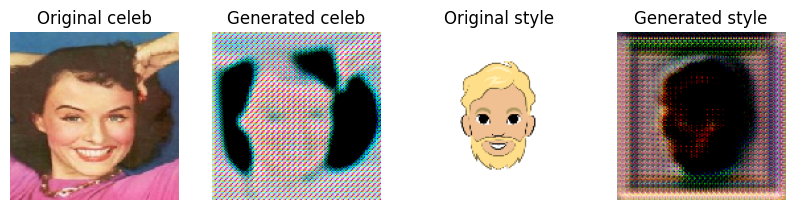

Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 1/400 [00:00<04:02,  1.64it/s]

>1, dA[0.062 ,0.041 ] dB[0.127 ,0.066] g[44.016 ,56.153]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:59,  1.66it/s]

>2, dA[0.072 ,0.049 ] dB[0.164 ,0.075] g[34.885 ,38.080]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:58,  1.67it/s]

>3, dA[0.093 ,0.064 ] dB[0.142 ,0.100] g[32.747 ,31.402]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:56,  1.68it/s]

>4, dA[0.072 ,0.049 ] dB[0.226 ,0.184] g[36.285 ,41.017]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:55,  1.68it/s]

>5, dA[0.035 ,0.055 ] dB[0.272 ,0.123] g[29.905 ,28.177]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:55,  1.67it/s]

>6, dA[0.042 ,0.031 ] dB[0.689 ,0.264] g[36.121 ,41.483]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:54,  1.67it/s]

>7, dA[0.086 ,0.037 ] dB[0.356 ,0.475] g[36.347 ,41.764]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:53,  1.68it/s]

>8, dA[0.082 ,0.070 ] dB[0.404 ,0.122] g[32.544 ,29.447]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:53,  1.68it/s]

>9, dA[0.075 ,0.033 ] dB[0.275 ,0.143] g[34.591 ,37.635]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▎         | 10/400 [00:06<03:55,  1.65it/s]

>10, dA[0.063 ,0.138 ] dB[0.509 ,0.102] g[25.562 ,22.428]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:55,  1.65it/s]

>11, dA[0.146 ,0.126 ] dB[0.317 ,0.158] g[28.354 ,30.344]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:53,  1.66it/s]

>12, dA[0.079 ,0.396 ] dB[0.101 ,0.099] g[29.844 ,31.042]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:53,  1.66it/s]

>13, dA[0.318 ,0.243 ] dB[0.099 ,0.032] g[37.622 ,49.201]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:52,  1.66it/s]

>14, dA[0.399 ,0.128 ] dB[0.061 ,0.036] g[33.515 ,42.487]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 15/400 [00:09<03:51,  1.66it/s]

>15, dA[0.604 ,0.202 ] dB[0.078 ,0.072] g[31.084 ,32.913]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:51,  1.66it/s]

>16, dA[0.079 ,0.419 ] dB[0.020 ,0.045] g[29.839 ,31.205]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:50,  1.67it/s]

>17, dA[0.187 ,0.086 ] dB[0.016 ,0.022] g[42.350 ,52.136]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:48,  1.67it/s]

>18, dA[0.133 ,0.146 ] dB[0.021 ,0.023] g[28.036 ,27.979]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:46,  1.68it/s]

>19, dA[0.195 ,0.086 ] dB[0.054 ,0.018] g[38.651 ,45.094]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:45,  1.69it/s]

>20, dA[0.050 ,0.073 ] dB[0.045 ,0.027] g[34.736 ,36.471]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:44,  1.69it/s]

>21, dA[0.052 ,0.051 ] dB[0.012 ,0.033] g[28.854 ,29.382]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:44,  1.69it/s]

>22, dA[0.062 ,0.130 ] dB[0.039 ,0.023] g[37.298 ,42.744]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:43,  1.68it/s]

>23, dA[0.085 ,0.048 ] dB[0.055 ,0.020] g[31.808 ,34.792]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:42,  1.69it/s]

>24, dA[0.047 ,0.034 ] dB[0.035 ,0.043] g[36.311 ,45.540]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:42,  1.68it/s]

>25, dA[0.089 ,0.041 ] dB[0.047 ,0.081] g[35.242 ,41.090]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:42,  1.68it/s]

>26, dA[0.056 ,0.016 ] dB[0.033 ,0.106] g[31.604 ,37.290]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.68it/s]

>27, dA[0.044 ,0.074 ] dB[0.116 ,0.017] g[32.285 ,36.072]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:40,  1.68it/s]

>28, dA[0.121 ,0.016 ] dB[0.043 ,0.037] g[29.813 ,31.772]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:39,  1.69it/s]

>29, dA[0.024 ,0.063 ] dB[0.013 ,0.028] g[28.679 ,30.711]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:39,  1.69it/s]

>30, dA[0.064 ,0.076 ] dB[0.019 ,0.013] g[28.475 ,31.852]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:37,  1.69it/s]

>31, dA[0.079 ,0.046 ] dB[0.044 ,0.059] g[28.520 ,25.161]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:36,  1.70it/s]

>32, dA[0.035 ,0.113 ] dB[0.022 ,0.034] g[25.933 ,22.900]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:35,  1.70it/s]

>33, dA[0.053 ,0.049 ] dB[0.044 ,0.048] g[31.765 ,35.779]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:35,  1.70it/s]

>34, dA[0.060 ,0.030 ] dB[0.036 ,0.035] g[34.429 ,39.722]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:34,  1.70it/s]

>35, dA[0.056 ,0.103 ] dB[0.020 ,0.014] g[35.843 ,46.804]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:34,  1.70it/s]

>36, dA[0.087 ,0.049 ] dB[0.010 ,0.024] g[33.425 ,35.661]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:33,  1.70it/s]

>37, dA[0.040 ,0.104 ] dB[0.015 ,0.013] g[36.090 ,40.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:33,  1.70it/s]

>38, dA[0.031 ,0.020 ] dB[0.020 ,0.043] g[35.851 ,36.634]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:32,  1.70it/s]

>39, dA[0.041 ,0.021 ] dB[0.019 ,0.028] g[27.710 ,34.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:32,  1.70it/s]

>40, dA[0.022 ,0.026 ] dB[0.026 ,0.037] g[35.435 ,44.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:31,  1.70it/s]

>41, dA[0.112 ,0.342 ] dB[0.029 ,0.018] g[31.490 ,33.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:24<03:31,  1.70it/s]

>42, dA[0.120 ,0.426 ] dB[0.042 ,0.080] g[34.642 ,45.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:30,  1.70it/s]

>43, dA[0.347 ,0.897 ] dB[0.044 ,0.083] g[35.446 ,41.032]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 44/400 [00:26<03:29,  1.70it/s]

>44, dA[0.451 ,0.415 ] dB[0.033 ,0.010] g[28.400 ,34.406]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:29,  1.70it/s]

>45, dA[0.254 ,0.170 ] dB[0.045 ,0.054] g[27.044 ,27.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:28,  1.70it/s]

>46, dA[0.167 ,0.171 ] dB[0.015 ,0.029] g[41.073 ,51.601]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:27,  1.70it/s]

>47, dA[0.084 ,0.054 ] dB[0.040 ,0.021] g[32.932 ,36.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:27,  1.70it/s]

>48, dA[0.052 ,0.058 ] dB[0.021 ,0.018] g[37.701 ,42.233]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:26,  1.70it/s]

>49, dA[0.087 ,0.050 ] dB[0.018 ,0.022] g[32.401 ,36.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:25,  1.70it/s]

>50, dA[0.042 ,0.020 ] dB[0.019 ,0.029] g[34.686 ,42.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:25,  1.70it/s]

>51, dA[0.093 ,0.026 ] dB[0.018 ,0.036] g[33.291 ,39.099]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:26,  1.68it/s]

>52, dA[0.025 ,0.020 ] dB[0.052 ,0.068] g[31.639 ,37.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:26,  1.68it/s]

>53, dA[0.019 ,0.041 ] dB[0.049 ,0.063] g[34.759 ,37.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:25,  1.68it/s]

>54, dA[0.025 ,0.039 ] dB[0.051 ,0.011] g[30.718 ,27.708]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:24,  1.69it/s]

>55, dA[0.053 ,0.039 ] dB[0.019 ,0.009] g[40.907 ,49.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:23,  1.69it/s]

>56, dA[0.038 ,0.015 ] dB[0.033 ,0.064] g[28.765 ,27.949]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:21,  1.70it/s]

>57, dA[0.048 ,0.032 ] dB[0.047 ,0.028] g[34.315 ,39.435]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:22,  1.69it/s]

>58, dA[0.029 ,0.053 ] dB[0.046 ,0.044] g[27.114 ,29.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:20,  1.70it/s]

>59, dA[0.023 ,0.042 ] dB[0.112 ,0.114] g[27.542 ,29.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:20,  1.70it/s]

>60, dA[0.031 ,0.023 ] dB[0.029 ,0.041] g[33.761 ,36.221]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:19,  1.70it/s]

>61, dA[0.026 ,0.017 ] dB[0.029 ,0.027] g[36.663 ,44.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:19,  1.69it/s]

>62, dA[0.031 ,0.009 ] dB[0.021 ,0.047] g[33.787 ,35.023]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:19,  1.69it/s]

>63, dA[0.040 ,0.012 ] dB[0.029 ,0.016] g[28.847 ,29.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:37<03:19,  1.68it/s]

>64, dA[0.012 ,0.028 ] dB[0.014 ,0.009] g[44.539 ,56.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:18,  1.69it/s]

>65, dA[0.221 ,0.225 ] dB[0.028 ,0.014] g[28.505 ,27.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:17,  1.69it/s]

>66, dA[0.047 ,0.109 ] dB[0.084 ,0.027] g[36.017 ,45.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:16,  1.69it/s]

>67, dA[0.056 ,0.041 ] dB[0.060 ,0.056] g[32.763 ,37.109]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:15,  1.70it/s]

>68, dA[0.050 ,0.095 ] dB[0.059 ,0.019] g[36.876 ,42.750]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [00:40<03:14,  1.70it/s]

>69, dA[0.025 ,0.070 ] dB[0.069 ,0.035] g[32.145 ,40.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:14,  1.69it/s]

>70, dA[0.070 ,0.058 ] dB[0.040 ,0.015] g[30.648 ,32.037]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:13,  1.70it/s]

>71, dA[0.055 ,0.088 ] dB[0.063 ,0.090] g[41.372 ,54.729]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:12,  1.70it/s]

>72, dA[0.048 ,0.139 ] dB[0.039 ,0.023] g[32.419 ,34.562]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:11,  1.70it/s]

>73, dA[0.105 ,0.063 ] dB[0.025 ,0.020] g[26.771 ,24.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:43<03:11,  1.70it/s]

>74, dA[0.038 ,0.078 ] dB[0.031 ,0.055] g[29.328 ,34.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:10,  1.70it/s]

>75, dA[0.070 ,0.160 ] dB[0.022 ,0.033] g[31.950 ,32.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:21,  1.61it/s]

>76, dA[0.185 ,0.056 ] dB[0.048 ,0.024] g[30.777 ,38.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:17,  1.63it/s]

>77, dA[0.087 ,0.024 ] dB[0.025 ,0.043] g[28.038 ,31.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:15,  1.65it/s]

>78, dA[0.073 ,0.018 ] dB[0.016 ,0.027] g[35.310 ,38.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:46<03:12,  1.66it/s]

>79, dA[0.036 ,0.032 ] dB[0.058 ,0.040] g[36.342 ,45.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [00:47<03:11,  1.67it/s]

>80, dA[0.026 ,0.045 ] dB[0.022 ,0.025] g[28.161 ,26.616]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:09,  1.68it/s]

>81, dA[0.027 ,0.045 ] dB[0.011 ,0.036] g[34.082 ,37.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:48<03:09,  1.68it/s]

>82, dA[0.019 ,0.028 ] dB[0.069 ,0.039] g[37.277 ,46.541]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 83/400 [00:49<03:07,  1.69it/s]

>83, dA[0.213 ,0.864 ] dB[0.061 ,0.092] g[27.008 ,25.909]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 84/400 [00:49<03:06,  1.69it/s]

>84, dA[0.238 ,1.120 ] dB[0.093 ,0.110] g[33.749 ,45.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:05,  1.69it/s]

>85, dA[0.584 ,1.327 ] dB[0.086 ,0.055] g[35.624 ,41.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:05,  1.69it/s]

>86, dA[0.834 ,0.230 ] dB[0.029 ,0.023] g[34.940 ,40.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:04,  1.70it/s]

>87, dA[0.108 ,0.254 ] dB[0.015 ,0.023] g[35.399 ,37.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:03,  1.70it/s]

>88, dA[0.117 ,0.057 ] dB[0.022 ,0.020] g[22.873 ,24.197]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:02,  1.70it/s]

>89, dA[0.054 ,0.077 ] dB[0.005 ,0.009] g[44.642 ,56.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:02,  1.70it/s]

>90, dA[0.112 ,0.030 ] dB[0.008 ,0.009] g[30.405 ,32.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:53<03:02,  1.69it/s]

>91, dA[0.063 ,0.035 ] dB[0.007 ,0.011] g[30.790 ,30.817]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:01,  1.69it/s]

>92, dA[0.057 ,0.077 ] dB[0.006 ,0.007] g[34.778 ,37.622]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:00,  1.70it/s]

>93, dA[0.015 ,0.041 ] dB[0.007 ,0.007] g[39.791 ,47.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:00,  1.70it/s]

>94, dA[0.046 ,0.011 ] dB[0.011 ,0.006] g[35.341 ,38.513]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 95/400 [00:56<02:59,  1.70it/s]

>95, dA[0.038 ,0.019 ] dB[0.021 ,0.025] g[41.655 ,48.468]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 96/400 [00:56<02:58,  1.70it/s]

>96, dA[0.022 ,0.030 ] dB[0.040 ,0.037] g[31.569 ,36.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:57,  1.71it/s]

>97, dA[0.054 ,0.034 ] dB[0.042 ,0.084] g[34.897 ,41.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:57,  1.70it/s]

>98, dA[0.079 ,0.066 ] dB[0.055 ,0.068] g[27.516 ,27.908]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:56,  1.70it/s]

>99, dA[0.060 ,0.030 ] dB[0.048 ,0.042] g[30.129 ,32.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:55,  1.70it/s]

>100, dA[0.202 ,0.119 ] dB[0.051 ,0.024] g[27.367 ,26.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [00:59<02:55,  1.71it/s]

>101, dA[0.053 ,0.134 ] dB[0.031 ,0.036] g[40.367 ,51.053]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 102/400 [01:00<03:35,  1.38it/s]

>102, dA[0.046 ,0.087 ] dB[0.027 ,0.019] g[33.735 ,41.754]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 103/400 [01:01<03:24,  1.45it/s]

>103, dA[0.059 ,0.038 ] dB[0.044 ,0.045] g[36.879 ,42.855]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 104/400 [01:02<03:18,  1.49it/s]

>104, dA[0.030 ,0.079 ] dB[0.064 ,0.091] g[29.897 ,29.281]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▋       | 105/400 [01:02<03:11,  1.54it/s]

>105, dA[0.041 ,0.079 ] dB[0.033 ,0.039] g[32.179 ,38.388]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 106/400 [01:03<03:06,  1.58it/s]

>106, dA[0.030 ,0.029 ] dB[0.021 ,0.025] g[28.354 ,27.894]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 107/400 [01:03<03:02,  1.61it/s]

>107, dA[0.022 ,0.042 ] dB[0.035 ,0.034] g[30.899 ,33.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:59,  1.63it/s]

>108, dA[0.037 ,0.177 ] dB[0.014 ,0.017] g[30.591 ,31.070]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:56,  1.65it/s]

>109, dA[0.093 ,0.109 ] dB[0.017 ,0.013] g[37.278 ,45.710]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:55,  1.65it/s]

>110, dA[0.049 ,0.040 ] dB[0.031 ,0.017] g[35.761 ,44.380]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:54,  1.66it/s]

>111, dA[0.032 ,0.029 ] dB[0.014 ,0.010] g[34.289 ,40.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:52,  1.67it/s]

>112, dA[0.085 ,0.058 ] dB[0.016 ,0.013] g[37.903 ,41.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:51,  1.68it/s]

>113, dA[0.127 ,0.051 ] dB[0.024 ,0.025] g[33.933 ,40.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:51,  1.67it/s]

>114, dA[0.069 ,0.099 ] dB[0.034 ,0.043] g[23.143 ,23.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:50,  1.67it/s]

>115, dA[0.047 ,0.040 ] dB[0.036 ,0.023] g[28.576 ,26.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:49,  1.68it/s]

>116, dA[0.040 ,0.082 ] dB[0.048 ,0.041] g[37.727 ,50.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:47,  1.69it/s]

>117, dA[0.023 ,0.094 ] dB[0.026 ,0.015] g[39.442 ,49.537]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:47,  1.69it/s]

>118, dA[0.047 ,0.040 ] dB[0.022 ,0.009] g[31.689 ,30.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:46,  1.69it/s]

>119, dA[0.083 ,0.075 ] dB[0.008 ,0.009] g[28.924 ,24.635]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:45,  1.69it/s]

>120, dA[0.081 ,0.074 ] dB[0.013 ,0.020] g[26.454 ,24.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:12<02:44,  1.69it/s]

>121, dA[0.040 ,0.032 ] dB[0.022 ,0.015] g[33.136 ,38.954]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 122/400 [01:12<02:44,  1.69it/s]

>122, dA[0.040 ,0.074 ] dB[0.005 ,0.019] g[28.916 ,29.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [01:13<02:43,  1.69it/s]

>123, dA[0.079 ,0.223 ] dB[0.052 ,0.059] g[24.496 ,24.032]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 124/400 [01:13<02:42,  1.70it/s]

>124, dA[0.088 ,0.232 ] dB[0.005 ,0.016] g[32.982 ,32.458]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:41,  1.70it/s]

>125, dA[0.105 ,0.087 ] dB[0.031 ,0.035] g[32.550 ,38.390]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:41,  1.69it/s]

>126, dA[0.054 ,0.057 ] dB[0.061 ,0.070] g[37.258 ,49.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:41,  1.69it/s]

>127, dA[0.073 ,0.169 ] dB[0.068 ,0.049] g[34.244 ,43.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:40,  1.70it/s]

>128, dA[0.095 ,0.104 ] dB[0.026 ,0.029] g[27.134 ,26.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:39,  1.70it/s]

>129, dA[0.258 ,0.327 ] dB[0.012 ,0.019] g[38.463 ,49.042]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:39,  1.70it/s]

>130, dA[0.493 ,0.502 ] dB[0.033 ,0.016] g[28.194 ,32.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:39,  1.69it/s]

>131, dA[0.483 ,0.288 ] dB[0.039 ,0.066] g[30.123 ,29.940]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:38,  1.69it/s]

>132, dA[0.287 ,0.429 ] dB[0.035 ,0.042] g[25.486 ,28.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:37,  1.69it/s]

>133, dA[0.181 ,0.198 ] dB[0.035 ,0.054] g[27.486 ,30.441]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:37,  1.69it/s]

>134, dA[0.086 ,0.251 ] dB[0.043 ,0.020] g[30.589 ,34.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:36,  1.69it/s]

>135, dA[0.545 ,0.146 ] dB[0.034 ,0.017] g[27.375 ,25.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:35,  1.70it/s]

>136, dA[0.171 ,0.051 ] dB[0.013 ,0.018] g[25.533 ,27.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:34,  1.70it/s]

>137, dA[0.117 ,0.169 ] dB[0.008 ,0.010] g[34.610 ,40.039]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:34,  1.70it/s]

>138, dA[0.053 ,0.098 ] dB[0.010 ,0.014] g[34.779 ,37.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:33,  1.70it/s]

>139, dA[0.100 ,0.034 ] dB[0.107 ,0.362] g[33.529 ,33.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:32,  1.70it/s]

>140, dA[0.079 ,0.065 ] dB[0.208 ,0.098] g[30.681 ,29.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:32,  1.70it/s]

>141, dA[0.047 ,0.046 ] dB[0.057 ,0.134] g[34.939 ,40.700]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:33,  1.68it/s]

>142, dA[0.087 ,0.141 ] dB[0.054 ,0.033] g[26.511 ,25.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:32,  1.69it/s]

>143, dA[0.102 ,0.111 ] dB[0.055 ,0.064] g[26.328 ,27.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:31,  1.69it/s]

>144, dA[0.094 ,0.062 ] dB[0.073 ,0.072] g[33.016 ,39.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:30,  1.69it/s]

>145, dA[0.080 ,0.050 ] dB[0.028 ,0.073] g[29.619 ,29.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:30,  1.69it/s]

>146, dA[0.048 ,0.022 ] dB[0.074 ,0.071] g[29.389 ,30.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:30,  1.68it/s]

>147, dA[0.043 ,0.051 ] dB[0.132 ,0.295] g[35.322 ,43.617]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:29,  1.68it/s]

>148, dA[0.041 ,0.052 ] dB[0.099 ,0.044] g[30.004 ,29.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:28,  1.69it/s]

>149, dA[0.054 ,0.020 ] dB[0.088 ,0.040] g[22.051 ,21.150]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:28,  1.68it/s]

>150, dA[0.048 ,0.019 ] dB[0.026 ,0.068] g[37.852 ,43.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:27,  1.68it/s]

>151, dA[0.076 ,0.046 ] dB[0.057 ,0.044] g[33.627 ,45.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:26,  1.69it/s]

>152, dA[0.018 ,0.029 ] dB[0.029 ,0.073] g[36.373 ,45.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:26,  1.69it/s]

>153, dA[0.032 ,0.033 ] dB[0.037 ,0.057] g[24.306 ,25.463]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:25,  1.69it/s]

>154, dA[0.021 ,0.014 ] dB[0.184 ,0.058] g[38.991 ,46.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:25,  1.69it/s]

>155, dA[0.016 ,0.033 ] dB[0.083 ,0.034] g[33.848 ,39.364]
1/1 [==============================] - 0s 29ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:26,  1.66it/s]

>156, dA[0.053 ,0.023 ] dB[0.023 ,0.027] g[26.362 ,28.086]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:25,  1.67it/s]

>157, dA[0.028 ,0.016 ] dB[0.037 ,0.021] g[27.057 ,25.895]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:24,  1.67it/s]

>158, dA[0.035 ,0.011 ] dB[0.024 ,0.030] g[30.025 ,35.909]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:23,  1.68it/s]

>159, dA[0.255 ,0.329 ] dB[0.016 ,0.022] g[25.863 ,27.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:35<02:22,  1.68it/s]

>160, dA[0.064 ,0.180 ] dB[0.022 ,0.010] g[34.009 ,34.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [01:35<02:21,  1.69it/s]

>161, dA[0.029 ,0.081 ] dB[0.032 ,0.064] g[33.306 ,40.217]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 162/400 [01:36<02:21,  1.68it/s]

>162, dA[0.064 ,0.096 ] dB[0.027 ,0.021] g[28.881 ,32.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:37<02:20,  1.68it/s]

>163, dA[0.093 ,0.020 ] dB[0.018 ,0.019] g[32.679 ,32.449]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:19,  1.69it/s]

>164, dA[0.070 ,0.090 ] dB[0.012 ,0.010] g[28.064 ,27.782]
1/1 [==============================] - 0s 28ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:21,  1.66it/s]

>165, dA[0.058 ,0.090 ] dB[0.006 ,0.015] g[35.505 ,43.851]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:19,  1.67it/s]

>166, dA[0.060 ,0.048 ] dB[0.003 ,0.008] g[34.012 ,40.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:19,  1.68it/s]

>167, dA[0.087 ,0.042 ] dB[0.023 ,0.016] g[26.725 ,29.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:17,  1.68it/s]

>168, dA[0.094 ,0.081 ] dB[0.024 ,0.062] g[34.169 ,39.800]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:16,  1.69it/s]

>169, dA[0.113 ,0.073 ] dB[0.033 ,0.021] g[24.964 ,25.875]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:16,  1.69it/s]

>170, dA[0.061 ,0.028 ] dB[0.018 ,0.043] g[27.807 ,28.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:15,  1.69it/s]

>171, dA[0.062 ,0.035 ] dB[0.073 ,0.034] g[33.791 ,39.079]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:14,  1.69it/s]

>172, dA[0.090 ,0.074 ] dB[0.029 ,0.049] g[32.380 ,39.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:14,  1.69it/s]

>173, dA[0.042 ,0.044 ] dB[0.021 ,0.021] g[30.404 ,39.254]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:14,  1.68it/s]

>174, dA[0.029 ,0.028 ] dB[0.025 ,0.034] g[25.739 ,28.443]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:13,  1.69it/s]

>175, dA[0.023 ,0.031 ] dB[0.025 ,0.008] g[29.928 ,27.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:12,  1.69it/s]

>176, dA[0.062 ,0.023 ] dB[0.025 ,0.051] g[35.001 ,37.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:11,  1.69it/s]

>177, dA[0.038 ,0.024 ] dB[0.021 ,0.014] g[32.046 ,34.290]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 178/400 [01:45<02:11,  1.69it/s]

>178, dA[0.051 ,0.047 ] dB[0.082 ,0.053] g[31.070 ,32.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:10,  1.69it/s]

>179, dA[0.023 ,0.034 ] dB[0.020 ,0.041] g[37.221 ,42.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:09,  1.69it/s]

>180, dA[0.045 ,0.010 ] dB[0.024 ,0.030] g[31.647 ,35.912]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:09,  1.69it/s]

>181, dA[0.020 ,0.016 ] dB[0.024 ,0.015] g[40.803 ,55.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:10,  1.67it/s]

>182, dA[0.022 ,0.031 ] dB[0.024 ,0.017] g[36.628 ,43.916]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:09,  1.68it/s]

>183, dA[0.019 ,0.039 ] dB[0.034 ,0.037] g[28.365 ,32.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:08,  1.68it/s]

>184, dA[0.028 ,0.013 ] dB[0.032 ,0.027] g[32.672 ,39.563]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:07,  1.69it/s]

>185, dA[0.035 ,0.015 ] dB[0.028 ,0.022] g[30.041 ,32.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:07,  1.68it/s]

>186, dA[0.013 ,0.013 ] dB[0.030 ,0.032] g[29.515 ,29.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:06,  1.69it/s]

>187, dA[0.024 ,0.024 ] dB[0.027 ,0.024] g[27.838 ,30.567]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:05,  1.69it/s]

>188, dA[0.033 ,0.019 ] dB[0.026 ,0.019] g[32.346 ,37.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:04,  1.69it/s]

>189, dA[0.062 ,0.031 ] dB[0.056 ,0.045] g[34.276 ,40.797]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.69it/s]

>190, dA[0.046 ,0.037 ] dB[0.046 ,0.042] g[39.693 ,40.787]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:03,  1.69it/s]

>191, dA[0.031 ,0.006 ] dB[0.022 ,0.032] g[31.593 ,32.911]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:02,  1.69it/s]

>192, dA[0.016 ,0.007 ] dB[0.015 ,0.019] g[30.049 ,32.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:02,  1.69it/s]

>193, dA[0.013 ,0.010 ] dB[0.009 ,0.050] g[29.178 ,32.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:02,  1.68it/s]

>194, dA[0.010 ,0.019 ] dB[0.045 ,0.017] g[34.023 ,42.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:02,  1.68it/s]

>195, dA[0.015 ,0.017 ] dB[0.071 ,0.069] g[31.335 ,33.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:01,  1.68it/s]

>196, dA[0.051 ,0.017 ] dB[0.033 ,0.060] g[29.334 ,28.269]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:00,  1.69it/s]

>197, dA[0.034 ,0.024 ] dB[0.062 ,0.095] g[25.970 ,27.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:57<01:59,  1.68it/s]

>198, dA[0.032 ,0.020 ] dB[0.084 ,0.145] g[35.355 ,42.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:59,  1.68it/s]

>199, dA[0.019 ,0.011 ] dB[0.086 ,0.031] g[41.311 ,51.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.69it/s]

>200, dA[0.011 ,0.021 ] dB[0.073 ,0.069] g[31.940 ,34.365]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:58,  1.69it/s]

>201, dA[0.032 ,0.018 ] dB[0.037 ,0.047] g[31.316 ,34.723]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:58,  1.68it/s]

>202, dA[0.023 ,0.045 ] dB[0.036 ,0.018] g[39.919 ,53.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:57,  1.68it/s]

>203, dA[0.019 ,0.046 ] dB[0.046 ,0.026] g[39.682 ,48.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.68it/s]

>204, dA[0.024 ,0.023 ] dB[0.067 ,0.016] g[34.117 ,38.995]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:56,  1.68it/s]

>205, dA[0.013 ,0.031 ] dB[0.038 ,0.063] g[26.344 ,24.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:56,  1.67it/s]

>206, dA[0.018 ,0.021 ] dB[0.102 ,0.109] g[32.850 ,40.919]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:55,  1.67it/s]

>207, dA[0.019 ,0.016 ] dB[0.035 ,0.074] g[31.995 ,36.888]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:55,  1.66it/s]

>208, dA[0.020 ,0.012 ] dB[0.056 ,0.032] g[27.828 ,24.488]
1/1 [==============================] - 0s 27ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:56,  1.64it/s]

>209, dA[0.018 ,0.009 ] dB[0.026 ,0.069] g[31.326 ,36.526]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:56,  1.63it/s]

>210, dA[0.071 ,0.049 ] dB[0.033 ,0.067] g[29.643 ,32.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:54,  1.65it/s]

>211, dA[0.056 ,0.027 ] dB[0.045 ,0.017] g[31.146 ,31.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:53,  1.66it/s]

>212, dA[0.056 ,0.113 ] dB[0.033 ,0.017] g[28.428 ,28.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:51,  1.67it/s]

>213, dA[0.072 ,0.121 ] dB[0.038 ,0.034] g[32.068 ,36.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:51,  1.67it/s]

>214, dA[0.072 ,0.015 ] dB[0.018 ,0.033] g[27.883 ,27.338]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:51,  1.67it/s]

>215, dA[0.096 ,0.069 ] dB[0.027 ,0.022] g[23.817 ,21.109]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:50,  1.67it/s]

>216, dA[0.018 ,0.040 ] dB[0.019 ,0.047] g[32.888 ,43.010]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:49,  1.67it/s]

>217, dA[0.020 ,0.033 ] dB[0.030 ,0.032] g[30.235 ,31.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:48,  1.67it/s]

>218, dA[0.017 ,0.013 ] dB[0.031 ,0.021] g[34.651 ,38.894]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:47,  1.68it/s]

>219, dA[0.018 ,0.020 ] dB[0.018 ,0.028] g[26.216 ,29.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:46,  1.69it/s]

>220, dA[0.017 ,0.012 ] dB[0.035 ,0.052] g[36.715 ,44.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:45,  1.69it/s]

>221, dA[0.006 ,0.011 ] dB[0.029 ,0.045] g[26.280 ,30.681]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:45,  1.69it/s]

>222, dA[0.009 ,0.009 ] dB[0.059 ,0.039] g[31.769 ,36.944]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:44,  1.69it/s]

>223, dA[0.024 ,0.010 ] dB[0.029 ,0.015] g[28.958 ,34.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:43,  1.69it/s]

>224, dA[0.010 ,0.026 ] dB[0.023 ,0.018] g[29.582 ,35.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:13<01:43,  1.69it/s]

>225, dA[0.008 ,0.051 ] dB[0.025 ,0.026] g[30.827 ,34.234]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:43,  1.68it/s]

>226, dA[0.010 ,0.038 ] dB[0.033 ,0.071] g[36.208 ,41.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:42,  1.68it/s]

>227, dA[0.024 ,0.069 ] dB[0.018 ,0.020] g[30.408 ,32.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:42,  1.68it/s]

>228, dA[0.023 ,0.014 ] dB[0.018 ,0.011] g[30.481 ,31.923]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:41,  1.68it/s]

>229, dA[0.017 ,0.020 ] dB[0.005 ,0.013] g[38.303 ,47.202]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:16<01:41,  1.68it/s]

>230, dA[0.044 ,0.056 ] dB[0.004 ,0.011] g[38.380 ,46.237]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.68it/s]

>231, dA[0.030 ,0.068 ] dB[0.018 ,0.018] g[32.276 ,34.584]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:40,  1.68it/s]

>232, dA[0.042 ,0.018 ] dB[0.004 ,0.016] g[25.352 ,26.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:39,  1.69it/s]

>233, dA[0.025 ,0.019 ] dB[0.014 ,0.007] g[41.984 ,54.130]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:38,  1.68it/s]

>234, dA[0.013 ,0.013 ] dB[0.016 ,0.018] g[26.375 ,26.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:19<01:37,  1.69it/s]

>235, dA[0.032 ,0.022 ] dB[0.010 ,0.018] g[37.845 ,47.771]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:37,  1.69it/s]

>236, dA[0.018 ,0.031 ] dB[0.012 ,0.013] g[35.433 ,41.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:36,  1.69it/s]

>237, dA[0.032 ,0.027 ] dB[0.011 ,0.013] g[24.714 ,26.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:36,  1.69it/s]

>238, dA[0.019 ,0.027 ] dB[0.019 ,0.013] g[34.083 ,35.784]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:35,  1.69it/s]

>239, dA[0.026 ,0.057 ] dB[0.016 ,0.009] g[27.414 ,28.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:34,  1.69it/s]

>240, dA[0.039 ,0.026 ] dB[0.010 ,0.019] g[33.180 ,38.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:33,  1.69it/s]

>241, dA[0.016 ,0.016 ] dB[0.007 ,0.018] g[32.494 ,40.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:33,  1.69it/s]

>242, dA[0.014 ,0.028 ] dB[0.018 ,0.025] g[30.679 ,35.563]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:32,  1.69it/s]

>243, dA[0.019 ,0.019 ] dB[0.014 ,0.051] g[29.638 ,31.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:32,  1.69it/s]

>244, dA[0.025 ,0.027 ] dB[0.012 ,0.013] g[27.430 ,31.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:31,  1.69it/s]

>245, dA[0.051 ,0.023 ] dB[0.012 ,0.011] g[28.877 ,30.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.68it/s]

>246, dA[0.014 ,0.014 ] dB[0.024 ,0.036] g[32.633 ,40.975]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.68it/s]

>247, dA[0.037 ,0.007 ] dB[0.021 ,0.042] g[36.935 ,45.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.69it/s]

>248, dA[0.011 ,0.014 ] dB[0.038 ,0.033] g[29.730 ,28.904]
1/1 [==============================] - 0s 32ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:30,  1.67it/s]

>249, dA[0.010 ,0.032 ] dB[0.016 ,0.021] g[30.428 ,33.560]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:29,  1.67it/s]

>250, dA[0.031 ,0.034 ] dB[0.022 ,0.017] g[43.103 ,56.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.68it/s]

>251, dA[0.066 ,0.058 ] dB[0.018 ,0.032] g[32.440 ,37.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:27,  1.69it/s]

>252, dA[0.062 ,0.024 ] dB[0.015 ,0.031] g[32.183 ,38.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:26,  1.69it/s]

>253, dA[0.018 ,0.017 ] dB[0.014 ,0.009] g[27.565 ,29.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:26,  1.69it/s]

>254, dA[0.009 ,0.015 ] dB[0.007 ,0.010] g[42.210 ,56.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:25,  1.69it/s]

>255, dA[0.013 ,0.007 ] dB[0.005 ,0.015] g[31.740 ,44.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:25,  1.69it/s]

>256, dA[0.015 ,0.007 ] dB[0.011 ,0.014] g[29.658 ,29.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 257/400 [02:32<01:24,  1.70it/s]

>257, dA[0.014 ,0.019 ] dB[0.010 ,0.016] g[26.003 ,24.463]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:24,  1.69it/s]

>258, dA[0.006 ,0.017 ] dB[0.023 ,0.020] g[28.222 ,27.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:23,  1.69it/s]

>259, dA[0.012 ,0.006 ] dB[0.017 ,0.017] g[38.534 ,46.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:22,  1.69it/s]

>260, dA[0.016 ,0.008 ] dB[0.019 ,0.023] g[33.885 ,37.615]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:24,  1.65it/s]

>261, dA[0.017 ,0.009 ] dB[0.018 ,0.053] g[29.577 ,29.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:24,  1.64it/s]

>262, dA[0.005 ,0.006 ] dB[0.045 ,0.009] g[30.087 ,33.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:22,  1.65it/s]

>263, dA[0.014 ,0.005 ] dB[0.041 ,0.081] g[27.001 ,28.797]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:21,  1.66it/s]

>264, dA[0.012 ,0.017 ] dB[0.036 ,0.012] g[36.457 ,47.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:21,  1.66it/s]

>265, dA[0.038 ,0.028 ] dB[0.034 ,0.091] g[35.011 ,42.459]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:20,  1.65it/s]

>266, dA[0.014 ,0.010 ] dB[0.090 ,0.028] g[27.236 ,24.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:19,  1.67it/s]

>267, dA[0.015 ,0.022 ] dB[0.091 ,0.090] g[27.989 ,28.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.68it/s]

>268, dA[0.023 ,0.015 ] dB[0.045 ,0.111] g[30.936 ,31.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:17,  1.68it/s]

>269, dA[0.016 ,0.010 ] dB[0.419 ,0.105] g[27.544 ,28.023]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:17,  1.68it/s]

>270, dA[0.013 ,0.010 ] dB[0.252 ,0.288] g[33.876 ,37.193]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.69it/s]

>271, dA[0.013 ,0.016 ] dB[0.108 ,0.062] g[27.521 ,28.845]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 272/400 [02:41<01:15,  1.69it/s]

>272, dA[0.010 ,0.017 ] dB[0.061 ,0.143] g[33.718 ,39.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.69it/s]

>273, dA[0.009 ,0.011 ] dB[0.063 ,0.072] g[34.078 ,40.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:14,  1.69it/s]

>274, dA[0.016 ,0.008 ] dB[0.062 ,0.061] g[42.578 ,56.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:43<01:14,  1.69it/s]

>275, dA[0.010 ,0.016 ] dB[0.043 ,0.072] g[29.009 ,31.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:13,  1.69it/s]

>276, dA[0.014 ,0.015 ] dB[0.019 ,0.063] g[28.851 ,28.197]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 277/400 [02:44<01:12,  1.69it/s]

>277, dA[0.018 ,0.007 ] dB[0.064 ,0.044] g[41.095 ,50.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:12,  1.69it/s]

>278, dA[0.009 ,0.012 ] dB[0.078 ,0.064] g[34.057 ,39.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:11,  1.69it/s]

>279, dA[0.034 ,0.016 ] dB[0.054 ,0.108] g[35.486 ,44.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:11,  1.69it/s]

>280, dA[0.023 ,0.029 ] dB[0.036 ,0.048] g[28.621 ,34.262]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:10,  1.69it/s]

>281, dA[0.016 ,0.021 ] dB[0.130 ,0.137] g[25.376 ,26.467]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:47<01:10,  1.69it/s]

>282, dA[0.020 ,0.050 ] dB[0.041 ,0.075] g[27.065 ,25.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:09,  1.69it/s]

>283, dA[0.053 ,0.016 ] dB[0.075 ,0.060] g[26.567 ,28.594]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:08,  1.69it/s]

>284, dA[0.062 ,0.025 ] dB[0.020 ,0.046] g[30.613 ,31.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:07,  1.69it/s]

>285, dA[0.033 ,0.032 ] dB[0.022 ,0.024] g[33.834 ,36.455]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:07,  1.69it/s]

>286, dA[0.022 ,0.021 ] dB[0.019 ,0.033] g[25.898 ,26.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:50<01:06,  1.69it/s]

>287, dA[0.019 ,0.024 ] dB[0.026 ,0.028] g[32.474 ,39.891]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.69it/s]

>288, dA[0.014 ,0.013 ] dB[0.019 ,0.016] g[28.297 ,30.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:05,  1.69it/s]

>289, dA[0.017 ,0.009 ] dB[0.017 ,0.032] g[37.869 ,49.272]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [02:52<01:05,  1.69it/s]

>290, dA[0.029 ,0.070 ] dB[0.011 ,0.013] g[39.067 ,51.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:04,  1.69it/s]

>291, dA[0.068 ,0.060 ] dB[0.014 ,0.016] g[26.733 ,29.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:53<01:03,  1.70it/s]

>292, dA[0.037 ,0.022 ] dB[0.020 ,0.011] g[27.033 ,25.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.70it/s]

>293, dA[0.035 ,0.051 ] dB[0.016 ,0.010] g[33.000 ,42.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:54<01:02,  1.69it/s]

>294, dA[0.018 ,0.046 ] dB[0.006 ,0.008] g[32.586 ,35.805]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:55<01:02,  1.69it/s]

>295, dA[0.052 ,0.049 ] dB[0.004 ,0.010] g[36.458 ,42.130]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:01,  1.69it/s]

>296, dA[0.123 ,0.173 ] dB[0.007 ,0.007] g[37.051 ,44.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [02:56<01:01,  1.69it/s]

>297, dA[0.511 ,0.835 ] dB[0.005 ,0.009] g[39.018 ,53.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.68it/s]

>298, dA[0.292 ,0.360 ] dB[0.011 ,0.017] g[27.846 ,31.908]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:57<00:59,  1.69it/s]

>299, dA[0.593 ,0.088 ] dB[0.021 ,0.020] g[29.213 ,30.163]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<00:59,  1.69it/s]

>300, dA[0.285 ,0.105 ] dB[0.010 ,0.017] g[26.821 ,27.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.69it/s]

>301, dA[0.081 ,0.058 ] dB[0.007 ,0.023] g[32.204 ,38.338]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 302/400 [02:59<00:58,  1.68it/s]

>302, dA[0.047 ,0.070 ] dB[0.013 ,0.026] g[32.356 ,38.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.68it/s]

>303, dA[0.095 ,0.050 ] dB[0.028 ,0.043] g[29.116 ,29.572]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 304/400 [03:00<00:56,  1.69it/s]

>304, dA[0.039 ,0.066 ] dB[0.012 ,0.044] g[30.157 ,32.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:56,  1.69it/s]

>305, dA[0.040 ,0.033 ] dB[0.083 ,0.032] g[29.338 ,31.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.68it/s]

>306, dA[0.069 ,0.039 ] dB[0.025 ,0.091] g[28.066 ,30.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:02<00:55,  1.69it/s]

>307, dA[0.037 ,0.059 ] dB[0.107 ,0.044] g[30.524 ,35.854]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.69it/s]

>308, dA[0.100 ,0.210 ] dB[0.025 ,0.039] g[30.261 ,32.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [03:03<00:53,  1.69it/s]

>309, dA[0.098 ,0.123 ] dB[0.038 ,0.049] g[31.222 ,28.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.69it/s]

>310, dA[0.063 ,0.052 ] dB[0.031 ,0.015] g[26.019 ,24.975]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:52,  1.69it/s]

>311, dA[0.027 ,0.049 ] dB[0.062 ,0.087] g[30.030 ,31.298]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 312/400 [03:05<00:52,  1.69it/s]

>312, dA[0.028 ,0.076 ] dB[0.039 ,0.050] g[23.855 ,22.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:54,  1.58it/s]

>313, dA[0.057 ,0.061 ] dB[0.018 ,0.016] g[32.090 ,35.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:06<00:54,  1.59it/s]

>314, dA[0.036 ,0.015 ] dB[0.018 ,0.023] g[32.318 ,38.652]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:52,  1.61it/s]

>315, dA[0.085 ,0.015 ] dB[0.031 ,0.011] g[26.606 ,25.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:51,  1.64it/s]

>316, dA[0.029 ,0.056 ] dB[0.026 ,0.052] g[26.733 ,29.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [03:08<00:50,  1.65it/s]

>317, dA[0.049 ,0.050 ] dB[0.082 ,0.041] g[35.765 ,39.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:49,  1.66it/s]

>318, dA[0.040 ,0.046 ] dB[0.174 ,0.146] g[28.389 ,29.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:09<00:48,  1.67it/s]

>319, dA[0.052 ,0.028 ] dB[0.028 ,0.108] g[30.034 ,31.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:47,  1.68it/s]

>320, dA[0.063 ,0.042 ] dB[0.064 ,0.053] g[30.305 ,30.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:46,  1.68it/s]

>321, dA[0.068 ,0.101 ] dB[0.056 ,0.031] g[32.923 ,37.642]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:11<00:46,  1.68it/s]

>322, dA[0.082 ,0.067 ] dB[0.024 ,0.087] g[24.316 ,25.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.68it/s]

>323, dA[0.035 ,0.084 ] dB[0.095 ,0.040] g[42.939 ,55.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [03:12<00:45,  1.69it/s]

>324, dA[0.077 ,0.037 ] dB[0.124 ,0.196] g[39.561 ,49.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.69it/s]

>325, dA[0.104 ,0.094 ] dB[0.084 ,0.085] g[30.968 ,36.862]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:44,  1.68it/s]

>326, dA[0.120 ,0.042 ] dB[0.112 ,0.065] g[32.583 ,36.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:14<00:43,  1.68it/s]

>327, dA[0.057 ,0.119 ] dB[0.073 ,0.040] g[35.974 ,47.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:42,  1.69it/s]

>328, dA[0.016 ,0.057 ] dB[0.173 ,0.146] g[30.881 ,30.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [03:15<00:42,  1.69it/s]

>329, dA[0.054 ,0.041 ] dB[0.150 ,0.106] g[29.941 ,34.640]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.68it/s]

>330, dA[0.035 ,0.027 ] dB[0.184 ,0.086] g[33.073 ,34.440]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:41,  1.68it/s]

>331, dA[0.067 ,0.022 ] dB[0.159 ,0.223] g[27.454 ,25.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:17<00:40,  1.69it/s]

>332, dA[0.020 ,0.024 ] dB[0.167 ,0.082] g[28.855 ,25.598]
1/1 [==============================] - 0s 32ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:40,  1.67it/s]

>333, dA[0.142 ,0.149 ] dB[0.221 ,0.226] g[24.468 ,28.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:18<00:39,  1.68it/s]

>334, dA[0.090 ,0.211 ] dB[0.191 ,0.192] g[36.954 ,48.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.68it/s]

>335, dA[0.112 ,0.207 ] dB[0.121 ,0.147] g[40.619 ,52.811]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.68it/s]

>336, dA[0.087 ,0.027 ] dB[0.059 ,0.058] g[24.853 ,29.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:20<00:37,  1.69it/s]

>337, dA[0.066 ,0.040 ] dB[0.055 ,0.079] g[29.059 ,35.755]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:36,  1.68it/s]

>338, dA[0.039 ,0.052 ] dB[0.187 ,0.065] g[33.808 ,38.791]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 339/400 [03:21<00:36,  1.68it/s]

>339, dA[0.025 ,0.038 ] dB[0.092 ,0.205] g[31.448 ,39.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.69it/s]

>340, dA[0.020 ,0.044 ] dB[0.098 ,0.129] g[30.466 ,37.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:34,  1.69it/s]

>341, dA[0.051 ,0.015 ] dB[0.335 ,0.144] g[29.286 ,31.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.69it/s]

>342, dA[0.032 ,0.016 ] dB[0.149 ,0.329] g[29.629 ,31.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:33,  1.69it/s]

>343, dA[0.031 ,0.039 ] dB[0.157 ,0.234] g[25.126 ,29.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:24<00:33,  1.69it/s]

>344, dA[0.018 ,0.028 ] dB[0.131 ,0.101] g[26.861 ,26.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.69it/s]

>345, dA[0.025 ,0.018 ] dB[0.060 ,0.066] g[31.852 ,37.194]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [03:25<00:32,  1.68it/s]

>346, dA[0.018 ,0.020 ] dB[0.048 ,0.052] g[25.010 ,27.032]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.68it/s]

>347, dA[0.018 ,0.014 ] dB[0.045 ,0.050] g[27.505 ,33.894]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:31,  1.68it/s]

>348, dA[0.019 ,0.020 ] dB[0.026 ,0.031] g[31.362 ,37.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:27<00:30,  1.67it/s]

>349, dA[0.011 ,0.022 ] dB[0.044 ,0.030] g[37.349 ,47.616]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:30,  1.66it/s]

>350, dA[0.025 ,0.052 ] dB[0.039 ,0.061] g[36.896 ,45.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:28<00:29,  1.67it/s]

>351, dA[0.017 ,0.068 ] dB[0.042 ,0.037] g[27.826 ,28.670]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.67it/s]

>352, dA[0.048 ,0.025 ] dB[0.074 ,0.076] g[28.583 ,30.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:27,  1.68it/s]

>353, dA[0.013 ,0.009 ] dB[0.031 ,0.043] g[28.603 ,35.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:30<00:27,  1.68it/s]

>354, dA[0.010 ,0.007 ] dB[0.093 ,0.055] g[28.579 ,27.995]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:26,  1.68it/s]

>355, dA[0.024 ,0.021 ] dB[0.073 ,0.098] g[25.646 ,22.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:31<00:26,  1.69it/s]

>356, dA[0.023 ,0.004 ] dB[0.113 ,0.065] g[25.618 ,24.712]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.69it/s]

>357, dA[0.010 ,0.019 ] dB[0.014 ,0.040] g[27.939 ,27.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:24,  1.68it/s]

>358, dA[0.014 ,0.019 ] dB[0.043 ,0.050] g[31.846 ,39.403]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 359/400 [03:33<00:24,  1.68it/s]

>359, dA[0.034 ,0.021 ] dB[0.008 ,0.019] g[31.957 ,38.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:34<00:23,  1.69it/s]

>360, dA[0.033 ,0.049 ] dB[0.020 ,0.014] g[21.141 ,20.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 361/400 [03:34<00:23,  1.69it/s]

>361, dA[0.015 ,0.057 ] dB[0.016 ,0.013] g[33.256 ,38.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.68it/s]

>362, dA[0.041 ,0.022 ] dB[0.037 ,0.025] g[31.646 ,39.596]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:22,  1.68it/s]

>363, dA[0.016 ,0.037 ] dB[0.009 ,0.026] g[39.097 ,52.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [03:36<00:21,  1.69it/s]

>364, dA[0.020 ,0.012 ] dB[0.020 ,0.008] g[34.271 ,37.759]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 365/400 [03:37<00:20,  1.68it/s]

>365, dA[0.012 ,0.009 ] dB[0.020 ,0.008] g[31.561 ,35.583]
1/1 [==============================] - 0s 27ms/step



Batchs:  92%|█████████▏| 366/400 [03:37<00:20,  1.64it/s]

>366, dA[0.011 ,0.034 ] dB[0.017 ,0.019] g[29.157 ,32.326]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:20,  1.64it/s]

>367, dA[0.037 ,0.037 ] dB[0.011 ,0.017] g[32.206 ,46.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:19,  1.65it/s]

>368, dA[0.048 ,0.012 ] dB[0.010 ,0.018] g[27.548 ,28.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:39<00:18,  1.67it/s]

>369, dA[0.010 ,0.033 ] dB[0.024 ,0.019] g[27.837 ,29.566]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▎| 370/400 [03:40<00:17,  1.67it/s]

>370, dA[0.059 ,0.048 ] dB[0.020 ,0.017] g[24.616 ,27.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:40<00:17,  1.68it/s]

>371, dA[0.016 ,0.018 ] dB[0.011 ,0.031] g[26.135 ,26.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.69it/s]

>372, dA[0.012 ,0.016 ] dB[0.039 ,0.024] g[39.196 ,47.638]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:15,  1.69it/s]

>373, dA[0.048 ,0.030 ] dB[0.050 ,0.052] g[35.733 ,42.875]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 374/400 [03:42<00:15,  1.69it/s]

>374, dA[0.066 ,0.047 ] dB[0.034 ,0.020] g[32.424 ,37.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:43<00:14,  1.69it/s]

>375, dA[0.022 ,0.058 ] dB[0.022 ,0.020] g[39.584 ,48.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:43<00:14,  1.69it/s]

>376, dA[0.040 ,0.038 ] dB[0.021 ,0.032] g[29.697 ,33.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.69it/s]

>377, dA[0.023 ,0.012 ] dB[0.009 ,0.022] g[39.754 ,50.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.69it/s]

>378, dA[0.024 ,0.061 ] dB[0.010 ,0.010] g[27.955 ,31.086]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:45<00:12,  1.69it/s]

>379, dA[0.060 ,0.099 ] dB[0.012 ,0.019] g[30.874 ,33.784]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [03:46<00:11,  1.69it/s]

>380, dA[0.105 ,0.088 ] dB[0.025 ,0.031] g[38.506 ,49.343]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:46<00:11,  1.69it/s]

>381, dA[0.030 ,0.061 ] dB[0.014 ,0.015] g[26.293 ,28.474]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.68it/s]

>382, dA[0.025 ,0.029 ] dB[0.022 ,0.010] g[38.974 ,49.887]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.67it/s]

>383, dA[0.074 ,0.112 ] dB[0.029 ,0.013] g[25.497 ,24.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:09,  1.68it/s]

>384, dA[0.014 ,0.071 ] dB[0.009 ,0.020] g[28.511 ,34.640]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:49<00:08,  1.68it/s]

>385, dA[0.029 ,0.049 ] dB[0.023 ,0.021] g[25.568 ,22.849]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.68it/s]

>386, dA[0.017 ,0.055 ] dB[0.013 ,0.013] g[36.673 ,49.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.68it/s]

>387, dA[0.029 ,0.057 ] dB[0.009 ,0.016] g[28.575 ,28.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:50<00:07,  1.69it/s]

>388, dA[0.084 ,0.014 ] dB[0.006 ,0.012] g[28.808 ,30.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 389/400 [03:51<00:06,  1.68it/s]

>389, dA[0.056 ,0.030 ] dB[0.007 ,0.006] g[30.020 ,36.179]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [03:52<00:05,  1.68it/s]

>390, dA[0.014 ,0.021 ] dB[0.009 ,0.011] g[32.643 ,39.412]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.68it/s]

>391, dA[0.022 ,0.021 ] dB[0.008 ,0.009] g[35.695 ,44.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.68it/s]

>392, dA[0.013 ,0.013 ] dB[0.016 ,0.011] g[28.143 ,30.365]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 393/400 [03:53<00:04,  1.68it/s]

>393, dA[0.019 ,0.008 ] dB[0.016 ,0.014] g[32.812 ,40.225]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:54<00:03,  1.68it/s]

>394, dA[0.026 ,0.035 ] dB[0.013 ,0.020] g[28.981 ,32.859]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 395/400 [03:55<00:02,  1.68it/s]

>395, dA[0.015 ,0.033 ] dB[0.009 ,0.010] g[28.835 ,28.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.68it/s]

>396, dA[0.028 ,0.014 ] dB[0.007 ,0.014] g[30.276 ,35.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.68it/s]

>397, dA[0.046 ,0.040 ] dB[0.010 ,0.007] g[23.391 ,22.657]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 398/400 [03:56<00:01,  1.67it/s]

>398, dA[0.036 ,0.041 ] dB[0.004 ,0.010] g[30.426 ,37.348]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.67it/s]

>399, dA[0.044 ,0.040 ] dB[0.009 ,0.020] g[33.122 ,44.653]
1/1 [==============================] - 0s 21ms/step



Epochs:  20%|██        | 2/10 [09:17<36:11, 271.48s/it]

>400, dA[0.024 ,0.031 ] dB[0.019 ,0.013] g[39.543 ,48.324]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:56,  1.69it/s]

>1, dA[0.012 ,0.025 ] dB[0.061 ,0.073] g[36.985 ,42.013]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/400 [00:01<03:58,  1.67it/s]

>2, dA[0.018 ,0.028 ] dB[0.020 ,0.050] g[35.165 ,46.760]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:57,  1.67it/s]

>3, dA[0.010 ,0.026 ] dB[0.075 ,0.029] g[33.130 ,38.660]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:55,  1.68it/s]

>4, dA[0.011 ,0.017 ] dB[0.027 ,0.084] g[36.574 ,43.738]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:54,  1.68it/s]

>5, dA[0.010 ,0.027 ] dB[0.135 ,0.062] g[39.058 ,47.615]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:55,  1.68it/s]

>6, dA[0.010 ,0.019 ] dB[0.182 ,0.189] g[32.791 ,41.609]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:54,  1.68it/s]

>7, dA[0.023 ,0.011 ] dB[0.105 ,0.018] g[35.111 ,43.799]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:53,  1.68it/s]

>8, dA[0.021 ,0.033 ] dB[0.133 ,0.133] g[29.260 ,29.780]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:52,  1.69it/s]

>9, dA[0.008 ,0.019 ] dB[0.088 ,0.033] g[27.706 ,30.606]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:52,  1.68it/s]

>10, dA[0.018 ,0.018 ] dB[0.077 ,0.095] g[27.202 ,27.294]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:51,  1.68it/s]

>11, dA[0.012 ,0.023 ] dB[0.104 ,0.066] g[30.065 ,30.296]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:50,  1.68it/s]

>12, dA[0.008 ,0.011 ] dB[0.074 ,0.082] g[29.164 ,30.389]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:49,  1.69it/s]

>13, dA[0.009 ,0.010 ] dB[0.017 ,0.019] g[32.295 ,38.368]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:49,  1.68it/s]

>14, dA[0.014 ,0.018 ] dB[0.028 ,0.034] g[25.846 ,25.900]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:49,  1.68it/s]

>15, dA[0.011 ,0.010 ] dB[0.018 ,0.048] g[24.483 ,23.195]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.007 ,0.005 ] dB[0.021 ,0.017] g[34.194 ,37.357]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:49,  1.67it/s]

>17, dA[0.007 ,0.008 ] dB[0.021 ,0.013] g[26.815 ,30.885]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:52,  1.65it/s]

>18, dA[0.016 ,0.027 ] dB[0.022 ,0.045] g[26.543 ,32.274]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:52,  1.64it/s]

>19, dA[0.016 ,0.020 ] dB[0.042 ,0.027] g[31.463 ,34.993]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:49,  1.66it/s]

>20, dA[0.009 ,0.008 ] dB[0.085 ,0.031] g[22.851 ,23.083]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:47,  1.67it/s]

>21, dA[0.029 ,0.020 ] dB[0.036 ,0.141] g[27.002 ,30.876]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:46,  1.67it/s]

>22, dA[0.037 ,0.021 ] dB[0.090 ,0.018] g[27.931 ,30.173]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:45,  1.68it/s]

>23, dA[0.055 ,0.023 ] dB[0.057 ,0.087] g[30.921 ,37.502]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:43,  1.68it/s]

>24, dA[0.088 ,0.018 ] dB[0.092 ,0.031] g[23.534 ,23.548]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:43,  1.68it/s]

>25, dA[0.043 ,0.022 ] dB[0.076 ,0.136] g[32.169 ,39.845]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:42,  1.68it/s]

>26, dA[0.022 ,0.045 ] dB[0.079 ,0.039] g[28.516 ,30.745]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.68it/s]

>27, dA[0.039 ,0.016 ] dB[0.101 ,0.080] g[31.390 ,37.698]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:41,  1.68it/s]

>28, dA[0.016 ,0.029 ] dB[0.085 ,0.065] g[32.102 ,37.663]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.68it/s]

>29, dA[0.020 ,0.019 ] dB[0.066 ,0.045] g[38.545 ,53.476]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:41,  1.67it/s]

>30, dA[0.015 ,0.017 ] dB[0.101 ,0.152] g[32.490 ,39.266]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:40,  1.67it/s]

>31, dA[0.027 ,0.013 ] dB[0.053 ,0.073] g[30.404 ,34.886]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:39,  1.68it/s]

>32, dA[0.058 ,0.132 ] dB[0.073 ,0.041] g[31.517 ,35.074]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:38,  1.68it/s]

>33, dA[0.053 ,0.033 ] dB[0.026 ,0.026] g[25.362 ,25.980]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:38,  1.67it/s]

>34, dA[0.065 ,0.040 ] dB[0.042 ,0.041] g[28.787 ,32.341]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:38,  1.67it/s]

>35, dA[0.058 ,0.025 ] dB[0.039 ,0.049] g[40.209 ,52.328]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:37,  1.67it/s]

>36, dA[0.024 ,0.045 ] dB[0.085 ,0.053] g[27.668 ,27.217]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:36,  1.67it/s]

>37, dA[0.009 ,0.029 ] dB[0.104 ,0.075] g[26.832 ,28.688]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:36,  1.67it/s]

>38, dA[0.010 ,0.055 ] dB[0.144 ,0.036] g[34.469 ,44.364]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:36,  1.67it/s]

>39, dA[0.049 ,0.059 ] dB[0.080 ,0.045] g[24.483 ,21.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:34,  1.68it/s]

>40, dA[0.063 ,0.048 ] dB[0.069 ,0.044] g[36.614 ,48.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:33,  1.68it/s]

>41, dA[0.065 ,0.040 ] dB[0.109 ,0.046] g[28.155 ,34.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:25<03:33,  1.68it/s]

>42, dA[0.026 ,0.040 ] dB[0.082 ,0.043] g[33.482 ,39.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:32,  1.68it/s]

>43, dA[0.051 ,0.016 ] dB[0.076 ,0.053] g[39.121 ,50.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:31,  1.68it/s]

>44, dA[0.085 ,0.063 ] dB[0.069 ,0.086] g[38.655 ,50.267]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:30,  1.68it/s]

>45, dA[0.034 ,0.057 ] dB[0.097 ,0.108] g[37.644 ,46.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:31,  1.68it/s]

>46, dA[0.025 ,0.062 ] dB[0.147 ,0.159] g[30.421 ,33.743]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:31,  1.67it/s]

>47, dA[0.052 ,0.039 ] dB[0.027 ,0.098] g[24.412 ,24.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:30,  1.67it/s]

>48, dA[0.041 ,0.042 ] dB[0.049 ,0.042] g[26.933 ,29.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:29,  1.68it/s]

>49, dA[0.029 ,0.044 ] dB[0.033 ,0.022] g[26.792 ,28.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:31,  1.66it/s]

>50, dA[0.058 ,0.022 ] dB[0.028 ,0.046] g[27.334 ,27.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:29,  1.67it/s]

>51, dA[0.048 ,0.048 ] dB[0.040 ,0.056] g[31.917 ,32.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:27,  1.68it/s]

>52, dA[0.049 ,0.008 ] dB[0.087 ,0.113] g[29.779 ,34.515]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:26,  1.68it/s]

>53, dA[0.040 ,0.014 ] dB[0.066 ,0.067] g[35.192 ,43.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:26,  1.68it/s]

>54, dA[0.031 ,0.027 ] dB[0.057 ,0.061] g[28.305 ,31.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:25,  1.68it/s]

>55, dA[0.050 ,0.071 ] dB[0.035 ,0.086] g[27.587 ,29.894]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:24,  1.68it/s]

>56, dA[0.031 ,0.032 ] dB[0.021 ,0.053] g[31.229 ,36.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:23,  1.69it/s]

>57, dA[0.048 ,0.016 ] dB[0.030 ,0.050] g[27.586 ,29.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:23,  1.68it/s]

>58, dA[0.045 ,0.039 ] dB[0.047 ,0.043] g[20.593 ,20.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:23,  1.68it/s]

>59, dA[0.049 ,0.013 ] dB[0.061 ,0.059] g[25.835 ,28.442]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:23,  1.67it/s]

>60, dA[0.048 ,0.088 ] dB[0.066 ,0.069] g[25.499 ,25.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:22,  1.68it/s]

>61, dA[0.159 ,0.076 ] dB[0.074 ,0.019] g[31.752 ,43.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:21,  1.68it/s]

>62, dA[0.038 ,0.048 ] dB[0.071 ,0.083] g[24.419 ,24.731]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:20,  1.68it/s]

>63, dA[0.014 ,0.070 ] dB[0.030 ,0.031] g[28.997 ,35.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.68it/s]

>64, dA[0.065 ,0.100 ] dB[0.037 ,0.016] g[33.158 ,37.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:18,  1.68it/s]

>65, dA[0.016 ,0.108 ] dB[0.033 ,0.026] g[35.746 ,46.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:18,  1.68it/s]

>66, dA[0.086 ,0.073 ] dB[0.148 ,0.260] g[46.153 ,53.155]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:18,  1.67it/s]

>67, dA[0.069 ,0.034 ] dB[0.176 ,0.072] g[28.007 ,27.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:18,  1.67it/s]

>68, dA[0.015 ,0.122 ] dB[0.346 ,0.126] g[36.835 ,48.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:18,  1.66it/s]

>69, dA[0.027 ,0.254 ] dB[0.136 ,0.153] g[31.295 ,38.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:19,  1.65it/s]

>70, dA[0.296 ,0.147 ] dB[0.103 ,0.069] g[27.036 ,28.463]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:19,  1.65it/s]

>71, dA[0.089 ,0.097 ] dB[0.071 ,0.031] g[24.852 ,27.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:17,  1.66it/s]

>72, dA[0.106 ,0.225 ] dB[0.112 ,0.093] g[35.643 ,48.122]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:15,  1.67it/s]

>73, dA[0.037 ,0.234 ] dB[0.114 ,0.047] g[22.271 ,21.211]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:14,  1.67it/s]

>74, dA[0.118 ,0.162 ] dB[0.078 ,0.045] g[25.291 ,27.176]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:13,  1.68it/s]

>75, dA[0.085 ,0.262 ] dB[0.127 ,0.130] g[24.114 ,23.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:12,  1.68it/s]

>76, dA[0.037 ,0.210 ] dB[0.107 ,0.094] g[35.988 ,43.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:11,  1.69it/s]

>77, dA[0.098 ,0.054 ] dB[0.060 ,0.085] g[38.712 ,51.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:11,  1.68it/s]

>78, dA[0.057 ,0.071 ] dB[0.075 ,0.070] g[37.888 ,48.779]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:10,  1.68it/s]

>79, dA[0.020 ,0.108 ] dB[0.110 ,0.150] g[33.815 ,42.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:47<03:09,  1.69it/s]

>80, dA[0.029 ,0.088 ] dB[0.137 ,0.186] g[41.547 ,54.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:09,  1.69it/s]

>81, dA[0.059 ,0.098 ] dB[0.152 ,0.065] g[25.279 ,24.815]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 82/400 [00:48<03:09,  1.68it/s]

>82, dA[0.045 ,0.139 ] dB[0.114 ,0.108] g[39.039 ,45.975]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [00:49<03:08,  1.68it/s]

>83, dA[0.045 ,0.060 ] dB[0.126 ,0.256] g[30.721 ,36.076]
1/1 [==============================] - 0s 28ms/step



Batchs:  21%|██        | 84/400 [00:50<03:09,  1.66it/s]

>84, dA[0.037 ,0.043 ] dB[0.192 ,0.063] g[30.132 ,36.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:19,  1.58it/s]

>85, dA[0.034 ,0.085 ] dB[0.368 ,0.265] g[25.609 ,27.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:15,  1.61it/s]

>86, dA[0.026 ,0.059 ] dB[0.376 ,0.382] g[32.285 ,39.501]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:12,  1.63it/s]

>87, dA[0.030 ,0.037 ] dB[1.026 ,0.364] g[29.965 ,34.577]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:09,  1.65it/s]

>88, dA[0.062 ,0.043 ] dB[0.722 ,0.877] g[25.582 ,22.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:06,  1.66it/s]

>89, dA[0.051 ,0.067 ] dB[0.139 ,0.264] g[36.038 ,42.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:05,  1.67it/s]

>90, dA[0.036 ,0.026 ] dB[0.121 ,0.123] g[26.370 ,24.157]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:04,  1.68it/s]

>91, dA[0.017 ,0.016 ] dB[0.275 ,0.298] g[26.533 ,28.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:02,  1.68it/s]

>92, dA[0.040 ,0.049 ] dB[0.081 ,0.193] g[25.468 ,25.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:01,  1.69it/s]

>93, dA[0.034 ,0.065 ] dB[0.077 ,0.101] g[33.028 ,45.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:01,  1.69it/s]

>94, dA[0.036 ,0.016 ] dB[0.158 ,0.100] g[28.708 ,29.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:00,  1.69it/s]

>95, dA[0.038 ,0.012 ] dB[0.046 ,0.053] g[23.481 ,20.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:57<02:59,  1.69it/s]

>96, dA[0.016 ,0.062 ] dB[0.037 ,0.052] g[33.967 ,40.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:58,  1.69it/s]

>97, dA[0.025 ,0.067 ] dB[0.020 ,0.035] g[27.516 ,36.712]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:59,  1.69it/s]

>98, dA[0.026 ,0.020 ] dB[0.041 ,0.050] g[28.932 ,30.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:59<02:58,  1.69it/s]

>99, dA[0.021 ,0.013 ] dB[0.014 ,0.039] g[28.992 ,29.702]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:57,  1.69it/s]

>100, dA[0.047 ,0.051 ] dB[0.019 ,0.015] g[21.490 ,17.892]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:56,  1.70it/s]

>101, dA[0.030 ,0.019 ] dB[0.017 ,0.022] g[23.760 ,22.368]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:56,  1.69it/s]

>102, dA[0.055 ,0.044 ] dB[0.020 ,0.024] g[29.508 ,34.312]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:55,  1.69it/s]

>103, dA[0.040 ,0.038 ] dB[0.010 ,0.031] g[29.207 ,37.016]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:55,  1.68it/s]

>104, dA[0.037 ,0.143 ] dB[0.027 ,0.038] g[20.264 ,22.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.066 ,0.050 ] dB[0.070 ,0.016] g[24.020 ,22.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:54,  1.69it/s]

>106, dA[0.043 ,0.022 ] dB[0.043 ,0.013] g[27.901 ,28.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:53,  1.69it/s]

>107, dA[0.076 ,0.072 ] dB[0.038 ,0.013] g[32.049 ,39.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:52,  1.69it/s]

>108, dA[0.047 ,0.063 ] dB[0.019 ,0.010] g[26.835 ,29.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:51,  1.69it/s]

>109, dA[0.092 ,0.120 ] dB[0.008 ,0.012] g[30.247 ,35.692]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:51,  1.69it/s]

>110, dA[0.031 ,0.099 ] dB[0.008 ,0.013] g[28.368 ,34.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:51,  1.69it/s]

>111, dA[0.067 ,0.032 ] dB[0.005 ,0.008] g[25.091 ,23.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:49,  1.70it/s]

>112, dA[0.050 ,0.032 ] dB[0.005 ,0.009] g[35.617 ,44.431]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:49,  1.70it/s]

>113, dA[0.036 ,0.015 ] dB[0.014 ,0.025] g[28.020 ,31.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:49,  1.69it/s]

>114, dA[0.025 ,0.010 ] dB[0.027 ,0.020] g[39.881 ,54.215]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:49,  1.68it/s]

>115, dA[0.020 ,0.027 ] dB[0.026 ,0.018] g[36.349 ,47.889]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:49,  1.68it/s]

>116, dA[0.014 ,0.017 ] dB[0.019 ,0.011] g[25.986 ,30.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:48,  1.68it/s]

>117, dA[0.010 ,0.014 ] dB[0.017 ,0.017] g[31.222 ,40.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:48,  1.67it/s]

>118, dA[0.009 ,0.008 ] dB[0.013 ,0.019] g[30.127 ,37.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:47,  1.68it/s]

>119, dA[0.018 ,0.007 ] dB[0.007 ,0.017] g[25.519 ,27.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:46,  1.68it/s]

>120, dA[0.027 ,0.023 ] dB[0.021 ,0.024] g[34.394 ,41.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:12<02:45,  1.69it/s]

>121, dA[0.010 ,0.030 ] dB[0.039 ,0.055] g[38.036 ,49.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:47,  1.66it/s]

>122, dA[0.021 ,0.011 ] dB[0.036 ,0.028] g[33.023 ,39.333]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 123/400 [01:13<02:48,  1.65it/s]

>123, dA[0.021 ,0.051 ] dB[0.025 ,0.012] g[24.873 ,24.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:14<02:46,  1.66it/s]

>124, dA[0.029 ,0.044 ] dB[0.020 ,0.008] g[29.230 ,29.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:44,  1.67it/s]

>125, dA[0.069 ,0.022 ] dB[0.023 ,0.014] g[25.840 ,25.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:44,  1.67it/s]

>126, dA[0.086 ,0.045 ] dB[0.019 ,0.017] g[23.608 ,23.291]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:42,  1.68it/s]

>127, dA[0.097 ,0.186 ] dB[0.008 ,0.018] g[29.143 ,31.007]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:41,  1.68it/s]

>128, dA[0.066 ,0.133 ] dB[0.011 ,0.013] g[32.985 ,41.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:40,  1.68it/s]

>129, dA[0.103 ,0.064 ] dB[0.004 ,0.006] g[32.792 ,38.527]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:41,  1.67it/s]

>130, dA[0.050 ,0.036 ] dB[0.011 ,0.012] g[30.175 ,30.959]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:41,  1.67it/s]

>131, dA[0.050 ,0.028 ] dB[0.006 ,0.006] g[25.421 ,24.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:39,  1.68it/s]

>132, dA[0.030 ,0.008 ] dB[0.006 ,0.010] g[25.953 ,28.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:38,  1.69it/s]

>133, dA[0.058 ,0.029 ] dB[0.003 ,0.010] g[33.055 ,36.770]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:38,  1.68it/s]

>134, dA[0.059 ,0.037 ] dB[0.006 ,0.009] g[35.280 ,43.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:38,  1.68it/s]

>135, dA[0.046 ,0.044 ] dB[0.007 ,0.006] g[26.897 ,33.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:36,  1.68it/s]

>136, dA[0.015 ,0.014 ] dB[0.004 ,0.015] g[30.070 ,32.068]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:36,  1.68it/s]

>137, dA[0.030 ,0.010 ] dB[0.003 ,0.013] g[30.098 ,36.346]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:36,  1.68it/s]

>138, dA[0.018 ,0.025 ] dB[0.007 ,0.009] g[27.975 ,34.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:35,  1.68it/s]

>139, dA[0.025 ,0.009 ] dB[0.011 ,0.008] g[28.206 ,34.604]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:34,  1.69it/s]

>140, dA[0.024 ,0.045 ] dB[0.022 ,0.014] g[23.460 ,25.176]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:32,  1.69it/s]

>141, dA[0.011 ,0.039 ] dB[0.017 ,0.015] g[30.890 ,36.543]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:32,  1.69it/s]

>142, dA[0.010 ,0.031 ] dB[0.020 ,0.010] g[23.823 ,27.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:32,  1.69it/s]

>143, dA[0.042 ,0.034 ] dB[0.010 ,0.009] g[37.120 ,46.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:31,  1.69it/s]

>144, dA[0.021 ,0.021 ] dB[0.013 ,0.009] g[30.570 ,35.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:30,  1.70it/s]

>145, dA[0.023 ,0.026 ] dB[0.012 ,0.012] g[38.445 ,49.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:30,  1.69it/s]

>146, dA[0.013 ,0.034 ] dB[0.007 ,0.006] g[27.015 ,32.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:29,  1.69it/s]

>147, dA[0.024 ,0.050 ] dB[0.009 ,0.009] g[30.390 ,34.805]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:29,  1.69it/s]

>148, dA[0.018 ,0.023 ] dB[0.007 ,0.006] g[33.199 ,41.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:28,  1.69it/s]

>149, dA[0.024 ,0.013 ] dB[0.011 ,0.015] g[28.793 ,30.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:29,  1.67it/s]

>150, dA[0.019 ,0.022 ] dB[0.013 ,0.021] g[23.778 ,22.359]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:28,  1.67it/s]

>151, dA[0.022 ,0.033 ] dB[0.014 ,0.016] g[28.744 ,33.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:27,  1.68it/s]

>152, dA[0.051 ,0.019 ] dB[0.005 ,0.010] g[34.227 ,40.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:26,  1.68it/s]

>153, dA[0.045 ,0.038 ] dB[0.010 ,0.014] g[39.842 ,52.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:26,  1.68it/s]

>154, dA[0.067 ,0.041 ] dB[0.022 ,0.016] g[35.386 ,44.956]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:26,  1.67it/s]

>155, dA[0.083 ,0.049 ] dB[0.018 ,0.027] g[34.760 ,45.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:25,  1.68it/s]

>156, dA[0.044 ,0.023 ] dB[0.007 ,0.026] g[27.833 ,30.089]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:24,  1.68it/s]

>157, dA[0.024 ,0.020 ] dB[0.038 ,0.029] g[32.690 ,40.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:24,  1.68it/s]

>158, dA[0.014 ,0.010 ] dB[0.073 ,0.034] g[30.842 ,35.575]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:23,  1.68it/s]

>159, dA[0.011 ,0.007 ] dB[0.016 ,0.079] g[31.992 ,36.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:35<02:22,  1.69it/s]

>160, dA[0.013 ,0.006 ] dB[0.137 ,0.030] g[27.073 ,28.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [01:35<02:21,  1.69it/s]

>161, dA[0.011 ,0.013 ] dB[0.069 ,0.116] g[26.052 ,26.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:21,  1.69it/s]

>162, dA[0.025 ,0.012 ] dB[0.086 ,0.049] g[25.588 ,27.384]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:37<02:20,  1.69it/s]

>163, dA[0.029 ,0.012 ] dB[0.121 ,0.104] g[31.811 ,39.677]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 164/400 [01:37<02:19,  1.69it/s]

>164, dA[0.049 ,0.016 ] dB[0.070 ,0.046] g[38.941 ,47.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:18,  1.69it/s]

>165, dA[0.052 ,0.049 ] dB[0.057 ,0.051] g[23.884 ,21.424]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:18,  1.69it/s]

>166, dA[0.026 ,0.056 ] dB[0.090 ,0.031] g[37.342 ,46.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:18,  1.69it/s]

>167, dA[0.061 ,0.025 ] dB[0.031 ,0.016] g[29.998 ,29.038]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:18,  1.67it/s]

>168, dA[0.070 ,0.038 ] dB[0.024 ,0.019] g[32.627 ,40.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:17,  1.68it/s]

>169, dA[0.041 ,0.051 ] dB[0.033 ,0.034] g[29.342 ,37.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:16,  1.68it/s]

>170, dA[0.068 ,0.034 ] dB[0.057 ,0.042] g[34.393 ,42.954]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:15,  1.68it/s]

>171, dA[0.021 ,0.043 ] dB[0.034 ,0.040] g[34.298 ,40.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:15,  1.69it/s]

>172, dA[0.009 ,0.046 ] dB[0.014 ,0.016] g[32.112 ,36.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:14,  1.69it/s]

>173, dA[0.018 ,0.011 ] dB[0.019 ,0.010] g[27.302 ,28.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:14,  1.69it/s]

>174, dA[0.025 ,0.011 ] dB[0.027 ,0.010] g[29.463 ,39.346]
1/1 [==============================] - 0s 26ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:14,  1.67it/s]

>175, dA[0.028 ,0.033 ] dB[0.072 ,0.037] g[26.681 ,30.678]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:13,  1.67it/s]

>176, dA[0.018 ,0.025 ] dB[0.088 ,0.030] g[29.905 ,32.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:12,  1.68it/s]

>177, dA[0.020 ,0.020 ] dB[0.093 ,0.038] g[31.490 ,36.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:12,  1.68it/s]

>178, dA[0.036 ,0.012 ] dB[0.142 ,0.061] g[25.584 ,21.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:11,  1.68it/s]

>179, dA[0.017 ,0.028 ] dB[0.012 ,0.013] g[27.593 ,34.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:10,  1.69it/s]

>180, dA[0.009 ,0.005 ] dB[0.009 ,0.018] g[33.210 ,39.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:09,  1.69it/s]

>181, dA[0.018 ,0.021 ] dB[0.009 ,0.015] g[36.830 ,46.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:09,  1.69it/s]

>182, dA[0.024 ,0.020 ] dB[0.017 ,0.015] g[32.367 ,37.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:08,  1.69it/s]

>183, dA[0.022 ,0.016 ] dB[0.014 ,0.028] g[21.607 ,24.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:15,  1.59it/s]

>184, dA[0.008 ,0.015 ] dB[0.008 ,0.010] g[32.299 ,37.867]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:12,  1.62it/s]

>185, dA[0.013 ,0.010 ] dB[0.006 ,0.009] g[27.281 ,32.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:10,  1.64it/s]

>186, dA[0.008 ,0.005 ] dB[0.012 ,0.012] g[26.516 ,30.346]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:09,  1.65it/s]

>187, dA[0.012 ,0.053 ] dB[0.011 ,0.008] g[30.804 ,35.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:07,  1.66it/s]

>188, dA[0.085 ,0.062 ] dB[0.006 ,0.010] g[28.106 ,34.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:06,  1.67it/s]

>189, dA[0.117 ,0.025 ] dB[0.001 ,0.003] g[33.063 ,39.905]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:05,  1.67it/s]

>190, dA[0.118 ,0.068 ] dB[0.005 ,0.005] g[21.164 ,18.897]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:05,  1.67it/s]

>191, dA[0.053 ,0.037 ] dB[0.005 ,0.006] g[24.298 ,23.025]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:03,  1.68it/s]

>192, dA[0.068 ,0.028 ] dB[0.004 ,0.009] g[32.508 ,42.599]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:02,  1.69it/s]

>193, dA[0.046 ,0.033 ] dB[0.010 ,0.009] g[26.203 ,27.491]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:02,  1.68it/s]

>194, dA[0.029 ,0.026 ] dB[0.005 ,0.009] g[29.280 ,32.233]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:01,  1.69it/s]

>195, dA[0.028 ,0.068 ] dB[0.009 ,0.005] g[32.634 ,42.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:00,  1.69it/s]

>196, dA[0.045 ,0.030 ] dB[0.005 ,0.009] g[40.323 ,52.811]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:57<01:59,  1.69it/s]

>197, dA[0.077 ,0.060 ] dB[0.017 ,0.013] g[23.668 ,24.343]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 198/400 [01:58<01:59,  1.69it/s]

>198, dA[0.039 ,0.026 ] dB[0.007 ,0.016] g[25.477 ,28.727]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:59,  1.68it/s]

>199, dA[0.070 ,0.136 ] dB[0.007 ,0.013] g[41.518 ,55.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.69it/s]

>200, dA[0.046 ,0.155 ] dB[0.021 ,0.008] g[33.796 ,43.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:58,  1.68it/s]

>201, dA[0.074 ,0.116 ] dB[0.028 ,0.016] g[30.009 ,36.645]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:58,  1.67it/s]

>202, dA[0.013 ,0.084 ] dB[0.019 ,0.023] g[30.983 ,36.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:57,  1.68it/s]

>203, dA[0.080 ,0.027 ] dB[0.009 ,0.026] g[33.970 ,41.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.68it/s]

>204, dA[0.095 ,0.100 ] dB[0.022 ,0.025] g[30.748 ,31.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:55,  1.68it/s]

>205, dA[0.042 ,0.076 ] dB[0.031 ,0.010] g[33.194 ,38.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:55,  1.68it/s]

>206, dA[0.031 ,0.027 ] dB[0.018 ,0.008] g[31.122 ,35.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:54,  1.68it/s]

>207, dA[0.017 ,0.026 ] dB[0.006 ,0.012] g[28.244 ,33.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:54,  1.68it/s]

>208, dA[0.010 ,0.012 ] dB[0.011 ,0.009] g[27.961 ,32.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:53,  1.69it/s]

>209, dA[0.023 ,0.010 ] dB[0.005 ,0.009] g[27.114 ,30.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:52,  1.68it/s]

>210, dA[0.016 ,0.012 ] dB[0.008 ,0.006] g[33.948 ,43.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:52,  1.69it/s]

>211, dA[0.013 ,0.011 ] dB[0.006 ,0.007] g[31.430 ,40.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:51,  1.69it/s]

>212, dA[0.011 ,0.011 ] dB[0.004 ,0.005] g[26.979 ,28.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:50,  1.70it/s]

>213, dA[0.029 ,0.017 ] dB[0.006 ,0.004] g[28.824 ,35.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:50,  1.69it/s]

>214, dA[0.013 ,0.024 ] dB[0.007 ,0.008] g[27.019 ,31.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:49,  1.69it/s]

>215, dA[0.017 ,0.010 ] dB[0.005 ,0.009] g[30.205 ,37.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:48,  1.69it/s]

>216, dA[0.023 ,0.007 ] dB[0.009 ,0.010] g[32.656 ,36.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:48,  1.69it/s]

>217, dA[0.020 ,0.020 ] dB[0.005 ,0.005] g[31.696 ,37.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:47,  1.69it/s]

>218, dA[0.014 ,0.047 ] dB[0.009 ,0.008] g[21.543 ,20.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:47,  1.69it/s]

>219, dA[0.050 ,0.013 ] dB[0.013 ,0.014] g[27.719 ,29.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:46,  1.69it/s]

>220, dA[0.097 ,0.431 ] dB[0.007 ,0.008] g[21.406 ,23.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:45,  1.70it/s]

>221, dA[0.035 ,0.627 ] dB[0.006 ,0.005] g[30.381 ,38.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:45,  1.69it/s]

>222, dA[0.379 ,0.037 ] dB[0.008 ,0.013] g[30.919 ,35.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:44,  1.69it/s]

>223, dA[0.242 ,0.081 ] dB[0.006 ,0.009] g[39.588 ,54.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:43,  1.69it/s]

>224, dA[0.086 ,0.086 ] dB[0.003 ,0.011] g[34.257 ,44.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:43,  1.70it/s]

>225, dA[0.225 ,0.064 ] dB[0.013 ,0.008] g[28.275 ,36.409]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:42,  1.69it/s]

>226, dA[0.092 ,0.052 ] dB[0.007 ,0.007] g[27.734 ,30.358]
1/1 [==============================] - 0s 27ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:43,  1.67it/s]

>227, dA[0.142 ,0.201 ] dB[0.010 ,0.016] g[22.154 ,23.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:43,  1.67it/s]

>228, dA[0.037 ,0.123 ] dB[0.009 ,0.006] g[28.790 ,33.749]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:42,  1.67it/s]

>229, dA[0.041 ,0.039 ] dB[0.033 ,0.022] g[36.284 ,44.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.68it/s]

>230, dA[0.032 ,0.059 ] dB[0.035 ,0.083] g[37.766 ,49.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.68it/s]

>231, dA[0.019 ,0.022 ] dB[0.011 ,0.064] g[28.082 ,32.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:39,  1.68it/s]

>232, dA[0.024 ,0.029 ] dB[0.049 ,0.017] g[29.265 ,35.865]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:38,  1.69it/s]

>233, dA[0.034 ,0.171 ] dB[0.079 ,0.086] g[24.917 ,29.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:38,  1.68it/s]

>234, dA[0.104 ,0.057 ] dB[0.046 ,0.015] g[29.293 ,33.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:38,  1.68it/s]

>235, dA[0.059 ,0.034 ] dB[0.048 ,0.023] g[30.632 ,38.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:37,  1.69it/s]

>236, dA[0.019 ,0.026 ] dB[0.037 ,0.020] g[24.495 ,21.475]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:36,  1.69it/s]

>237, dA[0.025 ,0.070 ] dB[0.015 ,0.014] g[36.939 ,48.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:35,  1.69it/s]

>238, dA[0.034 ,0.079 ] dB[0.039 ,0.008] g[27.777 ,29.561]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:35,  1.69it/s]

>239, dA[0.084 ,0.075 ] dB[0.035 ,0.021] g[24.835 ,26.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:34,  1.69it/s]

>240, dA[0.035 ,0.033 ] dB[0.013 ,0.010] g[29.766 ,36.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:33,  1.69it/s]

>241, dA[0.024 ,0.016 ] dB[0.013 ,0.015] g[25.101 ,28.066]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:33,  1.69it/s]

>242, dA[0.024 ,0.019 ] dB[0.012 ,0.021] g[24.355 ,23.824]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:33,  1.69it/s]

>243, dA[0.026 ,0.040 ] dB[0.026 ,0.023] g[34.069 ,44.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:32,  1.69it/s]

>244, dA[0.025 ,0.023 ] dB[0.008 ,0.018] g[25.150 ,28.046]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:31,  1.70it/s]

>245, dA[0.036 ,0.011 ] dB[0.014 ,0.011] g[32.711 ,42.555]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:30,  1.69it/s]

>246, dA[0.029 ,0.022 ] dB[0.005 ,0.012] g[24.464 ,30.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:30,  1.69it/s]

>247, dA[0.045 ,0.088 ] dB[0.005 ,0.005] g[20.878 ,19.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:29,  1.70it/s]

>248, dA[0.039 ,0.043 ] dB[0.005 ,0.008] g[24.050 ,25.544]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:29,  1.70it/s]

>249, dA[0.038 ,0.039 ] dB[0.007 ,0.011] g[24.048 ,21.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:28,  1.69it/s]

>250, dA[0.044 ,0.017 ] dB[0.006 ,0.011] g[29.731 ,35.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.69it/s]

>251, dA[0.023 ,0.012 ] dB[0.008 ,0.005] g[26.860 ,35.178]
1/1 [==============================] - 0s 30ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:28,  1.67it/s]

>252, dA[0.014 ,0.011 ] dB[0.011 ,0.014] g[28.140 ,32.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:27,  1.68it/s]

>253, dA[0.012 ,0.021 ] dB[0.002 ,0.008] g[29.904 ,35.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:27,  1.68it/s]

>254, dA[0.014 ,0.016 ] dB[0.005 ,0.007] g[31.691 ,38.690]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:26,  1.68it/s]

>255, dA[0.011 ,0.018 ] dB[0.006 ,0.010] g[31.777 ,36.699]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:25,  1.68it/s]

>256, dA[0.010 ,0.008 ] dB[0.006 ,0.005] g[28.850 ,31.995]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:25,  1.67it/s]

>257, dA[0.028 ,0.072 ] dB[0.005 ,0.005] g[23.189 ,23.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:24,  1.68it/s]

>258, dA[0.010 ,0.076 ] dB[0.005 ,0.010] g[34.576 ,42.986]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:23,  1.68it/s]

>259, dA[0.033 ,0.075 ] dB[0.010 ,0.017] g[25.287 ,25.841]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:23,  1.69it/s]

>260, dA[0.040 ,0.089 ] dB[0.007 ,0.009] g[30.371 ,39.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:22,  1.69it/s]

>261, dA[0.082 ,0.146 ] dB[0.014 ,0.006] g[35.660 ,45.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:21,  1.69it/s]

>262, dA[0.143 ,0.102 ] dB[0.022 ,0.031] g[26.677 ,26.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:21,  1.69it/s]

>263, dA[0.056 ,0.093 ] dB[0.007 ,0.031] g[36.587 ,48.624]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:20,  1.69it/s]

>264, dA[0.045 ,0.126 ] dB[0.070 ,0.028] g[23.234 ,25.087]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:19,  1.70it/s]

>265, dA[0.062 ,0.091 ] dB[0.032 ,0.034] g[30.312 ,39.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:19,  1.68it/s]

>266, dA[0.033 ,0.045 ] dB[0.037 ,0.034] g[27.028 ,30.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:38<01:18,  1.69it/s]

>267, dA[0.036 ,0.046 ] dB[0.025 ,0.010] g[31.867 ,41.913]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.69it/s]

>268, dA[0.062 ,0.067 ] dB[0.015 ,0.023] g[29.656 ,39.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:18,  1.68it/s]

>269, dA[0.021 ,0.040 ] dB[0.013 ,0.011] g[24.317 ,24.198]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:18,  1.67it/s]

>270, dA[0.052 ,0.020 ] dB[0.021 ,0.017] g[32.998 ,37.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:17,  1.67it/s]

>271, dA[0.032 ,0.021 ] dB[0.015 ,0.017] g[29.759 ,35.883]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 272/400 [02:41<01:16,  1.68it/s]

>272, dA[0.019 ,0.017 ] dB[0.025 ,0.010] g[24.745 ,25.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.69it/s]

>273, dA[0.017 ,0.018 ] dB[0.014 ,0.025] g[30.723 ,39.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:14,  1.69it/s]

>274, dA[0.013 ,0.014 ] dB[0.011 ,0.012] g[28.472 ,29.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:43<01:14,  1.69it/s]

>275, dA[0.014 ,0.027 ] dB[0.010 ,0.007] g[31.800 ,36.171]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:13,  1.69it/s]

>276, dA[0.015 ,0.018 ] dB[0.017 ,0.007] g[31.589 ,37.473]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 277/400 [02:44<01:12,  1.70it/s]

>277, dA[0.010 ,0.005 ] dB[0.036 ,0.015] g[26.213 ,28.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:12,  1.69it/s]

>278, dA[0.016 ,0.006 ] dB[0.038 ,0.016] g[26.419 ,30.409]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:11,  1.69it/s]

>279, dA[0.007 ,0.003 ] dB[0.048 ,0.042] g[34.737 ,47.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:12,  1.66it/s]

>280, dA[0.005 ,0.005 ] dB[0.027 ,0.016] g[41.086 ,50.961]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:11,  1.67it/s]

>281, dA[0.013 ,0.010 ] dB[0.019 ,0.016] g[31.187 ,35.095]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 282/400 [02:47<01:10,  1.67it/s]

>282, dA[0.008 ,0.006 ] dB[0.013 ,0.011] g[29.725 ,35.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:09,  1.68it/s]

>283, dA[0.008 ,0.012 ] dB[0.016 ,0.023] g[37.285 ,48.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:08,  1.68it/s]

>284, dA[0.012 ,0.007 ] dB[0.008 ,0.007] g[26.758 ,25.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:08,  1.69it/s]

>285, dA[0.014 ,0.018 ] dB[0.010 ,0.011] g[20.775 ,18.742]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:07,  1.69it/s]

>286, dA[0.012 ,0.016 ] dB[0.009 ,0.003] g[24.510 ,28.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:50<01:06,  1.69it/s]

>287, dA[0.011 ,0.009 ] dB[0.007 ,0.010] g[28.817 ,31.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.69it/s]

>288, dA[0.016 ,0.008 ] dB[0.006 ,0.011] g[38.321 ,47.843]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:05,  1.69it/s]

>289, dA[0.034 ,0.031 ] dB[0.013 ,0.010] g[27.693 ,27.618]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▎  | 290/400 [02:52<01:05,  1.69it/s]

>290, dA[0.027 ,0.013 ] dB[0.022 ,0.010] g[23.664 ,27.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:04,  1.69it/s]

>291, dA[0.013 ,0.052 ] dB[0.040 ,0.018] g[28.550 ,32.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:53<01:03,  1.69it/s]

>292, dA[0.024 ,0.025 ] dB[0.043 ,0.030] g[29.206 ,31.266]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.69it/s]

>293, dA[0.035 ,0.023 ] dB[0.090 ,0.058] g[24.708 ,24.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:02,  1.69it/s]

>294, dA[0.040 ,0.064 ] dB[0.027 ,0.054] g[33.506 ,43.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:55<01:02,  1.69it/s]

>295, dA[0.022 ,0.049 ] dB[0.012 ,0.017] g[36.011 ,46.689]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:01,  1.69it/s]

>296, dA[0.038 ,0.020 ] dB[0.016 ,0.012] g[24.350 ,24.027]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 297/400 [02:56<01:00,  1.70it/s]

>297, dA[0.018 ,0.016 ] dB[0.013 ,0.024] g[30.512 ,34.428]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.69it/s]

>298, dA[0.059 ,0.024 ] dB[0.016 ,0.018] g[28.525 ,38.175]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 299/400 [02:57<01:00,  1.68it/s]

>299, dA[0.062 ,0.033 ] dB[0.038 ,0.023] g[30.877 ,33.308]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<00:59,  1.68it/s]

>300, dA[0.030 ,0.051 ] dB[0.014 ,0.038] g[26.037 ,27.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.68it/s]

>301, dA[0.009 ,0.019 ] dB[0.025 ,0.006] g[30.106 ,34.157]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 302/400 [02:59<00:58,  1.68it/s]

>302, dA[0.009 ,0.010 ] dB[0.023 ,0.023] g[30.938 ,34.657]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.68it/s]

>303, dA[0.029 ,0.032 ] dB[0.009 ,0.020] g[20.682 ,19.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:00<00:56,  1.68it/s]

>304, dA[0.024 ,0.029 ] dB[0.007 ,0.012] g[23.048 ,25.848]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:56,  1.69it/s]

>305, dA[0.031 ,0.011 ] dB[0.006 ,0.011] g[31.632 ,36.358]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.69it/s]

>306, dA[0.025 ,0.020 ] dB[0.013 ,0.009] g[27.948 ,27.179]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:02<00:55,  1.68it/s]

>307, dA[0.017 ,0.009 ] dB[0.013 ,0.021] g[25.809 ,27.906]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.68it/s]

>308, dA[0.026 ,0.048 ] dB[0.009 ,0.008] g[26.709 ,31.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [03:03<00:54,  1.68it/s]

>309, dA[0.021 ,0.038 ] dB[0.016 ,0.049] g[33.527 ,43.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.68it/s]

>310, dA[0.042 ,0.028 ] dB[0.018 ,0.038] g[25.821 ,30.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:52,  1.68it/s]

>311, dA[0.030 ,0.013 ] dB[0.034 ,0.020] g[22.140 ,21.182]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 312/400 [03:05<00:52,  1.69it/s]

>312, dA[0.020 ,0.009 ] dB[0.023 ,0.037] g[28.436 ,27.971]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:51,  1.69it/s]

>313, dA[0.012 ,0.014 ] dB[0.017 ,0.020] g[33.608 ,44.359]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:06<00:51,  1.68it/s]

>314, dA[0.009 ,0.010 ] dB[0.010 ,0.026] g[34.370 ,45.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.68it/s]

>315, dA[0.008 ,0.030 ] dB[0.007 ,0.011] g[29.652 ,35.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:49,  1.68it/s]

>316, dA[0.014 ,0.017 ] dB[0.019 ,0.011] g[25.433 ,28.158]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [03:08<00:49,  1.69it/s]

>317, dA[0.015 ,0.013 ] dB[0.004 ,0.029] g[36.283 ,45.770]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:48,  1.69it/s]

>318, dA[0.019 ,0.018 ] dB[0.026 ,0.010] g[31.778 ,39.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:09<00:48,  1.66it/s]

>319, dA[0.012 ,0.018 ] dB[0.013 ,0.024] g[28.341 ,28.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:48,  1.67it/s]

>320, dA[0.026 ,0.020 ] dB[0.014 ,0.005] g[26.334 ,26.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:47,  1.67it/s]

>321, dA[0.026 ,0.017 ] dB[0.005 ,0.007] g[22.038 ,22.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:11<00:46,  1.67it/s]

>322, dA[0.017 ,0.014 ] dB[0.002 ,0.013] g[23.666 ,27.551]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.67it/s]

>323, dA[0.008 ,0.017 ] dB[0.006 ,0.007] g[25.503 ,26.577]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 324/400 [03:12<00:45,  1.68it/s]

>324, dA[0.018 ,0.029 ] dB[0.005 ,0.010] g[23.968 ,23.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.69it/s]

>325, dA[0.017 ,0.038 ] dB[0.002 ,0.006] g[27.280 ,27.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:44,  1.68it/s]

>326, dA[0.016 ,0.027 ] dB[0.010 ,0.005] g[25.182 ,27.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 327/400 [03:14<00:43,  1.68it/s]

>327, dA[0.012 ,0.021 ] dB[0.016 ,0.017] g[30.416 ,31.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:42,  1.69it/s]

>328, dA[0.082 ,0.014 ] dB[0.009 ,0.022] g[30.977 ,35.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:15<00:41,  1.69it/s]

>329, dA[0.072 ,0.048 ] dB[0.018 ,0.024] g[25.362 ,26.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.69it/s]

>330, dA[0.045 ,0.012 ] dB[0.019 ,0.029] g[29.186 ,34.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:16<00:40,  1.69it/s]

>331, dA[0.022 ,0.024 ] dB[0.011 ,0.016] g[35.097 ,46.104]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 332/400 [03:17<00:40,  1.66it/s]

>332, dA[0.019 ,0.015 ] dB[0.019 ,0.019] g[28.415 ,31.361]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:40,  1.67it/s]

>333, dA[0.017 ,0.025 ] dB[0.008 ,0.019] g[26.449 ,28.042]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 334/400 [03:18<00:39,  1.67it/s]

>334, dA[0.045 ,0.064 ] dB[0.009 ,0.024] g[35.977 ,47.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.67it/s]

>335, dA[0.081 ,0.087 ] dB[0.039 ,0.022] g[33.313 ,40.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.68it/s]

>336, dA[0.069 ,0.023 ] dB[0.025 ,0.015] g[27.185 ,28.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:20<00:37,  1.69it/s]

>337, dA[0.064 ,0.023 ] dB[0.015 ,0.019] g[27.759 ,32.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:36,  1.68it/s]

>338, dA[0.039 ,0.042 ] dB[0.028 ,0.015] g[23.666 ,25.217]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 339/400 [03:21<00:36,  1.68it/s]

>339, dA[0.032 ,0.040 ] dB[0.019 ,0.009] g[29.952 ,35.461]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.69it/s]

>340, dA[0.035 ,0.032 ] dB[0.020 ,0.012] g[35.784 ,46.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:22<00:34,  1.69it/s]

>341, dA[0.013 ,0.028 ] dB[0.026 ,0.031] g[31.594 ,37.386]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.69it/s]

>342, dA[0.016 ,0.026 ] dB[0.030 ,0.026] g[30.289 ,34.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:33,  1.69it/s]

>343, dA[0.026 ,0.050 ] dB[0.063 ,0.055] g[37.059 ,48.567]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:24<00:33,  1.69it/s]

>344, dA[0.025 ,0.107 ] dB[0.102 ,0.083] g[23.908 ,23.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.69it/s]

>345, dA[0.015 ,0.097 ] dB[0.077 ,0.085] g[32.311 ,38.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [03:25<00:32,  1.69it/s]

>346, dA[0.075 ,0.054 ] dB[0.097 ,0.091] g[37.836 ,47.038]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.68it/s]

>347, dA[0.047 ,0.069 ] dB[0.040 ,0.028] g[26.839 ,30.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:30,  1.69it/s]

>348, dA[0.023 ,0.042 ] dB[0.063 ,0.071] g[36.189 ,47.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:27<00:30,  1.69it/s]

>349, dA[0.026 ,0.029 ] dB[0.057 ,0.145] g[26.589 ,25.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.68it/s]

>350, dA[0.021 ,0.014 ] dB[0.136 ,0.241] g[23.791 ,23.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:28<00:29,  1.69it/s]

>351, dA[0.031 ,0.016 ] dB[0.136 ,0.048] g[30.583 ,39.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.69it/s]

>352, dA[0.031 ,0.052 ] dB[0.179 ,0.144] g[23.261 ,21.757]
1/1 [==============================] - 0s 28ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:28,  1.67it/s]

>353, dA[0.031 ,0.064 ] dB[0.084 ,0.113] g[37.108 ,45.293]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 354/400 [03:30<00:27,  1.68it/s]

>354, dA[0.007 ,0.024 ] dB[0.040 ,0.082] g[31.123 ,36.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:26,  1.68it/s]

>355, dA[0.014 ,0.008 ] dB[0.033 ,0.040] g[23.684 ,24.347]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:31<00:26,  1.69it/s]

>356, dA[0.010 ,0.010 ] dB[0.026 ,0.041] g[35.622 ,46.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.69it/s]

>357, dA[0.019 ,0.006 ] dB[0.127 ,0.090] g[24.020 ,23.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:24,  1.69it/s]

>358, dA[0.010 ,0.007 ] dB[0.120 ,0.167] g[28.893 ,31.879]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 359/400 [03:33<00:24,  1.67it/s]

>359, dA[0.012 ,0.006 ] dB[0.111 ,0.113] g[32.478 ,39.247]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 360/400 [03:34<00:23,  1.67it/s]

>360, dA[0.019 ,0.005 ] dB[0.123 ,0.130] g[24.231 ,21.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 361/400 [03:34<00:23,  1.68it/s]

>361, dA[0.010 ,0.018 ] dB[0.107 ,0.143] g[27.115 ,32.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.68it/s]

>362, dA[0.009 ,0.009 ] dB[0.058 ,0.116] g[24.768 ,26.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:21,  1.68it/s]

>363, dA[0.010 ,0.006 ] dB[0.159 ,0.047] g[28.311 ,33.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [03:36<00:21,  1.69it/s]

>364, dA[0.010 ,0.007 ] dB[0.079 ,0.073] g[27.683 ,31.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:37<00:20,  1.69it/s]

>365, dA[0.016 ,0.008 ] dB[0.060 ,0.023] g[24.420 ,25.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 366/400 [03:37<00:20,  1.68it/s]

>366, dA[0.013 ,0.016 ] dB[0.037 ,0.054] g[30.686 ,35.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:19,  1.68it/s]

>367, dA[0.018 ,0.032 ] dB[0.028 ,0.021] g[24.694 ,25.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:18,  1.69it/s]

>368, dA[0.008 ,0.020 ] dB[0.049 ,0.018] g[30.695 ,37.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:39<00:18,  1.69it/s]

>369, dA[0.009 ,0.004 ] dB[0.027 ,0.029] g[21.543 ,21.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:40<00:17,  1.67it/s]

>370, dA[0.006 ,0.015 ] dB[0.015 ,0.022] g[30.463 ,38.892]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 371/400 [03:40<00:17,  1.66it/s]

>371, dA[0.012 ,0.036 ] dB[0.019 ,0.015] g[37.823 ,50.550]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.67it/s]

>372, dA[0.014 ,0.044 ] dB[0.020 ,0.014] g[24.098 ,29.830]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 373/400 [03:41<00:16,  1.68it/s]

>373, dA[0.032 ,0.020 ] dB[0.017 ,0.016] g[24.500 ,27.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:42<00:15,  1.68it/s]

>374, dA[0.012 ,0.006 ] dB[0.024 ,0.019] g[29.788 ,33.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:43<00:14,  1.69it/s]

>375, dA[0.014 ,0.014 ] dB[0.015 ,0.024] g[23.424 ,25.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:43<00:14,  1.69it/s]

>376, dA[0.005 ,0.012 ] dB[0.010 ,0.020] g[33.046 ,37.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.70it/s]

>377, dA[0.006 ,0.006 ] dB[0.014 ,0.019] g[31.567 ,39.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:44<00:12,  1.69it/s]

>378, dA[0.014 ,0.028 ] dB[0.004 ,0.012] g[25.064 ,26.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:45<00:12,  1.69it/s]

>379, dA[0.016 ,0.012 ] dB[0.018 ,0.016] g[24.927 ,26.512]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 380/400 [03:46<00:11,  1.69it/s]

>380, dA[0.025 ,0.025 ] dB[0.010 ,0.010] g[31.366 ,37.037]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 381/400 [03:46<00:11,  1.70it/s]

>381, dA[0.017 ,0.038 ] dB[0.006 ,0.005] g[21.402 ,21.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.69it/s]

>382, dA[0.026 ,0.023 ] dB[0.008 ,0.009] g[23.309 ,22.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 383/400 [03:47<00:10,  1.69it/s]

>383, dA[0.045 ,0.010 ] dB[0.013 ,0.010] g[28.225 ,36.473]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:10,  1.58it/s]

>384, dA[0.027 ,0.033 ] dB[0.016 ,0.019] g[26.073 ,26.732]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 385/400 [03:49<00:09,  1.60it/s]

>385, dA[0.046 ,0.038 ] dB[0.013 ,0.016] g[27.809 ,33.216]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.61it/s]

>386, dA[0.120 ,0.064 ] dB[0.015 ,0.025] g[24.855 ,29.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.63it/s]

>387, dA[0.045 ,0.136 ] dB[0.014 ,0.011] g[23.036 ,23.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.65it/s]

>388, dA[0.062 ,0.020 ] dB[0.006 ,0.007] g[22.741 ,21.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 389/400 [03:51<00:06,  1.66it/s]

>389, dA[0.049 ,0.027 ] dB[0.006 ,0.012] g[27.984 ,32.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [03:52<00:05,  1.67it/s]

>390, dA[0.018 ,0.011 ] dB[0.014 ,0.012] g[28.082 ,35.666]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.68it/s]

>391, dA[0.022 ,0.014 ] dB[0.013 ,0.037] g[25.754 ,29.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.68it/s]

>392, dA[0.013 ,0.076 ] dB[0.021 ,0.007] g[35.095 ,48.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:53<00:04,  1.69it/s]

>393, dA[0.014 ,0.082 ] dB[0.025 ,0.016] g[31.138 ,37.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:54<00:03,  1.68it/s]

>394, dA[0.039 ,0.016 ] dB[0.012 ,0.023] g[31.527 ,39.291]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 395/400 [03:55<00:02,  1.69it/s]

>395, dA[0.038 ,0.009 ] dB[0.009 ,0.017] g[27.904 ,29.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.69it/s]

>396, dA[0.016 ,0.020 ] dB[0.007 ,0.023] g[27.548 ,29.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.69it/s]

>397, dA[0.019 ,0.030 ] dB[0.038 ,0.091] g[46.911 ,54.922]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 398/400 [03:56<00:01,  1.69it/s]

>398, dA[0.047 ,0.062 ] dB[0.048 ,0.032] g[37.649 ,48.580]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.68it/s]

>399, dA[0.126 ,0.136 ] dB[0.040 ,0.039] g[39.914 ,52.671]
1/1 [==============================] - 0s 20ms/step



Epochs:  30%|███       | 3/10 [13:15<29:53, 256.25s/it]

>400, dA[0.184 ,0.306 ] dB[0.027 ,0.066] g[25.287 ,28.749]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 1/400 [00:00<03:54,  1.70it/s]

>1, dA[0.129 ,0.179 ] dB[0.049 ,0.065] g[23.414 ,26.189]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:55,  1.69it/s]

>2, dA[0.076 ,0.079 ] dB[0.028 ,0.036] g[29.552 ,36.012]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:56,  1.68it/s]

>3, dA[0.057 ,0.056 ] dB[0.028 ,0.016] g[36.883 ,48.634]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:54,  1.69it/s]

>4, dA[0.015 ,0.046 ] dB[0.056 ,0.034] g[27.511 ,29.709]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:53,  1.69it/s]

>5, dA[0.044 ,0.058 ] dB[0.031 ,0.039] g[37.321 ,47.400]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:53,  1.69it/s]

>6, dA[0.044 ,0.043 ] dB[0.026 ,0.048] g[24.668 ,25.251]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:52,  1.69it/s]

>7, dA[0.033 ,0.016 ] dB[0.014 ,0.021] g[29.337 ,33.727]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:51,  1.69it/s]

>8, dA[0.022 ,0.010 ] dB[0.029 ,0.028] g[26.261 ,29.057]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:50,  1.69it/s]

>9, dA[0.025 ,0.023 ] dB[0.047 ,0.086] g[42.526 ,58.962]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:52,  1.68it/s]

>10, dA[0.026 ,0.069 ] dB[0.050 ,0.096] g[24.811 ,25.743]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:52,  1.67it/s]

>11, dA[0.033 ,0.018 ] dB[0.168 ,0.112] g[39.316 ,54.134]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:51,  1.68it/s]

>12, dA[0.039 ,0.036 ] dB[0.123 ,0.180] g[29.361 ,36.467]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:50,  1.68it/s]

>13, dA[0.029 ,0.035 ] dB[0.045 ,0.043] g[31.035 ,36.624]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:49,  1.68it/s]

>14, dA[0.022 ,0.014 ] dB[0.050 ,0.087] g[26.764 ,30.893]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:48,  1.68it/s]

>15, dA[0.016 ,0.019 ] dB[0.026 ,0.019] g[30.075 ,36.920]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.016 ,0.013 ] dB[0.020 ,0.014] g[28.068 ,29.563]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:47,  1.69it/s]

>17, dA[0.012 ,0.022 ] dB[0.008 ,0.024] g[22.696 ,27.612]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:46,  1.68it/s]

>18, dA[0.008 ,0.013 ] dB[0.011 ,0.010] g[28.010 ,32.475]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:46,  1.68it/s]

>19, dA[0.023 ,0.005 ] dB[0.029 ,0.021] g[24.694 ,27.170]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:45,  1.68it/s]

>20, dA[0.029 ,0.010 ] dB[0.009 ,0.008] g[26.431 ,28.166]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:44,  1.69it/s]

>21, dA[0.014 ,0.011 ] dB[0.026 ,0.017] g[27.333 ,31.494]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:44,  1.68it/s]

>22, dA[0.021 ,0.020 ] dB[0.014 ,0.017] g[24.491 ,24.209]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:43,  1.68it/s]

>23, dA[0.025 ,0.015 ] dB[0.019 ,0.033] g[33.646 ,43.043]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:42,  1.69it/s]

>24, dA[0.044 ,0.007 ] dB[0.027 ,0.050] g[26.278 ,25.657]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:41,  1.69it/s]

>25, dA[0.048 ,0.026 ] dB[0.029 ,0.043] g[32.186 ,40.457]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:41,  1.69it/s]

>26, dA[0.024 ,0.014 ] dB[0.020 ,0.053] g[27.841 ,28.130]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:41,  1.69it/s]

>27, dA[0.019 ,0.008 ] dB[0.109 ,0.027] g[26.885 ,26.621]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:40,  1.69it/s]

>28, dA[0.020 ,0.013 ] dB[0.107 ,0.074] g[30.639 ,37.452]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:39,  1.69it/s]

>29, dA[0.043 ,0.058 ] dB[0.023 ,0.052] g[34.694 ,47.745]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:40,  1.68it/s]

>30, dA[0.021 ,0.068 ] dB[0.021 ,0.037] g[34.060 ,43.817]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:40,  1.67it/s]

>31, dA[0.012 ,0.068 ] dB[0.026 ,0.022] g[30.214 ,35.895]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:39,  1.68it/s]

>32, dA[0.061 ,0.045 ] dB[0.031 ,0.009] g[26.524 ,29.278]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:38,  1.68it/s]

>33, dA[0.060 ,0.067 ] dB[0.034 ,0.042] g[20.805 ,21.903]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:38,  1.68it/s]

>34, dA[0.094 ,0.053 ] dB[0.041 ,0.021] g[30.168 ,36.455]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:37,  1.68it/s]

>35, dA[0.039 ,0.022 ] dB[0.034 ,0.051] g[30.238 ,35.819]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:37,  1.68it/s]

>36, dA[0.008 ,0.013 ] dB[0.060 ,0.034] g[40.784 ,55.677]
1/1 [==============================] - 0s 37ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:41,  1.64it/s]

>37, dA[0.017 ,0.008 ] dB[0.094 ,0.107] g[29.703 ,34.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:39,  1.65it/s]

>38, dA[0.012 ,0.004 ] dB[0.072 ,0.045] g[26.083 ,29.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:37,  1.66it/s]

>39, dA[0.013 ,0.017 ] dB[0.082 ,0.080] g[30.708 ,39.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:35,  1.67it/s]

>40, dA[0.024 ,0.061 ] dB[0.059 ,0.047] g[22.833 ,23.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:33,  1.68it/s]

>41, dA[0.014 ,0.029 ] dB[0.083 ,0.108] g[36.062 ,49.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:24<03:33,  1.68it/s]

>42, dA[0.021 ,0.006 ] dB[0.038 ,0.085] g[32.604 ,40.828]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 43/400 [00:25<03:32,  1.68it/s]

>43, dA[0.017 ,0.016 ] dB[0.026 ,0.042] g[24.430 ,25.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:31,  1.68it/s]

>44, dA[0.015 ,0.033 ] dB[0.021 ,0.057] g[26.411 ,30.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:30,  1.69it/s]

>45, dA[0.029 ,0.022 ] dB[0.045 ,0.027] g[22.939 ,21.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:30,  1.69it/s]

>46, dA[0.027 ,0.022 ] dB[0.057 ,0.035] g[26.734 ,31.922]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:29,  1.69it/s]

>47, dA[0.009 ,0.013 ] dB[0.025 ,0.046] g[24.215 ,25.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:28,  1.69it/s]

>48, dA[0.024 ,0.012 ] dB[0.049 ,0.021] g[34.097 ,43.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:27,  1.69it/s]

>49, dA[0.016 ,0.022 ] dB[0.019 ,0.040] g[26.484 ,30.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:27,  1.69it/s]

>50, dA[0.005 ,0.021 ] dB[0.023 ,0.023] g[28.672 ,36.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:26,  1.69it/s]

>51, dA[0.008 ,0.013 ] dB[0.039 ,0.033] g[28.427 ,33.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:26,  1.69it/s]

>52, dA[0.012 ,0.017 ] dB[0.021 ,0.042] g[31.921 ,40.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:28,  1.67it/s]

>53, dA[0.024 ,0.014 ] dB[0.017 ,0.021] g[36.719 ,45.844]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:26,  1.67it/s]

>54, dA[0.019 ,0.012 ] dB[0.041 ,0.026] g[29.094 ,35.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:25,  1.68it/s]

>55, dA[0.015 ,0.020 ] dB[0.014 ,0.025] g[26.494 ,33.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:24,  1.68it/s]

>56, dA[0.020 ,0.040 ] dB[0.016 ,0.022] g[23.509 ,22.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:23,  1.69it/s]

>57, dA[0.014 ,0.014 ] dB[0.029 ,0.011] g[24.570 ,24.916]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:23,  1.68it/s]

>58, dA[0.022 ,0.005 ] dB[0.014 ,0.018] g[39.091 ,52.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:22,  1.69it/s]

>59, dA[0.012 ,0.009 ] dB[0.010 ,0.022] g[25.388 ,27.766]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:21,  1.69it/s]

>60, dA[0.021 ,0.011 ] dB[0.017 ,0.012] g[28.167 ,30.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:21,  1.68it/s]

>61, dA[0.011 ,0.007 ] dB[0.012 ,0.017] g[32.546 ,46.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:20,  1.68it/s]

>62, dA[0.020 ,0.004 ] dB[0.016 ,0.015] g[37.670 ,51.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:19,  1.69it/s]

>63, dA[0.018 ,0.012 ] dB[0.013 ,0.024] g[28.193 ,27.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.69it/s]

>64, dA[0.013 ,0.009 ] dB[0.020 ,0.007] g[25.008 ,26.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:18,  1.69it/s]

>65, dA[0.031 ,0.022 ] dB[0.013 ,0.025] g[35.167 ,46.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:17,  1.69it/s]

>66, dA[0.025 ,0.040 ] dB[0.028 ,0.013] g[29.371 ,34.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:16,  1.69it/s]

>67, dA[0.010 ,0.021 ] dB[0.017 ,0.010] g[31.203 ,35.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:15,  1.69it/s]

>68, dA[0.020 ,0.022 ] dB[0.013 ,0.007] g[33.857 ,40.271]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 69/400 [00:40<03:14,  1.70it/s]

>69, dA[0.023 ,0.051 ] dB[0.009 ,0.010] g[28.180 ,29.462]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:15,  1.69it/s]

>70, dA[0.013 ,0.033 ] dB[0.008 ,0.009] g[24.353 ,25.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:14,  1.69it/s]

>71, dA[0.024 ,0.015 ] dB[0.014 ,0.012] g[24.161 ,26.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:14,  1.68it/s]

>72, dA[0.052 ,0.020 ] dB[0.006 ,0.008] g[28.831 ,32.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:13,  1.69it/s]

>73, dA[0.041 ,0.027 ] dB[0.006 ,0.008] g[25.608 ,27.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:43<03:13,  1.69it/s]

>74, dA[0.015 ,0.016 ] dB[0.010 ,0.021] g[36.918 ,48.557]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:12,  1.69it/s]

>75, dA[0.028 ,0.020 ] dB[0.018 ,0.011] g[21.604 ,21.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:11,  1.69it/s]

>76, dA[0.016 ,0.023 ] dB[0.014 ,0.019] g[35.593 ,47.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:10,  1.70it/s]

>77, dA[0.014 ,0.018 ] dB[0.008 ,0.007] g[26.848 ,25.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:10,  1.69it/s]

>78, dA[0.015 ,0.016 ] dB[0.013 ,0.014] g[30.617 ,39.923]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:46<03:09,  1.69it/s]

>79, dA[0.011 ,0.008 ] dB[0.028 ,0.006] g[25.778 ,27.211]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 80/400 [00:47<03:08,  1.70it/s]

>80, dA[0.010 ,0.009 ] dB[0.020 ,0.009] g[28.697 ,29.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:07,  1.70it/s]

>81, dA[0.032 ,0.022 ] dB[0.009 ,0.007] g[28.153 ,33.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:48<03:07,  1.70it/s]

>82, dA[0.038 ,0.042 ] dB[0.016 ,0.019] g[27.993 ,30.461]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:07,  1.69it/s]

>83, dA[0.022 ,0.039 ] dB[0.006 ,0.016] g[36.109 ,46.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 84/400 [00:49<03:06,  1.69it/s]

>84, dA[0.035 ,0.037 ] dB[0.019 ,0.008] g[33.925 ,43.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:05,  1.70it/s]

>85, dA[0.051 ,0.034 ] dB[0.014 ,0.015] g[27.307 ,33.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:05,  1.69it/s]

>86, dA[0.034 ,0.045 ] dB[0.012 ,0.018] g[23.089 ,23.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:05,  1.69it/s]

>87, dA[0.053 ,0.023 ] dB[0.010 ,0.007] g[25.062 ,26.516]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:04,  1.69it/s]

>88, dA[0.028 ,0.022 ] dB[0.011 ,0.007] g[38.364 ,49.233]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:15,  1.59it/s]

>89, dA[0.024 ,0.066 ] dB[0.005 ,0.003] g[27.305 ,29.623]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:13,  1.61it/s]

>90, dA[0.028 ,0.025 ] dB[0.004 ,0.003] g[30.940 ,37.598]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:09,  1.63it/s]

>91, dA[0.037 ,0.035 ] dB[0.004 ,0.008] g[32.715 ,45.362]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:06,  1.65it/s]

>92, dA[0.015 ,0.039 ] dB[0.005 ,0.006] g[35.002 ,46.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:04,  1.67it/s]

>93, dA[0.024 ,0.023 ] dB[0.008 ,0.006] g[24.823 ,25.712]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:03,  1.67it/s]

>94, dA[0.183 ,0.422 ] dB[0.005 ,0.009] g[22.532 ,25.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:01,  1.68it/s]

>95, dA[0.148 ,0.052 ] dB[0.002 ,0.007] g[20.879 ,22.626]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:00,  1.69it/s]

>96, dA[0.138 ,0.093 ] dB[0.006 ,0.005] g[34.126 ,44.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:59,  1.69it/s]

>97, dA[0.158 ,0.285 ] dB[0.023 ,0.013] g[27.869 ,35.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:58,  1.69it/s]

>98, dA[0.105 ,0.088 ] dB[0.025 ,0.028] g[27.591 ,30.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:58,  1.69it/s]

>99, dA[0.095 ,0.055 ] dB[0.015 ,0.014] g[27.956 ,27.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:57,  1.69it/s]

>100, dA[0.105 ,0.149 ] dB[0.043 ,0.032] g[27.088 ,34.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:56,  1.69it/s]

>101, dA[0.077 ,0.039 ] dB[0.032 ,0.072] g[24.848 ,28.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:56,  1.69it/s]

>102, dA[0.099 ,0.057 ] dB[0.040 ,0.030] g[28.714 ,34.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:55,  1.69it/s]

>103, dA[0.179 ,0.055 ] dB[0.062 ,0.042] g[27.070 ,30.130]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:55,  1.68it/s]

>104, dA[0.084 ,0.146 ] dB[0.019 ,0.032] g[37.615 ,49.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.036 ,0.099 ] dB[0.021 ,0.013] g[30.157 ,36.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:54,  1.68it/s]

>106, dA[0.146 ,0.065 ] dB[0.012 ,0.015] g[23.203 ,20.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:53,  1.69it/s]

>107, dA[0.104 ,0.139 ] dB[0.005 ,0.018] g[26.411 ,30.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:52,  1.69it/s]

>108, dA[0.090 ,0.217 ] dB[0.010 ,0.010] g[27.139 ,27.492]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:51,  1.70it/s]

>109, dA[0.022 ,0.136 ] dB[0.011 ,0.035] g[24.087 ,23.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:51,  1.70it/s]

>110, dA[0.029 ,0.086 ] dB[0.042 ,0.011] g[26.335 ,28.886]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 111/400 [01:05<02:50,  1.70it/s]

>111, dA[0.020 ,0.039 ] dB[0.031 ,0.021] g[29.867 ,35.169]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:50,  1.69it/s]

>112, dA[0.020 ,0.015 ] dB[0.012 ,0.008] g[28.674 ,30.896]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:49,  1.70it/s]

>113, dA[0.026 ,0.050 ] dB[0.019 ,0.028] g[26.445 ,29.372]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:48,  1.69it/s]

>114, dA[0.066 ,0.077 ] dB[0.007 ,0.024] g[29.517 ,37.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:48,  1.70it/s]

>115, dA[0.036 ,0.043 ] dB[0.016 ,0.015] g[29.451 ,35.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:08<02:47,  1.70it/s]

>116, dA[0.070 ,0.041 ] dB[0.015 ,0.015] g[30.428 ,36.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:46,  1.70it/s]

>117, dA[0.035 ,0.010 ] dB[0.010 ,0.013] g[30.652 ,38.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:46,  1.69it/s]

>118, dA[0.020 ,0.017 ] dB[0.012 ,0.012] g[34.718 ,43.241]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:46,  1.69it/s]

>119, dA[0.029 ,0.010 ] dB[0.009 ,0.018] g[32.945 ,44.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:45,  1.70it/s]

>120, dA[0.027 ,0.027 ] dB[0.012 ,0.012] g[20.873 ,18.914]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 121/400 [01:11<02:44,  1.70it/s]

>121, dA[0.012 ,0.016 ] dB[0.013 ,0.010] g[26.792 ,26.580]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:44,  1.69it/s]

>122, dA[0.008 ,0.008 ] dB[0.013 ,0.010] g[26.792 ,31.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [01:13<02:43,  1.69it/s]

>123, dA[0.022 ,0.033 ] dB[0.013 ,0.012] g[37.464 ,52.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:13<02:43,  1.69it/s]

>124, dA[0.034 ,0.042 ] dB[0.005 ,0.013] g[31.012 ,37.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:42,  1.69it/s]

>125, dA[0.075 ,0.053 ] dB[0.006 ,0.008] g[29.714 ,36.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:14<02:42,  1.69it/s]

>126, dA[0.059 ,0.083 ] dB[0.006 ,0.010] g[30.556 ,40.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:41,  1.69it/s]

>127, dA[0.154 ,0.380 ] dB[0.004 ,0.013] g[30.898 ,40.344]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:15<02:40,  1.69it/s]

>128, dA[0.058 ,0.105 ] dB[0.044 ,0.008] g[23.419 ,23.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:39,  1.70it/s]

>129, dA[0.041 ,0.018 ] dB[0.050 ,0.044] g[28.608 ,37.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:39,  1.69it/s]

>130, dA[0.018 ,0.042 ] dB[0.039 ,0.057] g[35.799 ,48.015]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:17<02:39,  1.69it/s]

>131, dA[0.026 ,0.020 ] dB[0.145 ,0.053] g[19.935 ,19.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:38,  1.69it/s]

>132, dA[0.014 ,0.017 ] dB[0.363 ,0.327] g[23.569 ,23.829]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 133/400 [01:18<02:37,  1.70it/s]

>133, dA[0.014 ,0.031 ] dB[0.214 ,0.478] g[28.853 ,36.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:37,  1.69it/s]

>134, dA[0.029 ,0.049 ] dB[0.380 ,0.306] g[34.008 ,41.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:37,  1.69it/s]

>135, dA[0.020 ,0.029 ] dB[0.696 ,0.257] g[29.361 ,35.864]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:20<02:36,  1.69it/s]

>136, dA[0.040 ,0.024 ] dB[0.367 ,0.470] g[39.965 ,53.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:35,  1.69it/s]

>137, dA[0.013 ,0.010 ] dB[0.198 ,0.241] g[29.744 ,39.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:21<02:36,  1.68it/s]

>138, dA[0.012 ,0.031 ] dB[0.126 ,0.134] g[31.123 ,36.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:35,  1.68it/s]

>139, dA[0.019 ,0.008 ] dB[0.091 ,0.072] g[34.316 ,40.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:34,  1.68it/s]

>140, dA[0.013 ,0.011 ] dB[0.191 ,0.101] g[23.945 ,25.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:23<02:34,  1.68it/s]

>141, dA[0.020 ,0.018 ] dB[0.079 ,0.112] g[33.159 ,43.280]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:35,  1.66it/s]

>142, dA[0.029 ,0.040 ] dB[0.176 ,0.027] g[28.553 ,32.808]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 143/400 [01:24<02:34,  1.66it/s]

>143, dA[0.012 ,0.033 ] dB[0.149 ,0.097] g[22.848 ,24.502]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:32,  1.67it/s]

>144, dA[0.034 ,0.007 ] dB[0.030 ,0.038] g[28.465 ,35.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:31,  1.68it/s]

>145, dA[0.015 ,0.027 ] dB[0.019 ,0.032] g[26.046 ,29.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:31,  1.68it/s]

>146, dA[0.017 ,0.011 ] dB[0.035 ,0.062] g[30.329 ,38.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:30,  1.68it/s]

>147, dA[0.025 ,0.008 ] dB[0.021 ,0.047] g[25.903 ,31.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:27<02:29,  1.69it/s]

>148, dA[0.026 ,0.023 ] dB[0.039 ,0.062] g[34.940 ,45.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:28,  1.69it/s]

>149, dA[0.030 ,0.017 ] dB[0.084 ,0.029] g[23.537 ,26.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:28,  1.69it/s]

>150, dA[0.007 ,0.011 ] dB[0.055 ,0.109] g[30.730 ,38.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:27,  1.69it/s]

>151, dA[0.017 ,0.010 ] dB[0.030 ,0.025] g[30.144 ,38.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:26,  1.69it/s]

>152, dA[0.009 ,0.028 ] dB[0.007 ,0.019] g[36.272 ,49.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:30<02:25,  1.69it/s]

>153, dA[0.010 ,0.028 ] dB[0.057 ,0.059] g[28.551 ,38.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:25,  1.69it/s]

>154, dA[0.036 ,0.020 ] dB[0.005 ,0.039] g[26.952 ,29.763]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:26,  1.67it/s]

>155, dA[0.037 ,0.034 ] dB[0.058 ,0.020] g[21.628 ,21.215]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:25,  1.68it/s]

>156, dA[0.010 ,0.045 ] dB[0.018 ,0.010] g[31.302 ,36.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:24,  1.69it/s]

>157, dA[0.018 ,0.042 ] dB[0.010 ,0.016] g[30.201 ,37.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:33<02:23,  1.68it/s]

>158, dA[0.015 ,0.011 ] dB[0.026 ,0.021] g[33.709 ,39.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:22,  1.69it/s]

>159, dA[0.025 ,0.035 ] dB[0.010 ,0.011] g[23.844 ,26.524]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 160/400 [01:34<02:21,  1.69it/s]

>160, dA[0.009 ,0.008 ] dB[0.017 ,0.020] g[28.089 ,29.799]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [01:35<02:21,  1.69it/s]

>161, dA[0.021 ,0.039 ] dB[0.003 ,0.010] g[27.666 ,30.202]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:21,  1.69it/s]

>162, dA[0.062 ,0.018 ] dB[0.011 ,0.006] g[25.760 ,28.566]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:36<02:21,  1.68it/s]

>163, dA[0.047 ,0.020 ] dB[0.009 ,0.012] g[29.603 ,37.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:20,  1.68it/s]

>164, dA[0.025 ,0.012 ] dB[0.006 ,0.010] g[26.781 ,32.202]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:37<02:19,  1.69it/s]

>165, dA[0.009 ,0.008 ] dB[0.009 ,0.011] g[26.697 ,28.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:18,  1.69it/s]

>166, dA[0.020 ,0.059 ] dB[0.023 ,0.015] g[23.558 ,25.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:18,  1.69it/s]

>167, dA[0.015 ,0.024 ] dB[0.104 ,0.055] g[28.812 ,34.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:39<02:17,  1.69it/s]

>168, dA[0.021 ,0.037 ] dB[0.105 ,0.040] g[25.616 ,29.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:16,  1.69it/s]

>169, dA[0.014 ,0.033 ] dB[0.088 ,0.027] g[30.720 ,35.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:40<02:16,  1.69it/s]

>170, dA[0.025 ,0.016 ] dB[0.050 ,0.039] g[26.268 ,31.593]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:16,  1.68it/s]

>171, dA[0.031 ,0.032 ] dB[0.064 ,0.049] g[31.569 ,40.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:15,  1.68it/s]

>172, dA[0.015 ,0.068 ] dB[0.042 ,0.035] g[28.510 ,32.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:42<02:14,  1.69it/s]

>173, dA[0.020 ,0.088 ] dB[0.070 ,0.077] g[30.081 ,37.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:14,  1.69it/s]

>174, dA[0.033 ,0.118 ] dB[0.077 ,0.043] g[27.305 ,25.056]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 175/400 [01:43<02:13,  1.69it/s]

>175, dA[0.089 ,0.069 ] dB[0.070 ,0.037] g[26.081 ,26.659]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:12,  1.69it/s]

>176, dA[0.087 ,0.058 ] dB[0.016 ,0.029] g[29.655 ,36.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:11,  1.70it/s]

>177, dA[0.069 ,0.014 ] dB[0.013 ,0.037] g[46.972 ,60.873]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 178/400 [01:45<02:11,  1.69it/s]

>178, dA[0.064 ,0.006 ] dB[0.056 ,0.013] g[35.734 ,49.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:10,  1.69it/s]

>179, dA[0.035 ,0.017 ] dB[0.029 ,0.018] g[27.310 ,32.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:46<02:09,  1.70it/s]

>180, dA[0.030 ,0.009 ] dB[0.026 ,0.023] g[30.048 ,36.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:09,  1.70it/s]

>181, dA[0.013 ,0.009 ] dB[0.011 ,0.012] g[22.907 ,24.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:08,  1.69it/s]

>182, dA[0.016 ,0.024 ] dB[0.017 ,0.012] g[23.985 ,23.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:08,  1.69it/s]

>183, dA[0.014 ,0.004 ] dB[0.040 ,0.015] g[20.225 ,20.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:07,  1.69it/s]

>184, dA[0.004 ,0.006 ] dB[0.023 ,0.025] g[24.356 ,28.639]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:49<02:06,  1.69it/s]

>185, dA[0.007 ,0.003 ] dB[0.012 ,0.030] g[28.913 ,34.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:06,  1.69it/s]

>186, dA[0.006 ,0.003 ] dB[0.011 ,0.027] g[34.367 ,44.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 187/400 [01:50<02:06,  1.69it/s]

>187, dA[0.006 ,0.003 ] dB[0.035 ,0.014] g[26.398 ,28.958]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:05,  1.69it/s]

>188, dA[0.007 ,0.013 ] dB[0.016 ,0.010] g[27.565 ,33.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:04,  1.69it/s]

>189, dA[0.009 ,0.016 ] dB[0.009 ,0.014] g[28.666 ,35.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:52<02:04,  1.69it/s]

>190, dA[0.017 ,0.015 ] dB[0.015 ,0.007] g[26.821 ,28.504]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:03,  1.69it/s]

>191, dA[0.006 ,0.009 ] dB[0.009 ,0.017] g[26.416 ,33.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 192/400 [01:53<02:02,  1.69it/s]

>192, dA[0.012 ,0.006 ] dB[0.007 ,0.014] g[24.904 ,27.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:02,  1.69it/s]

>193, dA[0.014 ,0.027 ] dB[0.012 ,0.008] g[28.901 ,33.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:02,  1.68it/s]

>194, dA[0.007 ,0.010 ] dB[0.013 ,0.014] g[37.749 ,51.267]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 195/400 [01:55<02:02,  1.67it/s]

>195, dA[0.010 ,0.014 ] dB[0.005 ,0.014] g[31.476 ,37.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:01,  1.68it/s]

>196, dA[0.007 ,0.009 ] dB[0.006 ,0.009] g[24.276 ,29.101]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [01:56<02:00,  1.69it/s]

>197, dA[0.009 ,0.006 ] dB[0.008 ,0.009] g[29.027 ,34.390]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 198/400 [01:57<02:00,  1.68it/s]

>198, dA[0.010 ,0.006 ] dB[0.010 ,0.009] g[26.728 ,30.577]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:59,  1.68it/s]

>199, dA[0.005 ,0.008 ] dB[0.015 ,0.009] g[28.696 ,38.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [01:58<01:58,  1.69it/s]

>200, dA[0.004 ,0.008 ] dB[0.004 ,0.006] g[28.220 ,32.936]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:57,  1.69it/s]

>201, dA[0.008 ,0.008 ] dB[0.002 ,0.007] g[28.427 ,34.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [01:59<01:57,  1.69it/s]

>202, dA[0.007 ,0.011 ] dB[0.003 ,0.008] g[32.742 ,39.479]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:57,  1.68it/s]

>203, dA[0.003 ,0.010 ] dB[0.004 ,0.009] g[26.842 ,30.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.69it/s]

>204, dA[0.009 ,0.015 ] dB[0.009 ,0.010] g[28.876 ,30.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:01<01:55,  1.69it/s]

>205, dA[0.006 ,0.021 ] dB[0.014 ,0.009] g[24.672 ,26.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:54,  1.69it/s]

>206, dA[0.015 ,0.021 ] dB[0.010 ,0.011] g[24.552 ,27.212]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:02<01:54,  1.69it/s]

>207, dA[0.010 ,0.019 ] dB[0.003 ,0.006] g[27.436 ,31.974]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:53,  1.69it/s]

>208, dA[0.016 ,0.017 ] dB[0.007 ,0.008] g[17.573 ,19.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:53,  1.69it/s]

>209, dA[0.006 ,0.010 ] dB[0.001 ,0.009] g[25.030 ,29.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 210/400 [02:04<01:52,  1.68it/s]

>210, dA[0.007 ,0.003 ] dB[0.001 ,0.005] g[29.565 ,35.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:52,  1.69it/s]

>211, dA[0.005 ,0.004 ] dB[0.004 ,0.004] g[32.956 ,37.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:05<01:51,  1.69it/s]

>212, dA[0.005 ,0.005 ] dB[0.003 ,0.006] g[19.849 ,20.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:50,  1.69it/s]

>213, dA[0.006 ,0.005 ] dB[0.004 ,0.006] g[26.984 ,29.433]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 214/400 [02:06<01:50,  1.69it/s]

>214, dA[0.003 ,0.002 ] dB[0.003 ,0.006] g[28.652 ,32.685]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 215/400 [02:07<01:50,  1.67it/s]

>215, dA[0.003 ,0.004 ] dB[0.002 ,0.010] g[22.709 ,22.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:49,  1.68it/s]

>216, dA[0.013 ,0.010 ] dB[0.008 ,0.007] g[26.886 ,29.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [02:08<01:48,  1.68it/s]

>217, dA[0.010 ,0.008 ] dB[0.013 ,0.009] g[24.666 ,26.157]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:48,  1.68it/s]

>218, dA[0.016 ,0.006 ] dB[0.006 ,0.010] g[24.791 ,22.967]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 219/400 [02:09<01:47,  1.68it/s]

>219, dA[0.013 ,0.012 ] dB[0.002 ,0.009] g[33.921 ,35.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:10<01:46,  1.68it/s]

>220, dA[0.014 ,0.022 ] dB[0.009 ,0.019] g[23.049 ,23.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:46,  1.69it/s]

>221, dA[0.008 ,0.027 ] dB[0.024 ,0.013] g[29.579 ,36.131]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 222/400 [02:11<01:46,  1.67it/s]

>222, dA[0.017 ,0.016 ] dB[0.008 ,0.010] g[27.073 ,29.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:45,  1.68it/s]

>223, dA[0.013 ,0.024 ] dB[0.004 ,0.009] g[35.036 ,49.610]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [02:12<01:44,  1.68it/s]

>224, dA[0.006 ,0.023 ] dB[0.015 ,0.004] g[34.230 ,42.853]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [02:13<01:43,  1.69it/s]

>225, dA[0.006 ,0.008 ] dB[0.009 ,0.008] g[31.359 ,37.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:43,  1.68it/s]

>226, dA[0.004 ,0.003 ] dB[0.008 ,0.007] g[35.368 ,47.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:14<01:42,  1.68it/s]

>227, dA[0.006 ,0.009 ] dB[0.005 ,0.005] g[28.247 ,34.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:41,  1.69it/s]

>228, dA[0.010 ,0.008 ] dB[0.006 ,0.006] g[32.900 ,45.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:15<01:41,  1.69it/s]

>229, dA[0.010 ,0.012 ] dB[0.004 ,0.007] g[32.927 ,42.376]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▊    | 230/400 [02:16<01:40,  1.69it/s]

>230, dA[0.012 ,0.011 ] dB[0.002 ,0.015] g[25.290 ,29.777]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.69it/s]

>231, dA[0.012 ,0.016 ] dB[0.012 ,0.007] g[28.384 ,33.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:17<01:39,  1.69it/s]

>232, dA[0.022 ,0.027 ] dB[0.005 ,0.014] g[31.634 ,38.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:38,  1.69it/s]

>233, dA[0.018 ,0.021 ] dB[0.013 ,0.008] g[31.522 ,39.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:18<01:38,  1.69it/s]

>234, dA[0.011 ,0.015 ] dB[0.015 ,0.018] g[29.013 ,36.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:19<01:37,  1.68it/s]

>235, dA[0.009 ,0.010 ] dB[0.024 ,0.007] g[26.896 ,33.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:37,  1.69it/s]

>236, dA[0.015 ,0.007 ] dB[0.027 ,0.026] g[22.616 ,24.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:20<01:36,  1.69it/s]

>237, dA[0.018 ,0.023 ] dB[0.011 ,0.004] g[27.733 ,33.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:36,  1.68it/s]

>238, dA[0.013 ,0.007 ] dB[0.013 ,0.005] g[21.233 ,23.276]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [02:21<01:35,  1.68it/s]

>239, dA[0.019 ,0.011 ] dB[0.016 ,0.012] g[28.928 ,38.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:35,  1.68it/s]

>240, dA[0.036 ,0.031 ] dB[0.021 ,0.028] g[33.554 ,47.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.69it/s]

>241, dA[0.028 ,0.028 ] dB[0.022 ,0.009] g[30.125 ,35.733]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:23<01:33,  1.68it/s]

>242, dA[0.009 ,0.012 ] dB[0.030 ,0.028] g[25.160 ,30.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:33,  1.68it/s]

>243, dA[0.021 ,0.030 ] dB[0.010 ,0.018] g[25.251 ,29.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [02:24<01:32,  1.68it/s]

>244, dA[0.012 ,0.048 ] dB[0.015 ,0.014] g[32.211 ,40.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:31,  1.68it/s]

>245, dA[0.017 ,0.025 ] dB[0.013 ,0.009] g[22.442 ,21.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:32,  1.67it/s]

>246, dA[0.028 ,0.003 ] dB[0.013 ,0.009] g[23.113 ,27.382]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 247/400 [02:26<01:32,  1.65it/s]

>247, dA[0.014 ,0.020 ] dB[0.011 ,0.013] g[43.572 ,53.813]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:32,  1.65it/s]

>248, dA[0.006 ,0.026 ] dB[0.006 ,0.008] g[29.285 ,35.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [02:27<01:30,  1.66it/s]

>249, dA[0.004 ,0.011 ] dB[0.005 ,0.006] g[28.579 ,33.661]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:30,  1.66it/s]

>250, dA[0.003 ,0.007 ] dB[0.012 ,0.008] g[40.020 ,55.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:29,  1.67it/s]

>251, dA[0.006 ,0.004 ] dB[0.005 ,0.013] g[23.601 ,24.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:29<01:28,  1.67it/s]

>252, dA[0.006 ,0.007 ] dB[0.010 ,0.012] g[32.279 ,35.801]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:28,  1.67it/s]

>253, dA[0.006 ,0.006 ] dB[0.012 ,0.016] g[23.122 ,24.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:30<01:27,  1.67it/s]

>254, dA[0.007 ,0.006 ] dB[0.007 ,0.008] g[32.638 ,38.571]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:26,  1.67it/s]

>255, dA[0.002 ,0.003 ] dB[0.003 ,0.007] g[32.691 ,46.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:26,  1.66it/s]

>256, dA[0.006 ,0.003 ] dB[0.004 ,0.015] g[30.256 ,32.202]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 257/400 [02:32<01:25,  1.67it/s]

>257, dA[0.009 ,0.011 ] dB[0.018 ,0.012] g[35.846 ,44.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:24,  1.67it/s]

>258, dA[0.016 ,0.040 ] dB[0.021 ,0.023] g[35.256 ,48.149]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:33<01:24,  1.68it/s]

>259, dA[0.019 ,0.035 ] dB[0.011 ,0.035] g[28.936 ,36.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:23,  1.68it/s]

>260, dA[0.008 ,0.023 ] dB[0.029 ,0.014] g[29.970 ,38.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:34<01:22,  1.68it/s]

>261, dA[0.023 ,0.003 ] dB[0.050 ,0.038] g[24.716 ,26.330]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 262/400 [02:35<01:27,  1.57it/s]

>262, dA[0.013 ,0.015 ] dB[0.032 ,0.066] g[36.161 ,46.999]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:25,  1.61it/s]

>263, dA[0.008 ,0.010 ] dB[0.042 ,0.058] g[27.967 ,34.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:36<01:23,  1.63it/s]

>264, dA[0.015 ,0.026 ] dB[0.138 ,0.051] g[24.944 ,28.966]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:21,  1.65it/s]

>265, dA[0.011 ,0.011 ] dB[0.049 ,0.130] g[27.060 ,31.361]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:21,  1.65it/s]

>266, dA[0.012 ,0.002 ] dB[0.125 ,0.072] g[27.441 ,31.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 267/400 [02:38<01:19,  1.66it/s]

>267, dA[0.008 ,0.006 ] dB[0.155 ,0.095] g[22.751 ,25.474]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.67it/s]

>268, dA[0.016 ,0.003 ] dB[0.136 ,0.133] g[30.306 ,37.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:39<01:17,  1.68it/s]

>269, dA[0.006 ,0.002 ] dB[0.101 ,0.151] g[24.837 ,25.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:17,  1.68it/s]

>270, dA[0.009 ,0.014 ] dB[0.061 ,0.123] g[25.760 ,27.270]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.68it/s]

>271, dA[0.008 ,0.006 ] dB[0.107 ,0.092] g[23.861 ,25.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 272/400 [02:41<01:15,  1.69it/s]

>272, dA[0.008 ,0.003 ] dB[0.047 ,0.081] g[25.910 ,32.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.69it/s]

>273, dA[0.006 ,0.006 ] dB[0.080 ,0.031] g[24.456 ,27.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:42<01:14,  1.68it/s]

>274, dA[0.004 ,0.005 ] dB[0.060 ,0.046] g[32.551 ,43.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:43<01:14,  1.69it/s]

>275, dA[0.006 ,0.003 ] dB[0.066 ,0.028] g[28.969 ,34.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:13,  1.69it/s]

>276, dA[0.012 ,0.004 ] dB[0.058 ,0.028] g[29.567 ,32.830]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 277/400 [02:44<01:12,  1.70it/s]

>277, dA[0.021 ,0.020 ] dB[0.076 ,0.065] g[21.646 ,21.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:12,  1.69it/s]

>278, dA[0.012 ,0.032 ] dB[0.053 ,0.084] g[21.771 ,23.115]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 279/400 [02:45<01:11,  1.69it/s]

>279, dA[0.019 ,0.028 ] dB[0.071 ,0.072] g[35.629 ,48.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:10,  1.69it/s]

>280, dA[0.014 ,0.024 ] dB[0.053 ,0.033] g[28.717 ,37.187]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:46<01:10,  1.70it/s]

>281, dA[0.008 ,0.017 ] dB[0.057 ,0.050] g[26.943 ,35.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:47<01:09,  1.69it/s]

>282, dA[0.007 ,0.006 ] dB[0.039 ,0.025] g[36.386 ,46.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:09,  1.69it/s]

>283, dA[0.008 ,0.004 ] dB[0.029 ,0.039] g[24.882 ,27.419]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 284/400 [02:48<01:08,  1.70it/s]

>284, dA[0.009 ,0.005 ] dB[0.025 ,0.025] g[31.308 ,38.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:07,  1.69it/s]

>285, dA[0.005 ,0.008 ] dB[0.027 ,0.016] g[28.425 ,34.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:49<01:07,  1.69it/s]

>286, dA[0.004 ,0.004 ] dB[0.014 ,0.018] g[22.078 ,28.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:50<01:06,  1.69it/s]

>287, dA[0.005 ,0.004 ] dB[0.006 ,0.010] g[26.888 ,32.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.69it/s]

>288, dA[0.005 ,0.004 ] dB[0.010 ,0.012] g[30.423 ,34.720]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 289/400 [02:51<01:05,  1.68it/s]

>289, dA[0.010 ,0.007 ] dB[0.010 ,0.026] g[29.190 ,29.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [02:52<01:05,  1.68it/s]

>290, dA[0.005 ,0.007 ] dB[0.042 ,0.009] g[29.159 ,37.149]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 291/400 [02:52<01:04,  1.68it/s]

>291, dA[0.007 ,0.013 ] dB[0.017 ,0.016] g[35.262 ,45.145]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 292/400 [02:53<01:03,  1.69it/s]

>292, dA[0.008 ,0.019 ] dB[0.015 ,0.007] g[34.270 ,39.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.69it/s]

>293, dA[0.012 ,0.012 ] dB[0.018 ,0.011] g[22.855 ,22.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:54<01:02,  1.69it/s]

>294, dA[0.005 ,0.012 ] dB[0.007 ,0.007] g[23.190 ,25.035]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:55<01:02,  1.69it/s]

>295, dA[0.007 ,0.003 ] dB[0.013 ,0.012] g[29.217 ,32.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:55<01:01,  1.69it/s]

>296, dA[0.005 ,0.003 ] dB[0.022 ,0.013] g[28.373 ,31.208]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 297/400 [02:56<01:00,  1.70it/s]

>297, dA[0.005 ,0.003 ] dB[0.040 ,0.020] g[30.642 ,37.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.68it/s]

>298, dA[0.007 ,0.005 ] dB[0.020 ,0.013] g[26.559 ,31.847]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 299/400 [02:57<01:00,  1.66it/s]

>299, dA[0.012 ,0.013 ] dB[0.015 ,0.009] g[30.766 ,36.599]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<01:03,  1.57it/s]

>300, dA[0.007 ,0.019 ] dB[0.016 ,0.011] g[24.394 ,27.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:58<01:01,  1.61it/s]

>301, dA[0.004 ,0.022 ] dB[0.011 ,0.011] g[32.301 ,42.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [02:59<01:00,  1.63it/s]

>302, dA[0.017 ,0.007 ] dB[0.015 ,0.010] g[25.666 ,25.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:58,  1.65it/s]

>303, dA[0.025 ,0.005 ] dB[0.010 ,0.010] g[32.861 ,40.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:00<00:57,  1.66it/s]

>304, dA[0.016 ,0.003 ] dB[0.006 ,0.009] g[21.105 ,19.531]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:56,  1.67it/s]

>305, dA[0.009 ,0.004 ] dB[0.008 ,0.009] g[27.446 ,31.261]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 306/400 [03:01<00:56,  1.67it/s]

>306, dA[0.016 ,0.018 ] dB[0.011 ,0.007] g[34.755 ,47.958]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:02<00:55,  1.68it/s]

>307, dA[0.020 ,0.041 ] dB[0.014 ,0.034] g[29.320 ,31.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.68it/s]

>308, dA[0.005 ,0.035 ] dB[0.032 ,0.021] g[32.263 ,42.995]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 309/400 [03:03<00:53,  1.69it/s]

>309, dA[0.023 ,0.028 ] dB[0.034 ,0.024] g[28.545 ,38.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.68it/s]

>310, dA[0.066 ,0.018 ] dB[0.053 ,0.020] g[23.811 ,23.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:04<00:52,  1.69it/s]

>311, dA[0.015 ,0.012 ] dB[0.135 ,0.070] g[34.371 ,50.027]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 312/400 [03:05<00:52,  1.69it/s]

>312, dA[0.016 ,0.016 ] dB[0.156 ,0.095] g[26.930 ,32.848]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:51,  1.68it/s]

>313, dA[0.013 ,0.011 ] dB[0.281 ,0.271] g[25.911 ,28.086]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:06<00:51,  1.68it/s]

>314, dA[0.013 ,0.021 ] dB[0.084 ,0.288] g[23.692 ,25.369]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.68it/s]

>315, dA[0.009 ,0.015 ] dB[0.069 ,0.065] g[27.377 ,31.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:07<00:49,  1.69it/s]

>316, dA[0.010 ,0.009 ] dB[0.069 ,0.078] g[28.310 ,36.445]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 317/400 [03:08<00:49,  1.67it/s]

>317, dA[0.007 ,0.011 ] dB[0.026 ,0.118] g[30.705 ,40.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:48,  1.67it/s]

>318, dA[0.006 ,0.012 ] dB[0.051 ,0.029] g[25.159 ,25.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:09<00:48,  1.68it/s]

>319, dA[0.009 ,0.015 ] dB[0.030 ,0.019] g[29.560 ,36.253]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:47,  1.68it/s]

>320, dA[0.005 ,0.016 ] dB[0.033 ,0.040] g[33.364 ,44.187]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:10<00:46,  1.69it/s]

>321, dA[0.006 ,0.008 ] dB[0.030 ,0.016] g[25.199 ,27.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:11<00:46,  1.68it/s]

>322, dA[0.007 ,0.006 ] dB[0.030 ,0.047] g[23.265 ,26.190]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:46,  1.67it/s]

>323, dA[0.006 ,0.005 ] dB[0.015 ,0.017] g[26.619 ,32.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [03:12<00:45,  1.68it/s]

>324, dA[0.009 ,0.005 ] dB[0.012 ,0.011] g[27.199 ,33.560]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.68it/s]

>325, dA[0.011 ,0.010 ] dB[0.007 ,0.008] g[23.413 ,22.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:13<00:44,  1.68it/s]

>326, dA[0.012 ,0.013 ] dB[0.006 ,0.011] g[25.723 ,27.978]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 327/400 [03:14<00:43,  1.68it/s]

>327, dA[0.006 ,0.007 ] dB[0.006 ,0.004] g[30.953 ,35.100]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 328/400 [03:14<00:42,  1.69it/s]

>328, dA[0.011 ,0.007 ] dB[0.004 ,0.004] g[26.394 ,29.742]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 329/400 [03:15<00:41,  1.69it/s]

>329, dA[0.006 ,0.005 ] dB[0.007 ,0.014] g[22.965 ,23.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.69it/s]

>330, dA[0.014 ,0.005 ] dB[0.004 ,0.009] g[26.596 ,33.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 331/400 [03:16<00:40,  1.69it/s]

>331, dA[0.006 ,0.008 ] dB[0.017 ,0.007] g[26.328 ,31.991]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 332/400 [03:17<00:40,  1.69it/s]

>332, dA[0.017 ,0.003 ] dB[0.003 ,0.007] g[29.041 ,33.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:17<00:39,  1.69it/s]

>333, dA[0.028 ,0.031 ] dB[0.007 ,0.011] g[26.351 ,27.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:18<00:39,  1.69it/s]

>334, dA[0.015 ,0.016 ] dB[0.008 ,0.009] g[32.893 ,38.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.69it/s]

>335, dA[0.034 ,0.042 ] dB[0.010 ,0.006] g[31.710 ,41.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:19<00:37,  1.69it/s]

>336, dA[0.059 ,0.081 ] dB[0.007 ,0.006] g[31.226 ,37.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:20<00:37,  1.69it/s]

>337, dA[0.020 ,0.062 ] dB[0.011 ,0.003] g[26.204 ,29.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:20<00:36,  1.69it/s]

>338, dA[0.042 ,0.016 ] dB[0.013 ,0.015] g[21.476 ,22.772]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 339/400 [03:21<00:36,  1.68it/s]

>339, dA[0.021 ,0.030 ] dB[0.002 ,0.007] g[28.612 ,35.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.68it/s]

>340, dA[0.023 ,0.022 ] dB[0.005 ,0.005] g[28.451 ,32.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:22<00:34,  1.69it/s]

>341, dA[0.029 ,0.025 ] dB[0.010 ,0.008] g[34.668 ,45.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.68it/s]

>342, dA[0.040 ,0.026 ] dB[0.007 ,0.007] g[26.432 ,30.213]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:23<00:33,  1.69it/s]

>343, dA[0.026 ,0.022 ] dB[0.007 ,0.004] g[24.693 ,25.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:24<00:33,  1.69it/s]

>344, dA[0.018 ,0.046 ] dB[0.004 ,0.008] g[24.161 ,26.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.69it/s]

>345, dA[0.085 ,0.084 ] dB[0.005 ,0.005] g[23.199 ,24.649]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 346/400 [03:25<00:31,  1.69it/s]

>346, dA[0.069 ,0.028 ] dB[0.008 ,0.012] g[25.249 ,23.936]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.69it/s]

>347, dA[0.015 ,0.037 ] dB[0.011 ,0.010] g[34.693 ,46.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:26<00:30,  1.70it/s]

>348, dA[0.019 ,0.025 ] dB[0.010 ,0.029] g[35.751 ,47.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:27<00:30,  1.70it/s]

>349, dA[0.047 ,0.015 ] dB[0.050 ,0.009] g[23.956 ,24.533]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.69it/s]

>350, dA[0.042 ,0.031 ] dB[0.056 ,0.042] g[20.461 ,21.892]
1/1 [==============================] - 0s 28ms/step



Batchs:  88%|████████▊ | 351/400 [03:28<00:29,  1.68it/s]

>351, dA[0.017 ,0.045 ] dB[0.019 ,0.029] g[30.846 ,39.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.68it/s]

>352, dA[0.012 ,0.015 ] dB[0.020 ,0.012] g[32.487 ,41.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:29<00:27,  1.68it/s]

>353, dA[0.030 ,0.051 ] dB[0.013 ,0.038] g[38.384 ,52.505]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 354/400 [03:30<00:27,  1.68it/s]

>354, dA[0.041 ,0.101 ] dB[0.032 ,0.004] g[34.028 ,44.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:26,  1.68it/s]

>355, dA[0.025 ,0.049 ] dB[0.040 ,0.032] g[26.645 ,31.628]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:31<00:26,  1.69it/s]

>356, dA[0.033 ,0.020 ] dB[0.016 ,0.045] g[23.917 ,24.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.69it/s]

>357, dA[0.032 ,0.033 ] dB[0.023 ,0.033] g[34.317 ,49.909]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:32<00:24,  1.69it/s]

>358, dA[0.021 ,0.029 ] dB[0.038 ,0.023] g[32.727 ,42.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:33<00:24,  1.69it/s]

>359, dA[0.026 ,0.038 ] dB[0.020 ,0.032] g[36.876 ,50.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:33<00:23,  1.69it/s]

>360, dA[0.055 ,0.046 ] dB[0.053 ,0.028] g[31.225 ,39.034]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [03:34<00:23,  1.69it/s]

>361, dA[0.044 ,0.042 ] dB[0.051 ,0.020] g[27.897 ,32.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.69it/s]

>362, dA[0.019 ,0.055 ] dB[0.029 ,0.012] g[29.983 ,36.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:35<00:21,  1.69it/s]

>363, dA[0.027 ,0.053 ] dB[0.048 ,0.022] g[28.127 ,32.188]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:36<00:21,  1.69it/s]

>364, dA[0.084 ,0.019 ] dB[0.026 ,0.018] g[27.851 ,30.023]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 365/400 [03:36<00:20,  1.69it/s]

>365, dA[0.035 ,0.021 ] dB[0.031 ,0.009] g[23.967 ,22.812]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 366/400 [03:37<00:20,  1.68it/s]

>366, dA[0.024 ,0.022 ] dB[0.034 ,0.022] g[28.527 ,32.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:19,  1.69it/s]

>367, dA[0.029 ,0.018 ] dB[0.033 ,0.037] g[19.553 ,17.468]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 368/400 [03:38<00:19,  1.67it/s]

>368, dA[0.065 ,0.035 ] dB[0.051 ,0.023] g[30.084 ,33.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:39<00:18,  1.68it/s]

>369, dA[0.084 ,0.111 ] dB[0.013 ,0.020] g[29.973 ,35.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:39<00:17,  1.68it/s]

>370, dA[0.121 ,0.194 ] dB[0.005 ,0.011] g[29.692 ,39.135]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 371/400 [03:40<00:17,  1.68it/s]

>371, dA[0.145 ,0.232 ] dB[0.005 ,0.006] g[22.740 ,26.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.68it/s]

>372, dA[0.147 ,0.112 ] dB[0.009 ,0.007] g[25.058 ,27.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:41<00:16,  1.68it/s]

>373, dA[0.044 ,0.060 ] dB[0.007 ,0.008] g[35.861 ,46.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:42<00:15,  1.68it/s]

>374, dA[0.035 ,0.062 ] dB[0.007 ,0.011] g[31.618 ,38.337]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 375/400 [03:42<00:14,  1.68it/s]

>375, dA[0.024 ,0.034 ] dB[0.006 ,0.009] g[25.055 ,25.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:43<00:14,  1.68it/s]

>376, dA[0.024 ,0.022 ] dB[0.010 ,0.005] g[30.856 ,37.762]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.69it/s]

>377, dA[0.038 ,0.022 ] dB[0.008 ,0.009] g[33.839 ,38.908]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 378/400 [03:44<00:13,  1.68it/s]

>378, dA[0.058 ,0.023 ] dB[0.004 ,0.005] g[25.327 ,30.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:45<00:12,  1.68it/s]

>379, dA[0.028 ,0.059 ] dB[0.003 ,0.006] g[33.822 ,43.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:45<00:11,  1.69it/s]

>380, dA[0.032 ,0.037 ] dB[0.009 ,0.005] g[35.556 ,44.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:46<00:11,  1.69it/s]

>381, dA[0.020 ,0.021 ] dB[0.013 ,0.007] g[21.643 ,23.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.69it/s]

>382, dA[0.014 ,0.017 ] dB[0.008 ,0.008] g[23.342 ,24.531]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:47<00:10,  1.69it/s]

>383, dA[0.014 ,0.007 ] dB[0.004 ,0.005] g[24.118 ,28.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:09,  1.69it/s]

>384, dA[0.015 ,0.019 ] dB[0.012 ,0.008] g[37.154 ,49.210]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 385/400 [03:48<00:08,  1.68it/s]

>385, dA[0.015 ,0.026 ] dB[0.010 ,0.006] g[30.005 ,39.368]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.67it/s]

>386, dA[0.038 ,0.028 ] dB[0.012 ,0.011] g[37.760 ,48.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.68it/s]

>387, dA[0.034 ,0.023 ] dB[0.009 ,0.004] g[29.658 ,35.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:50<00:07,  1.68it/s]

>388, dA[0.051 ,0.025 ] dB[0.014 ,0.006] g[28.054 ,33.443]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 389/400 [03:51<00:06,  1.69it/s]

>389, dA[0.019 ,0.026 ] dB[0.014 ,0.028] g[29.652 ,40.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 390/400 [03:51<00:06,  1.59it/s]

>390, dA[0.048 ,0.040 ] dB[0.016 ,0.017] g[35.442 ,47.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.62it/s]

>391, dA[0.058 ,0.043 ] dB[0.038 ,0.018] g[20.783 ,20.400]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.65it/s]

>392, dA[0.039 ,0.019 ] dB[0.018 ,0.028] g[30.394 ,38.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:53<00:04,  1.66it/s]

>393, dA[0.007 ,0.019 ] dB[0.014 ,0.011] g[18.469 ,16.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:54<00:03,  1.67it/s]

>394, dA[0.017 ,0.026 ] dB[0.003 ,0.010] g[29.782 ,35.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:54<00:02,  1.68it/s]

>395, dA[0.020 ,0.026 ] dB[0.005 ,0.010] g[27.527 ,33.056]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.69it/s]

>396, dA[0.025 ,0.011 ] dB[0.019 ,0.008] g[25.378 ,29.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.69it/s]

>397, dA[0.019 ,0.035 ] dB[0.020 ,0.030] g[32.727 ,43.981]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:56<00:01,  1.69it/s]

>398, dA[0.014 ,0.060 ] dB[0.007 ,0.022] g[30.540 ,36.329]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.69it/s]

>399, dA[0.028 ,0.033 ] dB[0.036 ,0.006] g[21.497 ,23.615]
1/1 [==============================] - 0s 20ms/step



Epochs:  40%|████      | 4/10 [17:13<24:53, 248.96s/it]

>400, dA[0.035 ,0.018 ] dB[0.020 ,0.013] g[23.942 ,24.457]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<03:54,  1.70it/s]

>1, dA[0.022 ,0.031 ] dB[0.008 ,0.012] g[24.089 ,27.541]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:55,  1.69it/s]

>2, dA[0.030 ,0.029 ] dB[0.008 ,0.015] g[27.266 ,30.636]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:58,  1.67it/s]

>3, dA[0.019 ,0.014 ] dB[0.010 ,0.004] g[35.304 ,45.182]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 4/400 [00:02<03:59,  1.65it/s]

>4, dA[0.020 ,0.007 ] dB[0.013 ,0.008] g[26.279 ,26.579]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:56,  1.67it/s]

>5, dA[0.014 ,0.009 ] dB[0.011 ,0.006] g[30.169 ,38.629]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:55,  1.67it/s]

>6, dA[0.013 ,0.012 ] dB[0.009 ,0.015] g[25.804 ,30.785]
1/1 [==============================] - 0s 28ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:55,  1.67it/s]

>7, dA[0.018 ,0.006 ] dB[0.013 ,0.010] g[24.147 ,26.610]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:53,  1.68it/s]

>8, dA[0.011 ,0.017 ] dB[0.017 ,0.008] g[31.795 ,33.729]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:52,  1.68it/s]

>9, dA[0.006 ,0.014 ] dB[0.010 ,0.012] g[22.168 ,24.152]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:51,  1.68it/s]

>10, dA[0.018 ,0.006 ] dB[0.010 ,0.018] g[31.543 ,41.073]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:50,  1.69it/s]

>11, dA[0.005 ,0.005 ] dB[0.023 ,0.012] g[27.235 ,36.219]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:49,  1.69it/s]

>12, dA[0.010 ,0.006 ] dB[0.017 ,0.015] g[25.604 ,32.292]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:48,  1.69it/s]

>13, dA[0.013 ,0.009 ] dB[0.013 ,0.008] g[26.136 ,30.758]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:48,  1.69it/s]

>14, dA[0.006 ,0.011 ] dB[0.009 ,0.010] g[22.798 ,22.019]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:47,  1.69it/s]

>15, dA[0.007 ,0.003 ] dB[0.020 ,0.009] g[26.893 ,29.037]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:46,  1.69it/s]

>16, dA[0.013 ,0.014 ] dB[0.020 ,0.013] g[25.427 ,29.308]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:46,  1.69it/s]

>17, dA[0.015 ,0.029 ] dB[0.041 ,0.027] g[29.939 ,36.476]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:47,  1.68it/s]

>18, dA[0.023 ,0.059 ] dB[0.050 ,0.020] g[29.827 ,39.661]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:48,  1.67it/s]

>19, dA[0.032 ,0.041 ] dB[0.035 ,0.006] g[30.317 ,35.234]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:46,  1.68it/s]

>20, dA[0.062 ,0.021 ] dB[0.037 ,0.007] g[26.762 ,30.150]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:45,  1.68it/s]

>21, dA[0.050 ,0.019 ] dB[0.015 ,0.008] g[36.348 ,47.432]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:45,  1.68it/s]

>22, dA[0.055 ,0.031 ] dB[0.016 ,0.012] g[27.427 ,34.783]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:44,  1.68it/s]

>23, dA[0.027 ,0.047 ] dB[0.023 ,0.022] g[36.382 ,47.552]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:45,  1.67it/s]

>24, dA[0.031 ,0.037 ] dB[0.016 ,0.024] g[35.951 ,48.289]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:45,  1.67it/s]

>25, dA[0.051 ,0.013 ] dB[0.025 ,0.011] g[24.337 ,28.794]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:44,  1.67it/s]

>26, dA[0.025 ,0.008 ] dB[0.008 ,0.005] g[28.335 ,32.509]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.67it/s]

>27, dA[0.019 ,0.016 ] dB[0.007 ,0.011] g[31.844 ,38.077]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:41,  1.68it/s]

>28, dA[0.026 ,0.035 ] dB[0.007 ,0.008] g[36.697 ,50.331]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:39,  1.69it/s]

>29, dA[0.013 ,0.032 ] dB[0.007 ,0.004] g[27.659 ,35.859]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:39,  1.68it/s]

>30, dA[0.015 ,0.016 ] dB[0.009 ,0.005] g[35.251 ,47.796]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:39,  1.68it/s]

>31, dA[0.034 ,0.014 ] dB[0.004 ,0.005] g[23.762 ,23.150]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:38,  1.69it/s]

>32, dA[0.014 ,0.012 ] dB[0.006 ,0.007] g[25.007 ,29.170]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:37,  1.69it/s]

>33, dA[0.012 ,0.015 ] dB[0.006 ,0.008] g[30.308 ,35.037]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:37,  1.68it/s]

>34, dA[0.006 ,0.008 ] dB[0.008 ,0.010] g[25.424 ,30.770]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:37,  1.68it/s]

>35, dA[0.012 ,0.005 ] dB[0.005 ,0.006] g[28.216 ,32.996]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:36,  1.68it/s]

>36, dA[0.012 ,0.005 ] dB[0.011 ,0.007] g[28.331 ,34.989]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:35,  1.68it/s]

>37, dA[0.007 ,0.007 ] dB[0.003 ,0.007] g[37.696 ,51.534]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:36,  1.67it/s]

>38, dA[0.019 ,0.016 ] dB[0.003 ,0.006] g[32.778 ,42.135]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:36,  1.67it/s]

>39, dA[0.019 ,0.018 ] dB[0.004 ,0.006] g[19.917 ,19.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:35,  1.67it/s]

>40, dA[0.016 ,0.012 ] dB[0.003 ,0.002] g[20.023 ,20.652]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:34,  1.68it/s]

>41, dA[0.015 ,0.032 ] dB[0.004 ,0.005] g[32.141 ,40.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:25<03:33,  1.67it/s]

>42, dA[0.013 ,0.044 ] dB[0.005 ,0.007] g[24.190 ,27.457]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 43/400 [00:25<03:33,  1.67it/s]

>43, dA[0.048 ,0.007 ] dB[0.004 ,0.005] g[23.911 ,26.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:32,  1.67it/s]

>44, dA[0.039 ,0.013 ] dB[0.003 ,0.007] g[25.607 ,27.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:31,  1.68it/s]

>45, dA[0.011 ,0.039 ] dB[0.011 ,0.007] g[31.139 ,38.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:31,  1.67it/s]

>46, dA[0.034 ,0.027 ] dB[0.013 ,0.010] g[22.215 ,23.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:30,  1.68it/s]

>47, dA[0.033 ,0.015 ] dB[0.012 ,0.005] g[20.483 ,19.857]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:29,  1.68it/s]

>48, dA[0.090 ,0.174 ] dB[0.023 ,0.009] g[21.282 ,19.507]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:28,  1.68it/s]

>49, dA[0.020 ,0.085 ] dB[0.036 ,0.039] g[22.708 ,21.454]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:28,  1.68it/s]

>50, dA[0.065 ,0.107 ] dB[0.030 ,0.046] g[24.581 ,23.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:27,  1.68it/s]

>51, dA[0.043 ,0.037 ] dB[0.017 ,0.018] g[30.237 ,38.760]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:26,  1.68it/s]

>52, dA[0.023 ,0.017 ] dB[0.019 ,0.014] g[21.421 ,23.546]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:26,  1.68it/s]

>53, dA[0.029 ,0.014 ] dB[0.022 ,0.020] g[26.009 ,28.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:26,  1.67it/s]

>54, dA[0.020 ,0.013 ] dB[0.019 ,0.026] g[31.325 ,41.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:26,  1.67it/s]

>55, dA[0.008 ,0.016 ] dB[0.016 ,0.012] g[30.480 ,38.080]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:27,  1.66it/s]

>56, dA[0.013 ,0.017 ] dB[0.050 ,0.009] g[24.870 ,29.742]
1/1 [==============================] - 0s 32ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:27,  1.65it/s]

>57, dA[0.022 ,0.017 ] dB[0.060 ,0.051] g[24.745 ,27.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:26,  1.66it/s]

>58, dA[0.012 ,0.006 ] dB[0.023 ,0.044] g[25.048 ,28.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:25,  1.66it/s]

>59, dA[0.020 ,0.039 ] dB[0.039 ,0.018] g[34.470 ,46.852]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:23,  1.67it/s]

>60, dA[0.024 ,0.026 ] dB[0.077 ,0.051] g[35.938 ,42.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:22,  1.67it/s]

>61, dA[0.009 ,0.011 ] dB[0.029 ,0.027] g[27.756 ,31.700]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:22,  1.67it/s]

>62, dA[0.009 ,0.014 ] dB[0.074 ,0.069] g[29.419 ,35.811]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:21,  1.68it/s]

>63, dA[0.004 ,0.006 ] dB[0.034 ,0.059] g[27.451 ,34.414]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:20,  1.68it/s]

>64, dA[0.017 ,0.013 ] dB[0.058 ,0.041] g[22.174 ,21.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:19,  1.68it/s]

>65, dA[0.012 ,0.025 ] dB[0.075 ,0.028] g[29.859 ,36.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:19,  1.68it/s]

>66, dA[0.012 ,0.024 ] dB[0.061 ,0.026] g[24.133 ,28.137]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:18,  1.68it/s]

>67, dA[0.021 ,0.005 ] dB[0.030 ,0.022] g[26.541 ,31.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:17,  1.68it/s]

>68, dA[0.011 ,0.011 ] dB[0.009 ,0.019] g[19.058 ,19.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:16,  1.69it/s]

>69, dA[0.011 ,0.014 ] dB[0.014 ,0.011] g[28.086 ,34.849]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:18,  1.66it/s]

>70, dA[0.006 ,0.017 ] dB[0.012 ,0.018] g[28.761 ,34.592]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:18,  1.66it/s]

>71, dA[0.014 ,0.009 ] dB[0.012 ,0.009] g[22.061 ,26.421]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:16,  1.67it/s]

>72, dA[0.005 ,0.005 ] dB[0.017 ,0.024] g[20.028 ,20.444]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:14,  1.68it/s]

>73, dA[0.010 ,0.005 ] dB[0.012 ,0.020] g[21.977 ,21.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:15,  1.67it/s]

>74, dA[0.011 ,0.021 ] dB[0.006 ,0.011] g[28.416 ,34.913]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:14,  1.67it/s]

>75, dA[0.008 ,0.019 ] dB[0.008 ,0.015] g[29.634 ,34.756]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:13,  1.67it/s]

>76, dA[0.098 ,0.054 ] dB[0.011 ,0.016] g[27.500 ,31.550]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:12,  1.67it/s]

>77, dA[0.027 ,0.035 ] dB[0.011 ,0.016] g[27.082 ,32.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:12,  1.67it/s]

>78, dA[0.020 ,0.020 ] dB[0.010 ,0.007] g[30.514 ,36.336]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:11,  1.68it/s]

>79, dA[0.046 ,0.024 ] dB[0.004 ,0.015] g[28.822 ,35.371]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:47<03:10,  1.68it/s]

>80, dA[0.017 ,0.015 ] dB[0.007 ,0.012] g[25.529 ,26.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:09,  1.69it/s]

>81, dA[0.011 ,0.017 ] dB[0.010 ,0.007] g[22.650 ,24.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:48<03:09,  1.68it/s]

>82, dA[0.006 ,0.007 ] dB[0.005 ,0.006] g[37.956 ,54.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [00:49<03:10,  1.67it/s]

>83, dA[0.007 ,0.004 ] dB[0.002 ,0.007] g[23.024 ,25.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 84/400 [00:50<03:08,  1.67it/s]

>84, dA[0.004 ,0.019 ] dB[0.009 ,0.004] g[23.801 ,22.404]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:08,  1.68it/s]

>85, dA[0.020 ,0.020 ] dB[0.018 ,0.013] g[29.629 ,35.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:07,  1.67it/s]

>86, dA[0.026 ,0.017 ] dB[0.004 ,0.015] g[22.441 ,25.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:06,  1.68it/s]

>87, dA[0.034 ,0.023 ] dB[0.012 ,0.003] g[25.444 ,27.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:05,  1.68it/s]

>88, dA[0.028 ,0.039 ] dB[0.011 ,0.004] g[23.876 ,26.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:04,  1.69it/s]

>89, dA[0.037 ,0.036 ] dB[0.009 ,0.009] g[28.766 ,35.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:04,  1.68it/s]

>90, dA[0.041 ,0.015 ] dB[0.017 ,0.017] g[22.339 ,24.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:05,  1.67it/s]

>91, dA[0.012 ,0.022 ] dB[0.017 ,0.038] g[33.720 ,46.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:03,  1.68it/s]

>92, dA[0.009 ,0.009 ] dB[0.018 ,0.014] g[22.727 ,27.126]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:02,  1.68it/s]

>93, dA[0.005 ,0.008 ] dB[0.018 ,0.011] g[25.081 ,28.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:01,  1.68it/s]

>94, dA[0.032 ,0.067 ] dB[0.021 ,0.019] g[34.376 ,43.236]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:00,  1.69it/s]

>95, dA[0.023 ,0.057 ] dB[0.061 ,0.027] g[30.137 ,38.894]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:57<02:59,  1.69it/s]

>96, dA[0.014 ,0.024 ] dB[0.028 ,0.052] g[25.372 ,30.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:58,  1.69it/s]

>97, dA[0.043 ,0.018 ] dB[0.019 ,0.022] g[28.792 ,31.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:58,  1.69it/s]

>98, dA[0.031 ,0.023 ] dB[0.020 ,0.012] g[27.717 ,29.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:59<02:58,  1.69it/s]

>99, dA[0.006 ,0.012 ] dB[0.041 ,0.017] g[26.040 ,32.130]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:57,  1.69it/s]

>100, dA[0.009 ,0.014 ] dB[0.030 ,0.053] g[25.914 ,29.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:56,  1.70it/s]

>101, dA[0.016 ,0.014 ] dB[0.010 ,0.035] g[25.209 ,25.616]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:56,  1.69it/s]

>102, dA[0.011 ,0.008 ] dB[0.050 ,0.027] g[22.314 ,25.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:55,  1.69it/s]

>103, dA[0.010 ,0.007 ] dB[0.039 ,0.035] g[26.743 ,33.408]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:55,  1.69it/s]

>104, dA[0.010 ,0.004 ] dB[0.012 ,0.033] g[24.268 ,23.958]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.029 ,0.036 ] dB[0.016 ,0.027] g[35.732 ,52.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:54,  1.69it/s]

>106, dA[0.019 ,0.033 ] dB[0.054 ,0.011] g[22.382 ,22.072]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:55,  1.67it/s]

>107, dA[0.020 ,0.017 ] dB[0.021 ,0.020] g[26.968 ,35.201]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:57,  1.64it/s]

>108, dA[0.021 ,0.024 ] dB[0.022 ,0.016] g[30.858 ,38.387]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:56,  1.65it/s]

>109, dA[0.022 ,0.026 ] dB[0.009 ,0.041] g[25.978 ,31.788]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:55,  1.65it/s]

>110, dA[0.030 ,0.048 ] dB[0.033 ,0.015] g[21.319 ,23.398]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:53,  1.66it/s]

>111, dA[0.014 ,0.017 ] dB[0.038 ,0.026] g[22.909 ,23.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:52,  1.67it/s]

>112, dA[0.010 ,0.008 ] dB[0.027 ,0.052] g[26.241 ,31.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:50,  1.68it/s]

>113, dA[0.010 ,0.010 ] dB[0.025 ,0.040] g[28.256 ,35.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:50,  1.68it/s]

>114, dA[0.009 ,0.007 ] dB[0.036 ,0.016] g[27.747 ,32.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:49,  1.68it/s]

>115, dA[0.007 ,0.005 ] dB[0.013 ,0.015] g[30.469 ,37.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:48,  1.69it/s]

>116, dA[0.003 ,0.002 ] dB[0.019 ,0.006] g[29.895 ,38.011]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:47,  1.69it/s]

>117, dA[0.006 ,0.004 ] dB[0.023 ,0.026] g[21.829 ,22.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:47,  1.69it/s]

>118, dA[0.003 ,0.005 ] dB[0.013 ,0.026] g[30.440 ,34.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:46,  1.69it/s]

>119, dA[0.003 ,0.004 ] dB[0.007 ,0.010] g[24.988 ,26.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:45,  1.69it/s]

>120, dA[0.005 ,0.002 ] dB[0.015 ,0.009] g[21.374 ,20.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 121/400 [01:12<02:46,  1.68it/s]

>121, dA[0.008 ,0.007 ] dB[0.006 ,0.006] g[29.587 ,39.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:45,  1.68it/s]

>122, dA[0.011 ,0.024 ] dB[0.009 ,0.016] g[27.808 ,34.693]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 123/400 [01:13<02:45,  1.68it/s]

>123, dA[0.004 ,0.021 ] dB[0.010 ,0.017] g[29.177 ,38.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:13<02:44,  1.68it/s]

>124, dA[0.017 ,0.013 ] dB[0.049 ,0.012] g[27.138 ,33.577]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:43,  1.68it/s]

>125, dA[0.011 ,0.005 ] dB[0.029 ,0.033] g[24.468 ,27.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:43,  1.68it/s]

>126, dA[0.029 ,0.037 ] dB[0.026 ,0.016] g[23.951 ,24.575]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:42,  1.68it/s]

>127, dA[0.012 ,0.020 ] dB[0.032 ,0.032] g[33.473 ,43.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:41,  1.68it/s]

>128, dA[0.008 ,0.026 ] dB[0.017 ,0.028] g[30.597 ,39.661]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:40,  1.69it/s]

>129, dA[0.017 ,0.026 ] dB[0.017 ,0.022] g[29.014 ,36.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:40,  1.68it/s]

>130, dA[0.032 ,0.015 ] dB[0.093 ,0.181] g[35.843 ,46.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:39,  1.68it/s]

>131, dA[0.009 ,0.010 ] dB[0.318 ,0.097] g[20.982 ,18.297]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:38,  1.69it/s]

>132, dA[0.016 ,0.012 ] dB[0.186 ,0.558] g[28.532 ,35.325]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:38,  1.69it/s]

>133, dA[0.011 ,0.010 ] dB[0.537 ,0.911] g[26.273 ,32.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:38,  1.68it/s]

>134, dA[0.007 ,0.005 ] dB[0.141 ,1.441] g[24.342 ,28.719]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:37,  1.68it/s]

>135, dA[0.013 ,0.008 ] dB[1.621 ,1.243] g[23.845 ,23.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:37,  1.68it/s]

>136, dA[0.023 ,0.015 ] dB[2.234 ,4.215] g[32.799 ,41.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:36,  1.68it/s]

>137, dA[0.031 ,0.036 ] dB[1.146 ,0.997] g[35.104 ,44.359]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:36,  1.67it/s]

>138, dA[0.015 ,0.014 ] dB[0.971 ,0.235] g[23.739 ,26.997]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:36,  1.67it/s]

>139, dA[0.009 ,0.006 ] dB[0.709 ,0.408] g[19.842 ,20.252]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:35,  1.67it/s]

>140, dA[0.017 ,0.046 ] dB[0.320 ,0.133] g[34.082 ,47.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:35,  1.67it/s]

>141, dA[0.016 ,0.024 ] dB[0.220 ,0.102] g[25.506 ,29.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:34,  1.67it/s]

>142, dA[0.036 ,0.009 ] dB[0.121 ,0.106] g[27.064 ,31.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:34,  1.67it/s]

>143, dA[0.035 ,0.009 ] dB[0.157 ,0.134] g[29.053 ,38.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:33,  1.67it/s]

>144, dA[0.015 ,0.003 ] dB[0.132 ,0.137] g[21.449 ,24.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:32,  1.67it/s]

>145, dA[0.010 ,0.003 ] dB[0.152 ,0.275] g[21.624 ,23.067]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:31,  1.67it/s]

>146, dA[0.029 ,0.029 ] dB[0.323 ,0.236] g[40.681 ,49.839]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:31,  1.67it/s]

>147, dA[0.046 ,0.052 ] dB[0.125 ,0.063] g[28.899 ,34.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:30,  1.67it/s]

>148, dA[0.046 ,0.064 ] dB[0.076 ,0.117] g[30.172 ,41.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:29,  1.68it/s]

>149, dA[0.072 ,0.084 ] dB[0.156 ,0.089] g[28.584 ,33.616]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:29,  1.67it/s]

>150, dA[0.075 ,0.028 ] dB[0.067 ,0.264] g[23.354 ,25.508]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:29,  1.66it/s]

>151, dA[0.041 ,0.008 ] dB[0.166 ,0.101] g[25.941 ,31.548]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:29,  1.66it/s]

>152, dA[0.040 ,0.041 ] dB[0.146 ,0.243] g[24.759 ,29.955]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:28,  1.66it/s]

>153, dA[0.034 ,0.064 ] dB[0.183 ,0.078] g[34.251 ,44.604]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:28,  1.66it/s]

>154, dA[0.023 ,0.027 ] dB[0.118 ,0.165] g[30.392 ,38.414]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:27,  1.66it/s]

>155, dA[0.045 ,0.025 ] dB[0.116 ,0.164] g[19.092 ,19.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:26,  1.67it/s]

>156, dA[0.023 ,0.023 ] dB[0.110 ,0.238] g[27.999 ,34.959]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:24,  1.68it/s]

>157, dA[0.016 ,0.015 ] dB[0.137 ,0.080] g[34.803 ,46.362]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:26,  1.65it/s]

>158, dA[0.008 ,0.005 ] dB[0.111 ,0.151] g[33.948 ,45.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:25,  1.66it/s]

>159, dA[0.009 ,0.010 ] dB[0.100 ,0.212] g[33.573 ,45.225]
1/1 [==============================] - 0s 28ms/step



Batchs:  40%|████      | 160/400 [01:35<02:25,  1.65it/s]

>160, dA[0.013 ,0.005 ] dB[0.186 ,0.106] g[26.741 ,31.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [01:36<02:24,  1.65it/s]

>161, dA[0.015 ,0.006 ] dB[0.083 ,0.131] g[28.466 ,36.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:23,  1.66it/s]

>162, dA[0.017 ,0.013 ] dB[0.078 ,0.088] g[29.782 ,35.400]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:37<02:22,  1.66it/s]

>163, dA[0.005 ,0.011 ] dB[0.139 ,0.115] g[27.112 ,31.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:21,  1.67it/s]

>164, dA[0.010 ,0.009 ] dB[0.069 ,0.196] g[24.369 ,30.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:20,  1.68it/s]

>165, dA[0.008 ,0.005 ] dB[0.133 ,0.185] g[23.400 ,27.778]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:19,  1.67it/s]

>166, dA[0.005 ,0.005 ] dB[0.164 ,0.071] g[29.374 ,33.138]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:18,  1.68it/s]

>167, dA[0.007 ,0.008 ] dB[0.133 ,0.213] g[22.860 ,27.304]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:18,  1.68it/s]

>168, dA[0.004 ,0.006 ] dB[0.183 ,0.137] g[21.761 ,23.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:17,  1.68it/s]

>169, dA[0.010 ,0.029 ] dB[0.177 ,0.219] g[28.074 ,36.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:16,  1.68it/s]

>170, dA[0.023 ,0.089 ] dB[0.116 ,0.120] g[20.083 ,19.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:16,  1.68it/s]

>171, dA[0.127 ,0.019 ] dB[0.103 ,0.160] g[23.512 ,31.802]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:17,  1.66it/s]

>172, dA[0.149 ,0.070 ] dB[0.152 ,0.115] g[22.323 ,25.844]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:16,  1.67it/s]

>173, dA[0.049 ,0.076 ] dB[0.116 ,0.152] g[24.323 ,25.444]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:15,  1.67it/s]

>174, dA[0.044 ,0.066 ] dB[0.090 ,0.080] g[35.164 ,52.614]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:15,  1.67it/s]

>175, dA[0.036 ,0.040 ] dB[0.069 ,0.150] g[26.920 ,34.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:14,  1.67it/s]

>176, dA[0.025 ,0.014 ] dB[0.195 ,0.068] g[32.614 ,42.124]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:13,  1.67it/s]

>177, dA[0.021 ,0.086 ] dB[0.117 ,0.145] g[20.642 ,24.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:12,  1.67it/s]

>178, dA[0.017 ,0.161 ] dB[0.169 ,0.140] g[24.635 ,28.340]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:12,  1.67it/s]

>179, dA[0.187 ,0.157 ] dB[0.093 ,0.074] g[34.090 ,43.670]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:10,  1.68it/s]

>180, dA[0.209 ,0.098 ] dB[0.062 ,0.103] g[27.974 ,36.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:09,  1.69it/s]

>181, dA[0.062 ,0.028 ] dB[0.096 ,0.133] g[30.158 ,39.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:09,  1.68it/s]

>182, dA[0.040 ,0.033 ] dB[0.090 ,0.152] g[25.556 ,28.697]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:09,  1.68it/s]

>183, dA[0.096 ,0.079 ] dB[0.090 ,0.047] g[30.464 ,37.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:08,  1.68it/s]

>184, dA[0.084 ,0.173 ] dB[0.071 ,0.134] g[26.257 ,31.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:07,  1.69it/s]

>185, dA[0.068 ,0.057 ] dB[0.151 ,0.135] g[24.696 ,24.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:07,  1.68it/s]

>186, dA[0.113 ,0.059 ] dB[0.110 ,0.078] g[25.039 ,30.405]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:06,  1.68it/s]

>187, dA[0.065 ,0.060 ] dB[0.080 ,0.087] g[25.680 ,30.778]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.68it/s]

>188, dA[0.058 ,0.047 ] dB[0.034 ,0.061] g[24.915 ,27.918]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:05,  1.68it/s]

>189, dA[0.024 ,0.027 ] dB[0.086 ,0.143] g[36.897 ,48.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.68it/s]

>190, dA[0.031 ,0.016 ] dB[0.178 ,0.110] g[25.676 ,30.699]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:05,  1.66it/s]

>191, dA[0.031 ,0.034 ] dB[0.076 ,0.100] g[33.157 ,45.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:04,  1.67it/s]

>192, dA[0.026 ,0.023 ] dB[0.060 ,0.053] g[23.526 ,25.577]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:03,  1.67it/s]

>193, dA[0.031 ,0.007 ] dB[0.037 ,0.065] g[28.886 ,34.439]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:03,  1.67it/s]

>194, dA[0.018 ,0.018 ] dB[0.049 ,0.096] g[23.665 ,27.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:02,  1.68it/s]

>195, dA[0.030 ,0.062 ] dB[0.081 ,0.101] g[20.920 ,17.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:01,  1.68it/s]

>196, dA[0.026 ,0.079 ] dB[0.369 ,0.278] g[28.608 ,35.283]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:00,  1.68it/s]

>197, dA[0.030 ,0.040 ] dB[0.478 ,0.073] g[36.066 ,48.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:00,  1.68it/s]

>198, dA[0.036 ,0.025 ] dB[0.225 ,0.131] g[22.060 ,23.078]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:59,  1.68it/s]

>199, dA[0.045 ,0.027 ] dB[0.077 ,0.055] g[31.416 ,39.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.68it/s]

>200, dA[0.059 ,0.013 ] dB[0.098 ,0.276] g[30.180 ,34.877]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:57,  1.69it/s]

>201, dA[0.031 ,0.013 ] dB[0.125 ,0.095] g[27.522 ,32.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:57,  1.68it/s]

>202, dA[0.019 ,0.010 ] dB[0.049 ,0.076] g[40.821 ,57.630]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:57,  1.68it/s]

>203, dA[0.016 ,0.008 ] dB[0.064 ,0.127] g[28.690 ,34.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.68it/s]

>204, dA[0.014 ,0.006 ] dB[0.433 ,0.197] g[27.958 ,26.081]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:56,  1.68it/s]

>205, dA[0.015 ,0.004 ] dB[0.075 ,0.343] g[26.736 ,30.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:55,  1.68it/s]

>206, dA[0.009 ,0.007 ] dB[0.347 ,0.175] g[25.356 ,31.613]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:55,  1.68it/s]

>207, dA[0.032 ,0.015 ] dB[0.223 ,0.563] g[29.308 ,38.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:54,  1.68it/s]

>208, dA[0.012 ,0.009 ] dB[0.978 ,0.252] g[25.292 ,26.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:53,  1.68it/s]

>209, dA[0.013 ,0.006 ] dB[0.384 ,0.498] g[26.848 ,27.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:53,  1.68it/s]

>210, dA[0.008 ,0.018 ] dB[0.472 ,0.190] g[34.589 ,46.594]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:52,  1.68it/s]

>211, dA[0.012 ,0.015 ] dB[0.182 ,0.123] g[21.904 ,24.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:52,  1.67it/s]

>212, dA[0.011 ,0.010 ] dB[0.119 ,0.083] g[24.014 ,28.863]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:53,  1.65it/s]

>213, dA[0.006 ,0.007 ] dB[0.062 ,0.090] g[30.292 ,39.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:53,  1.65it/s]

>214, dA[0.007 ,0.003 ] dB[0.045 ,0.083] g[22.954 ,23.569]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:51,  1.65it/s]

>215, dA[0.006 ,0.003 ] dB[0.099 ,0.078] g[26.286 ,31.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:50,  1.67it/s]

>216, dA[0.005 ,0.001 ] dB[0.093 ,0.079] g[40.775 ,39.171]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:49,  1.67it/s]

>217, dA[0.007 ,0.003 ] dB[0.089 ,0.036] g[31.274 ,43.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:48,  1.67it/s]

>218, dA[0.012 ,0.004 ] dB[0.030 ,0.091] g[26.395 ,31.564]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:47,  1.68it/s]

>219, dA[0.012 ,0.020 ] dB[0.045 ,0.065] g[19.438 ,18.124]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:46,  1.68it/s]

>220, dA[0.005 ,0.012 ] dB[0.037 ,0.053] g[24.771 ,28.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:46,  1.69it/s]

>221, dA[0.005 ,0.011 ] dB[0.024 ,0.027] g[24.086 ,26.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:46,  1.67it/s]

>222, dA[0.019 ,0.017 ] dB[0.030 ,0.036] g[37.979 ,52.130]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:46,  1.66it/s]

>223, dA[0.011 ,0.008 ] dB[0.014 ,0.045] g[27.442 ,33.239]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:45,  1.67it/s]

>224, dA[0.010 ,0.004 ] dB[0.023 ,0.042] g[23.758 ,24.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:45,  1.66it/s]

>225, dA[0.007 ,0.007 ] dB[0.018 ,0.015] g[32.229 ,43.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:44,  1.66it/s]

>226, dA[0.007 ,0.016 ] dB[0.017 ,0.057] g[26.687 ,31.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:43,  1.67it/s]

>227, dA[0.020 ,0.006 ] dB[0.016 ,0.064] g[22.016 ,21.988]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:42,  1.67it/s]

>228, dA[0.009 ,0.011 ] dB[0.026 ,0.021] g[25.672 ,30.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:41,  1.68it/s]

>229, dA[0.011 ,0.006 ] dB[0.024 ,0.016] g[21.708 ,23.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.67it/s]

>230, dA[0.007 ,0.005 ] dB[0.023 ,0.025] g[24.019 ,25.958]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.68it/s]

>231, dA[0.014 ,0.010 ] dB[0.008 ,0.031] g[34.143 ,47.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:40,  1.68it/s]

>232, dA[0.019 ,0.011 ] dB[0.026 ,0.034] g[25.926 ,35.397]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:39,  1.68it/s]

>233, dA[0.008 ,0.005 ] dB[0.052 ,0.016] g[20.109 ,18.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:38,  1.68it/s]

>234, dA[0.004 ,0.002 ] dB[0.011 ,0.036] g[24.702 ,25.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:38,  1.68it/s]

>235, dA[0.006 ,0.004 ] dB[0.030 ,0.024] g[22.204 ,22.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:37,  1.68it/s]

>236, dA[0.004 ,0.001 ] dB[0.078 ,0.019] g[23.600 ,24.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:36,  1.68it/s]

>237, dA[0.007 ,0.004 ] dB[0.019 ,0.020] g[26.765 ,29.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:36,  1.67it/s]

>238, dA[0.004 ,0.001 ] dB[0.015 ,0.152] g[28.733 ,32.974]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:36,  1.67it/s]

>239, dA[0.005 ,0.002 ] dB[0.081 ,0.077] g[30.015 ,41.061]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:35,  1.68it/s]

>240, dA[0.004 ,0.004 ] dB[0.062 ,0.048] g[25.104 ,28.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.68it/s]

>241, dA[0.004 ,0.004 ] dB[0.025 ,0.037] g[29.196 ,35.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:34,  1.67it/s]

>242, dA[0.005 ,0.004 ] dB[0.011 ,0.024] g[24.604 ,27.804]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:25<01:33,  1.68it/s]

>243, dA[0.006 ,0.005 ] dB[0.021 ,0.044] g[26.859 ,34.812]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:32,  1.68it/s]

>244, dA[0.006 ,0.005 ] dB[0.044 ,0.071] g[29.047 ,35.975]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:32,  1.68it/s]

>245, dA[0.005 ,0.003 ] dB[0.082 ,0.013] g[36.099 ,50.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.67it/s]

>246, dA[0.005 ,0.007 ] dB[0.030 ,0.007] g[30.158 ,41.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.67it/s]

>247, dA[0.004 ,0.008 ] dB[0.013 ,0.066] g[33.696 ,33.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.68it/s]

>248, dA[0.004 ,0.004 ] dB[0.061 ,0.054] g[25.453 ,27.855]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:30,  1.68it/s]

>249, dA[0.006 ,0.004 ] dB[0.087 ,0.020] g[29.104 ,34.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:29,  1.67it/s]

>250, dA[0.009 ,0.013 ] dB[0.027 ,0.027] g[26.420 ,28.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.68it/s]

>251, dA[0.009 ,0.016 ] dB[0.016 ,0.016] g[22.167 ,23.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:28,  1.68it/s]

>252, dA[0.007 ,0.007 ] dB[0.013 ,0.016] g[30.434 ,39.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:27,  1.69it/s]

>253, dA[0.008 ,0.015 ] dB[0.013 ,0.011] g[30.354 ,39.244]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:26,  1.68it/s]

>254, dA[0.010 ,0.015 ] dB[0.004 ,0.006] g[24.135 ,25.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:26,  1.68it/s]

>255, dA[0.005 ,0.002 ] dB[0.004 ,0.020] g[27.550 ,34.520]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:25,  1.68it/s]

>256, dA[0.007 ,0.003 ] dB[0.006 ,0.015] g[26.371 ,29.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:25,  1.68it/s]

>257, dA[0.004 ,0.005 ] dB[0.013 ,0.009] g[21.264 ,19.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:25,  1.66it/s]

>258, dA[0.003 ,0.009 ] dB[0.016 ,0.005] g[24.909 ,27.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:24,  1.67it/s]

>259, dA[0.005 ,0.012 ] dB[0.006 ,0.032] g[27.662 ,32.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:23,  1.68it/s]

>260, dA[0.003 ,0.011 ] dB[0.016 ,0.010] g[24.979 ,27.456]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:22,  1.68it/s]

>261, dA[0.005 ,0.006 ] dB[0.014 ,0.013] g[28.605 ,37.632]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:22,  1.68it/s]

>262, dA[0.010 ,0.010 ] dB[0.007 ,0.005] g[27.735 ,30.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:21,  1.68it/s]

>263, dA[0.009 ,0.003 ] dB[0.006 ,0.007] g[24.500 ,25.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:21,  1.67it/s]

>264, dA[0.004 ,0.002 ] dB[0.003 ,0.009] g[24.633 ,30.672]
1/1 [==============================] - 0s 28ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:22,  1.64it/s]

>265, dA[0.003 ,0.006 ] dB[0.002 ,0.045] g[25.148 ,26.525]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:21,  1.64it/s]

>266, dA[0.008 ,0.006 ] dB[0.072 ,0.117] g[22.571 ,24.082]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:20,  1.65it/s]

>267, dA[0.005 ,0.003 ] dB[0.050 ,0.050] g[22.709 ,23.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:19,  1.66it/s]

>268, dA[0.005 ,0.002 ] dB[0.014 ,0.023] g[25.727 ,29.283]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:18,  1.67it/s]

>269, dA[0.003 ,0.002 ] dB[0.016 ,0.024] g[28.476 ,37.643]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:18,  1.67it/s]

>270, dA[0.002 ,0.002 ] dB[0.010 ,0.012] g[38.082 ,53.216]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:17,  1.67it/s]

>271, dA[0.005 ,0.004 ] dB[0.009 ,0.030] g[29.520 ,39.647]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:16,  1.67it/s]

>272, dA[0.006 ,0.005 ] dB[0.005 ,0.017] g[21.421 ,24.498]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:16,  1.67it/s]

>273, dA[0.004 ,0.002 ] dB[0.010 ,0.010] g[23.680 ,23.568]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:15,  1.66it/s]

>274, dA[0.007 ,0.006 ] dB[0.005 ,0.008] g[33.455 ,44.581]
1/1 [==============================] - 0s 33ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:15,  1.65it/s]

>275, dA[0.014 ,0.015 ] dB[0.004 ,0.005] g[27.887 ,35.038]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:14,  1.66it/s]

>276, dA[0.023 ,0.056 ] dB[0.004 ,0.004] g[26.378 ,31.365]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:14,  1.66it/s]

>277, dA[0.005 ,0.027 ] dB[0.003 ,0.003] g[24.050 ,25.843]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:13,  1.66it/s]

>278, dA[0.008 ,0.010 ] dB[0.002 ,0.012] g[21.437 ,27.164]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:13,  1.66it/s]

>279, dA[0.007 ,0.024 ] dB[0.007 ,0.009] g[23.372 ,25.842]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:12,  1.66it/s]

>280, dA[0.010 ,0.021 ] dB[0.011 ,0.005] g[28.153 ,35.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:11,  1.67it/s]

>281, dA[0.008 ,0.019 ] dB[0.004 ,0.006] g[23.344 ,27.179]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:10,  1.67it/s]

>282, dA[0.005 ,0.006 ] dB[0.017 ,0.009] g[35.900 ,49.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:09,  1.67it/s]

>283, dA[0.013 ,0.003 ] dB[0.022 ,0.013] g[23.333 ,25.813]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:09,  1.68it/s]

>284, dA[0.009 ,0.004 ] dB[0.007 ,0.005] g[21.353 ,25.636]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:08,  1.68it/s]

>285, dA[0.006 ,0.008 ] dB[0.009 ,0.012] g[27.794 ,34.193]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:08,  1.66it/s]

>286, dA[0.006 ,0.006 ] dB[0.004 ,0.012] g[19.643 ,22.669]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:07,  1.67it/s]

>287, dA[0.004 ,0.005 ] dB[0.002 ,0.010] g[26.830 ,34.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:07,  1.67it/s]

>288, dA[0.005 ,0.005 ] dB[0.012 ,0.026] g[22.329 ,24.176]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:06,  1.67it/s]

>289, dA[0.005 ,0.004 ] dB[0.017 ,0.051] g[32.229 ,37.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:05,  1.67it/s]

>290, dA[0.004 ,0.006 ] dB[0.041 ,0.011] g[22.721 ,23.858]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:05,  1.67it/s]

>291, dA[0.007 ,0.005 ] dB[0.005 ,0.006] g[23.257 ,24.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.67it/s]

>292, dA[0.005 ,0.008 ] dB[0.019 ,0.004] g[29.346 ,39.675]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.68it/s]

>293, dA[0.004 ,0.010 ] dB[0.007 ,0.017] g[29.263 ,40.733]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:03,  1.67it/s]

>294, dA[0.005 ,0.019 ] dB[0.007 ,0.007] g[27.839 ,28.617]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:02,  1.67it/s]

>295, dA[0.009 ,0.004 ] dB[0.009 ,0.003] g[23.108 ,26.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:01,  1.68it/s]

>296, dA[0.012 ,0.008 ] dB[0.019 ,0.013] g[34.003 ,47.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:01,  1.68it/s]

>297, dA[0.008 ,0.005 ] dB[0.017 ,0.004] g[25.553 ,28.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.68it/s]

>298, dA[0.012 ,0.007 ] dB[0.006 ,0.004] g[26.483 ,29.888]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<01:00,  1.68it/s]

>299, dA[0.007 ,0.004 ] dB[0.004 ,0.009] g[27.691 ,34.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<00:59,  1.68it/s]

>300, dA[0.007 ,0.005 ] dB[0.009 ,0.005] g[27.553 ,34.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.68it/s]

>301, dA[0.004 ,0.016 ] dB[0.006 ,0.003] g[33.281 ,42.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:58,  1.68it/s]

>302, dA[0.007 ,0.011 ] dB[0.004 ,0.025] g[28.423 ,33.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.68it/s]

>303, dA[0.006 ,0.004 ] dB[0.037 ,0.011] g[34.246 ,49.747]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:57,  1.68it/s]

>304, dA[0.014 ,0.004 ] dB[0.023 ,0.004] g[23.753 ,26.909]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:56,  1.68it/s]

>305, dA[0.009 ,0.003 ] dB[0.006 ,0.006] g[26.930 ,33.415]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:56,  1.67it/s]

>306, dA[0.006 ,0.003 ] dB[0.003 ,0.004] g[24.737 ,27.812]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:55,  1.68it/s]

>307, dA[0.005 ,0.007 ] dB[0.002 ,0.006] g[30.656 ,41.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:55,  1.67it/s]

>308, dA[0.006 ,0.008 ] dB[0.021 ,0.006] g[32.213 ,40.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.67it/s]

>309, dA[0.004 ,0.005 ] dB[0.018 ,0.016] g[27.459 ,35.035]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:53,  1.67it/s]

>310, dA[0.008 ,0.007 ] dB[0.015 ,0.006] g[22.120 ,24.167]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:53,  1.67it/s]

>311, dA[0.004 ,0.005 ] dB[0.008 ,0.003] g[28.900 ,34.752]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.67it/s]

>312, dA[0.004 ,0.005 ] dB[0.006 ,0.002] g[25.406 ,28.799]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:52,  1.67it/s]

>313, dA[0.002 ,0.001 ] dB[0.004 ,0.007] g[29.975 ,39.155]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:51,  1.67it/s]

>314, dA[0.002 ,0.001 ] dB[0.007 ,0.009] g[26.091 ,28.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:50,  1.67it/s]

>315, dA[0.017 ,0.033 ] dB[0.006 ,0.006] g[19.751 ,18.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:50,  1.66it/s]

>316, dA[0.005 ,0.074 ] dB[0.006 ,0.008] g[35.097 ,50.021]
1/1 [==============================] - 0s 26ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:50,  1.65it/s]

>317, dA[0.028 ,0.034 ] dB[0.005 ,0.020] g[24.770 ,29.212]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:49,  1.65it/s]

>318, dA[0.042 ,0.011 ] dB[0.010 ,0.016] g[26.371 ,28.635]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:48,  1.65it/s]

>319, dA[0.028 ,0.021 ] dB[0.012 ,0.019] g[22.711 ,21.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:48,  1.66it/s]

>320, dA[0.006 ,0.026 ] dB[0.009 ,0.005] g[25.640 ,28.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:47,  1.67it/s]

>321, dA[0.015 ,0.018 ] dB[0.005 ,0.002] g[21.127 ,18.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.66it/s]

>322, dA[0.011 ,0.006 ] dB[0.005 ,0.006] g[21.849 ,24.083]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:46,  1.67it/s]

>323, dA[0.015 ,0.015 ] dB[0.007 ,0.006] g[23.964 ,27.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:45,  1.67it/s]

>324, dA[0.023 ,0.021 ] dB[0.004 ,0.003] g[24.273 ,27.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:14<00:44,  1.67it/s]

>325, dA[0.007 ,0.006 ] dB[0.002 ,0.004] g[26.176 ,29.209]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:44,  1.67it/s]

>326, dA[0.007 ,0.010 ] dB[0.004 ,0.006] g[27.071 ,34.817]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.67it/s]

>327, dA[0.005 ,0.007 ] dB[0.002 ,0.007] g[31.219 ,42.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:43,  1.67it/s]

>328, dA[0.006 ,0.010 ] dB[0.003 ,0.005] g[27.612 ,35.207]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.67it/s]

>329, dA[0.009 ,0.015 ] dB[0.003 ,0.005] g[29.482 ,34.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:41,  1.67it/s]

>330, dA[0.014 ,0.029 ] dB[0.007 ,0.003] g[25.552 ,30.165]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:41,  1.67it/s]

>331, dA[0.007 ,0.012 ] dB[0.002 ,0.001] g[25.972 ,31.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:40,  1.67it/s]

>332, dA[0.016 ,0.004 ] dB[0.003 ,0.004] g[26.696 ,34.114]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:40,  1.67it/s]

>333, dA[0.006 ,0.006 ] dB[0.003 ,0.003] g[24.156 ,25.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.67it/s]

>334, dA[0.007 ,0.015 ] dB[0.003 ,0.004] g[27.462 ,34.845]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:38,  1.67it/s]

>335, dA[0.005 ,0.012 ] dB[0.002 ,0.022] g[33.812 ,48.392]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.68it/s]

>336, dA[0.018 ,0.013 ] dB[0.034 ,0.015] g[34.873 ,51.392]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:37,  1.68it/s]

>337, dA[0.017 ,0.018 ] dB[0.021 ,0.007] g[21.592 ,22.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:37,  1.67it/s]

>338, dA[0.015 ,0.009 ] dB[0.006 ,0.008] g[32.510 ,43.629]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:36,  1.67it/s]

>339, dA[0.021 ,0.018 ] dB[0.004 ,0.008] g[29.892 ,36.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:35,  1.68it/s]

>340, dA[0.013 ,0.025 ] dB[0.008 ,0.008] g[22.815 ,26.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:35,  1.67it/s]

>341, dA[0.008 ,0.022 ] dB[0.003 ,0.002] g[28.145 ,32.987]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:34,  1.66it/s]

>342, dA[0.007 ,0.009 ] dB[0.003 ,0.010] g[27.750 ,31.187]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:34,  1.66it/s]

>343, dA[0.016 ,0.006 ] dB[0.007 ,0.008] g[28.363 ,36.442]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:33,  1.67it/s]

>344, dA[0.022 ,0.013 ] dB[0.025 ,0.005] g[33.278 ,42.925]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:32,  1.67it/s]

>345, dA[0.034 ,0.030 ] dB[0.031 ,0.003] g[35.142 ,43.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:32,  1.67it/s]

>346, dA[0.005 ,0.014 ] dB[0.008 ,0.006] g[37.837 ,52.164]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:31,  1.67it/s]

>347, dA[0.011 ,0.011 ] dB[0.005 ,0.012] g[23.669 ,25.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:31,  1.67it/s]

>348, dA[0.009 ,0.009 ] dB[0.007 ,0.007] g[35.448 ,47.733]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:30,  1.68it/s]

>349, dA[0.005 ,0.006 ] dB[0.004 ,0.003] g[29.645 ,37.987]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:29,  1.68it/s]

>350, dA[0.011 ,0.006 ] dB[0.004 ,0.003] g[21.696 ,21.913]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:29,  1.68it/s]

>351, dA[0.006 ,0.004 ] dB[0.003 ,0.003] g[22.993 ,28.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:28,  1.68it/s]

>352, dA[0.007 ,0.003 ] dB[0.003 ,0.002] g[28.137 ,31.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:27,  1.68it/s]

>353, dA[0.006 ,0.006 ] dB[0.007 ,0.004] g[24.668 ,27.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.68it/s]

>354, dA[0.004 ,0.004 ] dB[0.004 ,0.005] g[21.891 ,22.853]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:26,  1.67it/s]

>355, dA[0.005 ,0.012 ] dB[0.006 ,0.002] g[21.353 ,23.919]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.67it/s]

>356, dA[0.006 ,0.016 ] dB[0.004 ,0.003] g[24.051 ,26.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 357/400 [03:33<00:25,  1.67it/s]

>357, dA[0.006 ,0.013 ] dB[0.006 ,0.006] g[24.705 ,29.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:25,  1.67it/s]

>358, dA[0.006 ,0.006 ] dB[0.002 ,0.002] g[24.582 ,27.178]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.67it/s]

>359, dA[0.007 ,0.004 ] dB[0.006 ,0.006] g[31.859 ,30.642]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 360/400 [03:35<00:23,  1.67it/s]

>360, dA[0.008 ,0.004 ] dB[0.004 ,0.001] g[35.847 ,46.337]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.67it/s]

>361, dA[0.003 ,0.003 ] dB[0.002 ,0.011] g[22.418 ,23.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:36<00:22,  1.67it/s]

>362, dA[0.003 ,0.006 ] dB[0.002 ,0.004] g[27.714 ,33.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:22,  1.67it/s]

>363, dA[0.003 ,0.006 ] dB[0.006 ,0.005] g[28.319 ,36.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.67it/s]

>364, dA[0.005 ,0.003 ] dB[0.002 ,0.005] g[23.906 ,27.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:38<00:20,  1.68it/s]

>365, dA[0.011 ,0.004 ] dB[0.003 ,0.002] g[29.123 ,39.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.67it/s]

>366, dA[0.009 ,0.006 ] dB[0.005 ,0.003] g[22.946 ,26.945]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [03:39<00:19,  1.67it/s]

>367, dA[0.012 ,0.016 ] dB[0.006 ,0.002] g[24.169 ,24.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:19,  1.67it/s]

>368, dA[0.011 ,0.018 ] dB[0.002 ,0.005] g[23.020 ,27.122]
1/1 [==============================] - 0s 27ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.65it/s]

>369, dA[0.015 ,0.006 ] dB[0.004 ,0.008] g[35.393 ,43.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:41<00:18,  1.65it/s]

>370, dA[0.017 ,0.011 ] dB[0.005 ,0.004] g[34.643 ,43.588]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.66it/s]

>371, dA[0.022 ,0.022 ] dB[0.002 ,0.005] g[25.623 ,30.268]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:42<00:16,  1.66it/s]

>372, dA[0.027 ,0.025 ] dB[0.013 ,0.003] g[21.939 ,25.122]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:16,  1.66it/s]

>373, dA[0.014 ,0.023 ] dB[0.003 ,0.024] g[38.068 ,51.027]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.66it/s]

>374, dA[0.012 ,0.023 ] dB[0.018 ,0.011] g[38.917 ,53.778]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 375/400 [03:44<00:15,  1.66it/s]

>375, dA[0.016 ,0.039 ] dB[0.005 ,0.002] g[33.863 ,47.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.67it/s]

>376, dA[0.008 ,0.042 ] dB[0.006 ,0.004] g[32.417 ,40.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:45<00:13,  1.67it/s]

>377, dA[0.013 ,0.016 ] dB[0.012 ,0.002] g[36.402 ,40.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.67it/s]

>378, dA[0.031 ,0.010 ] dB[0.005 ,0.002] g[23.779 ,27.599]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.66it/s]

>379, dA[0.020 ,0.016 ] dB[0.002 ,0.003] g[28.998 ,38.478]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [03:47<00:12,  1.66it/s]

>380, dA[0.013 ,0.010 ] dB[0.011 ,0.009] g[28.985 ,35.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.67it/s]

>381, dA[0.012 ,0.013 ] dB[0.005 ,0.004] g[21.449 ,22.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:48<00:10,  1.67it/s]

>382, dA[0.010 ,0.012 ] dB[0.003 ,0.004] g[17.898 ,17.081]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.67it/s]

>383, dA[0.009 ,0.021 ] dB[0.007 ,0.013] g[35.043 ,48.835]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 384/400 [03:49<00:09,  1.68it/s]

>384, dA[0.010 ,0.017 ] dB[0.011 ,0.004] g[26.240 ,30.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:50<00:08,  1.68it/s]

>385, dA[0.020 ,0.027 ] dB[0.006 ,0.009] g[24.923 ,29.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.68it/s]

>386, dA[0.012 ,0.025 ] dB[0.004 ,0.003] g[22.886 ,21.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:51<00:07,  1.68it/s]

>387, dA[0.009 ,0.007 ] dB[0.006 ,0.001] g[25.597 ,28.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.69it/s]

>388, dA[0.011 ,0.004 ] dB[0.004 ,0.002] g[23.123 ,22.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.69it/s]

>389, dA[0.010 ,0.006 ] dB[0.009 ,0.003] g[26.999 ,29.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [03:53<00:05,  1.69it/s]

>390, dA[0.007 ,0.007 ] dB[0.012 ,0.005] g[31.671 ,44.217]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.69it/s]

>391, dA[0.010 ,0.006 ] dB[0.006 ,0.004] g[22.051 ,22.151]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 392/400 [03:54<00:04,  1.68it/s]

>392, dA[0.003 ,0.009 ] dB[0.011 ,0.006] g[33.221 ,46.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:54<00:04,  1.68it/s]

>393, dA[0.012 ,0.006 ] dB[0.006 ,0.004] g[19.990 ,20.858]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.68it/s]

>394, dA[0.012 ,0.004 ] dB[0.005 ,0.001] g[21.150 ,19.538]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 395/400 [03:56<00:02,  1.68it/s]

>395, dA[0.003 ,0.002 ] dB[0.003 ,0.001] g[22.256 ,22.733]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [03:56<00:02,  1.68it/s]

>396, dA[0.005 ,0.003 ] dB[0.002 ,0.001] g[23.728 ,30.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:57<00:01,  1.69it/s]

>397, dA[0.005 ,0.004 ] dB[0.004 ,0.001] g[25.315 ,30.223]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:57<00:01,  1.69it/s]

>398, dA[0.012 ,0.005 ] dB[0.004 ,0.002] g[31.698 ,41.846]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [03:58<00:00,  1.69it/s]

>399, dA[0.019 ,0.025 ] dB[0.005 ,0.003] g[28.437 ,36.499]
1/1 [==============================] - 0s 20ms/step



Epochs:  50%|█████     | 5/10 [21:12<20:26, 245.36s/it]

>400, dA[0.013 ,0.029 ] dB[0.003 ,0.004] g[34.735 ,48.727]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<03:54,  1.70it/s]

>1, dA[0.006 ,0.009 ] dB[0.003 ,0.002] g[25.193 ,28.029]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:56,  1.68it/s]

>2, dA[0.005 ,0.003 ] dB[0.001 ,0.009] g[29.538 ,39.958]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:56,  1.68it/s]

>3, dA[0.005 ,0.005 ] dB[0.003 ,0.003] g[22.048 ,26.229]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:54,  1.69it/s]

>4, dA[0.008 ,0.015 ] dB[0.002 ,0.003] g[35.204 ,49.594]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:54,  1.69it/s]

>5, dA[0.018 ,0.007 ] dB[0.002 ,0.006] g[27.581 ,34.999]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:55,  1.68it/s]

>6, dA[0.027 ,0.007 ] dB[0.004 ,0.005] g[24.975 ,29.781]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:54,  1.68it/s]

>7, dA[0.013 ,0.025 ] dB[0.005 ,0.003] g[24.393 ,24.022]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:54,  1.67it/s]

>8, dA[0.012 ,0.029 ] dB[0.003 ,0.001] g[26.731 ,32.159]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:53,  1.67it/s]

>9, dA[0.007 ,0.010 ] dB[0.002 ,0.002] g[22.068 ,19.624]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:53,  1.67it/s]

>10, dA[0.007 ,0.003 ] dB[0.003 ,0.004] g[21.583 ,22.481]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:52,  1.67it/s]

>11, dA[0.004 ,0.005 ] dB[0.002 ,0.009] g[25.641 ,30.610]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:50,  1.68it/s]

>12, dA[0.006 ,0.008 ] dB[0.004 ,0.007] g[29.288 ,40.343]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:49,  1.68it/s]

>13, dA[0.011 ,0.009 ] dB[0.009 ,0.003] g[22.072 ,21.687]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:49,  1.68it/s]

>14, dA[0.005 ,0.006 ] dB[0.003 ,0.002] g[28.756 ,34.023]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:48,  1.68it/s]

>15, dA[0.006 ,0.009 ] dB[0.005 ,0.001] g[31.951 ,44.176]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.006 ,0.015 ] dB[0.005 ,0.002] g[21.660 ,25.019]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:47,  1.69it/s]

>17, dA[0.006 ,0.010 ] dB[0.006 ,0.002] g[30.468 ,38.498]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:46,  1.68it/s]

>18, dA[0.008 ,0.007 ] dB[0.004 ,0.005] g[26.674 ,31.217]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:46,  1.68it/s]

>19, dA[0.008 ,0.007 ] dB[0.004 ,0.002] g[21.234 ,22.448]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:45,  1.69it/s]

>20, dA[0.010 ,0.012 ] dB[0.008 ,0.004] g[34.924 ,46.602]
1/1 [==============================] - 0s 26ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:46,  1.67it/s]

>21, dA[0.007 ,0.004 ] dB[0.005 ,0.002] g[24.830 ,28.074]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:47,  1.66it/s]

>22, dA[0.006 ,0.005 ] dB[0.001 ,0.005] g[26.174 ,33.187]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:46,  1.66it/s]

>23, dA[0.006 ,0.002 ] dB[0.003 ,0.007] g[27.642 ,32.761]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:44,  1.67it/s]

>24, dA[0.005 ,0.002 ] dB[0.006 ,0.002] g[21.390 ,23.043]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:43,  1.68it/s]

>25, dA[0.010 ,0.004 ] dB[0.001 ,0.002] g[25.269 ,31.299]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:43,  1.67it/s]

>26, dA[0.016 ,0.016 ] dB[0.004 ,0.006] g[23.769 ,23.440]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.68it/s]

>27, dA[0.010 ,0.014 ] dB[0.007 ,0.008] g[38.117 ,51.549]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:41,  1.68it/s]

>28, dA[0.005 ,0.005 ] dB[0.009 ,0.003] g[31.126 ,37.218]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.68it/s]

>29, dA[0.006 ,0.006 ] dB[0.007 ,0.006] g[28.378 ,30.794]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:41,  1.67it/s]

>30, dA[0.009 ,0.007 ] dB[0.005 ,0.003] g[22.506 ,24.934]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:41,  1.67it/s]

>31, dA[0.008 ,0.005 ] dB[0.002 ,0.001] g[27.127 ,33.376]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:39,  1.68it/s]

>32, dA[0.003 ,0.004 ] dB[0.004 ,0.003] g[28.497 ,37.820]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:38,  1.68it/s]

>33, dA[0.006 ,0.011 ] dB[0.004 ,0.004] g[26.502 ,30.231]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:38,  1.68it/s]

>34, dA[0.003 ,0.012 ] dB[0.009 ,0.002] g[20.491 ,21.011]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:38,  1.67it/s]

>35, dA[0.007 ,0.007 ] dB[0.002 ,0.003] g[27.318 ,32.829]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:37,  1.68it/s]

>36, dA[0.010 ,0.014 ] dB[0.003 ,0.006] g[38.024 ,52.233]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:36,  1.68it/s]

>37, dA[0.007 ,0.018 ] dB[0.010 ,0.002] g[22.784 ,23.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:35,  1.68it/s]

>38, dA[0.009 ,0.006 ] dB[0.010 ,0.002] g[26.039 ,30.937]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:35,  1.68it/s]

>39, dA[0.005 ,0.004 ] dB[0.002 ,0.003] g[23.632 ,26.555]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 40/400 [00:23<03:34,  1.68it/s]

>40, dA[0.005 ,0.013 ] dB[0.005 ,0.001] g[23.501 ,22.645]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:33,  1.68it/s]

>41, dA[0.009 ,0.009 ] dB[0.005 ,0.003] g[26.658 ,26.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:25<03:33,  1.67it/s]

>42, dA[0.016 ,0.005 ] dB[0.001 ,0.002] g[27.851 ,35.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:32,  1.68it/s]

>43, dA[0.025 ,0.017 ] dB[0.004 ,0.006] g[30.154 ,39.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:31,  1.68it/s]

>44, dA[0.016 ,0.027 ] dB[0.003 ,0.003] g[26.028 ,32.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:30,  1.69it/s]

>45, dA[0.020 ,0.013 ] dB[0.002 ,0.004] g[32.515 ,41.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:30,  1.68it/s]

>46, dA[0.021 ,0.009 ] dB[0.002 ,0.003] g[30.757 ,40.130]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:30,  1.68it/s]

>47, dA[0.010 ,0.007 ] dB[0.003 ,0.002] g[22.377 ,22.638]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:29,  1.68it/s]

>48, dA[0.005 ,0.005 ] dB[0.001 ,0.002] g[22.971 ,22.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:28,  1.68it/s]

>49, dA[0.003 ,0.005 ] dB[0.002 ,0.004] g[27.156 ,33.274]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:29,  1.67it/s]

>50, dA[0.003 ,0.006 ] dB[0.003 ,0.006] g[27.880 ,37.171]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:28,  1.67it/s]

>51, dA[0.005 ,0.001 ] dB[0.006 ,0.002] g[23.267 ,25.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:27,  1.68it/s]

>52, dA[0.004 ,0.002 ] dB[0.005 ,0.001] g[25.335 ,32.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:26,  1.68it/s]

>53, dA[0.006 ,0.005 ] dB[0.008 ,0.010] g[31.752 ,38.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:25,  1.68it/s]

>54, dA[0.005 ,0.004 ] dB[0.035 ,0.005] g[26.722 ,27.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:25,  1.68it/s]

>55, dA[0.006 ,0.004 ] dB[0.026 ,0.002] g[25.360 ,32.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:25,  1.68it/s]

>56, dA[0.003 ,0.006 ] dB[0.007 ,0.003] g[26.216 ,31.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:23,  1.68it/s]

>57, dA[0.005 ,0.004 ] dB[0.002 ,0.003] g[19.899 ,21.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:24,  1.67it/s]

>58, dA[0.010 ,0.002 ] dB[0.004 ,0.001] g[23.652 ,24.123]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:24,  1.67it/s]

>59, dA[0.011 ,0.004 ] dB[0.002 ,0.001] g[23.076 ,26.244]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:22,  1.68it/s]

>60, dA[0.009 ,0.009 ] dB[0.003 ,0.004] g[33.457 ,44.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:21,  1.68it/s]

>61, dA[0.004 ,0.005 ] dB[0.005 ,0.002] g[31.366 ,44.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:21,  1.68it/s]

>62, dA[0.010 ,0.010 ] dB[0.006 ,0.004] g[38.173 ,54.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:20,  1.68it/s]

>63, dA[0.019 ,0.019 ] dB[0.003 ,0.002] g[23.547 ,26.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.68it/s]

>64, dA[0.007 ,0.030 ] dB[0.002 ,0.003] g[23.178 ,23.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:18,  1.69it/s]

>65, dA[0.008 ,0.019 ] dB[0.002 ,0.002] g[28.566 ,36.196]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:18,  1.68it/s]

>66, dA[0.013 ,0.010 ] dB[0.002 ,0.005] g[22.571 ,27.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:18,  1.68it/s]

>67, dA[0.023 ,0.032 ] dB[0.003 ,0.017] g[31.730 ,42.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:17,  1.68it/s]

>68, dA[0.026 ,0.026 ] dB[0.013 ,0.013] g[33.242 ,43.420]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:16,  1.68it/s]

>69, dA[0.028 ,0.021 ] dB[0.010 ,0.003] g[18.333 ,17.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:16,  1.68it/s]

>70, dA[0.026 ,0.029 ] dB[0.006 ,0.002] g[23.292 ,24.819]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:15,  1.68it/s]

>71, dA[0.027 ,0.025 ] dB[0.004 ,0.004] g[35.032 ,50.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:14,  1.68it/s]

>72, dA[0.034 ,0.007 ] dB[0.007 ,0.002] g[19.451 ,19.384]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:16,  1.66it/s]

>73, dA[0.014 ,0.009 ] dB[0.003 ,0.001] g[26.227 ,34.980]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:17,  1.65it/s]

>74, dA[0.026 ,0.058 ] dB[0.005 ,0.002] g[23.503 ,24.593]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:16,  1.66it/s]

>75, dA[0.019 ,0.036 ] dB[0.002 ,0.002] g[28.986 ,35.334]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:15,  1.66it/s]

>76, dA[0.036 ,0.100 ] dB[0.001 ,0.005] g[33.711 ,42.555]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:13,  1.67it/s]

>77, dA[0.089 ,0.088 ] dB[0.004 ,0.002] g[26.302 ,32.863]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:12,  1.67it/s]

>78, dA[0.072 ,0.058 ] dB[0.001 ,0.003] g[30.119 ,38.109]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:11,  1.68it/s]

>79, dA[0.087 ,0.079 ] dB[0.003 ,0.002] g[28.408 ,36.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:47<03:10,  1.68it/s]

>80, dA[0.115 ,0.081 ] dB[0.002 ,0.001] g[24.735 ,26.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 81/400 [00:48<03:10,  1.68it/s]

>81, dA[0.064 ,0.058 ] dB[0.004 ,0.002] g[20.232 ,20.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:48<03:09,  1.68it/s]

>82, dA[0.034 ,0.025 ] dB[0.004 ,0.003] g[30.938 ,37.810]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [00:49<03:08,  1.68it/s]

>83, dA[0.037 ,0.039 ] dB[0.002 ,0.041] g[31.804 ,42.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [00:50<03:08,  1.68it/s]

>84, dA[0.037 ,0.069 ] dB[0.027 ,0.002] g[39.748 ,46.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:06,  1.69it/s]

>85, dA[0.050 ,0.099 ] dB[0.056 ,0.005] g[29.165 ,35.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:06,  1.68it/s]

>86, dA[0.055 ,0.055 ] dB[0.021 ,0.061] g[33.330 ,42.936]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:06,  1.68it/s]

>87, dA[0.057 ,0.094 ] dB[0.105 ,0.062] g[22.576 ,22.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:05,  1.68it/s]

>88, dA[0.106 ,0.035 ] dB[0.077 ,0.022] g[18.214 ,18.596]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:04,  1.68it/s]

>89, dA[0.099 ,0.124 ] dB[0.032 ,0.023] g[20.838 ,18.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:04,  1.68it/s]

>90, dA[0.088 ,0.058 ] dB[0.031 ,0.054] g[30.136 ,34.505]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:04,  1.68it/s]

>91, dA[0.082 ,0.027 ] dB[0.018 ,0.057] g[21.572 ,26.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:03,  1.68it/s]

>92, dA[0.041 ,0.024 ] dB[0.037 ,0.009] g[22.963 ,26.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:01,  1.69it/s]

>93, dA[0.046 ,0.022 ] dB[0.013 ,0.003] g[27.866 ,34.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:01,  1.68it/s]

>94, dA[0.031 ,0.010 ] dB[0.009 ,0.005] g[22.429 ,26.033]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:01,  1.68it/s]

>95, dA[0.027 ,0.010 ] dB[0.008 ,0.011] g[22.830 ,24.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:00,  1.69it/s]

>96, dA[0.018 ,0.006 ] dB[0.003 ,0.004] g[25.960 ,32.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:59,  1.69it/s]

>97, dA[0.011 ,0.010 ] dB[0.004 ,0.004] g[32.024 ,42.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:59,  1.68it/s]

>98, dA[0.025 ,0.047 ] dB[0.006 ,0.034] g[32.489 ,44.917]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:59,  1.68it/s]

>99, dA[0.010 ,0.063 ] dB[0.019 ,0.006] g[28.196 ,32.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:58,  1.68it/s]

>100, dA[0.028 ,0.017 ] dB[0.014 ,0.011] g[29.753 ,38.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:57,  1.69it/s]

>101, dA[0.017 ,0.011 ] dB[0.023 ,0.090] g[31.805 ,40.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:56,  1.69it/s]

>102, dA[0.020 ,0.027 ] dB[0.143 ,0.019] g[24.808 ,29.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:56,  1.69it/s]

>103, dA[0.016 ,0.035 ] dB[0.015 ,0.004] g[26.762 ,31.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:55,  1.69it/s]

>104, dA[0.056 ,0.030 ] dB[0.034 ,0.025] g[31.082 ,40.866]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.085 ,0.073 ] dB[0.049 ,0.028] g[23.152 ,30.104]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:55,  1.68it/s]

>106, dA[0.113 ,0.101 ] dB[0.017 ,0.006] g[36.809 ,53.483]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:55,  1.67it/s]

>107, dA[0.055 ,0.116 ] dB[0.009 ,0.029] g[21.059 ,22.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:53,  1.68it/s]

>108, dA[0.113 ,0.032 ] dB[0.070 ,0.057] g[28.001 ,35.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:53,  1.68it/s]

>109, dA[0.101 ,0.063 ] dB[0.147 ,0.017] g[22.061 ,22.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:53,  1.68it/s]

>110, dA[0.082 ,0.066 ] dB[0.025 ,0.016] g[23.276 ,33.249]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:51,  1.68it/s]

>111, dA[0.079 ,0.011 ] dB[0.014 ,0.014] g[31.001 ,39.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:50,  1.69it/s]

>112, dA[0.042 ,0.025 ] dB[0.012 ,0.013] g[24.306 ,26.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:49,  1.69it/s]

>113, dA[0.036 ,0.021 ] dB[0.020 ,0.012] g[24.394 ,26.832]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:49,  1.68it/s]

>114, dA[0.047 ,0.016 ] dB[0.006 ,0.006] g[29.295 ,35.765]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:49,  1.68it/s]

>115, dA[0.024 ,0.031 ] dB[0.007 ,0.005] g[23.442 ,25.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:48,  1.69it/s]

>116, dA[0.016 ,0.026 ] dB[0.005 ,0.001] g[21.347 ,23.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:47,  1.69it/s]

>117, dA[0.067 ,0.099 ] dB[0.007 ,0.007] g[41.820 ,59.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:47,  1.68it/s]

>118, dA[0.060 ,0.119 ] dB[0.006 ,0.002] g[31.123 ,38.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:46,  1.68it/s]

>119, dA[0.045 ,0.122 ] dB[0.002 ,0.002] g[23.173 ,23.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:46,  1.68it/s]

>120, dA[0.062 ,0.080 ] dB[0.007 ,0.002] g[27.920 ,35.336]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 121/400 [01:12<02:46,  1.68it/s]

>121, dA[0.063 ,0.126 ] dB[0.001 ,0.003] g[28.699 ,37.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:46,  1.67it/s]

>122, dA[0.055 ,0.099 ] dB[0.004 ,0.004] g[26.631 ,34.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [01:13<02:45,  1.67it/s]

>123, dA[0.054 ,0.060 ] dB[0.003 ,0.002] g[24.185 ,26.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:13<02:44,  1.68it/s]

>124, dA[0.508 ,0.427 ] dB[0.007 ,0.006] g[21.700 ,27.086]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:44,  1.67it/s]

>125, dA[2.058 ,2.733 ] dB[0.017 ,0.017] g[30.777 ,40.956]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:46,  1.65it/s]

>126, dA[7.856 ,5.524 ] dB[0.014 ,0.016] g[31.712 ,49.627]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:45,  1.65it/s]

>127, dA[5.875 ,2.197 ] dB[0.008 ,0.008] g[22.722 ,35.623]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:44,  1.66it/s]

>128, dA[7.254 ,1.747 ] dB[0.013 ,0.002] g[23.648 ,44.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:42,  1.67it/s]

>129, dA[1.047 ,0.736 ] dB[0.008 ,0.026] g[26.669 ,33.928]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:41,  1.67it/s]

>130, dA[0.245 ,0.439 ] dB[0.004 ,0.002] g[32.050 ,40.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:40,  1.68it/s]

>131, dA[0.748 ,0.279 ] dB[0.007 ,0.016] g[28.780 ,33.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:39,  1.68it/s]

>132, dA[0.384 ,0.627 ] dB[0.010 ,0.004] g[30.230 ,38.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:39,  1.68it/s]

>133, dA[0.471 ,1.643 ] dB[0.007 ,0.006] g[24.330 ,27.218]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:38,  1.68it/s]

>134, dA[0.300 ,1.049 ] dB[0.010 ,0.002] g[23.180 ,27.811]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:37,  1.68it/s]

>135, dA[0.443 ,0.242 ] dB[0.008 ,0.001] g[21.326 ,22.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:36,  1.68it/s]

>136, dA[0.411 ,0.392 ] dB[0.004 ,0.003] g[28.353 ,36.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:35,  1.69it/s]

>137, dA[0.301 ,0.219 ] dB[0.003 ,0.005] g[24.624 ,30.040]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:36,  1.68it/s]

>138, dA[0.229 ,0.181 ] dB[0.004 ,0.002] g[25.769 ,28.158]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:35,  1.68it/s]

>139, dA[0.264 ,0.312 ] dB[0.004 ,0.002] g[24.917 ,28.728]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:34,  1.68it/s]

>140, dA[0.158 ,0.205 ] dB[0.002 ,0.012] g[31.575 ,41.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:34,  1.68it/s]

>141, dA[0.181 ,0.163 ] dB[0.006 ,0.004] g[36.319 ,51.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:33,  1.68it/s]

>142, dA[0.224 ,0.172 ] dB[0.019 ,0.004] g[24.813 ,27.696]
1/1 [==============================] - 0s 33ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:34,  1.67it/s]

>143, dA[0.297 ,0.174 ] dB[0.006 ,0.005] g[22.665 ,23.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:32,  1.68it/s]

>144, dA[0.115 ,0.260 ] dB[0.006 ,0.002] g[28.655 ,33.864]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:31,  1.68it/s]

>145, dA[0.184 ,0.108 ] dB[0.014 ,0.002] g[21.165 ,22.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:31,  1.68it/s]

>146, dA[0.233 ,0.148 ] dB[0.001 ,0.001] g[21.269 ,23.642]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:30,  1.68it/s]

>147, dA[0.198 ,0.274 ] dB[0.004 ,0.001] g[19.699 ,19.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:29,  1.68it/s]

>148, dA[0.183 ,0.125 ] dB[0.001 ,0.003] g[23.040 ,25.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:28,  1.69it/s]

>149, dA[0.157 ,0.108 ] dB[0.002 ,0.001] g[31.181 ,40.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:28,  1.68it/s]

>150, dA[0.168 ,0.263 ] dB[0.003 ,0.032] g[39.082 ,53.588]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:28,  1.68it/s]

>151, dA[0.236 ,0.192 ] dB[0.019 ,0.011] g[33.263 ,43.594]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:27,  1.68it/s]

>152, dA[0.237 ,0.221 ] dB[0.037 ,0.009] g[23.186 ,23.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:26,  1.69it/s]

>153, dA[0.312 ,0.124 ] dB[0.017 ,0.002] g[28.892 ,33.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:26,  1.68it/s]

>154, dA[0.166 ,0.130 ] dB[0.013 ,0.009] g[26.500 ,35.166]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:25,  1.68it/s]

>155, dA[0.170 ,0.195 ] dB[0.007 ,0.001] g[24.402 ,24.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:25,  1.68it/s]

>156, dA[0.228 ,0.211 ] dB[0.004 ,0.002] g[20.446 ,20.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:24,  1.68it/s]

>157, dA[0.196 ,0.124 ] dB[0.002 ,0.004] g[35.497 ,47.151]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:24,  1.68it/s]

>158, dA[0.191 ,0.255 ] dB[0.001 ,0.003] g[21.787 ,25.424]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:32,  1.58it/s]

>159, dA[0.079 ,0.189 ] dB[0.001 ,0.001] g[26.443 ,31.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [01:35<02:29,  1.61it/s]

>160, dA[0.187 ,0.049 ] dB[0.010 ,0.006] g[26.140 ,33.015]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:36<02:26,  1.63it/s]

>161, dA[0.161 ,0.162 ] dB[0.003 ,0.003] g[33.448 ,47.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:24,  1.64it/s]

>162, dA[0.235 ,0.138 ] dB[0.010 ,0.002] g[26.936 ,30.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:37<02:23,  1.66it/s]

>163, dA[0.077 ,0.103 ] dB[0.013 ,0.009] g[28.022 ,34.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:21,  1.67it/s]

>164, dA[0.174 ,0.208 ] dB[0.013 ,0.048] g[31.061 ,39.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:20,  1.68it/s]

>165, dA[0.140 ,0.162 ] dB[0.039 ,0.056] g[18.272 ,18.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:19,  1.68it/s]

>166, dA[0.143 ,0.118 ] dB[0.051 ,0.007] g[25.968 ,28.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:18,  1.68it/s]

>167, dA[0.136 ,0.110 ] dB[0.012 ,0.001] g[28.000 ,35.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:17,  1.68it/s]

>168, dA[0.176 ,0.167 ] dB[0.015 ,0.004] g[29.259 ,26.728]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:17,  1.68it/s]

>169, dA[0.175 ,0.100 ] dB[0.007 ,0.009] g[21.403 ,22.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:16,  1.68it/s]

>170, dA[0.125 ,0.199 ] dB[0.002 ,0.006] g[20.159 ,20.260]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:15,  1.68it/s]

>171, dA[0.150 ,0.097 ] dB[0.003 ,0.001] g[24.600 ,27.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:15,  1.69it/s]

>172, dA[0.155 ,0.122 ] dB[0.007 ,0.006] g[35.322 ,43.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:14,  1.68it/s]

>173, dA[0.114 ,0.138 ] dB[0.009 ,0.005] g[27.304 ,26.629]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:14,  1.68it/s]

>174, dA[0.161 ,0.085 ] dB[0.025 ,0.002] g[24.793 ,32.251]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:13,  1.68it/s]

>175, dA[0.152 ,0.059 ] dB[0.018 ,0.003] g[23.586 ,22.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:13,  1.67it/s]

>176, dA[0.048 ,0.061 ] dB[0.003 ,0.003] g[34.088 ,47.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:13,  1.67it/s]

>177, dA[0.086 ,0.300 ] dB[0.005 ,0.003] g[23.014 ,26.171]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:15,  1.64it/s]

>178, dA[0.060 ,0.128 ] dB[0.004 ,0.002] g[25.759 ,28.131]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:14,  1.65it/s]

>179, dA[0.179 ,0.105 ] dB[0.005 ,0.002] g[23.459 ,24.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:12,  1.66it/s]

>180, dA[0.186 ,0.138 ] dB[0.002 ,0.015] g[28.336 ,33.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:11,  1.67it/s]

>181, dA[0.233 ,0.184 ] dB[0.011 ,0.020] g[22.302 ,27.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:10,  1.67it/s]

>182, dA[0.084 ,0.117 ] dB[0.011 ,0.003] g[30.241 ,36.174]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:10,  1.66it/s]

>183, dA[0.110 ,0.159 ] dB[0.006 ,0.001] g[26.518 ,32.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:09,  1.67it/s]

>184, dA[0.135 ,0.061 ] dB[0.004 ,0.001] g[21.282 ,22.448]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:08,  1.67it/s]

>185, dA[0.208 ,0.166 ] dB[0.004 ,0.002] g[22.687 ,20.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:07,  1.67it/s]

>186, dA[0.197 ,0.128 ] dB[0.003 ,0.002] g[32.596 ,47.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:07,  1.67it/s]

>187, dA[0.167 ,0.128 ] dB[0.003 ,0.021] g[32.712 ,46.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.68it/s]

>188, dA[0.084 ,0.106 ] dB[0.006 ,0.002] g[28.955 ,35.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:05,  1.68it/s]

>189, dA[0.102 ,0.134 ] dB[0.009 ,0.004] g[34.705 ,45.870]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:05,  1.68it/s]

>190, dA[0.131 ,0.143 ] dB[0.011 ,0.010] g[21.502 ,23.123]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:04,  1.68it/s]

>191, dA[0.092 ,0.141 ] dB[0.005 ,0.010] g[26.770 ,33.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:03,  1.68it/s]

>192, dA[0.111 ,0.122 ] dB[0.003 ,0.003] g[24.187 ,29.501]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:02,  1.68it/s]

>193, dA[0.097 ,0.088 ] dB[0.006 ,0.015] g[35.677 ,45.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:02,  1.68it/s]

>194, dA[0.158 ,0.053 ] dB[0.003 ,0.005] g[25.470 ,32.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:02,  1.68it/s]

>195, dA[0.124 ,0.126 ] dB[0.005 ,0.003] g[21.381 ,20.468]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:01,  1.68it/s]

>196, dA[0.085 ,0.200 ] dB[0.002 ,0.001] g[30.752 ,41.450]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:00,  1.69it/s]

>197, dA[0.132 ,0.114 ] dB[0.006 ,0.004] g[28.393 ,33.901]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:00,  1.68it/s]

>198, dA[0.083 ,0.103 ] dB[0.016 ,0.006] g[25.995 ,31.540]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:59,  1.68it/s]

>199, dA[0.226 ,0.116 ] dB[0.013 ,0.012] g[21.455 ,24.267]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.69it/s]

>200, dA[0.130 ,0.109 ] dB[0.009 ,0.002] g[32.383 ,40.409]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:57,  1.69it/s]

>201, dA[0.051 ,0.119 ] dB[0.010 ,0.004] g[27.395 ,34.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:57,  1.69it/s]

>202, dA[0.120 ,0.137 ] dB[0.009 ,0.002] g[27.239 ,30.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:57,  1.68it/s]

>203, dA[0.062 ,0.060 ] dB[0.006 ,0.004] g[30.566 ,40.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.69it/s]

>204, dA[0.094 ,0.056 ] dB[0.002 ,0.002] g[32.802 ,44.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:55,  1.69it/s]

>205, dA[0.086 ,0.064 ] dB[0.001 ,0.001] g[32.682 ,41.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:55,  1.68it/s]

>206, dA[0.101 ,0.075 ] dB[0.004 ,0.006] g[30.928 ,28.118]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:54,  1.68it/s]

>207, dA[0.112 ,0.112 ] dB[0.004 ,0.002] g[27.041 ,29.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:53,  1.69it/s]

>208, dA[0.034 ,0.105 ] dB[0.003 ,0.002] g[31.912 ,43.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:53,  1.69it/s]

>209, dA[0.173 ,0.089 ] dB[0.003 ,0.004] g[23.886 ,25.334]
1/1 [==============================] - 0s 26ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:53,  1.67it/s]

>210, dA[0.108 ,0.066 ] dB[0.004 ,0.002] g[24.189 ,27.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:52,  1.68it/s]

>211, dA[0.043 ,0.162 ] dB[0.003 ,0.002] g[25.993 ,31.623]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:51,  1.68it/s]

>212, dA[0.099 ,0.039 ] dB[0.001 ,0.003] g[32.086 ,43.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:50,  1.69it/s]

>213, dA[0.225 ,0.109 ] dB[0.004 ,0.005] g[21.274 ,19.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:50,  1.68it/s]

>214, dA[0.047 ,0.155 ] dB[0.002 ,0.003] g[24.322 ,27.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:49,  1.68it/s]

>215, dA[0.079 ,0.034 ] dB[0.003 ,0.001] g[25.946 ,28.359]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:49,  1.68it/s]

>216, dA[0.182 ,0.063 ] dB[0.003 ,0.001] g[21.707 ,20.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:48,  1.69it/s]

>217, dA[0.138 ,0.330 ] dB[0.006 ,0.003] g[22.684 ,22.310]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:48,  1.68it/s]

>218, dA[0.187 ,0.055 ] dB[0.012 ,0.010] g[37.758 ,36.293]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:47,  1.68it/s]

>219, dA[0.108 ,0.133 ] dB[0.027 ,0.024] g[27.996 ,33.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:46,  1.69it/s]

>220, dA[0.066 ,0.171 ] dB[0.013 ,0.019] g[23.475 ,24.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:45,  1.69it/s]

>221, dA[0.120 ,0.097 ] dB[0.020 ,0.007] g[27.227 ,35.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:45,  1.69it/s]

>222, dA[0.120 ,0.035 ] dB[0.014 ,0.015] g[24.649 ,26.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:45,  1.68it/s]

>223, dA[0.078 ,0.149 ] dB[0.009 ,0.004] g[31.502 ,40.001]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:44,  1.68it/s]

>224, dA[0.048 ,0.085 ] dB[0.005 ,0.003] g[26.480 ,31.188]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:44,  1.68it/s]

>225, dA[0.060 ,0.055 ] dB[0.004 ,0.002] g[27.878 ,34.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:44,  1.66it/s]

>226, dA[0.038 ,0.134 ] dB[0.003 ,0.003] g[29.120 ,35.355]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:43,  1.67it/s]

>227, dA[0.103 ,0.042 ] dB[0.003 ,0.002] g[28.016 ,31.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:42,  1.67it/s]

>228, dA[0.098 ,0.094 ] dB[0.005 ,0.002] g[22.297 ,28.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:42,  1.68it/s]

>229, dA[0.042 ,0.169 ] dB[0.002 ,0.002] g[29.838 ,38.790]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:42,  1.66it/s]

>230, dA[0.183 ,0.152 ] dB[0.003 ,0.004] g[21.740 ,20.268]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:41,  1.66it/s]

>231, dA[0.044 ,0.075 ] dB[0.002 ,0.007] g[29.345 ,38.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:40,  1.67it/s]

>232, dA[0.213 ,0.114 ] dB[0.003 ,0.004] g[22.760 ,21.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:39,  1.68it/s]

>233, dA[0.062 ,0.033 ] dB[0.002 ,0.002] g[25.396 ,27.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:39,  1.67it/s]

>234, dA[0.112 ,0.096 ] dB[0.003 ,0.001] g[23.831 ,28.166]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:39,  1.66it/s]

>235, dA[0.041 ,0.071 ] dB[0.002 ,0.004] g[28.928 ,36.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:38,  1.67it/s]

>236, dA[0.029 ,0.029 ] dB[0.010 ,0.004] g[31.894 ,43.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:37,  1.68it/s]

>237, dA[0.080 ,0.124 ] dB[0.022 ,0.001] g[26.408 ,29.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:36,  1.68it/s]

>238, dA[0.091 ,0.106 ] dB[0.018 ,0.011] g[28.171 ,32.868]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:35,  1.68it/s]

>239, dA[0.055 ,0.046 ] dB[0.011 ,0.008] g[29.665 ,37.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:35,  1.68it/s]

>240, dA[0.107 ,0.091 ] dB[0.003 ,0.003] g[23.251 ,20.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.69it/s]

>241, dA[0.052 ,0.072 ] dB[0.003 ,0.002] g[24.144 ,23.559]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:34,  1.68it/s]

>242, dA[0.124 ,0.097 ] dB[0.002 ,0.006] g[21.572 ,21.193]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:34,  1.66it/s]

>243, dA[0.063 ,0.041 ] dB[0.003 ,0.002] g[24.605 ,28.780]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:33,  1.66it/s]

>244, dA[0.040 ,0.052 ] dB[0.001 ,0.001] g[23.047 ,28.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:32,  1.67it/s]

>245, dA[0.030 ,0.093 ] dB[0.001 ,0.001] g[25.750 ,29.770]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:32,  1.67it/s]

>246, dA[0.080 ,0.075 ] dB[0.002 ,0.005] g[24.699 ,30.031]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.67it/s]

>247, dA[0.095 ,0.067 ] dB[0.002 ,0.001] g[27.976 ,32.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.68it/s]

>248, dA[0.102 ,0.097 ] dB[0.003 ,0.004] g[26.802 ,29.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:29,  1.68it/s]

>249, dA[0.050 ,0.128 ] dB[0.003 ,0.002] g[33.570 ,42.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:29,  1.68it/s]

>250, dA[0.134 ,0.063 ] dB[0.002 ,0.002] g[28.003 ,35.356]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.68it/s]

>251, dA[0.154 ,0.082 ] dB[0.003 ,0.001] g[20.061 ,20.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:28,  1.68it/s]

>252, dA[0.160 ,0.107 ] dB[0.001 ,0.002] g[23.982 ,24.835]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:27,  1.69it/s]

>253, dA[0.059 ,0.178 ] dB[0.001 ,0.001] g[22.695 ,26.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:26,  1.68it/s]

>254, dA[0.055 ,0.073 ] dB[0.002 ,0.001] g[22.073 ,25.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:26,  1.68it/s]

>255, dA[0.064 ,0.071 ] dB[0.003 ,0.001] g[28.547 ,38.243]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:25,  1.68it/s]

>256, dA[0.037 ,0.036 ] dB[0.001 ,0.002] g[25.568 ,33.305]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:25,  1.68it/s]

>257, dA[0.036 ,0.050 ] dB[0.002 ,0.003] g[32.952 ,45.076]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:24,  1.67it/s]

>258, dA[0.064 ,0.035 ] dB[0.005 ,0.000] g[22.427 ,26.369]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:24,  1.68it/s]

>259, dA[0.072 ,0.057 ] dB[0.004 ,0.002] g[26.449 ,33.804]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:23,  1.68it/s]

>260, dA[0.095 ,0.080 ] dB[0.001 ,0.001] g[22.038 ,23.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:22,  1.69it/s]

>261, dA[0.034 ,0.063 ] dB[0.002 ,0.001] g[31.503 ,41.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:22,  1.68it/s]

>262, dA[0.039 ,0.032 ] dB[0.002 ,0.000] g[32.444 ,43.877]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:21,  1.68it/s]

>263, dA[0.055 ,0.042 ] dB[0.001 ,0.002] g[26.248 ,32.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:20,  1.69it/s]

>264, dA[0.015 ,0.067 ] dB[0.003 ,0.002] g[32.990 ,43.912]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:19,  1.69it/s]

>265, dA[0.103 ,0.062 ] dB[0.005 ,0.003] g[24.338 ,30.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:19,  1.68it/s]

>266, dA[0.035 ,0.059 ] dB[0.003 ,0.003] g[33.608 ,43.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:19,  1.68it/s]

>267, dA[0.058 ,0.084 ] dB[0.003 ,0.001] g[23.198 ,29.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.69it/s]

>268, dA[0.036 ,0.034 ] dB[0.010 ,0.009] g[27.445 ,31.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:17,  1.69it/s]

>269, dA[0.026 ,0.062 ] dB[0.012 ,0.016] g[33.957 ,43.973]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:17,  1.68it/s]

>270, dA[0.137 ,0.056 ] dB[0.026 ,0.018] g[19.984 ,22.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.68it/s]

>271, dA[0.040 ,0.049 ] dB[0.007 ,0.014] g[25.821 ,33.087]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:15,  1.69it/s]

>272, dA[0.116 ,0.169 ] dB[0.003 ,0.004] g[19.975 ,17.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.69it/s]

>273, dA[0.036 ,0.019 ] dB[0.003 ,0.002] g[31.209 ,43.824]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:15,  1.68it/s]

>274, dA[0.026 ,0.055 ] dB[0.005 ,0.003] g[36.170 ,46.375]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:43<01:14,  1.68it/s]

>275, dA[0.051 ,0.051 ] dB[0.006 ,0.001] g[30.956 ,33.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:13,  1.68it/s]

>276, dA[0.088 ,0.069 ] dB[0.006 ,0.001] g[19.759 ,19.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:13,  1.68it/s]

>277, dA[0.062 ,0.057 ] dB[0.002 ,0.002] g[19.827 ,21.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:12,  1.67it/s]

>278, dA[0.026 ,0.017 ] dB[0.000 ,0.001] g[36.975 ,54.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:12,  1.68it/s]

>279, dA[0.043 ,0.022 ] dB[0.001 ,0.001] g[26.157 ,30.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:11,  1.68it/s]

>280, dA[0.108 ,0.086 ] dB[0.001 ,0.002] g[20.446 ,20.569]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:10,  1.68it/s]

>281, dA[0.029 ,0.018 ] dB[0.004 ,0.002] g[26.765 ,31.633]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:12,  1.64it/s]

>282, dA[0.024 ,0.047 ] dB[0.003 ,0.001] g[31.339 ,33.463]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:11,  1.64it/s]

>283, dA[0.018 ,0.044 ] dB[0.001 ,0.001] g[32.243 ,41.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:10,  1.66it/s]

>284, dA[0.062 ,0.039 ] dB[0.001 ,0.001] g[26.351 ,29.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:09,  1.66it/s]

>285, dA[0.069 ,0.030 ] dB[0.003 ,0.002] g[28.216 ,35.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:08,  1.66it/s]

>286, dA[0.038 ,0.020 ] dB[0.003 ,0.001] g[32.052 ,32.882]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:07,  1.67it/s]

>287, dA[0.027 ,0.034 ] dB[0.004 ,0.002] g[28.646 ,33.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.68it/s]

>288, dA[0.200 ,0.165 ] dB[0.004 ,0.001] g[28.976 ,32.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:06,  1.68it/s]

>289, dA[0.049 ,0.026 ] dB[0.004 ,0.002] g[30.629 ,41.852]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [02:52<01:05,  1.67it/s]

>290, dA[0.113 ,0.035 ] dB[0.004 ,0.005] g[23.790 ,24.669]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:05,  1.67it/s]

>291, dA[0.040 ,0.072 ] dB[0.013 ,0.002] g[26.772 ,31.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.68it/s]

>292, dA[0.016 ,0.028 ] dB[0.011 ,0.005] g[33.152 ,45.782]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:04,  1.67it/s]

>293, dA[0.048 ,0.039 ] dB[0.004 ,0.001] g[25.122 ,25.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:03,  1.66it/s]

>294, dA[0.027 ,0.019 ] dB[0.005 ,0.001] g[24.268 ,28.368]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:55<01:02,  1.67it/s]

>295, dA[0.032 ,0.033 ] dB[0.002 ,0.000] g[23.570 ,27.026]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:02,  1.67it/s]

>296, dA[0.037 ,0.057 ] dB[0.002 ,0.001] g[23.679 ,26.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:01,  1.68it/s]

>297, dA[0.086 ,0.094 ] dB[0.003 ,0.001] g[29.377 ,37.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.68it/s]

>298, dA[0.043 ,0.024 ] dB[0.004 ,0.001] g[34.675 ,47.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<01:00,  1.68it/s]

>299, dA[0.130 ,0.092 ] dB[0.001 ,0.001] g[24.104 ,26.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<00:59,  1.68it/s]

>300, dA[0.123 ,0.078 ] dB[0.001 ,0.001] g[22.719 ,23.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.69it/s]

>301, dA[0.039 ,0.059 ] dB[0.002 ,0.001] g[36.657 ,48.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:58,  1.68it/s]

>302, dA[0.038 ,0.054 ] dB[0.002 ,0.001] g[21.161 ,22.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.69it/s]

>303, dA[0.026 ,0.085 ] dB[0.003 ,0.000] g[28.460 ,33.249]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:56,  1.69it/s]

>304, dA[0.018 ,0.023 ] dB[0.001 ,0.000] g[33.549 ,47.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:56,  1.69it/s]

>305, dA[0.072 ,0.022 ] dB[0.001 ,0.000] g[23.258 ,26.944]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.69it/s]

>306, dA[0.057 ,0.015 ] dB[0.001 ,0.001] g[22.587 ,24.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:55,  1.67it/s]

>307, dA[0.378 ,0.083 ] dB[0.002 ,0.000] g[20.685 ,23.181]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:55,  1.67it/s]

>308, dA[0.025 ,0.049 ] dB[0.002 ,0.001] g[25.658 ,31.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.67it/s]

>309, dA[0.025 ,0.038 ] dB[0.003 ,0.001] g[29.576 ,37.914]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.67it/s]

>310, dA[0.025 ,0.038 ] dB[0.003 ,0.000] g[30.604 ,38.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:53,  1.68it/s]

>311, dA[0.039 ,0.029 ] dB[0.002 ,0.000] g[20.151 ,21.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.68it/s]

>312, dA[0.066 ,0.047 ] dB[0.002 ,0.001] g[22.758 ,24.979]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:51,  1.68it/s]

>313, dA[0.030 ,0.062 ] dB[0.001 ,0.001] g[32.314 ,44.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:51,  1.68it/s]

>314, dA[0.015 ,0.025 ] dB[0.001 ,0.001] g[30.602 ,39.728]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.68it/s]

>315, dA[0.014 ,0.034 ] dB[0.002 ,0.001] g[31.514 ,43.776]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:49,  1.69it/s]

>316, dA[0.028 ,0.049 ] dB[0.002 ,0.001] g[25.858 ,31.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.69it/s]

>317, dA[0.151 ,0.076 ] dB[0.001 ,0.003] g[24.918 ,27.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:48,  1.68it/s]

>318, dA[0.037 ,0.025 ] dB[0.001 ,0.001] g[21.264 ,21.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:48,  1.69it/s]

>319, dA[0.028 ,0.108 ] dB[0.002 ,0.002] g[35.922 ,45.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:47,  1.69it/s]

>320, dA[0.105 ,0.033 ] dB[0.001 ,0.002] g[26.868 ,37.661]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:46,  1.69it/s]

>321, dA[0.096 ,0.030 ] dB[0.002 ,0.002] g[24.561 ,26.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.68it/s]

>322, dA[0.038 ,0.017 ] dB[0.001 ,0.002] g[39.046 ,54.580]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.68it/s]

>323, dA[0.027 ,0.026 ] dB[0.001 ,0.000] g[23.230 ,24.232]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:45,  1.68it/s]

>324, dA[0.024 ,0.010 ] dB[0.002 ,0.001] g[24.432 ,30.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.69it/s]

>325, dA[0.040 ,0.010 ] dB[0.003 ,0.000] g[21.020 ,22.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:44,  1.68it/s]

>326, dA[0.008 ,0.012 ] dB[0.002 ,0.002] g[25.335 ,27.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.66it/s]

>327, dA[0.013 ,0.008 ] dB[0.001 ,0.001] g[21.459 ,23.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:43,  1.67it/s]

>328, dA[0.017 ,0.007 ] dB[0.002 ,0.001] g[22.768 ,20.877]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.68it/s]

>329, dA[0.008 ,0.012 ] dB[0.003 ,0.001] g[22.266 ,24.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.68it/s]

>330, dA[0.017 ,0.011 ] dB[0.005 ,0.001] g[25.816 ,31.266]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:41,  1.67it/s]

>331, dA[0.008 ,0.042 ] dB[0.007 ,0.001] g[25.702 ,29.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:17<00:40,  1.68it/s]

>332, dA[0.027 ,0.036 ] dB[0.004 ,0.001] g[27.838 ,33.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:39,  1.68it/s]

>333, dA[0.028 ,0.016 ] dB[0.002 ,0.001] g[30.957 ,37.753]
1/1 [==============================] - 0s 33ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.66it/s]

>334, dA[0.010 ,0.012 ] dB[0.004 ,0.002] g[25.169 ,32.496]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:39,  1.66it/s]

>335, dA[0.012 ,0.030 ] dB[0.003 ,0.005] g[27.743 ,32.058]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.66it/s]

>336, dA[0.020 ,0.017 ] dB[0.004 ,0.001] g[21.689 ,22.923]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:20<00:37,  1.66it/s]

>337, dA[0.012 ,0.013 ] dB[0.002 ,0.000] g[28.681 ,37.291]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:37,  1.66it/s]

>338, dA[0.012 ,0.017 ] dB[0.002 ,0.001] g[28.980 ,37.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:36,  1.67it/s]

>339, dA[0.011 ,0.027 ] dB[0.002 ,0.001] g[29.324 ,38.652]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.67it/s]

>340, dA[0.203 ,0.064 ] dB[0.001 ,0.002] g[23.509 ,27.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:35,  1.67it/s]

>341, dA[0.011 ,0.107 ] dB[0.001 ,0.001] g[22.509 ,26.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.67it/s]

>342, dA[0.028 ,0.039 ] dB[0.001 ,0.001] g[23.127 ,27.967]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:34,  1.68it/s]

>343, dA[0.029 ,0.016 ] dB[0.002 ,0.001] g[27.483 ,35.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:33,  1.67it/s]

>344, dA[0.032 ,0.026 ] dB[0.005 ,0.006] g[24.176 ,30.001]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.68it/s]

>345, dA[0.016 ,0.009 ] dB[0.003 ,0.005] g[26.573 ,28.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:32,  1.68it/s]

>346, dA[0.028 ,0.021 ] dB[0.004 ,0.001] g[24.155 ,28.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.68it/s]

>347, dA[0.039 ,0.028 ] dB[0.003 ,0.003] g[25.906 ,26.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:30,  1.68it/s]

>348, dA[0.018 ,0.030 ] dB[0.004 ,0.003] g[25.600 ,29.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:30,  1.68it/s]

>349, dA[0.009 ,0.016 ] dB[0.003 ,0.003] g[27.919 ,34.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.68it/s]

>350, dA[0.008 ,0.009 ] dB[0.002 ,0.001] g[23.366 ,27.744]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:29,  1.67it/s]

>351, dA[0.013 ,0.010 ] dB[0.005 ,0.001] g[24.835 ,28.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.68it/s]

>352, dA[0.007 ,0.005 ] dB[0.005 ,0.003] g[25.463 ,25.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:27,  1.68it/s]

>353, dA[0.009 ,0.003 ] dB[0.007 ,0.002] g[25.295 ,28.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.68it/s]

>354, dA[0.006 ,0.044 ] dB[0.004 ,0.003] g[32.548 ,41.856]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:26,  1.69it/s]

>355, dA[0.019 ,0.013 ] dB[0.002 ,0.001] g[26.696 ,30.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.69it/s]

>356, dA[0.015 ,0.010 ] dB[0.004 ,0.002] g[24.755 ,26.953]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.69it/s]

>357, dA[0.018 ,0.013 ] dB[0.001 ,0.003] g[26.284 ,30.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:25,  1.68it/s]

>358, dA[0.013 ,0.018 ] dB[0.001 ,0.002] g[27.296 ,31.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.68it/s]

>359, dA[0.027 ,0.010 ] dB[0.001 ,0.001] g[36.087 ,50.064]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 360/400 [03:34<00:23,  1.68it/s]

>360, dA[0.045 ,0.015 ] dB[0.000 ,0.001] g[29.997 ,41.616]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.66it/s]

>361, dA[0.044 ,0.019 ] dB[0.001 ,0.001] g[24.034 ,25.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.67it/s]

>362, dA[0.045 ,0.024 ] dB[0.001 ,0.001] g[33.489 ,47.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:22,  1.67it/s]

>363, dA[0.020 ,0.009 ] dB[0.001 ,0.003] g[29.696 ,39.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.68it/s]

>364, dA[0.054 ,0.016 ] dB[0.002 ,0.001] g[27.546 ,35.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:37<00:20,  1.68it/s]

>365, dA[0.017 ,0.008 ] dB[0.001 ,0.001] g[26.089 ,31.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.68it/s]

>366, dA[0.012 ,0.042 ] dB[0.001 ,0.000] g[27.824 ,32.864]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:19,  1.68it/s]

>367, dA[0.021 ,0.010 ] dB[0.001 ,0.001] g[32.517 ,43.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:19,  1.68it/s]

>368, dA[0.024 ,0.012 ] dB[0.001 ,0.000] g[27.335 ,35.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.69it/s]

>369, dA[0.052 ,0.089 ] dB[0.001 ,0.000] g[20.911 ,23.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:40<00:17,  1.68it/s]

>370, dA[0.010 ,0.026 ] dB[0.001 ,0.001] g[26.217 ,32.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.68it/s]

>371, dA[0.037 ,0.014 ] dB[0.002 ,0.001] g[23.878 ,26.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.69it/s]

>372, dA[0.031 ,0.025 ] dB[0.004 ,0.002] g[34.493 ,47.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:15,  1.69it/s]

>373, dA[0.144 ,0.047 ] dB[0.010 ,0.005] g[23.563 ,25.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.68it/s]

>374, dA[0.048 ,0.127 ] dB[0.023 ,0.007] g[22.004 ,26.605]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 375/400 [03:43<00:14,  1.68it/s]

>375, dA[0.011 ,0.161 ] dB[0.035 ,0.011] g[29.694 ,38.635]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.68it/s]

>376, dA[0.051 ,0.056 ] dB[0.027 ,0.005] g[26.101 ,29.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.68it/s]

>377, dA[0.018 ,0.044 ] dB[0.011 ,0.003] g[34.172 ,44.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.68it/s]

>378, dA[0.039 ,0.030 ] dB[0.007 ,0.003] g[24.302 ,23.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.68it/s]

>379, dA[0.016 ,0.022 ] dB[0.006 ,0.004] g[29.308 ,35.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:46<00:11,  1.68it/s]

>380, dA[0.063 ,0.025 ] dB[0.007 ,0.005] g[24.435 ,26.602]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.68it/s]

>381, dA[0.015 ,0.012 ] dB[0.003 ,0.001] g[27.064 ,34.502]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.67it/s]

>382, dA[0.013 ,0.009 ] dB[0.002 ,0.002] g[33.066 ,44.258]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.68it/s]

>383, dA[0.011 ,0.010 ] dB[0.005 ,0.002] g[21.048 ,21.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:09,  1.68it/s]

>384, dA[0.014 ,0.031 ] dB[0.004 ,0.002] g[23.034 ,24.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:49<00:08,  1.69it/s]

>385, dA[0.012 ,0.017 ] dB[0.004 ,0.001] g[25.804 ,32.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.67it/s]

>386, dA[0.017 ,0.011 ] dB[0.005 ,0.001] g[19.013 ,17.685]
1/1 [==============================] - 0s 27ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.64it/s]

>387, dA[0.017 ,0.010 ] dB[0.012 ,0.007] g[28.981 ,34.365]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.65it/s]

>388, dA[0.015 ,0.007 ] dB[0.014 ,0.008] g[31.344 ,37.693]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.66it/s]

>389, dA[0.016 ,0.006 ] dB[0.006 ,0.002] g[27.408 ,34.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [03:52<00:06,  1.66it/s]

>390, dA[0.011 ,0.023 ] dB[0.007 ,0.006] g[25.112 ,28.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.66it/s]

>391, dA[0.020 ,0.016 ] dB[0.009 ,0.006] g[26.609 ,33.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.67it/s]

>392, dA[0.016 ,0.006 ] dB[0.008 ,0.004] g[26.729 ,28.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:54<00:04,  1.68it/s]

>393, dA[0.013 ,0.006 ] dB[0.006 ,0.002] g[33.994 ,45.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.66it/s]

>394, dA[0.013 ,0.006 ] dB[0.007 ,0.001] g[30.324 ,41.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:55<00:03,  1.67it/s]

>395, dA[0.019 ,0.006 ] dB[0.004 ,0.001] g[22.569 ,24.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [03:56<00:02,  1.68it/s]

>396, dA[0.018 ,0.006 ] dB[0.002 ,0.001] g[25.702 ,30.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.68it/s]

>397, dA[0.028 ,0.008 ] dB[0.002 ,0.001] g[18.774 ,17.143]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 398/400 [03:57<00:01,  1.68it/s]

>398, dA[0.011 ,0.015 ] dB[0.001 ,0.004] g[36.462 ,53.683]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.68it/s]

>399, dA[0.012 ,0.007 ] dB[0.003 ,0.002] g[21.867 ,22.330]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|██████████| 400/400 [03:58<00:00,  1.68it/s]

>400, dA[0.014 ,0.006 ] dB[0.001 ,0.002] g[21.926 ,25.264]
1/1 [==============================] - 0s 20ms/step


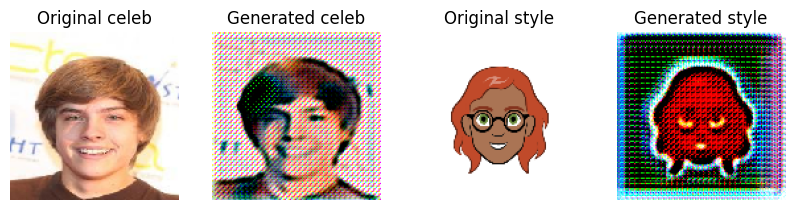

Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 1/400 [00:00<03:57,  1.68it/s]

>1, dA[0.015 ,0.005 ] dB[0.005 ,0.001] g[23.176 ,24.614]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/400 [00:01<03:55,  1.69it/s]

>2, dA[0.009 ,0.019 ] dB[0.003 ,0.001] g[25.375 ,29.540]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:55,  1.69it/s]

>3, dA[0.015 ,0.006 ] dB[0.004 ,0.002] g[28.015 ,32.316]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:53,  1.69it/s]

>4, dA[0.008 ,0.006 ] dB[0.007 ,0.003] g[21.871 ,27.577]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:52,  1.70it/s]

>5, dA[0.010 ,0.009 ] dB[0.004 ,0.002] g[25.253 ,28.350]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:51,  1.70it/s]

>6, dA[0.043 ,0.006 ] dB[0.003 ,0.002] g[20.532 ,22.612]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:51,  1.69it/s]

>7, dA[0.012 ,0.011 ] dB[0.003 ,0.002] g[22.597 ,26.958]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:52,  1.69it/s]

>8, dA[0.015 ,0.020 ] dB[0.002 ,0.001] g[19.502 ,20.343]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:51,  1.69it/s]

>9, dA[0.013 ,0.006 ] dB[0.001 ,0.001] g[22.619 ,26.288]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:53,  1.67it/s]

>10, dA[0.011 ,0.009 ] dB[0.002 ,0.001] g[26.385 ,32.323]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:53,  1.67it/s]

>11, dA[0.015 ,0.013 ] dB[0.002 ,0.003] g[25.902 ,26.334]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:51,  1.68it/s]

>12, dA[0.016 ,0.011 ] dB[0.001 ,0.005] g[27.762 ,36.493]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:49,  1.68it/s]

>13, dA[0.010 ,0.005 ] dB[0.003 ,0.000] g[23.178 ,28.996]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:48,  1.69it/s]

>14, dA[0.008 ,0.007 ] dB[0.001 ,0.000] g[24.522 ,30.050]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:48,  1.69it/s]

>15, dA[0.010 ,0.006 ] dB[0.001 ,0.001] g[23.931 ,27.448]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:47,  1.69it/s]

>16, dA[0.014 ,0.010 ] dB[0.001 ,0.001] g[25.222 ,27.248]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:46,  1.69it/s]

>17, dA[0.013 ,0.015 ] dB[0.004 ,0.000] g[19.596 ,16.767]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:45,  1.69it/s]

>18, dA[0.009 ,0.012 ] dB[0.002 ,0.001] g[30.900 ,39.857]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▍         | 19/400 [00:11<04:37,  1.37it/s]

>19, dA[0.007 ,0.008 ] dB[0.001 ,0.000] g[23.137 ,24.953]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 20/400 [00:12<04:21,  1.45it/s]

>20, dA[0.009 ,0.005 ] dB[0.001 ,0.001] g[24.359 ,29.329]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<04:10,  1.51it/s]

>21, dA[0.009 ,0.028 ] dB[0.004 ,0.005] g[23.633 ,24.944]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<04:02,  1.56it/s]

>22, dA[0.032 ,0.014 ] dB[0.003 ,0.005] g[20.205 ,21.082]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 23/400 [00:14<03:57,  1.59it/s]

>23, dA[0.010 ,0.007 ] dB[0.002 ,0.007] g[24.420 ,26.232]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:53,  1.61it/s]

>24, dA[0.012 ,0.009 ] dB[0.005 ,0.002] g[25.604 ,26.257]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:15<03:49,  1.63it/s]

>25, dA[0.016 ,0.013 ] dB[0.009 ,0.002] g[23.077 ,24.861]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:46,  1.65it/s]

>26, dA[0.011 ,0.006 ] dB[0.002 ,0.001] g[27.652 ,35.012]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:45,  1.65it/s]

>27, dA[0.016 ,0.017 ] dB[0.002 ,0.001] g[23.124 ,23.284]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [00:17<03:43,  1.66it/s]

>28, dA[0.028 ,0.018 ] dB[0.001 ,0.001] g[25.940 ,28.541]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:41,  1.67it/s]

>29, dA[0.010 ,0.005 ] dB[0.002 ,0.001] g[28.175 ,36.875]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:18<03:40,  1.68it/s]

>30, dA[0.019 ,0.010 ] dB[0.003 ,0.002] g[33.434 ,46.953]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:39,  1.68it/s]

>31, dA[0.012 ,0.006 ] dB[0.002 ,0.005] g[24.502 ,29.515]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:39,  1.68it/s]

>32, dA[0.011 ,0.011 ] dB[0.001 ,0.002] g[28.609 ,35.583]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:20<03:38,  1.68it/s]

>33, dA[0.006 ,0.004 ] dB[0.004 ,0.002] g[32.102 ,42.349]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:37,  1.68it/s]

>34, dA[0.004 ,0.012 ] dB[0.002 ,0.002] g[28.080 ,34.401]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:21<03:37,  1.68it/s]

>35, dA[0.005 ,0.006 ] dB[0.004 ,0.001] g[36.765 ,47.946]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:47,  1.60it/s]

>36, dA[0.010 ,0.012 ] dB[0.003 ,0.001] g[22.703 ,25.729]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:44,  1.61it/s]

>37, dA[0.028 ,0.011 ] dB[0.002 ,0.001] g[22.590 ,28.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:23<03:41,  1.63it/s]

>38, dA[0.015 ,0.029 ] dB[0.001 ,0.001] g[22.888 ,27.410]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:40,  1.64it/s]

>39, dA[0.006 ,0.034 ] dB[0.002 ,0.002] g[25.275 ,28.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:24<03:37,  1.65it/s]

>40, dA[0.007 ,0.021 ] dB[0.003 ,0.001] g[23.078 ,26.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:37,  1.65it/s]

>41, dA[0.009 ,0.022 ] dB[0.002 ,0.002] g[33.122 ,38.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:25<03:35,  1.66it/s]

>42, dA[0.009 ,0.007 ] dB[0.002 ,0.001] g[27.386 ,32.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:26<03:34,  1.66it/s]

>43, dA[0.014 ,0.013 ] dB[0.001 ,0.001] g[25.597 ,32.249]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:33,  1.67it/s]

>44, dA[0.007 ,0.006 ] dB[0.001 ,0.002] g[30.250 ,38.635]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 45/400 [00:27<03:32,  1.67it/s]

>45, dA[0.005 ,0.004 ] dB[0.003 ,0.000] g[29.806 ,36.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:30,  1.68it/s]

>46, dA[0.011 ,0.006 ] dB[0.003 ,0.003] g[24.828 ,24.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:30,  1.68it/s]

>47, dA[0.006 ,0.009 ] dB[0.002 ,0.002] g[26.650 ,33.475]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 48/400 [00:29<03:30,  1.67it/s]

>48, dA[0.008 ,0.010 ] dB[0.003 ,0.003] g[30.648 ,40.796]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:29,  1.68it/s]

>49, dA[0.024 ,0.005 ] dB[0.002 ,0.002] g[34.678 ,46.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:30<03:28,  1.68it/s]

>50, dA[0.008 ,0.013 ] dB[0.004 ,0.001] g[27.298 ,34.257]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:28,  1.67it/s]

>51, dA[0.007 ,0.008 ] dB[0.004 ,0.004] g[25.840 ,29.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:28,  1.67it/s]

>52, dA[0.008 ,0.006 ] dB[0.002 ,0.001] g[17.621 ,17.082]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 53/400 [00:32<03:27,  1.67it/s]

>53, dA[0.003 ,0.005 ] dB[0.002 ,0.001] g[25.607 ,29.781]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:26,  1.68it/s]

>54, dA[0.003 ,0.002 ] dB[0.003 ,0.001] g[27.549 ,33.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 55/400 [00:33<03:25,  1.67it/s]

>55, dA[0.004 ,0.003 ] dB[0.004 ,0.002] g[23.292 ,28.560]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:26,  1.67it/s]

>56, dA[0.010 ,0.005 ] dB[0.003 ,0.003] g[24.744 ,30.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:24,  1.67it/s]

>57, dA[0.005 ,0.004 ] dB[0.005 ,0.002] g[34.766 ,47.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:35<03:23,  1.68it/s]

>58, dA[0.005 ,0.003 ] dB[0.009 ,0.006] g[28.006 ,34.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:23,  1.68it/s]

>59, dA[0.005 ,0.007 ] dB[0.011 ,0.031] g[24.965 ,31.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:36<03:22,  1.68it/s]

>60, dA[0.013 ,0.006 ] dB[0.028 ,0.002] g[23.496 ,26.036]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:21,  1.68it/s]

>61, dA[0.012 ,0.004 ] dB[0.019 ,0.010] g[19.383 ,21.253]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:20,  1.69it/s]

>62, dA[0.006 ,0.002 ] dB[0.002 ,0.002] g[28.221 ,36.434]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 63/400 [00:38<03:20,  1.68it/s]

>63, dA[0.005 ,0.001 ] dB[0.003 ,0.003] g[24.337 ,27.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.69it/s]

>64, dA[0.005 ,0.004 ] dB[0.001 ,0.006] g[24.816 ,29.699]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 65/400 [00:39<03:18,  1.69it/s]

>65, dA[0.003 ,0.005 ] dB[0.006 ,0.001] g[27.763 ,34.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:17,  1.69it/s]

>66, dA[0.006 ,0.011 ] dB[0.004 ,0.003] g[24.471 ,29.019]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:17,  1.69it/s]

>67, dA[0.003 ,0.006 ] dB[0.002 ,0.002] g[22.170 ,23.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:41<03:16,  1.69it/s]

>68, dA[0.003 ,0.005 ] dB[0.010 ,0.007] g[26.533 ,33.365]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:16,  1.69it/s]

>69, dA[0.009 ,0.006 ] dB[0.020 ,0.012] g[27.498 ,33.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 70/400 [00:42<03:15,  1.69it/s]

>70, dA[0.010 ,0.005 ] dB[0.045 ,0.009] g[28.256 ,34.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:15,  1.69it/s]

>71, dA[0.004 ,0.004 ] dB[0.054 ,0.014] g[28.437 ,37.893]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:15,  1.68it/s]

>72, dA[0.005 ,0.002 ] dB[0.032 ,0.007] g[35.574 ,50.642]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:14,  1.68it/s]

>73, dA[0.015 ,0.002 ] dB[0.018 ,0.002] g[27.754 ,34.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:13,  1.69it/s]

>74, dA[0.007 ,0.004 ] dB[0.040 ,0.006] g[24.729 ,29.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:45<03:24,  1.59it/s]

>75, dA[0.005 ,0.002 ] dB[0.064 ,0.014] g[28.681 ,36.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:20,  1.61it/s]

>76, dA[0.024 ,0.014 ] dB[0.102 ,0.018] g[19.008 ,15.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:17,  1.63it/s]

>77, dA[0.007 ,0.009 ] dB[0.207 ,0.038] g[25.926 ,27.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:47<03:15,  1.65it/s]

>78, dA[0.007 ,0.009 ] dB[0.165 ,0.020] g[22.713 ,25.895]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:14,  1.65it/s]

>79, dA[0.007 ,0.004 ] dB[0.048 ,0.002] g[24.041 ,26.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:48<03:12,  1.66it/s]

>80, dA[0.007 ,0.010 ] dB[0.038 ,0.001] g[34.201 ,46.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:11,  1.67it/s]

>81, dA[0.008 ,0.009 ] dB[0.009 ,0.012] g[25.049 ,26.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:49<03:10,  1.67it/s]

>82, dA[0.008 ,0.005 ] dB[0.003 ,0.008] g[26.792 ,30.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:50<03:09,  1.67it/s]

>83, dA[0.014 ,0.009 ] dB[0.007 ,0.002] g[24.934 ,26.704]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [00:50<03:08,  1.67it/s]

>84, dA[0.014 ,0.006 ] dB[0.003 ,0.001] g[20.306 ,20.899]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 85/400 [00:51<03:07,  1.68it/s]

>85, dA[0.009 ,0.004 ] dB[0.003 ,0.003] g[28.177 ,34.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:07,  1.67it/s]

>86, dA[0.011 ,0.004 ] dB[0.010 ,0.006] g[27.731 ,32.381]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:08,  1.66it/s]

>87, dA[0.013 ,0.015 ] dB[0.007 ,0.001] g[29.542 ,38.518]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 88/400 [00:53<03:10,  1.64it/s]

>88, dA[0.011 ,0.009 ] dB[0.003 ,0.001] g[34.054 ,49.843]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:09,  1.64it/s]

>89, dA[0.018 ,0.020 ] dB[0.002 ,0.001] g[19.623 ,20.921]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▎       | 90/400 [00:54<03:08,  1.64it/s]

>90, dA[0.011 ,0.011 ] dB[0.002 ,0.001] g[21.074 ,23.175]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:08,  1.64it/s]

>91, dA[0.010 ,0.008 ] dB[0.005 ,0.008] g[30.351 ,37.153]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:55<03:07,  1.64it/s]

>92, dA[0.029 ,0.004 ] dB[0.001 ,0.003] g[26.815 ,32.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:56<03:05,  1.66it/s]

>93, dA[0.041 ,0.003 ] dB[0.005 ,0.008] g[23.565 ,29.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:03,  1.67it/s]

>94, dA[0.011 ,0.010 ] dB[0.001 ,0.007] g[32.697 ,46.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:57<03:02,  1.67it/s]

>95, dA[0.020 ,0.010 ] dB[0.006 ,0.002] g[27.194 ,32.803]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:01,  1.67it/s]

>96, dA[0.012 ,0.006 ] dB[0.005 ,0.003] g[26.465 ,29.810]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:58<03:00,  1.68it/s]

>97, dA[0.016 ,0.008 ] dB[0.005 ,0.001] g[23.637 ,25.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:59<02:59,  1.68it/s]

>98, dA[0.005 ,0.005 ] dB[0.012 ,0.005] g[27.804 ,36.521]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:59<02:59,  1.68it/s]

>99, dA[0.009 ,0.010 ] dB[0.012 ,0.004] g[28.542 ,36.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [01:00<02:58,  1.68it/s]

>100, dA[0.010 ,0.007 ] dB[0.015 ,0.005] g[20.315 ,21.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:57,  1.68it/s]

>101, dA[0.017 ,0.003 ] dB[0.004 ,0.003] g[23.075 ,25.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 102/400 [01:01<02:57,  1.68it/s]

>102, dA[0.012 ,0.002 ] dB[0.004 ,0.002] g[27.878 ,33.086]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:02<02:57,  1.68it/s]

>103, dA[0.011 ,0.005 ] dB[0.003 ,0.001] g[26.613 ,32.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:56,  1.68it/s]

>104, dA[0.008 ,0.007 ] dB[0.001 ,0.001] g[21.827 ,25.544]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 105/400 [01:03<02:55,  1.68it/s]

>105, dA[0.006 ,0.014 ] dB[0.002 ,0.001] g[23.414 ,26.842]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:55,  1.67it/s]

>106, dA[0.005 ,0.009 ] dB[0.003 ,0.001] g[23.974 ,25.648]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:04<02:55,  1.67it/s]

>107, dA[0.005 ,0.003 ] dB[0.003 ,0.001] g[29.709 ,38.187]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:05<02:54,  1.67it/s]

>108, dA[0.006 ,0.013 ] dB[0.003 ,0.001] g[24.704 ,29.788]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:53,  1.68it/s]

>109, dA[0.014 ,0.026 ] dB[0.004 ,0.002] g[35.989 ,51.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:06<02:52,  1.68it/s]

>110, dA[0.019 ,0.041 ] dB[0.004 ,0.004] g[21.048 ,21.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:52,  1.68it/s]

>111, dA[0.005 ,0.008 ] dB[0.007 ,0.003] g[24.686 ,29.210]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 112/400 [01:07<02:51,  1.68it/s]

>112, dA[0.005 ,0.002 ] dB[0.008 ,0.009] g[34.383 ,48.901]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:08<02:51,  1.68it/s]

>113, dA[0.005 ,0.007 ] dB[0.008 ,0.003] g[32.352 ,41.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:50,  1.68it/s]

>114, dA[0.006 ,0.006 ] dB[0.008 ,0.005] g[31.118 ,43.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:09<02:49,  1.68it/s]

>115, dA[0.006 ,0.009 ] dB[0.005 ,0.002] g[22.999 ,28.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:49,  1.68it/s]

>116, dA[0.018 ,0.003 ] dB[0.004 ,0.003] g[20.894 ,20.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:48,  1.68it/s]

>117, dA[0.018 ,0.005 ] dB[0.003 ,0.004] g[25.667 ,29.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:11<02:47,  1.68it/s]

>118, dA[0.010 ,0.004 ] dB[0.007 ,0.004] g[36.590 ,45.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:47,  1.68it/s]

>119, dA[0.022 ,0.006 ] dB[0.005 ,0.001] g[24.797 ,25.192]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:12<02:46,  1.68it/s]

>120, dA[0.006 ,0.013 ] dB[0.002 ,0.003] g[21.316 ,23.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:12<02:45,  1.68it/s]

>121, dA[0.003 ,0.004 ] dB[0.004 ,0.002] g[27.175 ,33.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [01:13<02:45,  1.68it/s]

>122, dA[0.014 ,0.003 ] dB[0.007 ,0.001] g[19.672 ,17.911]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 123/400 [01:13<02:45,  1.68it/s]

>123, dA[0.013 ,0.003 ] dB[0.008 ,0.007] g[31.324 ,44.116]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [01:14<02:44,  1.68it/s]

>124, dA[0.004 ,0.003 ] dB[0.009 ,0.003] g[27.785 ,37.845]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:15<02:52,  1.59it/s]

>125, dA[0.004 ,0.005 ] dB[0.010 ,0.003] g[24.721 ,28.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:48,  1.62it/s]

>126, dA[0.008 ,0.002 ] dB[0.006 ,0.004] g[33.288 ,45.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:16<02:46,  1.64it/s]

>127, dA[0.007 ,0.006 ] dB[0.005 ,0.001] g[22.196 ,25.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:17<02:44,  1.65it/s]

>128, dA[0.004 ,0.006 ] dB[0.004 ,0.002] g[25.223 ,29.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:17<02:42,  1.67it/s]

>129, dA[0.006 ,0.003 ] dB[0.002 ,0.003] g[33.140 ,44.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:18<02:41,  1.68it/s]

>130, dA[0.006 ,0.002 ] dB[0.003 ,0.003] g[25.410 ,29.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:40,  1.68it/s]

>131, dA[0.006 ,0.006 ] dB[0.002 ,0.005] g[39.959 ,58.063]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 132/400 [01:19<02:39,  1.68it/s]

>132, dA[0.007 ,0.005 ] dB[0.002 ,0.001] g[21.687 ,22.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:20<02:38,  1.69it/s]

>133, dA[0.005 ,0.004 ] dB[0.001 ,0.001] g[24.791 ,31.137]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 134/400 [01:20<02:37,  1.69it/s]

>134, dA[0.008 ,0.005 ] dB[0.002 ,0.003] g[30.164 ,36.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:21<02:37,  1.69it/s]

>135, dA[0.004 ,0.003 ] dB[0.003 ,0.001] g[28.814 ,38.025]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:36,  1.69it/s]

>136, dA[0.003 ,0.006 ] dB[0.002 ,0.000] g[30.498 ,35.125]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 137/400 [01:22<02:35,  1.69it/s]

>137, dA[0.006 ,0.002 ] dB[0.002 ,0.001] g[33.791 ,44.800]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:35,  1.68it/s]

>138, dA[0.006 ,0.005 ] dB[0.003 ,0.000] g[31.191 ,43.073]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:23<02:35,  1.67it/s]

>139, dA[0.006 ,0.002 ] dB[0.001 ,0.000] g[22.946 ,29.158]
1/1 [==============================] - 0s 30ms/step



Batchs:  35%|███▌      | 140/400 [01:24<02:37,  1.65it/s]

>140, dA[0.007 ,0.004 ] dB[0.003 ,0.001] g[29.270 ,39.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:37,  1.65it/s]

>141, dA[0.003 ,0.002 ] dB[0.004 ,0.000] g[21.084 ,23.544]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 142/400 [01:25<02:36,  1.65it/s]

>142, dA[0.214 ,0.074 ] dB[0.002 ,0.002] g[18.752 ,20.169]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 143/400 [01:26<02:35,  1.65it/s]

>143, dA[0.016 ,0.015 ] dB[0.001 ,0.001] g[28.071 ,35.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 144/400 [01:26<02:34,  1.66it/s]

>144, dA[0.030 ,0.048 ] dB[0.004 ,0.001] g[24.064 ,23.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:27<02:32,  1.67it/s]

>145, dA[0.030 ,0.051 ] dB[0.010 ,0.014] g[34.476 ,46.943]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:31,  1.68it/s]

>146, dA[0.020 ,0.036 ] dB[0.017 ,0.009] g[20.645 ,20.361]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [01:28<02:31,  1.67it/s]

>147, dA[0.036 ,0.013 ] dB[0.068 ,0.036] g[29.345 ,39.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:29<02:30,  1.67it/s]

>148, dA[0.092 ,0.033 ] dB[0.056 ,0.034] g[22.165 ,25.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:29<02:29,  1.68it/s]

>149, dA[0.018 ,0.136 ] dB[0.030 ,0.048] g[29.924 ,37.478]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 150/400 [01:30<02:28,  1.68it/s]

>150, dA[0.064 ,0.102 ] dB[0.007 ,0.011] g[29.784 ,40.635]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:28,  1.68it/s]

>151, dA[0.063 ,0.046 ] dB[0.013 ,0.021] g[31.000 ,39.684]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:31<02:27,  1.68it/s]

>152, dA[0.045 ,0.048 ] dB[0.012 ,0.011] g[24.408 ,26.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:26,  1.68it/s]

>153, dA[0.015 ,0.038 ] dB[0.023 ,0.009] g[33.768 ,46.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 154/400 [01:32<02:26,  1.68it/s]

>154, dA[0.011 ,0.018 ] dB[0.022 ,0.005] g[27.875 ,29.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:33<02:26,  1.68it/s]

>155, dA[0.016 ,0.014 ] dB[0.031 ,0.018] g[26.615 ,33.095]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:25,  1.68it/s]

>156, dA[0.023 ,0.010 ] dB[0.024 ,0.003] g[28.740 ,35.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:34<02:24,  1.68it/s]

>157, dA[0.015 ,0.007 ] dB[0.015 ,0.009] g[26.093 ,34.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:25,  1.67it/s]

>158, dA[0.010 ,0.005 ] dB[0.003 ,0.007] g[32.000 ,45.926]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:35<02:24,  1.67it/s]

>159, dA[0.007 ,0.011 ] dB[0.006 ,0.001] g[26.890 ,33.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:36<02:23,  1.67it/s]

>160, dA[0.015 ,0.009 ] dB[0.015 ,0.007] g[25.833 ,30.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [01:36<02:22,  1.68it/s]

>161, dA[0.007 ,0.014 ] dB[0.009 ,0.008] g[25.110 ,30.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:37<02:21,  1.68it/s]

>162, dA[0.006 ,0.011 ] dB[0.015 ,0.006] g[25.347 ,33.891]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:37<02:20,  1.68it/s]

>163, dA[0.024 ,0.013 ] dB[0.022 ,0.007] g[36.375 ,52.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 164/400 [01:38<02:20,  1.68it/s]

>164, dA[0.015 ,0.010 ] dB[0.007 ,0.002] g[21.992 ,24.330]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 165/400 [01:39<02:19,  1.68it/s]

>165, dA[0.017 ,0.008 ] dB[0.006 ,0.001] g[18.339 ,17.136]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:19,  1.68it/s]

>166, dA[0.014 ,0.007 ] dB[0.007 ,0.008] g[29.481 ,37.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:40<02:18,  1.68it/s]

>167, dA[0.010 ,0.006 ] dB[0.004 ,0.002] g[21.936 ,26.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:17,  1.68it/s]

>168, dA[0.011 ,0.002 ] dB[0.008 ,0.002] g[26.430 ,31.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [01:41<02:17,  1.69it/s]

>169, dA[0.010 ,0.004 ] dB[0.009 ,0.010] g[34.891 ,50.139]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▎     | 170/400 [01:42<02:16,  1.69it/s]

>170, dA[0.010 ,0.006 ] dB[0.006 ,0.003] g[21.313 ,25.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:16,  1.68it/s]

>171, dA[0.006 ,0.012 ] dB[0.006 ,0.001] g[28.517 ,34.251]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 172/400 [01:43<02:15,  1.68it/s]

>172, dA[0.008 ,0.010 ] dB[0.004 ,0.002] g[23.521 ,23.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:14,  1.68it/s]

>173, dA[0.007 ,0.003 ] dB[0.006 ,0.002] g[24.937 ,30.478]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:44<02:13,  1.69it/s]

>174, dA[0.012 ,0.005 ] dB[0.003 ,0.002] g[20.299 ,18.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 175/400 [01:45<02:13,  1.68it/s]

>175, dA[0.010 ,0.008 ] dB[0.004 ,0.005] g[28.015 ,36.547]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:13,  1.68it/s]

>176, dA[0.004 ,0.005 ] dB[0.004 ,0.003] g[24.824 ,29.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:46<02:12,  1.68it/s]

>177, dA[0.010 ,0.002 ] dB[0.001 ,0.001] g[22.294 ,24.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:11,  1.69it/s]

>178, dA[0.005 ,0.002 ] dB[0.003 ,0.004] g[27.508 ,33.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:47<02:11,  1.68it/s]

>179, dA[0.006 ,0.008 ] dB[0.002 ,0.002] g[28.790 ,36.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:48<02:10,  1.68it/s]

>180, dA[0.005 ,0.004 ] dB[0.001 ,0.001] g[25.615 ,32.629]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:10,  1.68it/s]

>181, dA[0.008 ,0.006 ] dB[0.003 ,0.001] g[20.025 ,19.171]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:49<02:09,  1.69it/s]

>182, dA[0.005 ,0.001 ] dB[0.003 ,0.002] g[27.306 ,31.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:09,  1.68it/s]

>183, dA[0.005 ,0.003 ] dB[0.003 ,0.002] g[23.783 ,29.035]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:50<02:08,  1.68it/s]

>184, dA[0.011 ,0.004 ] dB[0.003 ,0.000] g[18.757 ,18.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:51<02:07,  1.69it/s]

>185, dA[0.004 ,0.001 ] dB[0.001 ,0.001] g[26.088 ,27.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:06,  1.69it/s]

>186, dA[0.148 ,0.027 ] dB[0.003 ,0.003] g[20.464 ,20.897]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 187/400 [01:52<02:06,  1.68it/s]

>187, dA[0.008 ,0.010 ] dB[0.002 ,0.002] g[21.977 ,25.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.68it/s]

>188, dA[0.011 ,0.015 ] dB[0.004 ,0.000] g[33.248 ,46.766]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 189/400 [01:53<02:06,  1.67it/s]

>189, dA[0.012 ,0.011 ] dB[0.002 ,0.001] g[25.305 ,33.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:05,  1.68it/s]

>190, dA[0.027 ,0.005 ] dB[0.002 ,0.002] g[36.631 ,51.487]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:04,  1.68it/s]

>191, dA[0.024 ,0.007 ] dB[0.005 ,0.001] g[23.946 ,29.354]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 192/400 [01:55<02:07,  1.63it/s]

>192, dA[0.015 ,0.008 ] dB[0.004 ,0.002] g[21.829 ,26.113]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:06,  1.64it/s]

>193, dA[0.013 ,0.009 ] dB[0.006 ,0.002] g[25.188 ,27.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:56<02:04,  1.65it/s]

>194, dA[0.017 ,0.025 ] dB[0.007 ,0.002] g[22.949 ,28.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:57<02:03,  1.66it/s]

>195, dA[0.007 ,0.035 ] dB[0.005 ,0.004] g[25.449 ,27.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:57<02:02,  1.66it/s]

>196, dA[0.012 ,0.023 ] dB[0.004 ,0.003] g[26.760 ,33.339]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [01:58<02:01,  1.67it/s]

>197, dA[0.013 ,0.011 ] dB[0.005 ,0.004] g[21.663 ,25.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:00,  1.68it/s]

>198, dA[0.011 ,0.006 ] dB[0.002 ,0.001] g[22.135 ,26.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:59<01:59,  1.68it/s]

>199, dA[0.008 ,0.004 ] dB[0.002 ,0.001] g[28.105 ,35.381]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [02:00<01:59,  1.68it/s]

>200, dA[0.011 ,0.008 ] dB[0.004 ,0.004] g[23.456 ,24.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 201/400 [02:00<01:58,  1.68it/s]

>201, dA[0.007 ,0.002 ] dB[0.008 ,0.005] g[35.685 ,39.965]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [02:01<01:57,  1.69it/s]

>202, dA[0.007 ,0.003 ] dB[0.006 ,0.009] g[33.598 ,46.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:56,  1.68it/s]

>203, dA[0.011 ,0.007 ] dB[0.012 ,0.005] g[21.920 ,23.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:02<01:56,  1.69it/s]

>204, dA[0.009 ,0.014 ] dB[0.019 ,0.005] g[22.240 ,23.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:55,  1.69it/s]

>205, dA[0.016 ,0.013 ] dB[0.011 ,0.008] g[31.036 ,39.422]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [02:03<01:55,  1.68it/s]

>206, dA[0.022 ,0.030 ] dB[0.003 ,0.008] g[33.063 ,44.022]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:04<01:54,  1.68it/s]

>207, dA[0.009 ,0.012 ] dB[0.003 ,0.005] g[28.317 ,35.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:54,  1.68it/s]

>208, dA[0.013 ,0.006 ] dB[0.004 ,0.002] g[22.073 ,23.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:05<01:53,  1.68it/s]

>209, dA[0.005 ,0.014 ] dB[0.003 ,0.002] g[22.503 ,23.811]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:52,  1.68it/s]

>210, dA[0.014 ,0.004 ] dB[0.004 ,0.003] g[22.216 ,27.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:06<01:52,  1.68it/s]

>211, dA[0.022 ,0.016 ] dB[0.002 ,0.002] g[26.611 ,34.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:07<01:51,  1.68it/s]

>212, dA[0.009 ,0.013 ] dB[0.002 ,0.001] g[22.547 ,26.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:50,  1.69it/s]

>213, dA[0.009 ,0.008 ] dB[0.003 ,0.002] g[21.293 ,22.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:08<01:49,  1.69it/s]

>214, dA[0.019 ,0.009 ] dB[0.001 ,0.002] g[31.423 ,44.870]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:50,  1.68it/s]

>215, dA[0.008 ,0.005 ] dB[0.004 ,0.005] g[30.024 ,30.144]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:09<01:49,  1.68it/s]

>216, dA[0.004 ,0.015 ] dB[0.005 ,0.005] g[20.187 ,23.036]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:10<01:48,  1.68it/s]

>217, dA[0.014 ,0.004 ] dB[0.007 ,0.002] g[24.072 ,26.615]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:47,  1.69it/s]

>218, dA[0.014 ,0.002 ] dB[0.009 ,0.001] g[25.099 ,29.288]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 219/400 [02:11<01:47,  1.68it/s]

>219, dA[0.007 ,0.004 ] dB[0.007 ,0.007] g[31.539 ,41.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:47,  1.67it/s]

>220, dA[0.011 ,0.008 ] dB[0.004 ,0.003] g[18.576 ,17.829]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 221/400 [02:12<01:47,  1.67it/s]

>221, dA[0.008 ,0.010 ] dB[0.014 ,0.002] g[23.391 ,29.134]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 222/400 [02:13<01:46,  1.67it/s]

>222, dA[0.010 ,0.007 ] dB[0.016 ,0.007] g[27.923 ,35.060]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:46,  1.66it/s]

>223, dA[0.010 ,0.009 ] dB[0.022 ,0.008] g[22.870 ,27.330]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [02:14<01:45,  1.67it/s]

>224, dA[0.014 ,0.008 ] dB[0.030 ,0.007] g[26.457 ,34.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:44,  1.67it/s]

>225, dA[0.007 ,0.008 ] dB[0.013 ,0.003] g[27.818 ,37.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:15<01:44,  1.66it/s]

>226, dA[0.003 ,0.005 ] dB[0.013 ,0.002] g[24.510 ,28.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:16<01:44,  1.66it/s]

>227, dA[0.013 ,0.003 ] dB[0.011 ,0.003] g[19.468 ,19.734]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:43,  1.67it/s]

>228, dA[0.004 ,0.004 ] dB[0.005 ,0.004] g[22.274 ,26.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:17<01:42,  1.67it/s]

>229, dA[0.007 ,0.007 ] dB[0.003 ,0.002] g[28.411 ,38.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.68it/s]

>230, dA[0.007 ,0.007 ] dB[0.002 ,0.001] g[22.321 ,26.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:18<01:40,  1.68it/s]

>231, dA[0.003 ,0.003 ] dB[0.004 ,0.002] g[26.840 ,29.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:19<01:39,  1.68it/s]

>232, dA[0.005 ,0.005 ] dB[0.003 ,0.002] g[26.431 ,34.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:44,  1.59it/s]

>233, dA[0.004 ,0.002 ] dB[0.003 ,0.001] g[36.401 ,46.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:20<01:42,  1.62it/s]

>234, dA[0.008 ,0.004 ] dB[0.002 ,0.003] g[22.914 ,23.436]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:41,  1.63it/s]

>235, dA[0.004 ,0.007 ] dB[0.002 ,0.001] g[20.913 ,24.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:21<01:39,  1.65it/s]

>236, dA[0.004 ,0.013 ] dB[0.003 ,0.004] g[21.340 ,23.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:22<01:38,  1.66it/s]

>237, dA[0.007 ,0.006 ] dB[0.003 ,0.004] g[27.751 ,39.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:36,  1.67it/s]

>238, dA[0.007 ,0.005 ] dB[0.002 ,0.001] g[24.084 ,26.842]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [02:23<01:36,  1.66it/s]

>239, dA[0.014 ,0.012 ] dB[0.002 ,0.001] g[29.014 ,37.251]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:36,  1.65it/s]

>240, dA[0.014 ,0.010 ] dB[0.002 ,0.001] g[26.736 ,33.119]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 241/400 [02:24<01:35,  1.66it/s]

>241, dA[0.010 ,0.003 ] dB[0.002 ,0.002] g[24.524 ,28.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:25<01:35,  1.65it/s]

>242, dA[0.008 ,0.002 ] dB[0.002 ,0.004] g[27.257 ,33.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:25<01:34,  1.66it/s]

>243, dA[0.007 ,0.003 ] dB[0.003 ,0.003] g[22.021 ,23.075]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 244/400 [02:26<01:34,  1.65it/s]

>244, dA[0.007 ,0.006 ] dB[0.004 ,0.004] g[23.888 ,27.899]
1/1 [==============================] - 0s 29ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:34,  1.64it/s]

>245, dA[0.005 ,0.005 ] dB[0.002 ,0.000] g[22.151 ,24.191]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 246/400 [02:27<01:32,  1.66it/s]

>246, dA[0.003 ,0.006 ] dB[0.004 ,0.004] g[23.463 ,25.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [02:28<01:32,  1.66it/s]

>247, dA[0.003 ,0.003 ] dB[0.002 ,0.001] g[22.877 ,23.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [02:28<01:31,  1.67it/s]

>248, dA[0.009 ,0.004 ] dB[0.001 ,0.001] g[28.684 ,36.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [02:29<01:30,  1.67it/s]

>249, dA[0.005 ,0.008 ] dB[0.002 ,0.001] g[28.070 ,31.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:29,  1.68it/s]

>250, dA[0.012 ,0.006 ] dB[0.002 ,0.001] g[19.278 ,18.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:30<01:29,  1.67it/s]

>251, dA[0.011 ,0.006 ] dB[0.002 ,0.001] g[24.028 ,26.216]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 252/400 [02:31<01:28,  1.67it/s]

>252, dA[0.005 ,0.003 ] dB[0.004 ,0.001] g[18.164 ,16.964]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 253/400 [02:31<01:27,  1.68it/s]

>253, dA[0.007 ,0.005 ] dB[0.005 ,0.001] g[27.717 ,37.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:32<01:27,  1.68it/s]

>254, dA[0.009 ,0.005 ] dB[0.007 ,0.000] g[35.888 ,50.482]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:26,  1.67it/s]

>255, dA[0.006 ,0.003 ] dB[0.006 ,0.002] g[28.043 ,34.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:33<01:26,  1.67it/s]

>256, dA[0.029 ,0.008 ] dB[0.005 ,0.001] g[31.921 ,43.090]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 257/400 [02:34<01:25,  1.67it/s]

>257, dA[0.049 ,0.017 ] dB[0.009 ,0.002] g[25.302 ,33.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:34<01:24,  1.67it/s]

>258, dA[0.038 ,0.018 ] dB[0.008 ,0.001] g[28.203 ,35.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:35<01:24,  1.66it/s]

>259, dA[0.016 ,0.020 ] dB[0.003 ,0.001] g[36.795 ,53.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:23,  1.67it/s]

>260, dA[0.021 ,0.013 ] dB[0.004 ,0.004] g[27.341 ,34.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:36<01:23,  1.67it/s]

>261, dA[0.025 ,0.027 ] dB[0.003 ,0.006] g[20.777 ,21.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [02:37<01:22,  1.68it/s]

>262, dA[0.013 ,0.007 ] dB[0.006 ,0.002] g[34.175 ,46.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:37<01:21,  1.68it/s]

>263, dA[0.013 ,0.007 ] dB[0.004 ,0.002] g[22.370 ,26.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 264/400 [02:38<01:20,  1.68it/s]

>264, dA[0.009 ,0.005 ] dB[0.002 ,0.001] g[27.606 ,33.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:20,  1.69it/s]

>265, dA[0.010 ,0.010 ] dB[0.002 ,0.002] g[26.915 ,31.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:39<01:19,  1.69it/s]

>266, dA[0.003 ,0.005 ] dB[0.002 ,0.007] g[33.917 ,46.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:40<01:18,  1.68it/s]

>267, dA[0.006 ,0.006 ] dB[0.002 ,0.003] g[25.286 ,30.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 268/400 [02:40<01:18,  1.68it/s]

>268, dA[0.006 ,0.006 ] dB[0.003 ,0.001] g[31.616 ,42.336]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 269/400 [02:41<01:17,  1.68it/s]

>269, dA[0.009 ,0.004 ] dB[0.002 ,0.000] g[33.985 ,46.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:17,  1.69it/s]

>270, dA[0.007 ,0.004 ] dB[0.003 ,0.007] g[33.738 ,46.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:42<01:16,  1.69it/s]

>271, dA[0.004 ,0.005 ] dB[0.003 ,0.001] g[21.545 ,24.572]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 272/400 [02:43<01:16,  1.68it/s]

>272, dA[0.002 ,0.001 ] dB[0.002 ,0.004] g[25.985 ,31.670]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 273/400 [02:43<01:15,  1.68it/s]

>273, dA[0.003 ,0.004 ] dB[0.007 ,0.002] g[27.151 ,33.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:44<01:14,  1.69it/s]

>274, dA[0.006 ,0.003 ] dB[0.008 ,0.004] g[33.677 ,45.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:14,  1.69it/s]

>275, dA[0.006 ,0.002 ] dB[0.003 ,0.001] g[19.489 ,21.270]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 276/400 [02:45<01:14,  1.67it/s]

>276, dA[0.004 ,0.003 ] dB[0.003 ,0.002] g[22.079 ,26.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:46<01:13,  1.68it/s]

>277, dA[0.002 ,0.004 ] dB[0.003 ,0.002] g[29.094 ,35.143]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 278/400 [02:46<01:12,  1.68it/s]

>278, dA[0.005 ,0.002 ] dB[0.006 ,0.009] g[20.743 ,23.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:47<01:12,  1.67it/s]

>279, dA[0.004 ,0.002 ] dB[0.004 ,0.002] g[26.361 ,33.090]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:11,  1.67it/s]

>280, dA[0.009 ,0.001 ] dB[0.001 ,0.001] g[30.575 ,40.627]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 281/400 [02:48<01:11,  1.68it/s]

>281, dA[0.004 ,0.005 ] dB[0.001 ,0.000] g[23.001 ,27.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:49<01:10,  1.68it/s]

>282, dA[0.002 ,0.002 ] dB[0.001 ,0.000] g[21.960 ,24.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 283/400 [02:49<01:09,  1.68it/s]

>283, dA[0.003 ,0.002 ] dB[0.002 ,0.000] g[30.593 ,41.325]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [02:50<01:09,  1.68it/s]

>284, dA[0.005 ,0.002 ] dB[0.002 ,0.007] g[34.374 ,50.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:08,  1.69it/s]

>285, dA[0.005 ,0.003 ] dB[0.010 ,0.005] g[23.723 ,24.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:51<01:07,  1.69it/s]

>286, dA[0.004 ,0.003 ] dB[0.018 ,0.008] g[32.735 ,46.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:52<01:07,  1.68it/s]

>287, dA[0.002 ,0.003 ] dB[0.011 ,0.006] g[29.353 ,37.284]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:52<01:06,  1.68it/s]

>288, dA[0.008 ,0.004 ] dB[0.019 ,0.011] g[19.887 ,20.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 289/400 [02:53<01:05,  1.69it/s]

>289, dA[0.003 ,0.001 ] dB[0.008 ,0.014] g[32.612 ,42.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:05,  1.68it/s]

>290, dA[0.008 ,0.003 ] dB[0.002 ,0.004] g[21.273 ,22.255]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 291/400 [02:54<01:05,  1.67it/s]

>291, dA[0.002 ,0.003 ] dB[0.002 ,0.001] g[21.499 ,22.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 292/400 [02:55<01:04,  1.67it/s]

>292, dA[0.004 ,0.001 ] dB[0.001 ,0.000] g[21.677 ,23.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:55<01:03,  1.68it/s]

>293, dA[0.004 ,0.002 ] dB[0.002 ,0.001] g[27.478 ,36.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:56<01:03,  1.68it/s]

>294, dA[0.004 ,0.003 ] dB[0.002 ,0.001] g[32.599 ,42.944]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:02,  1.68it/s]

>295, dA[0.005 ,0.002 ] dB[0.002 ,0.000] g[24.016 ,27.966]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 296/400 [02:57<01:01,  1.68it/s]

>296, dA[0.010 ,0.002 ] dB[0.002 ,0.004] g[36.090 ,51.479]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:01,  1.67it/s]

>297, dA[0.005 ,0.003 ] dB[0.006 ,0.001] g[33.392 ,44.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 298/400 [02:58<01:00,  1.67it/s]

>298, dA[0.004 ,0.007 ] dB[0.003 ,0.001] g[24.264 ,28.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:59<01:00,  1.67it/s]

>299, dA[0.008 ,0.003 ] dB[0.003 ,0.009] g[20.295 ,20.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<00:59,  1.68it/s]

>300, dA[0.005 ,0.005 ] dB[0.013 ,0.008] g[34.179 ,49.336]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 301/400 [03:00<00:58,  1.68it/s]

>301, dA[0.003 ,0.004 ] dB[0.024 ,0.015] g[23.421 ,31.474]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:58,  1.69it/s]

>302, dA[0.004 ,0.004 ] dB[0.020 ,0.008] g[21.592 ,24.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:01<00:57,  1.68it/s]

>303, dA[0.004 ,0.006 ] dB[0.032 ,0.035] g[27.893 ,35.370]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:02<00:56,  1.68it/s]

>304, dA[0.005 ,0.005 ] dB[0.016 ,0.067] g[28.685 ,38.465]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:56,  1.69it/s]

>305, dA[0.004 ,0.008 ] dB[0.054 ,0.009] g[22.470 ,27.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:03<00:55,  1.69it/s]

>306, dA[0.005 ,0.005 ] dB[0.082 ,0.043] g[23.394 ,26.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:55,  1.68it/s]

>307, dA[0.004 ,0.006 ] dB[0.028 ,0.006] g[27.735 ,32.855]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:04<00:54,  1.68it/s]

>308, dA[0.004 ,0.006 ] dB[0.034 ,0.008] g[24.459 ,30.539]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 309/400 [03:05<00:54,  1.68it/s]

>309, dA[0.002 ,0.009 ] dB[0.067 ,0.016] g[36.480 ,48.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:53,  1.68it/s]

>310, dA[0.003 ,0.007 ] dB[0.069 ,0.018] g[31.412 ,42.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:06<00:52,  1.68it/s]

>311, dA[0.012 ,0.004 ] dB[0.042 ,0.008] g[22.034 ,26.133]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.68it/s]

>312, dA[0.005 ,0.006 ] dB[0.015 ,0.008] g[31.066 ,43.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:07<00:51,  1.68it/s]

>313, dA[0.008 ,0.001 ] dB[0.016 ,0.005] g[27.881 ,34.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:08<00:51,  1.69it/s]

>314, dA[0.002 ,0.006 ] dB[0.012 ,0.030] g[24.820 ,27.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:50,  1.68it/s]

>315, dA[0.003 ,0.004 ] dB[0.015 ,0.023] g[24.782 ,31.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:09<00:49,  1.68it/s]

>316, dA[0.004 ,0.003 ] dB[0.008 ,0.006] g[24.503 ,29.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.69it/s]

>317, dA[0.007 ,0.004 ] dB[0.006 ,0.010] g[24.088 ,26.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [03:10<00:48,  1.69it/s]

>318, dA[0.003 ,0.002 ] dB[0.005 ,0.003] g[28.367 ,34.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:11<00:48,  1.69it/s]

>319, dA[0.002 ,0.004 ] dB[0.022 ,0.006] g[27.370 ,34.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:47,  1.69it/s]

>320, dA[0.003 ,0.002 ] dB[0.016 ,0.015] g[27.600 ,33.661]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:12<00:46,  1.69it/s]

>321, dA[0.002 ,0.003 ] dB[0.018 ,0.008] g[32.393 ,44.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.69it/s]

>322, dA[0.002 ,0.002 ] dB[0.012 ,0.016] g[24.428 ,27.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:13<00:45,  1.68it/s]

>323, dA[0.008 ,0.007 ] dB[0.011 ,0.012] g[29.649 ,40.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:14<00:45,  1.68it/s]

>324, dA[0.012 ,0.004 ] dB[0.021 ,0.016] g[19.298 ,22.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:14<00:44,  1.68it/s]

>325, dA[0.007 ,0.002 ] dB[0.007 ,0.014] g[30.131 ,39.249]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:15<00:44,  1.68it/s]

>326, dA[0.006 ,0.006 ] dB[0.031 ,0.010] g[26.494 ,31.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.68it/s]

>327, dA[0.007 ,0.007 ] dB[0.022 ,0.012] g[26.626 ,30.403]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 328/400 [03:16<00:42,  1.68it/s]

>328, dA[0.007 ,0.015 ] dB[0.011 ,0.006] g[29.640 ,36.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.68it/s]

>329, dA[0.006 ,0.007 ] dB[0.008 ,0.022] g[26.641 ,31.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:41,  1.69it/s]

>330, dA[0.005 ,0.004 ] dB[0.087 ,0.020] g[31.428 ,44.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:18<00:40,  1.68it/s]

>331, dA[0.005 ,0.004 ] dB[0.138 ,0.056] g[32.471 ,37.056]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:40,  1.69it/s]

>332, dA[0.006 ,0.006 ] dB[0.078 ,0.104] g[30.469 ,36.850]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 333/400 [03:19<00:39,  1.69it/s]

>333, dA[0.005 ,0.005 ] dB[0.503 ,0.098] g[21.800 ,21.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.69it/s]

>334, dA[0.011 ,0.019 ] dB[0.468 ,0.520] g[25.871 ,28.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:38,  1.69it/s]

>335, dA[0.006 ,0.007 ] dB[0.033 ,0.104] g[30.035 ,34.965]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [03:21<00:37,  1.69it/s]

>336, dA[0.012 ,0.011 ] dB[0.063 ,0.047] g[22.888 ,32.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:37,  1.69it/s]

>337, dA[0.012 ,0.018 ] dB[0.074 ,0.040] g[24.815 ,32.387]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 338/400 [03:22<00:36,  1.70it/s]

>338, dA[0.012 ,0.009 ] dB[0.061 ,0.044] g[21.032 ,21.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:36,  1.69it/s]

>339, dA[0.009 ,0.007 ] dB[0.068 ,0.017] g[22.449 ,24.493]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:35,  1.68it/s]

>340, dA[0.008 ,0.012 ] dB[0.129 ,0.021] g[20.868 ,21.114]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:24<00:35,  1.68it/s]

>341, dA[0.009 ,0.005 ] dB[0.090 ,0.030] g[29.939 ,41.462]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:34,  1.67it/s]

>342, dA[0.005 ,0.002 ] dB[0.075 ,0.011] g[21.050 ,23.566]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:25<00:34,  1.67it/s]

>343, dA[0.004 ,0.006 ] dB[0.054 ,0.007] g[25.099 ,31.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:33,  1.67it/s]

>344, dA[0.011 ,0.005 ] dB[0.021 ,0.007] g[24.451 ,28.426]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:32,  1.67it/s]

>345, dA[0.009 ,0.003 ] dB[0.036 ,0.041] g[31.171 ,39.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [03:27<00:32,  1.68it/s]

>346, dA[0.004 ,0.006 ] dB[0.038 ,0.020] g[24.297 ,26.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:31,  1.68it/s]

>347, dA[0.002 ,0.006 ] dB[0.016 ,0.019] g[32.794 ,44.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 348/400 [03:28<00:30,  1.68it/s]

>348, dA[0.004 ,0.009 ] dB[0.061 ,0.012] g[28.520 ,37.972]
1/1 [==============================] - 0s 34ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:30,  1.65it/s]

>349, dA[0.012 ,0.006 ] dB[0.055 ,0.011] g[22.121 ,21.243]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:30,  1.64it/s]

>350, dA[0.003 ,0.004 ] dB[0.013 ,0.003] g[23.356 ,29.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 351/400 [03:30<00:29,  1.65it/s]

>351, dA[0.004 ,0.007 ] dB[0.005 ,0.004] g[25.615 ,31.362]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:28,  1.66it/s]

>352, dA[0.009 ,0.006 ] dB[0.003 ,0.004] g[34.415 ,50.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:31<00:28,  1.67it/s]

>353, dA[0.007 ,0.013 ] dB[0.008 ,0.004] g[21.326 ,21.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.68it/s]

>354, dA[0.011 ,0.012 ] dB[0.004 ,0.003] g[26.710 ,33.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:26,  1.67it/s]

>355, dA[0.010 ,0.005 ] dB[0.011 ,0.006] g[24.337 ,27.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 356/400 [03:33<00:26,  1.68it/s]

>356, dA[0.007 ,0.014 ] dB[0.009 ,0.006] g[28.746 ,38.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:33<00:25,  1.68it/s]

>357, dA[0.011 ,0.003 ] dB[0.004 ,0.002] g[34.828 ,50.564]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 358/400 [03:34<00:24,  1.68it/s]

>358, dA[0.041 ,0.012 ] dB[0.007 ,0.004] g[32.460 ,45.547]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.68it/s]

>359, dA[0.006 ,0.004 ] dB[0.003 ,0.003] g[25.218 ,31.568]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 360/400 [03:35<00:24,  1.66it/s]

>360, dA[0.006 ,0.001 ] dB[0.005 ,0.003] g[27.214 ,33.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 361/400 [03:36<00:23,  1.67it/s]

>361, dA[0.007 ,0.005 ] dB[0.012 ,0.001] g[32.360 ,26.532]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 362/400 [03:36<00:22,  1.68it/s]

>362, dA[0.013 ,0.025 ] dB[0.007 ,0.006] g[29.908 ,41.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:37<00:22,  1.67it/s]

>363, dA[0.013 ,0.012 ] dB[0.004 ,0.009] g[20.259 ,20.194]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.68it/s]

>364, dA[0.013 ,0.010 ] dB[0.013 ,0.004] g[24.955 ,32.519]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 365/400 [03:38<00:20,  1.68it/s]

>365, dA[0.009 ,0.010 ] dB[0.009 ,0.004] g[19.555 ,21.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:39<00:20,  1.69it/s]

>366, dA[0.011 ,0.010 ] dB[0.002 ,0.004] g[24.660 ,24.071]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [03:39<00:19,  1.68it/s]

>367, dA[0.008 ,0.009 ] dB[0.004 ,0.003] g[21.979 ,21.846]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 368/400 [03:40<00:19,  1.68it/s]

>368, dA[0.005 ,0.007 ] dB[0.005 ,0.001] g[29.328 ,32.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.68it/s]

>369, dA[0.012 ,0.011 ] dB[0.007 ,0.002] g[30.237 ,40.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:41<00:17,  1.69it/s]

>370, dA[0.032 ,0.009 ] dB[0.006 ,0.002] g[22.191 ,26.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:42<00:17,  1.68it/s]

>371, dA[0.005 ,0.026 ] dB[0.007 ,0.007] g[28.682 ,36.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:42<00:16,  1.68it/s]

>372, dA[0.012 ,0.015 ] dB[0.008 ,0.006] g[33.084 ,36.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:43<00:16,  1.68it/s]

>373, dA[0.011 ,0.008 ] dB[0.007 ,0.003] g[32.902 ,45.692]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.68it/s]

>374, dA[0.011 ,0.004 ] dB[0.004 ,0.001] g[23.935 ,27.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:44<00:14,  1.68it/s]

>375, dA[0.011 ,0.004 ] dB[0.004 ,0.001] g[31.591 ,41.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:45<00:14,  1.68it/s]

>376, dA[0.004 ,0.006 ] dB[0.005 ,0.003] g[36.233 ,50.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:45<00:13,  1.68it/s]

>377, dA[0.004 ,0.009 ] dB[0.004 ,0.003] g[33.266 ,44.914]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 378/400 [03:46<00:13,  1.69it/s]

>378, dA[0.007 ,0.003 ] dB[0.001 ,0.001] g[21.064 ,22.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.68it/s]

>379, dA[0.005 ,0.004 ] dB[0.004 ,0.002] g[32.796 ,42.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:47<00:11,  1.68it/s]

>380, dA[0.002 ,0.007 ] dB[0.006 ,0.002] g[22.544 ,23.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.68it/s]

>381, dA[0.006 ,0.009 ] dB[0.004 ,0.002] g[29.827 ,40.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:48<00:10,  1.69it/s]

>382, dA[0.006 ,0.005 ] dB[0.003 ,0.003] g[24.254 ,31.251]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 383/400 [03:49<00:10,  1.68it/s]

>383, dA[0.004 ,0.004 ] dB[0.002 ,0.002] g[20.140 ,24.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:49<00:09,  1.68it/s]

>384, dA[0.004 ,0.004 ] dB[0.005 ,0.002] g[26.289 ,31.027]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:50<00:08,  1.69it/s]

>385, dA[0.011 ,0.009 ] dB[0.010 ,0.004] g[19.375 ,18.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.69it/s]

>386, dA[0.005 ,0.005 ] dB[0.002 ,0.002] g[24.771 ,27.262]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 387/400 [03:51<00:07,  1.69it/s]

>387, dA[0.004 ,0.005 ] dB[0.002 ,0.002] g[27.678 ,35.162]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 388/400 [03:52<00:07,  1.69it/s]

>388, dA[0.004 ,0.006 ] dB[0.002 ,0.003] g[21.204 ,24.467]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.69it/s]

>389, dA[0.010 ,0.003 ] dB[0.003 ,0.001] g[21.393 ,22.804]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [03:53<00:05,  1.69it/s]

>390, dA[0.011 ,0.010 ] dB[0.005 ,0.002] g[29.596 ,38.628]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.68it/s]

>391, dA[0.004 ,0.013 ] dB[0.002 ,0.001] g[34.863 ,49.575]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 392/400 [03:54<00:04,  1.67it/s]

>392, dA[0.003 ,0.003 ] dB[0.001 ,0.001] g[26.780 ,35.354]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 393/400 [03:55<00:04,  1.64it/s]

>393, dA[0.008 ,0.008 ] dB[0.001 ,0.003] g[32.679 ,44.606]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.65it/s]

>394, dA[0.004 ,0.004 ] dB[0.001 ,0.002] g[24.492 ,30.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:56<00:03,  1.66it/s]

>395, dA[0.006 ,0.002 ] dB[0.001 ,0.002] g[30.930 ,42.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [03:56<00:02,  1.67it/s]

>396, dA[0.004 ,0.003 ] dB[0.003 ,0.003] g[22.167 ,22.926]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 397/400 [03:57<00:01,  1.68it/s]

>397, dA[0.048 ,0.006 ] dB[0.001 ,0.002] g[24.209 ,28.700]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 398/400 [03:58<00:01,  1.68it/s]

>398, dA[0.013 ,0.007 ] dB[0.008 ,0.001] g[29.044 ,33.373]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:58<00:00,  1.68it/s]

>399, dA[0.021 ,0.004 ] dB[0.004 ,0.001] g[18.679 ,18.062]
1/1 [==============================] - 0s 21ms/step



Epochs:  70%|███████   | 7/10 [29:11<12:06, 242.12s/it]

>400, dA[0.005 ,0.005 ] dB[0.002 ,0.001] g[23.093 ,24.737]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<03:56,  1.69it/s]

>1, dA[0.007 ,0.011 ] dB[0.002 ,0.002] g[33.271 ,47.295]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 2/400 [00:01<04:01,  1.65it/s]

>2, dA[0.005 ,0.016 ] dB[0.001 ,0.002] g[19.406 ,19.438]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:59,  1.66it/s]

>3, dA[0.009 ,0.004 ] dB[0.002 ,0.001] g[20.104 ,21.138]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:57,  1.67it/s]

>4, dA[0.007 ,0.003 ] dB[0.001 ,0.001] g[23.521 ,29.545]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:55,  1.68it/s]

>5, dA[0.008 ,0.006 ] dB[0.001 ,0.002] g[28.287 ,38.559]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:53,  1.68it/s]

>6, dA[0.004 ,0.013 ] dB[0.001 ,0.001] g[24.539 ,31.246]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:53,  1.68it/s]

>7, dA[0.008 ,0.010 ] dB[0.003 ,0.002] g[26.129 ,27.264]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:53,  1.68it/s]

>8, dA[0.005 ,0.005 ] dB[0.003 ,0.001] g[23.822 ,27.825]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:52,  1.68it/s]

>9, dA[0.007 ,0.001 ] dB[0.002 ,0.001] g[31.731 ,40.690]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:51,  1.68it/s]

>10, dA[0.004 ,0.003 ] dB[0.002 ,0.000] g[23.291 ,27.181]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:51,  1.68it/s]

>11, dA[0.004 ,0.004 ] dB[0.002 ,0.001] g[24.763 ,30.565]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:50,  1.68it/s]

>12, dA[0.004 ,0.007 ] dB[0.001 ,0.002] g[28.149 ,37.309]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:49,  1.69it/s]

>13, dA[0.004 ,0.007 ] dB[0.003 ,0.001] g[29.217 ,40.957]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:50,  1.67it/s]

>14, dA[0.005 ,0.007 ] dB[0.004 ,0.001] g[32.550 ,36.774]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:49,  1.67it/s]

>15, dA[0.003 ,0.015 ] dB[0.007 ,0.004] g[26.324 ,32.745]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.021 ,0.004 ] dB[0.003 ,0.001] g[23.374 ,25.068]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:47,  1.68it/s]

>17, dA[0.026 ,0.010 ] dB[0.004 ,0.003] g[24.941 ,29.563]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:46,  1.68it/s]

>18, dA[0.013 ,0.006 ] dB[0.007 ,0.002] g[26.020 ,29.563]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:47,  1.68it/s]

>19, dA[0.020 ,0.010 ] dB[0.004 ,0.002] g[31.450 ,43.600]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:46,  1.68it/s]

>20, dA[0.013 ,0.010 ] dB[0.002 ,0.001] g[25.873 ,31.565]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:45,  1.68it/s]

>21, dA[0.016 ,0.008 ] dB[0.002 ,0.004] g[23.100 ,23.692]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:44,  1.68it/s]

>22, dA[0.006 ,0.011 ] dB[0.001 ,0.004] g[26.556 ,34.608]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:44,  1.68it/s]

>23, dA[0.008 ,0.008 ] dB[0.006 ,0.001] g[31.070 ,43.130]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:44,  1.67it/s]

>24, dA[0.009 ,0.012 ] dB[0.010 ,0.007] g[24.430 ,29.264]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:43,  1.68it/s]

>25, dA[0.012 ,0.024 ] dB[0.009 ,0.005] g[19.465 ,21.979]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:42,  1.68it/s]

>26, dA[0.007 ,0.045 ] dB[0.006 ,0.006] g[23.928 ,24.719]
1/1 [==============================] - 0s 26ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:44,  1.66it/s]

>27, dA[0.009 ,0.008 ] dB[0.008 ,0.012] g[21.189 ,21.908]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:43,  1.66it/s]

>28, dA[0.008 ,0.005 ] dB[0.020 ,0.018] g[24.226 ,27.852]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:42,  1.67it/s]

>29, dA[0.006 ,0.005 ] dB[0.045 ,0.005] g[29.392 ,38.974]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:40,  1.68it/s]

>30, dA[0.010 ,0.005 ] dB[0.022 ,0.008] g[30.160 ,41.243]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:40,  1.67it/s]

>31, dA[0.016 ,0.005 ] dB[0.004 ,0.001] g[26.137 ,34.741]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:39,  1.68it/s]

>32, dA[0.011 ,0.002 ] dB[0.005 ,0.004] g[30.156 ,41.470]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:38,  1.68it/s]

>33, dA[0.008 ,0.005 ] dB[0.003 ,0.003] g[24.145 ,28.236]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:37,  1.68it/s]

>34, dA[0.011 ,0.014 ] dB[0.002 ,0.003] g[25.637 ,32.216]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:37,  1.68it/s]

>35, dA[0.004 ,0.006 ] dB[0.002 ,0.006] g[28.671 ,34.910]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:36,  1.68it/s]

>36, dA[0.006 ,0.003 ] dB[0.002 ,0.013] g[27.082 ,34.910]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:35,  1.68it/s]

>37, dA[0.005 ,0.004 ] dB[0.003 ,0.009] g[27.628 ,33.819]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:35,  1.68it/s]

>38, dA[0.003 ,0.003 ] dB[0.008 ,0.002] g[23.492 ,26.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:35,  1.68it/s]

>39, dA[0.005 ,0.003 ] dB[0.008 ,0.012] g[28.152 ,38.335]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [00:23<03:34,  1.68it/s]

>40, dA[0.012 ,0.007 ] dB[0.005 ,0.002] g[19.945 ,21.786]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:33,  1.68it/s]

>41, dA[0.007 ,0.010 ] dB[0.001 ,0.002] g[20.361 ,23.346]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:25<03:32,  1.68it/s]

>42, dA[0.009 ,0.006 ] dB[0.003 ,0.002] g[26.789 ,32.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:33,  1.67it/s]

>43, dA[0.010 ,0.007 ] dB[0.002 ,0.002] g[20.525 ,21.382]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:33,  1.67it/s]

>44, dA[0.009 ,0.003 ] dB[0.002 ,0.003] g[22.207 ,26.810]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:31,  1.68it/s]

>45, dA[0.011 ,0.003 ] dB[0.001 ,0.043] g[31.474 ,46.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:30,  1.68it/s]

>46, dA[0.004 ,0.007 ] dB[0.030 ,0.016] g[29.122 ,39.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:30,  1.67it/s]

>47, dA[0.015 ,0.007 ] dB[0.010 ,0.014] g[20.259 ,21.407]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:29,  1.68it/s]

>48, dA[0.010 ,0.005 ] dB[0.015 ,0.007] g[24.538 ,31.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:29,  1.68it/s]

>49, dA[0.005 ,0.002 ] dB[0.012 ,0.002] g[21.261 ,23.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:27,  1.68it/s]

>50, dA[0.004 ,0.012 ] dB[0.004 ,0.001] g[24.522 ,30.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:28,  1.67it/s]

>51, dA[0.004 ,0.006 ] dB[0.006 ,0.003] g[25.791 ,31.119]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:27,  1.67it/s]

>52, dA[0.004 ,0.010 ] dB[0.003 ,0.001] g[28.060 ,33.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:30,  1.65it/s]

>53, dA[0.006 ,0.002 ] dB[0.002 ,0.001] g[23.744 ,25.260]
1/1 [==============================] - 0s 31ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:31,  1.63it/s]

>54, dA[0.004 ,0.003 ] dB[0.002 ,0.001] g[23.472 ,28.286]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:31,  1.63it/s]

>55, dA[0.003 ,0.007 ] dB[0.001 ,0.001] g[25.640 ,31.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:29,  1.64it/s]

>56, dA[0.004 ,0.005 ] dB[0.001 ,0.001] g[24.367 ,27.171]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:28,  1.65it/s]

>57, dA[0.003 ,0.001 ] dB[0.003 ,0.001] g[24.111 ,27.088]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:27,  1.65it/s]

>58, dA[0.008 ,0.004 ] dB[0.004 ,0.001] g[27.169 ,35.136]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:26,  1.65it/s]

>59, dA[0.008 ,0.003 ] dB[0.004 ,0.001] g[26.089 ,31.287]
1/1 [==============================] - 0s 29ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:26,  1.65it/s]

>60, dA[0.006 ,0.004 ] dB[0.001 ,0.002] g[26.781 ,33.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:24,  1.66it/s]

>61, dA[0.009 ,0.013 ] dB[0.002 ,0.001] g[20.344 ,23.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:22,  1.67it/s]

>62, dA[0.006 ,0.007 ] dB[0.001 ,0.003] g[28.792 ,39.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:21,  1.67it/s]

>63, dA[0.007 ,0.003 ] dB[0.004 ,0.002] g[28.335 ,35.644]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:21,  1.67it/s]

>64, dA[0.004 ,0.004 ] dB[0.006 ,0.003] g[26.000 ,31.936]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:19,  1.68it/s]

>65, dA[0.007 ,0.003 ] dB[0.002 ,0.002] g[29.887 ,39.449]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:18,  1.68it/s]

>66, dA[0.006 ,0.006 ] dB[0.001 ,0.001] g[22.917 ,24.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:18,  1.68it/s]

>67, dA[0.005 ,0.005 ] dB[0.002 ,0.002] g[28.053 ,34.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:17,  1.68it/s]

>68, dA[0.012 ,0.002 ] dB[0.004 ,0.005] g[31.818 ,43.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:16,  1.68it/s]

>69, dA[0.016 ,0.008 ] dB[0.006 ,0.009] g[38.622 ,56.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:15,  1.68it/s]

>70, dA[0.020 ,0.017 ] dB[0.006 ,0.002] g[27.676 ,35.123]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:16,  1.68it/s]

>71, dA[0.005 ,0.008 ] dB[0.011 ,0.002] g[19.631 ,19.583]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:15,  1.68it/s]

>72, dA[0.027 ,0.021 ] dB[0.003 ,0.003] g[28.121 ,36.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:14,  1.68it/s]

>73, dA[0.007 ,0.018 ] dB[0.005 ,0.001] g[24.817 ,28.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:13,  1.68it/s]

>74, dA[0.010 ,0.006 ] dB[0.003 ,0.001] g[22.843 ,25.512]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:13,  1.68it/s]

>75, dA[0.007 ,0.009 ] dB[0.002 ,0.001] g[24.753 ,30.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:13,  1.68it/s]

>76, dA[0.005 ,0.008 ] dB[0.003 ,0.001] g[21.246 ,22.223]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:12,  1.68it/s]

>77, dA[0.006 ,0.004 ] dB[0.002 ,0.001] g[22.024 ,23.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:11,  1.68it/s]

>78, dA[0.008 ,0.005 ] dB[0.003 ,0.001] g[28.161 ,34.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:11,  1.67it/s]

>79, dA[0.010 ,0.003 ] dB[0.004 ,0.007] g[32.535 ,41.528]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [00:47<03:11,  1.67it/s]

>80, dA[0.012 ,0.003 ] dB[0.004 ,0.002] g[22.458 ,25.575]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 81/400 [00:48<03:11,  1.67it/s]

>81, dA[0.008 ,0.006 ] dB[0.003 ,0.001] g[29.112 ,37.136]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 82/400 [00:48<03:09,  1.67it/s]

>82, dA[0.007 ,0.004 ] dB[0.002 ,0.001] g[31.212 ,38.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:09,  1.67it/s]

>83, dA[0.013 ,0.002 ] dB[0.001 ,0.000] g[28.941 ,37.709]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [00:50<03:09,  1.67it/s]

>84, dA[0.007 ,0.004 ] dB[0.002 ,0.002] g[25.689 ,23.347]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:08,  1.67it/s]

>85, dA[0.006 ,0.002 ] dB[0.002 ,0.001] g[22.847 ,27.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:07,  1.68it/s]

>86, dA[0.004 ,0.005 ] dB[0.002 ,0.001] g[20.801 ,22.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:07,  1.67it/s]

>87, dA[0.002 ,0.007 ] dB[0.004 ,0.002] g[22.203 ,24.270]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:06,  1.67it/s]

>88, dA[0.005 ,0.005 ] dB[0.002 ,0.001] g[23.629 ,27.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:05,  1.67it/s]

>89, dA[0.005 ,0.005 ] dB[0.001 ,0.000] g[21.618 ,23.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:04,  1.68it/s]

>90, dA[0.005 ,0.005 ] dB[0.003 ,0.001] g[27.382 ,34.504]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:04,  1.67it/s]

>91, dA[0.004 ,0.003 ] dB[0.001 ,0.002] g[23.425 ,29.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:03,  1.68it/s]

>92, dA[0.006 ,0.004 ] dB[0.002 ,0.000] g[27.859 ,33.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:03,  1.68it/s]

>93, dA[0.008 ,0.003 ] dB[0.003 ,0.002] g[26.010 ,30.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:03,  1.67it/s]

>94, dA[0.006 ,0.007 ] dB[0.002 ,0.001] g[31.705 ,40.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:03,  1.67it/s]

>95, dA[0.003 ,0.004 ] dB[0.003 ,0.001] g[20.144 ,22.360]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:02,  1.67it/s]

>96, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[21.426 ,27.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<03:01,  1.67it/s]

>97, dA[0.004 ,0.006 ] dB[0.000 ,0.000] g[29.455 ,40.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<03:00,  1.67it/s]

>98, dA[0.003 ,0.007 ] dB[0.000 ,0.001] g[27.499 ,36.415]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:59<03:00,  1.67it/s]

>99, dA[0.003 ,0.001 ] dB[0.002 ,0.001] g[27.697 ,34.989]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:59,  1.67it/s]

>100, dA[0.006 ,0.004 ] dB[0.002 ,0.000] g[23.472 ,26.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 101/400 [01:00<03:00,  1.66it/s]

>101, dA[0.005 ,0.003 ] dB[0.001 ,0.001] g[25.370 ,30.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:58,  1.67it/s]

>102, dA[0.008 ,0.003 ] dB[0.003 ,0.001] g[25.312 ,31.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:57,  1.67it/s]

>103, dA[0.007 ,0.005 ] dB[0.003 ,0.001] g[24.518 ,26.572]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:56,  1.67it/s]

>104, dA[0.009 ,0.006 ] dB[0.002 ,0.001] g[27.862 ,36.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:55,  1.68it/s]

>105, dA[0.003 ,0.004 ] dB[0.002 ,0.001] g[28.544 ,37.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:56,  1.67it/s]

>106, dA[0.003 ,0.007 ] dB[0.002 ,0.002] g[38.847 ,56.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:56,  1.66it/s]

>107, dA[0.004 ,0.002 ] dB[0.002 ,0.001] g[34.259 ,46.751]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:56,  1.66it/s]

>108, dA[0.007 ,0.004 ] dB[0.003 ,0.001] g[34.983 ,49.287]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:54,  1.67it/s]

>109, dA[0.006 ,0.006 ] dB[0.001 ,0.001] g[23.411 ,26.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:53,  1.68it/s]

>110, dA[0.007 ,0.007 ] dB[0.002 ,0.001] g[31.725 ,45.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:52,  1.67it/s]

>111, dA[0.003 ,0.004 ] dB[0.007 ,0.003] g[26.537 ,30.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:51,  1.68it/s]

>112, dA[0.005 ,0.006 ] dB[0.005 ,0.004] g[36.618 ,54.060]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:50,  1.68it/s]

>113, dA[0.005 ,0.001 ] dB[0.011 ,0.006] g[30.637 ,37.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:49,  1.68it/s]

>114, dA[0.004 ,0.004 ] dB[0.005 ,0.002] g[27.406 ,36.414]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:50,  1.68it/s]

>115, dA[0.002 ,0.003 ] dB[0.005 ,0.002] g[22.695 ,23.318]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:49,  1.68it/s]

>116, dA[0.004 ,0.002 ] dB[0.005 ,0.004] g[22.116 ,22.457]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:48,  1.68it/s]

>117, dA[0.005 ,0.002 ] dB[0.007 ,0.003] g[31.271 ,38.767]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:48,  1.68it/s]

>118, dA[0.004 ,0.008 ] dB[0.034 ,0.007] g[25.716 ,32.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:47,  1.67it/s]

>119, dA[0.003 ,0.008 ] dB[0.012 ,0.002] g[21.783 ,23.040]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 120/400 [01:11<02:46,  1.68it/s]

>120, dA[0.009 ,0.002 ] dB[0.028 ,0.011] g[20.479 ,24.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:12<02:46,  1.68it/s]

>121, dA[0.014 ,0.007 ] dB[0.005 ,0.016] g[32.648 ,47.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [01:12<02:45,  1.68it/s]

>122, dA[0.009 ,0.009 ] dB[0.023 ,0.003] g[30.368 ,36.924]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 123/400 [01:13<02:45,  1.67it/s]

>123, dA[0.006 ,0.005 ] dB[0.012 ,0.005] g[24.062 ,26.841]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 124/400 [01:14<02:45,  1.67it/s]

>124, dA[0.006 ,0.001 ] dB[0.010 ,0.006] g[23.404 ,26.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:44,  1.67it/s]

>125, dA[0.004 ,0.003 ] dB[0.010 ,0.009] g[23.783 ,26.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:43,  1.68it/s]

>126, dA[0.002 ,0.002 ] dB[0.024 ,0.008] g[33.373 ,49.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:43,  1.67it/s]

>127, dA[0.003 ,0.005 ] dB[0.039 ,0.028] g[21.737 ,25.621]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:42,  1.67it/s]

>128, dA[0.009 ,0.001 ] dB[0.032 ,0.027] g[21.920 ,23.123]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [01:17<02:42,  1.67it/s]

>129, dA[0.004 ,0.001 ] dB[0.019 ,0.035] g[30.650 ,44.414]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:40,  1.68it/s]

>130, dA[0.006 ,0.001 ] dB[0.039 ,0.003] g[20.342 ,22.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:40,  1.67it/s]

>131, dA[0.003 ,0.004 ] dB[0.020 ,0.025] g[31.570 ,42.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:39,  1.68it/s]

>132, dA[0.004 ,0.007 ] dB[0.008 ,0.012] g[34.031 ,49.249]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:38,  1.68it/s]

>133, dA[0.009 ,0.002 ] dB[0.011 ,0.010] g[38.804 ,47.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:20<02:38,  1.68it/s]

>134, dA[0.006 ,0.003 ] dB[0.008 ,0.012] g[22.605 ,23.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:38,  1.68it/s]

>135, dA[0.011 ,0.010 ] dB[0.015 ,0.007] g[27.626 ,36.266]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:37,  1.67it/s]

>136, dA[0.005 ,0.008 ] dB[0.014 ,0.004] g[25.631 ,29.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:36,  1.68it/s]

>137, dA[0.006 ,0.004 ] dB[0.015 ,0.010] g[37.709 ,43.165]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:35,  1.68it/s]

>138, dA[0.005 ,0.006 ] dB[0.016 ,0.019] g[29.582 ,38.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:23<02:35,  1.67it/s]

>139, dA[0.002 ,0.006 ] dB[0.015 ,0.010] g[28.177 ,39.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:35,  1.68it/s]

>140, dA[0.008 ,0.003 ] dB[0.024 ,0.008] g[21.391 ,21.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:34,  1.68it/s]

>141, dA[0.005 ,0.004 ] dB[0.016 ,0.015] g[31.838 ,45.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:33,  1.69it/s]

>142, dA[0.124 ,0.068 ] dB[0.018 ,0.013] g[18.303 ,18.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:32,  1.68it/s]

>143, dA[0.016 ,0.016 ] dB[0.019 ,0.017] g[26.615 ,28.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 144/400 [01:26<02:32,  1.68it/s]

>144, dA[0.015 ,0.018 ] dB[0.044 ,0.019] g[30.559 ,43.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:31,  1.68it/s]

>145, dA[0.018 ,0.006 ] dB[0.071 ,0.016] g[23.802 ,27.453]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:30,  1.69it/s]

>146, dA[0.008 ,0.006 ] dB[0.039 ,0.004] g[21.577 ,21.622]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:30,  1.68it/s]

>147, dA[0.017 ,0.013 ] dB[0.009 ,0.001] g[29.137 ,38.182]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:30,  1.67it/s]

>148, dA[0.005 ,0.010 ] dB[0.003 ,0.005] g[22.354 ,26.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:29<02:30,  1.67it/s]

>149, dA[0.026 ,0.032 ] dB[0.029 ,0.007] g[25.930 ,29.601]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:29,  1.67it/s]

>150, dA[0.012 ,0.025 ] dB[0.033 ,0.017] g[28.856 ,26.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:29,  1.67it/s]

>151, dA[0.030 ,0.008 ] dB[0.246 ,0.101] g[25.574 ,25.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:28,  1.67it/s]

>152, dA[0.025 ,0.019 ] dB[0.092 ,0.048] g[32.156 ,41.788]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:27,  1.68it/s]

>153, dA[0.017 ,0.014 ] dB[0.111 ,0.027] g[32.252 ,45.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:26,  1.68it/s]

>154, dA[0.013 ,0.013 ] dB[0.056 ,0.192] g[24.912 ,31.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:26,  1.68it/s]

>155, dA[0.014 ,0.004 ] dB[0.106 ,0.055] g[23.709 ,25.409]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:25,  1.68it/s]

>156, dA[0.013 ,0.014 ] dB[0.049 ,0.095] g[21.751 ,22.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:25,  1.67it/s]

>157, dA[0.007 ,0.007 ] dB[0.073 ,0.027] g[22.317 ,24.522]
1/1 [==============================] - 0s 30ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:27,  1.64it/s]

>158, dA[0.019 ,0.008 ] dB[0.079 ,0.025] g[35.103 ,51.795]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:35<02:28,  1.63it/s]

>159, dA[0.026 ,0.065 ] dB[0.011 ,0.032] g[21.834 ,23.434]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 160/400 [01:35<02:26,  1.64it/s]

>160, dA[0.019 ,0.045 ] dB[0.010 ,0.021] g[20.649 ,22.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:36<02:24,  1.65it/s]

>161, dA[0.032 ,0.018 ] dB[0.018 ,0.019] g[25.003 ,28.192]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 162/400 [01:36<02:23,  1.66it/s]

>162, dA[0.040 ,0.008 ] dB[0.010 ,0.012] g[28.292 ,37.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:37<02:22,  1.67it/s]

>163, dA[0.022 ,0.014 ] dB[0.012 ,0.006] g[24.421 ,32.970]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 164/400 [01:38<02:21,  1.67it/s]

>164, dA[0.037 ,0.020 ] dB[0.010 ,0.018] g[20.995 ,22.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:20,  1.68it/s]

>165, dA[0.023 ,0.009 ] dB[0.005 ,0.016] g[20.026 ,22.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:19,  1.68it/s]

>166, dA[0.019 ,0.014 ] dB[0.011 ,0.007] g[20.078 ,19.447]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:18,  1.68it/s]

>167, dA[0.011 ,0.008 ] dB[0.021 ,0.008] g[34.641 ,50.782]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:18,  1.68it/s]

>168, dA[0.044 ,0.055 ] dB[0.008 ,0.002] g[33.877 ,49.081]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:41<02:17,  1.68it/s]

>169, dA[0.017 ,0.043 ] dB[0.011 ,0.004] g[26.847 ,35.304]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:17,  1.68it/s]

>170, dA[0.126 ,0.027 ] dB[0.021 ,0.021] g[25.562 ,29.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:16,  1.67it/s]

>171, dA[0.076 ,0.024 ] dB[0.011 ,0.044] g[31.557 ,43.545]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:16,  1.67it/s]

>172, dA[0.022 ,0.031 ] dB[0.027 ,0.006] g[28.106 ,36.489]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:15,  1.67it/s]

>173, dA[0.047 ,0.018 ] dB[0.008 ,0.005] g[17.774 ,15.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:44<02:15,  1.67it/s]

>174, dA[0.060 ,0.073 ] dB[0.007 ,0.006] g[36.286 ,52.284]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:15,  1.66it/s]

>175, dA[0.020 ,0.026 ] dB[0.007 ,0.002] g[32.565 ,43.533]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:14,  1.66it/s]

>176, dA[0.019 ,0.015 ] dB[0.009 ,0.011] g[25.848 ,33.651]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:18,  1.61it/s]

>177, dA[0.009 ,0.011 ] dB[0.007 ,0.005] g[30.531 ,40.647]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:15,  1.63it/s]

>178, dA[0.011 ,0.004 ] dB[0.003 ,0.003] g[28.070 ,34.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:47<02:14,  1.64it/s]

>179, dA[0.014 ,0.003 ] dB[0.004 ,0.002] g[26.664 ,32.155]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:13,  1.65it/s]

>180, dA[0.007 ,0.001 ] dB[0.010 ,0.003] g[26.710 ,31.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:12,  1.66it/s]

>181, dA[0.005 ,0.003 ] dB[0.014 ,0.009] g[29.038 ,38.011]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:11,  1.65it/s]

>182, dA[0.006 ,0.005 ] dB[0.013 ,0.007] g[22.629 ,23.934]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:11,  1.65it/s]

>183, dA[0.013 ,0.003 ] dB[0.011 ,0.013] g[31.904 ,44.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:50<02:09,  1.66it/s]

>184, dA[0.007 ,0.003 ] dB[0.015 ,0.003] g[22.125 ,26.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:08,  1.67it/s]

>185, dA[0.009 ,0.002 ] dB[0.016 ,0.004] g[33.261 ,45.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:07,  1.68it/s]

>186, dA[0.007 ,0.002 ] dB[0.015 ,0.004] g[23.597 ,31.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:07,  1.67it/s]

>187, dA[0.005 ,0.005 ] dB[0.011 ,0.017] g[28.734 ,36.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.67it/s]

>188, dA[0.004 ,0.006 ] dB[0.007 ,0.014] g[25.393 ,32.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:53<02:05,  1.68it/s]

>189, dA[0.007 ,0.006 ] dB[0.014 ,0.005] g[34.136 ,47.334]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.68it/s]

>190, dA[0.012 ,0.003 ] dB[0.013 ,0.005] g[33.325 ,48.421]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:04,  1.68it/s]

>191, dA[0.022 ,0.021 ] dB[0.011 ,0.007] g[26.757 ,35.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:04,  1.67it/s]

>192, dA[0.016 ,0.012 ] dB[0.005 ,0.004] g[18.831 ,18.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:03,  1.68it/s]

>193, dA[0.016 ,0.007 ] dB[0.006 ,0.003] g[22.039 ,23.808]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 194/400 [01:56<02:03,  1.67it/s]

>194, dA[0.019 ,0.009 ] dB[0.007 ,0.009] g[29.354 ,39.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:02,  1.67it/s]

>195, dA[0.020 ,0.002 ] dB[0.004 ,0.003] g[24.370 ,29.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:57<02:02,  1.67it/s]

>196, dA[0.007 ,0.004 ] dB[0.003 ,0.002] g[29.750 ,36.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:01,  1.67it/s]

>197, dA[0.009 ,0.016 ] dB[0.005 ,0.002] g[23.450 ,25.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:00,  1.67it/s]

>198, dA[0.007 ,0.012 ] dB[0.007 ,0.003] g[25.056 ,28.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:59<02:00,  1.67it/s]

>199, dA[0.003 ,0.004 ] dB[0.007 ,0.023] g[25.070 ,27.352]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 200/400 [01:59<02:00,  1.66it/s]

>200, dA[0.007 ,0.007 ] dB[0.017 ,0.011] g[34.193 ,50.555]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 201/400 [02:00<01:59,  1.66it/s]

>201, dA[0.006 ,0.005 ] dB[0.016 ,0.016] g[27.810 ,33.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:58,  1.67it/s]

>202, dA[0.004 ,0.002 ] dB[0.016 ,0.009] g[23.562 ,28.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:58,  1.67it/s]

>203, dA[0.003 ,0.002 ] dB[0.011 ,0.003] g[24.835 ,31.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:02<01:57,  1.67it/s]

>204, dA[0.008 ,0.007 ] dB[0.008 ,0.003] g[24.336 ,30.519]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:56,  1.67it/s]

>205, dA[0.007 ,0.003 ] dB[0.006 ,0.008] g[19.811 ,19.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:03<01:55,  1.67it/s]

>206, dA[0.008 ,0.002 ] dB[0.005 ,0.002] g[27.310 ,35.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:55,  1.67it/s]

>207, dA[0.002 ,0.004 ] dB[0.006 ,0.003] g[25.494 ,29.516]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:55,  1.67it/s]

>208, dA[0.004 ,0.009 ] dB[0.002 ,0.003] g[20.490 ,21.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:05<01:54,  1.66it/s]

>209, dA[0.006 ,0.005 ] dB[0.003 ,0.002] g[38.091 ,56.673]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:57,  1.62it/s]

>210, dA[0.013 ,0.005 ] dB[0.006 ,0.005] g[28.938 ,32.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:06<01:56,  1.63it/s]

>211, dA[0.004 ,0.006 ] dB[0.003 ,0.004] g[24.883 ,26.352]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:54,  1.64it/s]

>212, dA[0.006 ,0.002 ] dB[0.009 ,0.003] g[42.481 ,55.590]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:53,  1.65it/s]

>213, dA[0.004 ,0.006 ] dB[0.004 ,0.011] g[27.026 ,32.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:08<01:51,  1.66it/s]

>214, dA[0.007 ,0.010 ] dB[0.022 ,0.009] g[23.811 ,27.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:51,  1.66it/s]

>215, dA[0.006 ,0.007 ] dB[0.012 ,0.009] g[21.230 ,21.195]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:09<01:50,  1.67it/s]

>216, dA[0.005 ,0.002 ] dB[0.007 ,0.003] g[29.874 ,39.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:49,  1.67it/s]

>217, dA[0.005 ,0.003 ] dB[0.005 ,0.004] g[27.339 ,35.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:48,  1.68it/s]

>218, dA[0.002 ,0.003 ] dB[0.003 ,0.005] g[23.036 ,22.788]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:11<01:47,  1.68it/s]

>219, dA[0.010 ,0.004 ] dB[0.002 ,0.003] g[28.988 ,38.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:47,  1.68it/s]

>220, dA[0.017 ,0.037 ] dB[0.003 ,0.003] g[36.643 ,55.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [02:12<01:46,  1.68it/s]

>221, dA[0.004 ,0.008 ] dB[0.008 ,0.006] g[23.723 ,24.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:45,  1.69it/s]

>222, dA[0.011 ,0.005 ] dB[0.003 ,0.022] g[26.186 ,33.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:45,  1.68it/s]

>223, dA[0.011 ,0.011 ] dB[0.012 ,0.049] g[35.101 ,49.440]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 224/400 [02:14<01:45,  1.67it/s]

>224, dA[0.018 ,0.025 ] dB[0.083 ,0.047] g[21.701 ,23.733]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:44,  1.68it/s]

>225, dA[0.009 ,0.007 ] dB[0.096 ,0.067] g[19.923 ,20.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:15<01:43,  1.68it/s]

>226, dA[0.015 ,0.002 ] dB[0.157 ,0.080] g[34.100 ,39.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:44,  1.66it/s]

>227, dA[0.006 ,0.001 ] dB[0.191 ,0.063] g[30.213 ,35.093]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:43,  1.66it/s]

>228, dA[0.004 ,0.002 ] dB[0.111 ,0.058] g[24.838 ,28.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:17<01:42,  1.67it/s]

>229, dA[0.002 ,0.004 ] dB[0.032 ,0.008] g[28.575 ,38.700]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.68it/s]

>230, dA[0.006 ,0.005 ] dB[0.006 ,0.009] g[36.376 ,50.076]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:18<01:40,  1.68it/s]

>231, dA[0.006 ,0.005 ] dB[0.014 ,0.009] g[27.737 ,30.695]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:40,  1.68it/s]

>232, dA[0.006 ,0.003 ] dB[0.009 ,0.006] g[24.010 ,26.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:39,  1.68it/s]

>233, dA[0.009 ,0.003 ] dB[0.004 ,0.005] g[19.910 ,22.117]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 234/400 [02:20<01:40,  1.65it/s]

>234, dA[0.012 ,0.010 ] dB[0.003 ,0.005] g[29.445 ,38.182]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:39,  1.65it/s]

>235, dA[0.010 ,0.007 ] dB[0.009 ,0.003] g[23.378 ,26.855]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 236/400 [02:21<01:38,  1.66it/s]

>236, dA[0.005 ,0.001 ] dB[0.005 ,0.001] g[20.180 ,22.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:37,  1.67it/s]

>237, dA[0.004 ,0.002 ] dB[0.003 ,0.006] g[28.225 ,38.488]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:36,  1.67it/s]

>238, dA[0.009 ,0.008 ] dB[0.005 ,0.004] g[19.813 ,19.486]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [02:23<01:36,  1.67it/s]

>239, dA[0.002 ,0.006 ] dB[0.001 ,0.005] g[24.064 ,28.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:35,  1.67it/s]

>240, dA[0.006 ,0.003 ] dB[0.005 ,0.006] g[28.633 ,32.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:24<01:34,  1.68it/s]

>241, dA[0.005 ,0.003 ] dB[0.007 ,0.003] g[20.713 ,20.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:34,  1.68it/s]

>242, dA[0.002 ,0.004 ] dB[0.008 ,0.008] g[30.376 ,37.849]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:25<01:33,  1.68it/s]

>243, dA[0.004 ,0.003 ] dB[0.007 ,0.002] g[23.525 ,26.819]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 244/400 [02:26<01:32,  1.68it/s]

>244, dA[0.004 ,0.006 ] dB[0.009 ,0.003] g[24.671 ,27.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:32,  1.68it/s]

>245, dA[0.005 ,0.002 ] dB[0.008 ,0.007] g[28.965 ,37.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:27<01:31,  1.68it/s]

>246, dA[0.004 ,0.003 ] dB[0.010 ,0.003] g[21.866 ,25.803]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.68it/s]

>247, dA[0.002 ,0.003 ] dB[0.007 ,0.002] g[25.343 ,28.001]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [02:28<01:30,  1.68it/s]

>248, dA[0.003 ,0.003 ] dB[0.008 ,0.002] g[25.183 ,32.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:29,  1.69it/s]

>249, dA[0.003 ,0.002 ] dB[0.009 ,0.019] g[38.537 ,56.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:28,  1.69it/s]

>250, dA[0.003 ,0.005 ] dB[0.018 ,0.010] g[23.521 ,29.681]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 251/400 [02:30<01:29,  1.67it/s]

>251, dA[0.003 ,0.004 ] dB[0.023 ,0.014] g[21.115 ,24.237]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:28,  1.67it/s]

>252, dA[0.006 ,0.002 ] dB[0.021 ,0.003] g[34.146 ,47.424]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:31<01:27,  1.67it/s]

>253, dA[0.024 ,0.006 ] dB[0.015 ,0.006] g[22.317 ,24.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:26,  1.68it/s]

>254, dA[0.009 ,0.005 ] dB[0.012 ,0.005] g[22.989 ,24.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:26,  1.68it/s]

>255, dA[0.007 ,0.008 ] dB[0.012 ,0.006] g[21.209 ,21.422]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:33<01:25,  1.68it/s]

>256, dA[0.010 ,0.003 ] dB[0.009 ,0.004] g[35.051 ,51.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:24,  1.68it/s]

>257, dA[0.010 ,0.003 ] dB[0.006 ,0.007] g[26.925 ,33.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:34<01:24,  1.68it/s]

>258, dA[0.008 ,0.002 ] dB[0.007 ,0.008] g[27.812 ,31.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:23,  1.68it/s]

>259, dA[0.004 ,0.004 ] dB[0.012 ,0.003] g[25.414 ,28.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:23,  1.68it/s]

>260, dA[0.004 ,0.005 ] dB[0.013 ,0.006] g[22.204 ,26.254]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 261/400 [02:36<01:23,  1.67it/s]

>261, dA[0.009 ,0.005 ] dB[0.025 ,0.007] g[29.857 ,40.496]
1/1 [==============================] - 0s 27ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:24,  1.64it/s]

>262, dA[0.003 ,0.004 ] dB[0.017 ,0.007] g[19.292 ,21.936]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 263/400 [02:37<01:23,  1.64it/s]

>263, dA[0.010 ,0.006 ] dB[0.017 ,0.002] g[20.192 ,20.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:22,  1.65it/s]

>264, dA[0.007 ,0.002 ] dB[0.008 ,0.012] g[24.879 ,30.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:21,  1.66it/s]

>265, dA[0.010 ,0.005 ] dB[0.014 ,0.005] g[22.352 ,25.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:39<01:20,  1.67it/s]

>266, dA[0.003 ,0.005 ] dB[0.018 ,0.013] g[23.057 ,27.435]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:19,  1.67it/s]

>267, dA[0.002 ,0.003 ] dB[0.009 ,0.009] g[26.524 ,33.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 268/400 [02:40<01:18,  1.67it/s]

>268, dA[0.002 ,0.002 ] dB[0.007 ,0.002] g[24.473 ,28.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:18,  1.68it/s]

>269, dA[0.003 ,0.003 ] dB[0.007 ,0.002] g[30.689 ,43.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:17,  1.69it/s]

>270, dA[0.003 ,0.002 ] dB[0.006 ,0.002] g[26.329 ,34.040]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 271/400 [02:42<01:16,  1.68it/s]

>271, dA[0.002 ,0.002 ] dB[0.005 ,0.004] g[19.952 ,22.027]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:15,  1.68it/s]

>272, dA[0.006 ,0.005 ] dB[0.002 ,0.003] g[19.350 ,20.822]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 273/400 [02:43<01:15,  1.69it/s]

>273, dA[0.004 ,0.006 ] dB[0.001 ,0.001] g[25.508 ,32.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:14,  1.69it/s]

>274, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[29.833 ,42.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:14,  1.68it/s]

>275, dA[0.005 ,0.005 ] dB[0.004 ,0.001] g[19.038 ,18.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:45<01:13,  1.68it/s]

>276, dA[0.002 ,0.002 ] dB[0.006 ,0.008] g[22.688 ,24.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:12,  1.69it/s]

>277, dA[0.007 ,0.002 ] dB[0.007 ,0.007] g[35.259 ,49.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:46<01:12,  1.69it/s]

>278, dA[0.005 ,0.006 ] dB[0.006 ,0.001] g[24.971 ,30.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:11,  1.68it/s]

>279, dA[0.004 ,0.006 ] dB[0.004 ,0.002] g[20.924 ,21.716]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:11,  1.68it/s]

>280, dA[0.007 ,0.001 ] dB[0.008 ,0.003] g[19.698 ,22.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:48<01:10,  1.68it/s]

>281, dA[0.006 ,0.007 ] dB[0.003 ,0.002] g[25.923 ,33.553]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:10,  1.68it/s]

>282, dA[0.002 ,0.005 ] dB[0.003 ,0.002] g[23.224 ,25.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:49<01:09,  1.68it/s]

>283, dA[0.003 ,0.003 ] dB[0.004 ,0.001] g[22.305 ,26.306]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:08,  1.68it/s]

>284, dA[0.004 ,0.002 ] dB[0.007 ,0.005] g[27.423 ,33.471]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:08,  1.68it/s]

>285, dA[0.005 ,0.001 ] dB[0.010 ,0.004] g[25.228 ,32.249]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 286/400 [02:51<01:07,  1.68it/s]

>286, dA[0.006 ,0.003 ] dB[0.012 ,0.002] g[21.557 ,23.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:07,  1.68it/s]

>287, dA[0.003 ,0.003 ] dB[0.012 ,0.004] g[23.266 ,29.415]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [02:52<01:06,  1.68it/s]

>288, dA[0.013 ,0.004 ] dB[0.010 ,0.005] g[20.187 ,23.616]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:06,  1.67it/s]

>289, dA[0.004 ,0.002 ] dB[0.006 ,0.009] g[29.239 ,38.454]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:05,  1.67it/s]

>290, dA[0.004 ,0.004 ] dB[0.005 ,0.004] g[32.125 ,42.949]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 291/400 [02:54<01:05,  1.66it/s]

>291, dA[0.002 ,0.002 ] dB[0.004 ,0.002] g[20.663 ,21.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.67it/s]

>292, dA[0.003 ,0.001 ] dB[0.003 ,0.002] g[36.811 ,52.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:55<01:03,  1.67it/s]

>293, dA[0.003 ,0.001 ] dB[0.003 ,0.002] g[23.837 ,27.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:06,  1.59it/s]

>294, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[23.915 ,26.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:05,  1.61it/s]

>295, dA[0.005 ,0.003 ] dB[0.001 ,0.000] g[32.851 ,45.287]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 296/400 [02:57<01:03,  1.63it/s]

>296, dA[0.005 ,0.002 ] dB[0.002 ,0.002] g[19.924 ,22.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:02,  1.65it/s]

>297, dA[0.005 ,0.002 ] dB[0.001 ,0.001] g[22.507 ,23.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:58<01:01,  1.66it/s]

>298, dA[0.004 ,0.002 ] dB[0.002 ,0.008] g[28.569 ,34.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<01:00,  1.67it/s]

>299, dA[0.002 ,0.003 ] dB[0.014 ,0.003] g[26.598 ,36.304]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<00:59,  1.67it/s]

>300, dA[0.005 ,0.002 ] dB[0.009 ,0.005] g[27.646 ,33.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [03:00<00:59,  1.67it/s]

>301, dA[0.003 ,0.002 ] dB[0.004 ,0.007] g[24.728 ,29.119]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:58,  1.66it/s]

>302, dA[0.003 ,0.002 ] dB[0.002 ,0.005] g[29.024 ,35.590]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 303/400 [03:01<00:58,  1.67it/s]

>303, dA[0.003 ,0.002 ] dB[0.003 ,0.003] g[23.727 ,28.331]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:57,  1.67it/s]

>304, dA[0.003 ,0.001 ] dB[0.006 ,0.005] g[29.677 ,40.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:56,  1.68it/s]

>305, dA[0.003 ,0.001 ] dB[0.004 ,0.003] g[20.027 ,20.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 306/400 [03:03<00:55,  1.69it/s]

>306, dA[0.004 ,0.002 ] dB[0.002 ,0.001] g[31.087 ,39.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:55,  1.68it/s]

>307, dA[0.005 ,0.005 ] dB[0.002 ,0.005] g[33.360 ,45.309]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:04<00:54,  1.68it/s]

>308, dA[0.012 ,0.003 ] dB[0.005 ,0.003] g[31.648 ,36.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.68it/s]

>309, dA[0.010 ,0.002 ] dB[0.005 ,0.006] g[22.920 ,24.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:53,  1.69it/s]

>310, dA[0.007 ,0.004 ] dB[0.002 ,0.005] g[28.322 ,32.539]
1/1 [==============================] - 0s 28ms/step



Batchs:  78%|███████▊  | 311/400 [03:06<00:53,  1.67it/s]

>311, dA[0.008 ,0.007 ] dB[0.007 ,0.002] g[31.306 ,41.606]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.67it/s]

>312, dA[0.011 ,0.017 ] dB[0.003 ,0.003] g[26.975 ,35.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:07<00:51,  1.68it/s]

>313, dA[0.005 ,0.006 ] dB[0.002 ,0.001] g[21.377 ,23.234]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:51,  1.66it/s]

>314, dA[0.007 ,0.003 ] dB[0.005 ,0.003] g[20.764 ,21.699]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:51,  1.64it/s]

>315, dA[0.004 ,0.001 ] dB[0.003 ,0.004] g[31.524 ,42.415]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [03:09<00:50,  1.66it/s]

>316, dA[0.016 ,0.005 ] dB[0.002 ,0.001] g[24.930 ,29.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.67it/s]

>317, dA[0.006 ,0.005 ] dB[0.006 ,0.004] g[27.153 ,35.405]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 318/400 [03:10<00:49,  1.67it/s]

>318, dA[0.001 ,0.007 ] dB[0.006 ,0.003] g[25.968 ,31.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:48,  1.67it/s]

>319, dA[0.005 ,0.003 ] dB[0.005 ,0.005] g[20.379 ,26.747]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:47,  1.68it/s]

>320, dA[0.004 ,0.007 ] dB[0.004 ,0.002] g[24.886 ,27.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:12<00:47,  1.68it/s]

>321, dA[0.005 ,0.005 ] dB[0.003 ,0.003] g[24.829 ,28.392]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.68it/s]

>322, dA[0.006 ,0.005 ] dB[0.002 ,0.002] g[34.167 ,47.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:13<00:45,  1.68it/s]

>323, dA[0.004 ,0.005 ] dB[0.002 ,0.002] g[21.545 ,23.406]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:45,  1.67it/s]

>324, dA[0.003 ,0.003 ] dB[0.003 ,0.001] g[19.534 ,21.152]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 325/400 [03:14<00:44,  1.67it/s]

>325, dA[0.003 ,0.005 ] dB[0.001 ,0.001] g[25.260 ,29.947]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 326/400 [03:15<00:44,  1.67it/s]

>326, dA[0.005 ,0.006 ] dB[0.002 ,0.003] g[30.890 ,31.632]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.67it/s]

>327, dA[0.006 ,0.005 ] dB[0.002 ,0.002] g[25.264 ,30.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [03:16<00:43,  1.67it/s]

>328, dA[0.005 ,0.003 ] dB[0.002 ,0.003] g[24.279 ,28.465]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.67it/s]

>329, dA[0.004 ,0.004 ] dB[0.005 ,0.003] g[32.400 ,37.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:41,  1.68it/s]

>330, dA[0.002 ,0.003 ] dB[0.006 ,0.006] g[31.897 ,46.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:18<00:41,  1.68it/s]

>331, dA[0.002 ,0.006 ] dB[0.001 ,0.004] g[30.890 ,44.853]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:40,  1.68it/s]

>332, dA[0.002 ,0.002 ] dB[0.003 ,0.002] g[24.804 ,30.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [03:19<00:39,  1.68it/s]

>333, dA[0.002 ,0.002 ] dB[0.004 ,0.009] g[21.214 ,22.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.69it/s]

>334, dA[0.004 ,0.004 ] dB[0.004 ,0.003] g[27.700 ,34.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:38,  1.68it/s]

>335, dA[0.001 ,0.004 ] dB[0.005 ,0.004] g[24.057 ,28.352]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [03:21<00:38,  1.68it/s]

>336, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[22.871 ,27.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:37,  1.68it/s]

>337, dA[0.008 ,0.005 ] dB[0.001 ,0.010] g[37.214 ,52.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:22<00:36,  1.68it/s]

>338, dA[0.004 ,0.005 ] dB[0.001 ,0.005] g[26.818 ,34.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:36,  1.68it/s]

>339, dA[0.009 ,0.010 ] dB[0.001 ,0.002] g[19.282 ,19.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:35,  1.68it/s]

>340, dA[0.003 ,0.006 ] dB[0.002 ,0.001] g[30.505 ,42.568]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:35,  1.68it/s]

>341, dA[0.007 ,0.003 ] dB[0.001 ,0.002] g[25.200 ,32.294]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:34,  1.68it/s]

>342, dA[0.005 ,0.003 ] dB[0.002 ,0.002] g[36.324 ,48.046]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:25<00:33,  1.68it/s]

>343, dA[0.005 ,0.001 ] dB[0.002 ,0.002] g[28.056 ,37.192]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:33,  1.68it/s]

>344, dA[0.005 ,0.002 ] dB[0.003 ,0.001] g[19.981 ,21.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:32,  1.68it/s]

>345, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[22.544 ,31.543]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:32,  1.68it/s]

>346, dA[0.002 ,0.002 ] dB[0.003 ,0.003] g[22.593 ,24.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:31,  1.68it/s]

>347, dA[0.001 ,0.007 ] dB[0.005 ,0.006] g[19.481 ,18.694]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:28<00:30,  1.68it/s]

>348, dA[0.002 ,0.005 ] dB[0.001 ,0.005] g[22.479 ,24.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:30,  1.69it/s]

>349, dA[0.004 ,0.001 ] dB[0.007 ,0.001] g[23.187 ,26.118]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:29,  1.69it/s]

>350, dA[0.003 ,0.004 ] dB[0.005 ,0.002] g[25.194 ,29.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:29,  1.68it/s]

>351, dA[0.004 ,0.002 ] dB[0.003 ,0.002] g[17.633 ,17.676]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:28,  1.68it/s]

>352, dA[0.004 ,0.007 ] dB[0.002 ,0.004] g[26.177 ,31.757]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 353/400 [03:31<00:28,  1.67it/s]

>353, dA[0.005 ,0.005 ] dB[0.003 ,0.002] g[30.265 ,40.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.68it/s]

>354, dA[0.008 ,0.006 ] dB[0.003 ,0.001] g[21.018 ,21.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:26,  1.68it/s]

>355, dA[0.010 ,0.009 ] dB[0.004 ,0.002] g[25.053 ,26.407]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.68it/s]

>356, dA[0.006 ,0.004 ] dB[0.001 ,0.002] g[28.678 ,36.187]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 357/400 [03:33<00:25,  1.68it/s]

>357, dA[0.004 ,0.003 ] dB[0.001 ,0.001] g[26.661 ,34.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:34<00:25,  1.68it/s]

>358, dA[0.008 ,0.006 ] dB[0.002 ,0.001] g[33.658 ,46.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.67it/s]

>359, dA[0.010 ,0.004 ] dB[0.005 ,0.002] g[29.453 ,40.064]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 360/400 [03:35<00:23,  1.67it/s]

>360, dA[0.008 ,0.009 ] dB[0.008 ,0.004] g[22.035 ,27.156]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.67it/s]

>361, dA[0.007 ,0.008 ] dB[0.013 ,0.007] g[28.335 ,34.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:36<00:22,  1.68it/s]

>362, dA[0.005 ,0.001 ] dB[0.009 ,0.003] g[24.510 ,30.709]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 363/400 [03:37<00:22,  1.68it/s]

>363, dA[0.010 ,0.005 ] dB[0.007 ,0.002] g[24.610 ,31.236]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.68it/s]

>364, dA[0.005 ,0.005 ] dB[0.009 ,0.004] g[28.374 ,35.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:38<00:20,  1.68it/s]

>365, dA[0.005 ,0.007 ] dB[0.006 ,0.004] g[31.922 ,37.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.68it/s]

>366, dA[0.002 ,0.005 ] dB[0.004 ,0.002] g[34.986 ,46.973]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 367/400 [03:39<00:19,  1.66it/s]

>367, dA[0.005 ,0.003 ] dB[0.001 ,0.002] g[20.534 ,20.038]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:40<00:19,  1.66it/s]

>368, dA[0.002 ,0.005 ] dB[0.002 ,0.002] g[30.758 ,40.565]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.67it/s]

>369, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[27.508 ,34.511]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:41<00:17,  1.68it/s]

>370, dA[0.004 ,0.001 ] dB[0.003 ,0.002] g[22.175 ,26.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.68it/s]

>371, dA[0.006 ,0.001 ] dB[0.005 ,0.003] g[33.420 ,41.758]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:42<00:16,  1.68it/s]

>372, dA[0.003 ,0.001 ] dB[0.005 ,0.002] g[24.833 ,26.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:43<00:16,  1.68it/s]

>373, dA[0.001 ,0.005 ] dB[0.006 ,0.006] g[21.440 ,26.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.69it/s]

>374, dA[0.003 ,0.006 ] dB[0.002 ,0.004] g[25.962 ,29.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:44<00:14,  1.68it/s]

>375, dA[0.003 ,0.006 ] dB[0.003 ,0.002] g[30.368 ,38.956]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.68it/s]

>376, dA[0.009 ,0.003 ] dB[0.002 ,0.001] g[31.675 ,41.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:45<00:13,  1.68it/s]

>377, dA[0.004 ,0.003 ] dB[0.001 ,0.002] g[19.902 ,18.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:46<00:13,  1.67it/s]

>378, dA[0.004 ,0.003 ] dB[0.003 ,0.001] g[28.329 ,37.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.67it/s]

>379, dA[0.003 ,0.002 ] dB[0.004 ,0.001] g[26.265 ,32.794]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [03:47<00:11,  1.67it/s]

>380, dA[0.003 ,0.002 ] dB[0.003 ,0.004] g[27.247 ,36.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.68it/s]

>381, dA[0.003 ,0.003 ] dB[0.005 ,0.005] g[35.359 ,53.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:48<00:10,  1.68it/s]

>382, dA[0.002 ,0.002 ] dB[0.005 ,0.002] g[33.336 ,39.927]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 383/400 [03:49<00:10,  1.67it/s]

>383, dA[0.004 ,0.003 ] dB[0.004 ,0.004] g[27.986 ,35.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:49<00:09,  1.67it/s]

>384, dA[0.005 ,0.004 ] dB[0.012 ,0.005] g[26.448 ,34.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:50<00:08,  1.68it/s]

>385, dA[0.006 ,0.002 ] dB[0.006 ,0.007] g[30.933 ,42.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.68it/s]

>386, dA[0.005 ,0.005 ] dB[0.006 ,0.002] g[21.024 ,25.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:51<00:07,  1.67it/s]

>387, dA[0.001 ,0.003 ] dB[0.004 ,0.003] g[21.195 ,21.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:52<00:07,  1.68it/s]

>388, dA[0.003 ,0.002 ] dB[0.002 ,0.003] g[18.728 ,18.035]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.68it/s]

>389, dA[0.003 ,0.002 ] dB[0.006 ,0.003] g[20.447 ,21.610]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [03:53<00:05,  1.68it/s]

>390, dA[0.005 ,0.003 ] dB[0.007 ,0.006] g[26.409 ,35.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.68it/s]

>391, dA[0.005 ,0.004 ] dB[0.005 ,0.005] g[26.403 ,33.014]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:54<00:04,  1.68it/s]

>392, dA[0.004 ,0.007 ] dB[0.003 ,0.004] g[28.651 ,37.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:54<00:04,  1.68it/s]

>393, dA[0.005 ,0.003 ] dB[0.007 ,0.004] g[31.431 ,38.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.68it/s]

>394, dA[0.007 ,0.006 ] dB[0.010 ,0.009] g[21.761 ,22.625]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:56<00:03,  1.66it/s]

>395, dA[0.005 ,0.007 ] dB[0.006 ,0.003] g[20.074 ,21.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [03:56<00:02,  1.67it/s]

>396, dA[0.003 ,0.009 ] dB[0.012 ,0.012] g[23.886 ,28.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:57<00:01,  1.68it/s]

>397, dA[0.005 ,0.003 ] dB[0.012 ,0.007] g[19.746 ,21.150]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:57<00:01,  1.68it/s]

>398, dA[0.002 ,0.002 ] dB[0.011 ,0.007] g[25.281 ,29.457]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:58<00:00,  1.68it/s]

>399, dA[0.003 ,0.004 ] dB[0.007 ,0.006] g[35.670 ,52.234]
1/1 [==============================] - 0s 21ms/step



Epochs:  80%|████████  | 8/10 [33:10<08:02, 241.18s/it]

>400, dA[0.004 ,0.003 ] dB[0.005 ,0.004] g[26.592 ,33.382]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:55,  1.70it/s]

>1, dA[0.002 ,0.002 ] dB[0.016 ,0.016] g[25.773 ,31.044]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:54,  1.70it/s]

>2, dA[0.001 ,0.001 ] dB[0.014 ,0.011] g[21.914 ,27.800]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:55,  1.69it/s]

>3, dA[0.002 ,0.002 ] dB[0.009 ,0.009] g[29.126 ,39.509]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 4/400 [00:02<03:57,  1.67it/s]

>4, dA[0.003 ,0.002 ] dB[0.013 ,0.033] g[33.436 ,46.082]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:55,  1.68it/s]

>5, dA[0.004 ,0.001 ] dB[0.024 ,0.015] g[23.252 ,28.853]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:53,  1.68it/s]

>6, dA[0.003 ,0.001 ] dB[0.023 ,0.031] g[23.474 ,25.857]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:53,  1.68it/s]

>7, dA[0.004 ,0.004 ] dB[0.006 ,0.015] g[21.873 ,23.737]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:54,  1.67it/s]

>8, dA[0.007 ,0.003 ] dB[0.007 ,0.006] g[21.274 ,23.075]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:53,  1.67it/s]

>9, dA[0.010 ,0.011 ] dB[0.014 ,0.007] g[22.429 ,26.044]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:52,  1.68it/s]

>10, dA[0.007 ,0.006 ] dB[0.012 ,0.005] g[26.666 ,32.570]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:52,  1.67it/s]

>11, dA[0.008 ,0.009 ] dB[0.016 ,0.007] g[22.209 ,25.961]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:52,  1.67it/s]

>12, dA[0.006 ,0.007 ] dB[0.006 ,0.001] g[23.212 ,26.214]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:50,  1.68it/s]

>13, dA[0.019 ,0.009 ] dB[0.002 ,0.002] g[19.469 ,19.112]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:49,  1.69it/s]

>14, dA[0.008 ,0.016 ] dB[0.005 ,0.001] g[26.942 ,32.757]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:49,  1.68it/s]

>15, dA[0.023 ,0.009 ] dB[0.002 ,0.002] g[25.668 ,31.089]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:49,  1.68it/s]

>16, dA[0.009 ,0.021 ] dB[0.002 ,0.002] g[30.467 ,39.051]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:47,  1.68it/s]

>17, dA[0.015 ,0.005 ] dB[0.004 ,0.003] g[29.466 ,39.236]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:47,  1.68it/s]

>18, dA[0.018 ,0.004 ] dB[0.003 ,0.005] g[26.054 ,32.038]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:50,  1.65it/s]

>19, dA[0.005 ,0.012 ] dB[0.004 ,0.003] g[22.463 ,25.599]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:50,  1.65it/s]

>20, dA[0.003 ,0.022 ] dB[0.005 ,0.002] g[22.813 ,25.826]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:48,  1.66it/s]

>21, dA[0.005 ,0.032 ] dB[0.005 ,0.003] g[20.222 ,23.587]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:46,  1.67it/s]

>22, dA[0.012 ,0.010 ] dB[0.010 ,0.006] g[29.246 ,36.943]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:45,  1.67it/s]

>23, dA[0.006 ,0.009 ] dB[0.004 ,0.003] g[19.279 ,16.915]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:44,  1.68it/s]

>24, dA[0.012 ,0.011 ] dB[0.004 ,0.001] g[21.868 ,25.584]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:43,  1.68it/s]

>25, dA[0.018 ,0.009 ] dB[0.004 ,0.002] g[20.862 ,20.310]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:42,  1.68it/s]

>26, dA[0.007 ,0.005 ] dB[0.004 ,0.008] g[30.042 ,35.430]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.68it/s]

>27, dA[0.007 ,0.003 ] dB[0.004 ,0.001] g[22.688 ,26.854]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:42,  1.68it/s]

>28, dA[0.007 ,0.007 ] dB[0.006 ,0.003] g[24.954 ,32.341]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.68it/s]

>29, dA[0.007 ,0.006 ] dB[0.007 ,0.008] g[22.857 ,24.465]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:39,  1.69it/s]

>30, dA[0.003 ,0.005 ] dB[0.001 ,0.006] g[21.142 ,23.703]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:39,  1.68it/s]

>31, dA[0.004 ,0.003 ] dB[0.006 ,0.002] g[26.454 ,32.942]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:38,  1.68it/s]

>32, dA[0.006 ,0.004 ] dB[0.012 ,0.005] g[37.865 ,54.767]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:37,  1.69it/s]

>33, dA[0.006 ,0.004 ] dB[0.005 ,0.007] g[25.042 ,31.634]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:36,  1.69it/s]

>34, dA[0.006 ,0.009 ] dB[0.001 ,0.004] g[25.802 ,32.552]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:36,  1.68it/s]

>35, dA[0.002 ,0.006 ] dB[0.002 ,0.001] g[22.992 ,26.110]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:36,  1.69it/s]

>36, dA[0.008 ,0.001 ] dB[0.002 ,0.002] g[24.585 ,29.501]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:35,  1.69it/s]

>37, dA[0.008 ,0.003 ] dB[0.002 ,0.002] g[23.308 ,26.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:34,  1.69it/s]

>38, dA[0.003 ,0.001 ] dB[0.003 ,0.003] g[26.813 ,25.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:34,  1.68it/s]

>39, dA[0.004 ,0.002 ] dB[0.004 ,0.002] g[26.665 ,34.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [00:23<03:33,  1.69it/s]

>40, dA[0.002 ,0.001 ] dB[0.007 ,0.002] g[19.394 ,21.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:32,  1.69it/s]

>41, dA[0.003 ,0.002 ] dB[0.006 ,0.002] g[25.483 ,34.902]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:25<03:31,  1.69it/s]

>42, dA[0.002 ,0.003 ] dB[0.007 ,0.001] g[21.415 ,24.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:32,  1.68it/s]

>43, dA[0.009 ,0.008 ] dB[0.012 ,0.003] g[30.832 ,41.624]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:32,  1.68it/s]

>44, dA[0.003 ,0.005 ] dB[0.017 ,0.015] g[23.533 ,27.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:31,  1.68it/s]

>45, dA[0.010 ,0.006 ] dB[0.009 ,0.007] g[34.556 ,51.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:30,  1.69it/s]

>46, dA[0.003 ,0.006 ] dB[0.006 ,0.004] g[28.303 ,31.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:29,  1.68it/s]

>47, dA[0.007 ,0.002 ] dB[0.008 ,0.004] g[22.893 ,25.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:28,  1.69it/s]

>48, dA[0.006 ,0.003 ] dB[0.005 ,0.006] g[25.570 ,34.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:27,  1.69it/s]

>49, dA[0.003 ,0.003 ] dB[0.006 ,0.001] g[24.875 ,29.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:26,  1.70it/s]

>50, dA[0.005 ,0.003 ] dB[0.003 ,0.002] g[21.998 ,24.438]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:26,  1.69it/s]

>51, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[23.562 ,33.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:26,  1.69it/s]

>52, dA[0.005 ,0.001 ] dB[0.003 ,0.001] g[22.335 ,24.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:24,  1.69it/s]

>53, dA[0.002 ,0.001 ] dB[0.004 ,0.003] g[35.836 ,49.818]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:24,  1.69it/s]

>54, dA[0.002 ,0.001 ] dB[0.004 ,0.002] g[32.492 ,44.929]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:26,  1.67it/s]

>55, dA[0.003 ,0.005 ] dB[0.003 ,0.002] g[33.936 ,47.829]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:26,  1.67it/s]

>56, dA[0.002 ,0.005 ] dB[0.002 ,0.003] g[22.468 ,30.311]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:24,  1.68it/s]

>57, dA[0.002 ,0.001 ] dB[0.003 ,0.003] g[27.280 ,37.387]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:23,  1.68it/s]

>58, dA[0.005 ,0.007 ] dB[0.005 ,0.002] g[26.427 ,33.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:23,  1.67it/s]

>59, dA[0.001 ,0.005 ] dB[0.004 ,0.003] g[18.813 ,18.143]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:23,  1.67it/s]

>60, dA[0.004 ,0.015 ] dB[0.003 ,0.001] g[31.087 ,36.635]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:22,  1.67it/s]

>61, dA[0.005 ,0.013 ] dB[0.004 ,0.002] g[29.012 ,40.563]
1/1 [==============================] - 0s 30ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:24,  1.65it/s]

>62, dA[0.009 ,0.009 ] dB[0.005 ,0.003] g[32.379 ,41.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:23,  1.65it/s]

>63, dA[0.012 ,0.008 ] dB[0.005 ,0.004] g[35.830 ,52.465]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:22,  1.66it/s]

>64, dA[0.007 ,0.003 ] dB[0.004 ,0.002] g[26.175 ,34.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:20,  1.67it/s]

>65, dA[0.015 ,0.003 ] dB[0.005 ,0.003] g[22.721 ,26.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:19,  1.68it/s]

>66, dA[0.006 ,0.007 ] dB[0.011 ,0.008] g[28.746 ,38.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:18,  1.67it/s]

>67, dA[0.007 ,0.003 ] dB[0.019 ,0.011] g[21.309 ,25.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:18,  1.68it/s]

>68, dA[0.006 ,0.006 ] dB[0.022 ,0.010] g[27.425 ,35.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:17,  1.68it/s]

>69, dA[0.006 ,0.005 ] dB[0.013 ,0.005] g[21.098 ,25.372]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:17,  1.67it/s]

>70, dA[0.006 ,0.007 ] dB[0.011 ,0.003] g[20.776 ,26.253]
1/1 [==============================] - 0s 26ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:20,  1.64it/s]

>71, dA[0.003 ,0.005 ] dB[0.006 ,0.002] g[20.816 ,21.553]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:19,  1.64it/s]

>72, dA[0.003 ,0.002 ] dB[0.003 ,0.001] g[24.099 ,31.327]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:17,  1.65it/s]

>73, dA[0.002 ,0.003 ] dB[0.002 ,0.003] g[20.502 ,23.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:16,  1.66it/s]

>74, dA[0.002 ,0.001 ] dB[0.004 ,0.001] g[26.645 ,37.915]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:15,  1.66it/s]

>75, dA[0.005 ,0.007 ] dB[0.003 ,0.002] g[28.112 ,36.406]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:15,  1.66it/s]

>76, dA[0.014 ,0.006 ] dB[0.003 ,0.003] g[20.538 ,21.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:13,  1.67it/s]

>77, dA[0.016 ,0.007 ] dB[0.003 ,0.006] g[25.139 ,28.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:12,  1.67it/s]

>78, dA[0.009 ,0.002 ] dB[0.001 ,0.003] g[25.749 ,28.864]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:12,  1.67it/s]

>79, dA[0.005 ,0.005 ] dB[0.002 ,0.000] g[19.371 ,19.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:47<03:11,  1.67it/s]

>80, dA[0.010 ,0.002 ] dB[0.003 ,0.001] g[25.862 ,33.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:09,  1.68it/s]

>81, dA[0.007 ,0.005 ] dB[0.003 ,0.001] g[20.659 ,19.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:48<03:08,  1.69it/s]

>82, dA[0.004 ,0.007 ] dB[0.003 ,0.005] g[28.956 ,37.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [00:49<03:08,  1.68it/s]

>83, dA[0.007 ,0.009 ] dB[0.009 ,0.003] g[19.594 ,22.990]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 84/400 [00:50<03:08,  1.68it/s]

>84, dA[0.010 ,0.004 ] dB[0.009 ,0.013] g[32.682 ,43.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:06,  1.68it/s]

>85, dA[0.003 ,0.003 ] dB[0.002 ,0.002] g[25.657 ,36.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:05,  1.69it/s]

>86, dA[0.003 ,0.001 ] dB[0.002 ,0.003] g[20.800 ,23.354]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:06,  1.68it/s]

>87, dA[0.004 ,0.005 ] dB[0.002 ,0.001] g[29.670 ,34.823]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:05,  1.68it/s]

>88, dA[0.008 ,0.002 ] dB[0.002 ,0.000] g[21.818 ,22.591]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:04,  1.68it/s]

>89, dA[0.008 ,0.005 ] dB[0.002 ,0.002] g[28.084 ,38.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:03,  1.69it/s]

>90, dA[0.002 ,0.004 ] dB[0.002 ,0.002] g[21.032 ,22.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:03,  1.68it/s]

>91, dA[0.007 ,0.002 ] dB[0.003 ,0.002] g[33.479 ,45.989]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:03,  1.68it/s]

>92, dA[0.016 ,0.014 ] dB[0.004 ,0.002] g[26.764 ,33.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:02,  1.68it/s]

>93, dA[0.006 ,0.006 ] dB[0.005 ,0.002] g[22.915 ,27.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:01,  1.68it/s]

>94, dA[0.006 ,0.006 ] dB[0.006 ,0.009] g[29.073 ,37.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:03,  1.66it/s]

>95, dA[0.010 ,0.004 ] dB[0.003 ,0.005] g[34.697 ,48.988]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:02,  1.66it/s]

>96, dA[0.029 ,0.042 ] dB[0.004 ,0.004] g[16.653 ,14.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<03:01,  1.67it/s]

>97, dA[0.111 ,0.178 ] dB[0.001 ,0.002] g[18.117 ,18.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<03:00,  1.68it/s]

>98, dA[0.200 ,0.227 ] dB[0.002 ,0.001] g[30.446 ,42.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:59<02:59,  1.68it/s]

>99, dA[0.247 ,0.173 ] dB[0.002 ,0.001] g[21.105 ,23.187]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:58,  1.68it/s]

>100, dA[0.283 ,0.124 ] dB[0.002 ,0.001] g[28.259 ,37.544]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:58,  1.68it/s]

>101, dA[0.103 ,0.067 ] dB[0.003 ,0.001] g[25.454 ,34.145]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:57,  1.68it/s]

>102, dA[0.051 ,0.099 ] dB[0.004 ,0.002] g[27.629 ,36.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:57,  1.68it/s]

>103, dA[0.118 ,0.124 ] dB[0.005 ,0.003] g[27.873 ,33.212]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:56,  1.68it/s]

>104, dA[0.170 ,0.225 ] dB[0.005 ,0.001] g[21.849 ,26.601]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:55,  1.68it/s]

>105, dA[0.130 ,0.239 ] dB[0.008 ,0.002] g[28.470 ,36.753]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:55,  1.67it/s]

>106, dA[0.087 ,0.077 ] dB[0.009 ,0.002] g[34.771 ,40.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:55,  1.67it/s]

>107, dA[0.056 ,0.049 ] dB[0.004 ,0.002] g[26.199 ,34.397]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:54,  1.67it/s]

>108, dA[0.034 ,0.088 ] dB[0.004 ,0.001] g[31.518 ,41.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:53,  1.68it/s]

>109, dA[0.052 ,0.074 ] dB[0.002 ,0.002] g[26.821 ,31.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:52,  1.68it/s]

>110, dA[0.071 ,0.035 ] dB[0.004 ,0.003] g[34.022 ,48.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:52,  1.68it/s]

>111, dA[0.098 ,0.018 ] dB[0.006 ,0.007] g[21.613 ,18.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:51,  1.68it/s]

>112, dA[0.087 ,0.022 ] dB[0.003 ,0.008] g[24.519 ,32.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:50,  1.68it/s]

>113, dA[0.084 ,0.040 ] dB[0.004 ,0.002] g[25.471 ,26.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:49,  1.69it/s]

>114, dA[0.013 ,0.028 ] dB[0.005 ,0.011] g[25.428 ,32.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:49,  1.68it/s]

>115, dA[0.020 ,0.043 ] dB[0.005 ,0.004] g[28.055 ,34.610]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:48,  1.68it/s]

>116, dA[0.017 ,0.190 ] dB[0.006 ,0.003] g[29.826 ,38.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:47,  1.69it/s]

>117, dA[0.113 ,0.043 ] dB[0.003 ,0.004] g[34.918 ,51.461]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:46,  1.69it/s]

>118, dA[0.039 ,0.068 ] dB[0.002 ,0.005] g[29.974 ,36.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:47,  1.68it/s]

>119, dA[0.032 ,0.199 ] dB[0.004 ,0.002] g[26.370 ,34.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:46,  1.68it/s]

>120, dA[0.078 ,0.191 ] dB[0.001 ,0.001] g[21.679 ,27.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:12<02:45,  1.69it/s]

>121, dA[0.106 ,0.019 ] dB[0.002 ,0.001] g[28.189 ,35.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:44,  1.69it/s]

>122, dA[0.044 ,0.087 ] dB[0.001 ,0.002] g[21.864 ,23.213]
1/1 [==============================] - 0s 30ms/step



Batchs:  31%|███       | 123/400 [01:13<02:47,  1.66it/s]

>123, dA[0.112 ,0.197 ] dB[0.002 ,0.001] g[31.157 ,41.895]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [01:13<02:47,  1.65it/s]

>124, dA[0.113 ,0.065 ] dB[0.002 ,0.001] g[17.168 ,16.663]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:45,  1.66it/s]

>125, dA[0.028 ,0.047 ] dB[0.002 ,0.001] g[23.799 ,27.683]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:44,  1.66it/s]

>126, dA[0.059 ,0.015 ] dB[0.001 ,0.001] g[23.618 ,28.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:43,  1.67it/s]

>127, dA[0.027 ,0.103 ] dB[0.000 ,0.000] g[26.463 ,33.725]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:42,  1.67it/s]

>128, dA[0.049 ,0.038 ] dB[0.002 ,0.001] g[25.195 ,35.176]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:43,  1.66it/s]

>129, dA[0.019 ,0.021 ] dB[0.002 ,0.001] g[32.850 ,48.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:41,  1.67it/s]

>130, dA[0.033 ,0.011 ] dB[0.003 ,0.002] g[21.630 ,24.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:40,  1.67it/s]

>131, dA[0.012 ,0.004 ] dB[0.003 ,0.004] g[24.478 ,30.786]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:40,  1.67it/s]

>132, dA[0.011 ,0.005 ] dB[0.002 ,0.002] g[19.716 ,22.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:39,  1.68it/s]

>133, dA[0.017 ,0.004 ] dB[0.006 ,0.004] g[29.624 ,33.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:37,  1.68it/s]

>134, dA[0.014 ,0.016 ] dB[0.009 ,0.004] g[21.321 ,22.822]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:37,  1.68it/s]

>135, dA[0.019 ,0.019 ] dB[0.020 ,0.005] g[23.770 ,26.699]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:37,  1.68it/s]

>136, dA[0.022 ,0.051 ] dB[0.052 ,0.042] g[18.546 ,19.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:36,  1.69it/s]

>137, dA[0.014 ,0.032 ] dB[0.029 ,0.030] g[25.759 ,32.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:35,  1.68it/s]

>138, dA[0.013 ,0.036 ] dB[0.007 ,0.005] g[19.276 ,19.423]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:35,  1.68it/s]

>139, dA[0.010 ,0.017 ] dB[0.027 ,0.007] g[24.930 ,27.746]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:35,  1.68it/s]

>140, dA[0.010 ,0.012 ] dB[0.072 ,0.030] g[27.770 ,37.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:34,  1.68it/s]

>141, dA[0.008 ,0.010 ] dB[0.185 ,0.118] g[30.183 ,40.790]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:33,  1.68it/s]

>142, dA[0.010 ,0.010 ] dB[0.067 ,0.072] g[28.737 ,36.855]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:34,  1.67it/s]

>143, dA[0.006 ,0.007 ] dB[0.030 ,0.031] g[20.198 ,23.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:33,  1.67it/s]

>144, dA[0.009 ,0.008 ] dB[0.013 ,0.026] g[27.119 ,32.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:32,  1.68it/s]

>145, dA[0.009 ,0.023 ] dB[0.014 ,0.004] g[28.202 ,37.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:31,  1.68it/s]

>146, dA[0.035 ,0.012 ] dB[0.022 ,0.011] g[25.612 ,28.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:30,  1.68it/s]

>147, dA[0.016 ,0.009 ] dB[0.010 ,0.027] g[30.374 ,42.291]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:30,  1.67it/s]

>148, dA[0.018 ,0.010 ] dB[0.009 ,0.004] g[25.147 ,31.527]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:29,  1.68it/s]

>149, dA[0.018 ,0.014 ] dB[0.011 ,0.005] g[24.295 ,31.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:28,  1.68it/s]

>150, dA[0.014 ,0.012 ] dB[0.033 ,0.017] g[25.468 ,29.584]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:28,  1.68it/s]

>151, dA[0.023 ,0.015 ] dB[0.027 ,0.023] g[20.907 ,23.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:27,  1.68it/s]

>152, dA[0.016 ,0.029 ] dB[0.005 ,0.014] g[16.772 ,17.732]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:26,  1.69it/s]

>153, dA[0.029 ,0.028 ] dB[0.011 ,0.002] g[24.284 ,29.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:25,  1.69it/s]

>154, dA[0.014 ,0.025 ] dB[0.006 ,0.002] g[39.738 ,52.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:25,  1.68it/s]

>155, dA[0.014 ,0.009 ] dB[0.005 ,0.005] g[16.830 ,14.625]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:25,  1.68it/s]

>156, dA[0.063 ,0.015 ] dB[0.010 ,0.001] g[33.546 ,52.018]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:25,  1.67it/s]

>157, dA[0.067 ,0.014 ] dB[0.005 ,0.004] g[22.380 ,25.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:24,  1.67it/s]

>158, dA[0.018 ,0.011 ] dB[0.003 ,0.003] g[24.751 ,31.456]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:24,  1.67it/s]

>159, dA[0.013 ,0.008 ] dB[0.007 ,0.012] g[20.897 ,23.056]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 160/400 [01:35<02:24,  1.66it/s]

>160, dA[0.010 ,0.039 ] dB[0.007 ,0.006] g[26.027 ,31.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [01:36<02:22,  1.67it/s]

>161, dA[0.026 ,0.031 ] dB[0.003 ,0.006] g[25.478 ,34.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:22,  1.67it/s]

>162, dA[0.015 ,0.036 ] dB[0.005 ,0.002] g[19.881 ,20.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:37<02:21,  1.67it/s]

>163, dA[0.010 ,0.025 ] dB[0.007 ,0.007] g[24.139 ,31.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:20,  1.67it/s]

>164, dA[0.041 ,0.007 ] dB[0.005 ,0.004] g[33.269 ,46.800]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:19,  1.68it/s]

>165, dA[0.016 ,0.005 ] dB[0.013 ,0.004] g[31.687 ,43.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:18,  1.68it/s]

>166, dA[0.014 ,0.004 ] dB[0.026 ,0.029] g[24.822 ,30.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:18,  1.68it/s]

>167, dA[0.012 ,0.006 ] dB[0.020 ,0.015] g[28.375 ,39.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:17,  1.68it/s]

>168, dA[0.008 ,0.009 ] dB[0.015 ,0.008] g[31.212 ,40.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:17,  1.69it/s]

>169, dA[0.008 ,0.001 ] dB[0.012 ,0.016] g[25.610 ,31.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:16,  1.69it/s]

>170, dA[0.008 ,0.001 ] dB[0.009 ,0.005] g[22.268 ,25.164]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:16,  1.68it/s]

>171, dA[0.006 ,0.002 ] dB[0.007 ,0.002] g[21.776 ,23.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:15,  1.68it/s]

>172, dA[0.006 ,0.008 ] dB[0.004 ,0.003] g[22.489 ,29.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:14,  1.69it/s]

>173, dA[0.009 ,0.004 ] dB[0.003 ,0.001] g[33.215 ,46.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:13,  1.69it/s]

>174, dA[0.005 ,0.003 ] dB[0.001 ,0.003] g[28.546 ,35.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:22,  1.58it/s]

>175, dA[0.018 ,0.003 ] dB[0.009 ,0.001] g[20.701 ,22.705]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:20,  1.60it/s]

>176, dA[0.010 ,0.012 ] dB[0.003 ,0.002] g[34.011 ,49.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:17,  1.63it/s]

>177, dA[0.010 ,0.007 ] dB[0.003 ,0.002] g[23.415 ,29.420]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:14,  1.65it/s]

>178, dA[0.017 ,0.011 ] dB[0.001 ,0.002] g[34.118 ,47.041]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:14,  1.64it/s]

>179, dA[0.013 ,0.003 ] dB[0.004 ,0.005] g[31.112 ,43.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:12,  1.66it/s]

>180, dA[0.005 ,0.006 ] dB[0.003 ,0.003] g[19.263 ,22.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:11,  1.67it/s]

>181, dA[0.006 ,0.008 ] dB[0.007 ,0.003] g[29.894 ,41.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:10,  1.68it/s]

>182, dA[0.032 ,0.005 ] dB[0.012 ,0.006] g[18.979 ,19.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:09,  1.67it/s]

>183, dA[0.017 ,0.005 ] dB[0.008 ,0.008] g[24.187 ,28.531]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:09,  1.67it/s]

>184, dA[0.010 ,0.011 ] dB[0.007 ,0.005] g[36.637 ,55.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:07,  1.68it/s]

>185, dA[0.011 ,0.006 ] dB[0.005 ,0.002] g[27.486 ,36.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:07,  1.68it/s]

>186, dA[0.005 ,0.010 ] dB[0.005 ,0.006] g[34.168 ,45.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:06,  1.68it/s]

>187, dA[0.011 ,0.010 ] dB[0.002 ,0.002] g[21.023 ,25.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.68it/s]

>188, dA[0.006 ,0.005 ] dB[0.005 ,0.005] g[29.219 ,39.672]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:05,  1.68it/s]

>189, dA[0.005 ,0.003 ] dB[0.002 ,0.002] g[25.622 ,32.059]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.68it/s]

>190, dA[0.010 ,0.002 ] dB[0.002 ,0.001] g[33.259 ,46.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:04,  1.68it/s]

>191, dA[0.005 ,0.005 ] dB[0.002 ,0.005] g[30.795 ,41.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:03,  1.68it/s]

>192, dA[0.005 ,0.002 ] dB[0.009 ,0.004] g[35.337 ,54.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:02,  1.68it/s]

>193, dA[0.004 ,0.006 ] dB[0.009 ,0.001] g[29.623 ,37.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:02,  1.69it/s]

>194, dA[0.003 ,0.004 ] dB[0.003 ,0.003] g[22.011 ,28.112]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:02,  1.67it/s]

>195, dA[0.009 ,0.004 ] dB[0.006 ,0.003] g[17.436 ,19.041]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:57<02:02,  1.66it/s]

>196, dA[0.005 ,0.009 ] dB[0.005 ,0.007] g[32.140 ,45.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:01,  1.67it/s]

>197, dA[0.003 ,0.003 ] dB[0.008 ,0.011] g[24.088 ,31.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:00,  1.68it/s]

>198, dA[0.003 ,0.004 ] dB[0.004 ,0.010] g[18.893 ,19.443]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:59,  1.68it/s]

>199, dA[0.003 ,0.003 ] dB[0.004 ,0.004] g[21.327 ,24.334]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:59,  1.68it/s]

>200, dA[0.003 ,0.002 ] dB[0.003 ,0.002] g[18.744 ,18.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:58,  1.68it/s]

>201, dA[0.003 ,0.001 ] dB[0.001 ,0.001] g[18.398 ,20.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:57,  1.69it/s]

>202, dA[0.007 ,0.002 ] dB[0.003 ,0.003] g[26.772 ,34.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:56,  1.68it/s]

>203, dA[0.003 ,0.002 ] dB[0.009 ,0.006] g[27.687 ,39.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.68it/s]

>204, dA[0.004 ,0.001 ] dB[0.007 ,0.009] g[24.972 ,31.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:55,  1.69it/s]

>205, dA[0.003 ,0.001 ] dB[0.010 ,0.001] g[28.561 ,37.082]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:54,  1.69it/s]

>206, dA[0.006 ,0.002 ] dB[0.010 ,0.005] g[20.700 ,27.366]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:54,  1.68it/s]

>207, dA[0.008 ,0.002 ] dB[0.007 ,0.005] g[15.037 ,20.594]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:54,  1.68it/s]

>208, dA[0.004 ,0.001 ] dB[0.002 ,0.004] g[24.212 ,26.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:53,  1.68it/s]

>209, dA[0.007 ,0.005 ] dB[0.002 ,0.002] g[23.680 ,30.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:53,  1.68it/s]

>210, dA[0.008 ,0.003 ] dB[0.005 ,0.003] g[23.570 ,33.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:52,  1.67it/s]

>211, dA[0.008 ,0.004 ] dB[0.002 ,0.003] g[23.032 ,28.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:51,  1.68it/s]

>212, dA[0.010 ,0.004 ] dB[0.006 ,0.006] g[28.487 ,40.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:51,  1.68it/s]

>213, dA[0.007 ,0.006 ] dB[0.004 ,0.006] g[25.825 ,35.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:50,  1.69it/s]

>214, dA[0.005 ,0.007 ] dB[0.005 ,0.008] g[27.850 ,39.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:50,  1.68it/s]

>215, dA[0.008 ,0.002 ] dB[0.005 ,0.008] g[27.388 ,36.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:49,  1.68it/s]

>216, dA[0.006 ,0.002 ] dB[0.007 ,0.008] g[22.861 ,31.752]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:48,  1.68it/s]

>217, dA[0.005 ,0.002 ] dB[0.008 ,0.003] g[25.132 ,33.756]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:47,  1.69it/s]

>218, dA[0.004 ,0.002 ] dB[0.004 ,0.006] g[23.176 ,31.928]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:47,  1.68it/s]

>219, dA[0.004 ,0.005 ] dB[0.008 ,0.007] g[15.322 ,17.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:46,  1.68it/s]

>220, dA[0.003 ,0.003 ] dB[0.010 ,0.003] g[21.390 ,28.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:46,  1.69it/s]

>221, dA[0.012 ,0.003 ] dB[0.009 ,0.005] g[15.799 ,16.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:45,  1.69it/s]

>222, dA[0.007 ,0.010 ] dB[0.005 ,0.002] g[34.068 ,50.643]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:45,  1.68it/s]

>223, dA[0.006 ,0.006 ] dB[0.005 ,0.003] g[29.290 ,41.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:44,  1.69it/s]

>224, dA[0.012 ,0.010 ] dB[0.008 ,0.002] g[18.743 ,21.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:43,  1.69it/s]

>225, dA[0.008 ,0.002 ] dB[0.006 ,0.004] g[27.473 ,35.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:43,  1.69it/s]

>226, dA[0.002 ,0.002 ] dB[0.003 ,0.003] g[20.948 ,23.241]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:43,  1.67it/s]

>227, dA[0.004 ,0.002 ] dB[0.011 ,0.004] g[20.287 ,22.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:44,  1.65it/s]

>228, dA[0.006 ,0.002 ] dB[0.006 ,0.003] g[23.717 ,33.445]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:44,  1.64it/s]

>229, dA[0.004 ,0.002 ] dB[0.003 ,0.004] g[27.630 ,35.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:42,  1.66it/s]

>230, dA[0.003 ,0.002 ] dB[0.003 ,0.006] g[25.734 ,37.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:41,  1.66it/s]

>231, dA[0.008 ,0.002 ] dB[0.004 ,0.006] g[32.840 ,49.769]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:40,  1.67it/s]

>232, dA[0.031 ,0.018 ] dB[0.003 ,0.004] g[13.668 ,13.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:39,  1.67it/s]

>233, dA[0.022 ,0.005 ] dB[0.003 ,0.001] g[31.159 ,45.909]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:38,  1.68it/s]

>234, dA[0.027 ,0.006 ] dB[0.001 ,0.001] g[21.298 ,26.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:38,  1.68it/s]

>235, dA[0.012 ,0.005 ] dB[0.002 ,0.002] g[19.633 ,23.752]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:37,  1.68it/s]

>236, dA[0.041 ,0.041 ] dB[0.004 ,0.004] g[29.673 ,44.052]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:36,  1.68it/s]

>237, dA[0.037 ,0.064 ] dB[0.002 ,0.007] g[30.387 ,44.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:35,  1.69it/s]

>238, dA[0.019 ,0.018 ] dB[0.007 ,0.002] g[22.721 ,27.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:35,  1.68it/s]

>239, dA[0.008 ,0.002 ] dB[0.005 ,0.002] g[23.621 ,31.622]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:35,  1.68it/s]

>240, dA[0.009 ,0.006 ] dB[0.002 ,0.001] g[32.023 ,49.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.68it/s]

>241, dA[0.009 ,0.004 ] dB[0.002 ,0.003] g[20.181 ,25.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:33,  1.68it/s]

>242, dA[0.007 ,0.003 ] dB[0.003 ,0.003] g[21.110 ,25.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:33,  1.68it/s]

>243, dA[0.009 ,0.005 ] dB[0.006 ,0.002] g[19.932 ,20.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:32,  1.68it/s]

>244, dA[0.011 ,0.002 ] dB[0.007 ,0.005] g[22.068 ,26.665]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:32,  1.68it/s]

>245, dA[0.008 ,0.002 ] dB[0.002 ,0.002] g[27.169 ,37.709]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.68it/s]

>246, dA[0.011 ,0.003 ] dB[0.005 ,0.003] g[32.881 ,45.619]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.67it/s]

>247, dA[0.008 ,0.005 ] dB[0.010 ,0.005] g[32.483 ,47.708]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.67it/s]

>248, dA[0.005 ,0.003 ] dB[0.003 ,0.003] g[22.233 ,29.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:29,  1.68it/s]

>249, dA[0.013 ,0.009 ] dB[0.005 ,0.002] g[32.594 ,46.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:29,  1.68it/s]

>250, dA[0.013 ,0.004 ] dB[0.006 ,0.001] g[17.159 ,16.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.68it/s]

>251, dA[0.008 ,0.004 ] dB[0.005 ,0.002] g[23.254 ,28.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:27,  1.68it/s]

>252, dA[0.003 ,0.003 ] dB[0.004 ,0.001] g[19.891 ,25.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:27,  1.69it/s]

>253, dA[0.006 ,0.018 ] dB[0.003 ,0.003] g[15.994 ,17.072]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:26,  1.69it/s]

>254, dA[0.005 ,0.010 ] dB[0.004 ,0.004] g[25.014 ,30.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:26,  1.68it/s]

>255, dA[0.004 ,0.003 ] dB[0.002 ,0.002] g[24.338 ,27.225]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:25,  1.68it/s]

>256, dA[0.003 ,0.001 ] dB[0.004 ,0.004] g[19.175 ,21.078]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:24,  1.68it/s]

>257, dA[0.009 ,0.002 ] dB[0.003 ,0.002] g[25.464 ,34.959]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:24,  1.68it/s]

>258, dA[0.007 ,0.004 ] dB[0.001 ,0.001] g[24.025 ,34.696]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:24,  1.66it/s]

>259, dA[0.003 ,0.008 ] dB[0.002 ,0.001] g[28.718 ,39.940]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:24,  1.67it/s]

>260, dA[0.008 ,0.003 ] dB[0.001 ,0.001] g[19.322 ,20.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:23,  1.67it/s]

>261, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[20.330 ,22.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:22,  1.68it/s]

>262, dA[0.021 ,0.007 ] dB[0.001 ,0.005] g[18.071 ,22.392]
1/1 [==============================] - 0s 33ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:22,  1.66it/s]

>263, dA[0.006 ,0.003 ] dB[0.002 ,0.001] g[29.465 ,40.476]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:21,  1.67it/s]

>264, dA[0.005 ,0.001 ] dB[0.002 ,0.001] g[23.953 ,33.189]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:20,  1.68it/s]

>265, dA[0.004 ,0.004 ] dB[0.003 ,0.004] g[28.336 ,36.384]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:19,  1.68it/s]

>266, dA[0.005 ,0.002 ] dB[0.003 ,0.005] g[25.722 ,32.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:19,  1.67it/s]

>267, dA[0.009 ,0.002 ] dB[0.004 ,0.005] g[26.420 ,38.923]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.68it/s]

>268, dA[0.004 ,0.004 ] dB[0.007 ,0.019] g[32.842 ,48.695]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:17,  1.68it/s]

>269, dA[0.006 ,0.002 ] dB[0.006 ,0.018] g[20.143 ,24.296]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:17,  1.68it/s]

>270, dA[0.004 ,0.002 ] dB[0.016 ,0.007] g[23.432 ,29.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.68it/s]

>271, dA[0.003 ,0.001 ] dB[0.017 ,0.022] g[24.242 ,30.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:16,  1.68it/s]

>272, dA[0.002 ,0.005 ] dB[0.015 ,0.025] g[23.489 ,27.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.69it/s]

>273, dA[0.002 ,0.001 ] dB[0.015 ,0.004] g[27.053 ,39.318]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:14,  1.69it/s]

>274, dA[0.004 ,0.002 ] dB[0.011 ,0.020] g[22.665 ,27.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:14,  1.68it/s]

>275, dA[0.006 ,0.007 ] dB[0.039 ,0.008] g[20.451 ,24.218]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:13,  1.68it/s]

>276, dA[0.011 ,0.014 ] dB[0.036 ,0.032] g[20.137 ,21.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:13,  1.68it/s]

>277, dA[0.005 ,0.004 ] dB[0.030 ,0.038] g[26.323 ,36.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:12,  1.69it/s]

>278, dA[0.006 ,0.002 ] dB[0.013 ,0.012] g[25.384 ,34.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:16,  1.58it/s]

>279, dA[0.003 ,0.002 ] dB[0.012 ,0.012] g[27.235 ,33.777]
1/1 [==============================] - 0s 29ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:15,  1.59it/s]

>280, dA[0.001 ,0.001 ] dB[0.013 ,0.005] g[22.854 ,30.696]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:13,  1.61it/s]

>281, dA[0.002 ,0.002 ] dB[0.006 ,0.005] g[20.430 ,21.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:11,  1.64it/s]

>282, dA[0.003 ,0.003 ] dB[0.023 ,0.015] g[19.060 ,24.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:10,  1.65it/s]

>283, dA[0.003 ,0.003 ] dB[0.019 ,0.009] g[22.049 ,27.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:09,  1.66it/s]

>284, dA[0.004 ,0.003 ] dB[0.012 ,0.018] g[22.762 ,28.151]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:09,  1.66it/s]

>285, dA[0.005 ,0.001 ] dB[0.013 ,0.022] g[20.718 ,24.738]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:08,  1.67it/s]

>286, dA[0.004 ,0.002 ] dB[0.028 ,0.009] g[19.004 ,21.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:07,  1.67it/s]

>287, dA[0.005 ,0.004 ] dB[0.033 ,0.016] g[32.236 ,49.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.68it/s]

>288, dA[0.002 ,0.002 ] dB[0.006 ,0.034] g[19.252 ,24.104]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:05,  1.68it/s]

>289, dA[0.003 ,0.002 ] dB[0.025 ,0.012] g[21.998 ,29.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:05,  1.69it/s]

>290, dA[0.003 ,0.003 ] dB[0.023 ,0.015] g[23.770 ,33.057]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:04,  1.68it/s]

>291, dA[0.003 ,0.005 ] dB[0.017 ,0.016] g[24.801 ,35.467]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.67it/s]

>292, dA[0.005 ,0.005 ] dB[0.052 ,0.064] g[17.649 ,22.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.68it/s]

>293, dA[0.006 ,0.004 ] dB[0.031 ,0.031] g[26.372 ,34.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:02,  1.68it/s]

>294, dA[0.003 ,0.001 ] dB[0.051 ,0.124] g[18.965 ,23.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:02,  1.68it/s]

>295, dA[0.004 ,0.003 ] dB[0.251 ,0.057] g[18.329 ,22.309]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:02,  1.67it/s]

>296, dA[0.006 ,0.002 ] dB[0.032 ,0.229] g[16.732 ,16.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:01,  1.67it/s]

>297, dA[0.006 ,0.003 ] dB[0.331 ,0.143] g[27.341 ,37.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.68it/s]

>298, dA[0.003 ,0.001 ] dB[0.093 ,0.413] g[31.701 ,43.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<01:00,  1.67it/s]

>299, dA[0.003 ,0.003 ] dB[0.040 ,0.078] g[30.297 ,44.485]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<00:59,  1.68it/s]

>300, dA[0.006 ,0.004 ] dB[0.079 ,0.053] g[18.674 ,23.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.68it/s]

>301, dA[0.005 ,0.003 ] dB[0.112 ,0.102] g[26.570 ,34.517]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:58,  1.68it/s]

>302, dA[0.005 ,0.001 ] dB[0.031 ,0.056] g[20.731 ,27.812]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.68it/s]

>303, dA[0.006 ,0.007 ] dB[0.043 ,0.121] g[30.231 ,45.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:57,  1.68it/s]

>304, dA[0.008 ,0.005 ] dB[0.106 ,0.145] g[15.559 ,18.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:56,  1.68it/s]

>305, dA[0.007 ,0.002 ] dB[0.102 ,0.050] g[17.374 ,19.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.68it/s]

>306, dA[0.003 ,0.002 ] dB[0.059 ,0.075] g[22.813 ,26.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:55,  1.68it/s]

>307, dA[0.003 ,0.005 ] dB[0.069 ,0.056] g[29.690 ,42.241]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.68it/s]

>308, dA[0.004 ,0.005 ] dB[0.058 ,0.062] g[27.134 ,39.733]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.67it/s]

>309, dA[0.004 ,0.004 ] dB[0.051 ,0.036] g[23.964 ,32.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:53,  1.67it/s]

>310, dA[0.003 ,0.002 ] dB[0.023 ,0.034] g[16.628 ,17.563]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:53,  1.67it/s]

>311, dA[0.003 ,0.003 ] dB[0.010 ,0.016] g[14.741 ,18.589]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.67it/s]

>312, dA[0.003 ,0.003 ] dB[0.010 ,0.015] g[24.739 ,34.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:52,  1.67it/s]

>313, dA[0.002 ,0.001 ] dB[0.017 ,0.013] g[21.497 ,27.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:51,  1.67it/s]

>314, dA[0.003 ,0.004 ] dB[0.036 ,0.014] g[24.889 ,34.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:50,  1.67it/s]

>315, dA[0.003 ,0.002 ] dB[0.021 ,0.007] g[18.235 ,27.810]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:50,  1.67it/s]

>316, dA[0.002 ,0.003 ] dB[0.021 ,0.038] g[19.992 ,28.034]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.67it/s]

>317, dA[0.001 ,0.002 ] dB[0.024 ,0.012] g[24.291 ,31.609]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:49,  1.67it/s]

>318, dA[0.003 ,0.002 ] dB[0.009 ,0.150] g[15.049 ,15.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:48,  1.67it/s]

>319, dA[0.003 ,0.002 ] dB[0.124 ,0.030] g[17.677 ,20.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:47,  1.67it/s]

>320, dA[0.003 ,0.003 ] dB[0.020 ,0.029] g[28.607 ,40.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:47,  1.68it/s]

>321, dA[0.003 ,0.003 ] dB[0.019 ,0.022] g[30.491 ,43.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.68it/s]

>322, dA[0.003 ,0.001 ] dB[0.035 ,0.022] g[23.433 ,30.399]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.68it/s]

>323, dA[0.004 ,0.001 ] dB[0.050 ,0.072] g[24.013 ,32.050]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:45,  1.68it/s]

>324, dA[0.002 ,0.001 ] dB[0.038 ,0.078] g[26.838 ,37.719]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.68it/s]

>325, dA[0.005 ,0.001 ] dB[0.127 ,0.084] g[22.756 ,36.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:43,  1.68it/s]

>326, dA[0.002 ,0.005 ] dB[0.043 ,0.185] g[22.443 ,30.435]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.67it/s]

>327, dA[0.010 ,0.003 ] dB[0.281 ,0.130] g[19.104 ,20.619]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:43,  1.67it/s]

>328, dA[0.004 ,0.002 ] dB[0.208 ,0.046] g[23.677 ,33.424]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.66it/s]

>329, dA[0.004 ,0.003 ] dB[0.052 ,0.060] g[26.613 ,39.099]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:42,  1.65it/s]

>330, dA[0.003 ,0.002 ] dB[0.022 ,0.032] g[31.052 ,49.426]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:42,  1.63it/s]

>331, dA[0.002 ,0.002 ] dB[0.053 ,0.023] g[19.479 ,25.889]
1/1 [==============================] - 0s 28ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:42,  1.61it/s]

>332, dA[0.004 ,0.006 ] dB[0.022 ,0.035] g[27.632 ,37.918]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:41,  1.63it/s]

>333, dA[0.004 ,0.005 ] dB[0.061 ,0.045] g[27.953 ,37.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:40,  1.64it/s]

>334, dA[0.005 ,0.005 ] dB[0.025 ,0.024] g[26.013 ,41.248]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:39,  1.65it/s]

>335, dA[0.003 ,0.007 ] dB[0.018 ,0.140] g[24.998 ,31.445]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.65it/s]

>336, dA[0.005 ,0.002 ] dB[0.200 ,0.339] g[20.574 ,27.025]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:37,  1.66it/s]

>337, dA[0.004 ,0.001 ] dB[2.277 ,0.346] g[30.144 ,33.858]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:37,  1.66it/s]

>338, dA[0.002 ,0.002 ] dB[1.168 ,0.581] g[23.360 ,31.393]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:36,  1.67it/s]

>339, dA[0.002 ,0.001 ] dB[0.255 ,0.116] g[17.633 ,21.860]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:35,  1.67it/s]

>340, dA[0.003 ,0.003 ] dB[0.231 ,0.134] g[18.671 ,30.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:35,  1.67it/s]

>341, dA[0.004 ,0.002 ] dB[0.221 ,0.111] g[32.790 ,44.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:34,  1.68it/s]

>342, dA[0.003 ,0.001 ] dB[0.094 ,0.062] g[26.834 ,33.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:34,  1.67it/s]

>343, dA[0.001 ,0.001 ] dB[0.168 ,0.187] g[19.720 ,26.678]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:33,  1.67it/s]

>344, dA[0.001 ,0.001 ] dB[0.050 ,0.064] g[17.940 ,22.615]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:32,  1.68it/s]

>345, dA[0.004 ,0.002 ] dB[0.092 ,0.047] g[20.374 ,25.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:34,  1.58it/s]

>346, dA[0.003 ,0.006 ] dB[0.032 ,0.056] g[30.345 ,43.830]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:33,  1.60it/s]

>347, dA[0.003 ,0.004 ] dB[0.059 ,0.037] g[20.257 ,26.072]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:32,  1.62it/s]

>348, dA[0.004 ,0.002 ] dB[0.060 ,0.058] g[22.279 ,31.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:31,  1.64it/s]

>349, dA[0.004 ,0.005 ] dB[0.041 ,0.026] g[16.123 ,21.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:30,  1.65it/s]

>350, dA[0.005 ,0.007 ] dB[0.061 ,0.095] g[21.289 ,23.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:29,  1.65it/s]

>351, dA[0.003 ,0.007 ] dB[0.028 ,0.071] g[20.001 ,24.326]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:28,  1.66it/s]

>352, dA[0.003 ,0.010 ] dB[0.065 ,0.183] g[28.470 ,42.447]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:28,  1.66it/s]

>353, dA[0.009 ,0.007 ] dB[0.073 ,0.071] g[24.131 ,31.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.67it/s]

>354, dA[0.005 ,0.004 ] dB[0.030 ,0.054] g[21.484 ,25.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:26,  1.67it/s]

>355, dA[0.004 ,0.003 ] dB[0.021 ,0.036] g[18.746 ,24.100]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.67it/s]

>356, dA[0.002 ,0.003 ] dB[0.048 ,0.019] g[31.857 ,41.314]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 357/400 [03:33<00:25,  1.68it/s]

>357, dA[0.003 ,0.004 ] dB[0.026 ,0.016] g[21.499 ,29.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:24,  1.68it/s]

>358, dA[0.005 ,0.002 ] dB[0.017 ,0.019] g[17.966 ,25.397]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.67it/s]

>359, dA[0.015 ,0.003 ] dB[0.014 ,0.015] g[16.039 ,21.917]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 360/400 [03:35<00:24,  1.66it/s]

>360, dA[0.009 ,0.003 ] dB[0.024 ,0.011] g[25.870 ,38.290]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.66it/s]

>361, dA[0.011 ,0.002 ] dB[0.184 ,0.108] g[15.303 ,18.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:36<00:22,  1.67it/s]

>362, dA[0.009 ,0.002 ] dB[0.014 ,0.015] g[22.129 ,32.495]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:22,  1.66it/s]

>363, dA[0.009 ,0.002 ] dB[0.047 ,0.101] g[30.033 ,45.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.66it/s]

>364, dA[0.003 ,0.002 ] dB[0.129 ,0.091] g[25.739 ,34.665]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 365/400 [03:38<00:20,  1.67it/s]

>365, dA[0.006 ,0.006 ] dB[0.132 ,0.038] g[26.161 ,35.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.68it/s]

>366, dA[0.009 ,0.004 ] dB[0.074 ,0.040] g[24.889 ,35.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [03:39<00:19,  1.67it/s]

>367, dA[0.008 ,0.008 ] dB[0.035 ,0.018] g[29.517 ,39.533]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:19,  1.67it/s]

>368, dA[0.003 ,0.006 ] dB[0.019 ,0.088] g[20.475 ,29.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.68it/s]

>369, dA[0.003 ,0.010 ] dB[0.052 ,0.099] g[20.845 ,27.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:41<00:17,  1.68it/s]

>370, dA[0.006 ,0.005 ] dB[0.094 ,0.131] g[20.045 ,27.486]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.67it/s]

>371, dA[0.009 ,0.001 ] dB[0.024 ,0.049] g[30.697 ,44.191]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 372/400 [03:42<00:16,  1.67it/s]

>372, dA[0.005 ,0.002 ] dB[0.209 ,0.195] g[16.256 ,21.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:16,  1.68it/s]

>373, dA[0.002 ,0.002 ] dB[0.027 ,0.043] g[18.192 ,24.237]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.68it/s]

>374, dA[0.002 ,0.002 ] dB[0.082 ,0.041] g[25.239 ,33.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:44<00:14,  1.68it/s]

>375, dA[0.002 ,0.002 ] dB[0.009 ,0.034] g[20.050 ,27.716]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.68it/s]

>376, dA[0.003 ,0.002 ] dB[0.006 ,0.016] g[25.227 ,35.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:45<00:13,  1.67it/s]

>377, dA[0.001 ,0.001 ] dB[0.016 ,0.020] g[16.931 ,19.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.68it/s]

>378, dA[0.002 ,0.001 ] dB[0.049 ,0.116] g[21.138 ,25.161]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.68it/s]

>379, dA[0.003 ,0.002 ] dB[0.037 ,0.016] g[23.164 ,33.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:47<00:11,  1.68it/s]

>380, dA[0.003 ,0.002 ] dB[0.020 ,0.019] g[22.539 ,32.449]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.68it/s]

>381, dA[0.004 ,0.007 ] dB[0.010 ,0.013] g[33.739 ,47.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:48<00:10,  1.69it/s]

>382, dA[0.001 ,0.008 ] dB[0.043 ,0.015] g[18.620 ,19.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.66it/s]

>383, dA[0.006 ,0.004 ] dB[0.014 ,0.054] g[23.882 ,32.689]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 384/400 [03:49<00:09,  1.65it/s]

>384, dA[0.004 ,0.002 ] dB[0.030 ,0.022] g[14.182 ,18.496]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▋| 385/400 [03:50<00:09,  1.65it/s]

>385, dA[0.006 ,0.004 ] dB[0.025 ,0.013] g[21.677 ,23.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.66it/s]

>386, dA[0.004 ,0.002 ] dB[0.010 ,0.012] g[20.744 ,23.171]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:51<00:07,  1.67it/s]

>387, dA[0.003 ,0.001 ] dB[0.008 ,0.035] g[19.308 ,20.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.67it/s]

>388, dA[0.003 ,0.002 ] dB[0.011 ,0.012] g[16.535 ,18.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.68it/s]

>389, dA[0.002 ,0.005 ] dB[0.016 ,0.020] g[26.041 ,34.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [03:53<00:05,  1.68it/s]

>390, dA[0.001 ,0.003 ] dB[0.024 ,0.022] g[31.185 ,46.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.68it/s]

>391, dA[0.008 ,0.004 ] dB[0.052 ,0.061] g[19.398 ,26.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:54<00:04,  1.67it/s]

>392, dA[0.005 ,0.016 ] dB[0.059 ,0.028] g[21.755 ,28.515]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 393/400 [03:54<00:04,  1.68it/s]

>393, dA[0.002 ,0.006 ] dB[0.150 ,0.042] g[29.519 ,44.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.68it/s]

>394, dA[0.003 ,0.005 ] dB[0.076 ,0.016] g[22.043 ,26.136]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 395/400 [03:56<00:02,  1.67it/s]

>395, dA[0.001 ,0.008 ] dB[0.026 ,0.066] g[24.906 ,35.008]
1/1 [==============================] - 0s 26ms/step



Batchs:  99%|█████████▉| 396/400 [03:56<00:02,  1.58it/s]

>396, dA[0.001 ,0.004 ] dB[0.144 ,0.200] g[16.547 ,23.596]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 397/400 [03:57<00:01,  1.60it/s]

>397, dA[0.010 ,0.001 ] dB[0.126 ,0.116] g[15.266 ,17.780]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:57<00:01,  1.62it/s]

>398, dA[0.003 ,0.002 ] dB[0.057 ,0.056] g[23.290 ,32.075]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [03:58<00:00,  1.64it/s]

>399, dA[0.009 ,0.002 ] dB[0.019 ,0.029] g[23.747 ,31.553]
1/1 [==============================] - 0s 21ms/step



Epochs:  90%|█████████ | 9/10 [37:09<04:00, 240.56s/it]

>400, dA[0.007 ,0.007 ] dB[0.045 ,0.015] g[23.765 ,33.711]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<03:57,  1.68it/s]

>1, dA[0.006 ,0.002 ] dB[0.027 ,0.009] g[33.014 ,48.202]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/400 [00:01<03:56,  1.68it/s]

>2, dA[0.002 ,0.002 ] dB[0.011 ,0.009] g[20.994 ,23.912]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:57,  1.67it/s]

>3, dA[0.011 ,0.007 ] dB[0.045 ,0.009] g[21.450 ,33.462]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 4/400 [00:02<03:56,  1.67it/s]

>4, dA[0.006 ,0.010 ] dB[0.014 ,0.168] g[21.427 ,31.728]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:55,  1.68it/s]

>5, dA[0.004 ,0.007 ] dB[0.057 ,0.044] g[24.728 ,34.865]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:54,  1.68it/s]

>6, dA[0.004 ,0.004 ] dB[0.053 ,0.106] g[33.221 ,47.903]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:54,  1.68it/s]

>7, dA[0.005 ,0.003 ] dB[0.036 ,0.016] g[18.305 ,20.906]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:53,  1.68it/s]

>8, dA[0.003 ,0.010 ] dB[0.027 ,0.018] g[17.796 ,23.886]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:51,  1.69it/s]

>9, dA[0.007 ,0.004 ] dB[0.011 ,0.018] g[30.565 ,44.329]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:51,  1.68it/s]

>10, dA[0.022 ,0.017 ] dB[0.024 ,0.056] g[30.438 ,31.453]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:53,  1.67it/s]

>11, dA[0.005 ,0.012 ] dB[0.073 ,0.028] g[19.329 ,27.535]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:52,  1.67it/s]

>12, dA[0.006 ,0.002 ] dB[0.036 ,0.021] g[30.003 ,40.851]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:52,  1.66it/s]

>13, dA[0.008 ,0.016 ] dB[0.045 ,0.032] g[23.916 ,33.816]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:50,  1.67it/s]

>14, dA[0.014 ,0.019 ] dB[0.008 ,0.040] g[21.736 ,27.520]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:50,  1.67it/s]

>15, dA[0.018 ,0.007 ] dB[0.006 ,0.009] g[24.197 ,31.986]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.010 ,0.005 ] dB[0.010 ,0.032] g[24.994 ,35.969]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:47,  1.68it/s]

>17, dA[0.004 ,0.007 ] dB[0.010 ,0.012] g[19.623 ,24.692]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:46,  1.69it/s]

>18, dA[0.008 ,0.006 ] dB[0.173 ,0.068] g[19.929 ,27.000]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:46,  1.68it/s]

>19, dA[0.015 ,0.004 ] dB[0.048 ,0.035] g[28.590 ,43.114]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:45,  1.68it/s]

>20, dA[0.005 ,0.005 ] dB[0.036 ,0.090] g[17.324 ,24.042]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:44,  1.69it/s]

>21, dA[0.004 ,0.007 ] dB[0.014 ,0.014] g[17.835 ,24.831]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:44,  1.69it/s]

>22, dA[0.004 ,0.008 ] dB[0.090 ,0.033] g[19.456 ,28.475]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:44,  1.68it/s]

>23, dA[0.004 ,0.015 ] dB[0.013 ,0.019] g[27.227 ,43.601]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:44,  1.67it/s]

>24, dA[0.005 ,0.030 ] dB[0.017 ,0.037] g[19.789 ,24.740]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:44,  1.67it/s]

>25, dA[0.023 ,0.012 ] dB[0.006 ,0.031] g[28.548 ,44.058]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:42,  1.68it/s]

>26, dA[0.029 ,0.024 ] dB[0.023 ,0.027] g[17.948 ,25.395]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.67it/s]

>27, dA[0.082 ,0.014 ] dB[0.017 ,0.059] g[21.231 ,31.585]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:41,  1.68it/s]

>28, dA[0.063 ,0.015 ] dB[0.040 ,0.029] g[17.546 ,23.325]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.68it/s]

>29, dA[0.017 ,0.018 ] dB[0.046 ,0.021] g[12.556 ,14.864]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:39,  1.68it/s]

>30, dA[0.010 ,0.012 ] dB[0.062 ,0.054] g[20.925 ,27.112]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:41,  1.67it/s]

>31, dA[0.017 ,0.009 ] dB[0.003 ,0.014] g[20.935 ,30.479]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:40,  1.67it/s]

>32, dA[0.007 ,0.013 ] dB[0.007 ,0.015] g[23.741 ,32.951]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:39,  1.67it/s]

>33, dA[0.015 ,0.004 ] dB[0.018 ,0.013] g[19.712 ,20.785]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:38,  1.68it/s]

>34, dA[0.013 ,0.005 ] dB[0.005 ,0.009] g[20.626 ,28.508]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:39,  1.66it/s]

>35, dA[0.016 ,0.007 ] dB[0.021 ,0.032] g[33.265 ,43.023]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:41,  1.64it/s]

>36, dA[0.007 ,0.008 ] dB[0.041 ,0.010] g[28.530 ,42.494]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:40,  1.65it/s]

>37, dA[0.009 ,0.006 ] dB[0.021 ,0.016] g[21.982 ,32.249]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:37,  1.66it/s]

>38, dA[0.010 ,0.001 ] dB[0.017 ,0.057] g[18.943 ,25.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:36,  1.66it/s]

>39, dA[0.002 ,0.003 ] dB[0.024 ,0.008] g[18.226 ,22.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [00:23<03:35,  1.67it/s]

>40, dA[0.006 ,0.003 ] dB[0.030 ,0.024] g[12.748 ,15.507]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 41/400 [00:24<03:35,  1.67it/s]

>41, dA[0.008 ,0.001 ] dB[0.022 ,0.024] g[30.740 ,37.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:25<03:33,  1.67it/s]

>42, dA[0.004 ,0.002 ] dB[0.010 ,0.019] g[22.067 ,27.314]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [00:25<03:34,  1.67it/s]

>43, dA[0.004 ,0.001 ] dB[0.010 ,0.005] g[25.360 ,38.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:32,  1.67it/s]

>44, dA[0.002 ,0.002 ] dB[0.004 ,0.006] g[17.333 ,22.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:31,  1.67it/s]

>45, dA[0.003 ,0.001 ] dB[0.033 ,0.015] g[20.682 ,27.151]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:32,  1.67it/s]

>46, dA[0.001 ,0.002 ] dB[0.007 ,0.008] g[17.644 ,26.215]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:32,  1.66it/s]

>47, dA[0.004 ,0.001 ] dB[0.015 ,0.013] g[30.794 ,47.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:32,  1.66it/s]

>48, dA[0.003 ,0.004 ] dB[0.020 ,0.009] g[23.206 ,33.579]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:30,  1.66it/s]

>49, dA[0.002 ,0.006 ] dB[0.023 ,0.004] g[25.503 ,35.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:29,  1.67it/s]

>50, dA[0.003 ,0.001 ] dB[0.006 ,0.157] g[19.720 ,25.674]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:29,  1.66it/s]

>51, dA[0.005 ,0.004 ] dB[0.069 ,0.026] g[19.538 ,23.369]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:28,  1.67it/s]

>52, dA[0.006 ,0.003 ] dB[0.010 ,0.005] g[16.910 ,24.407]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:27,  1.67it/s]

>53, dA[0.006 ,0.002 ] dB[0.069 ,0.079] g[13.018 ,14.291]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:26,  1.67it/s]

>54, dA[0.004 ,0.003 ] dB[0.020 ,0.069] g[31.223 ,46.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:26,  1.67it/s]

>55, dA[0.005 ,0.004 ] dB[0.031 ,0.009] g[24.945 ,33.779]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:25,  1.67it/s]

>56, dA[0.007 ,0.008 ] dB[0.012 ,0.030] g[30.132 ,47.214]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:25,  1.67it/s]

>57, dA[0.007 ,0.004 ] dB[0.017 ,0.046] g[20.043 ,26.180]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:24,  1.67it/s]

>58, dA[0.005 ,0.006 ] dB[0.051 ,0.024] g[24.958 ,35.068]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:24,  1.67it/s]

>59, dA[0.005 ,0.011 ] dB[0.203 ,0.151] g[19.617 ,25.947]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:23,  1.67it/s]

>60, dA[0.036 ,0.013 ] dB[0.047 ,0.151] g[22.537 ,32.466]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:22,  1.67it/s]

>61, dA[0.015 ,0.029 ] dB[0.188 ,0.041] g[17.867 ,24.776]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:22,  1.67it/s]

>62, dA[0.013 ,0.011 ] dB[0.039 ,0.016] g[23.872 ,35.143]
1/1 [==============================] - 0s 27ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:23,  1.65it/s]

>63, dA[0.004 ,0.003 ] dB[0.023 ,0.140] g[17.531 ,26.224]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:21,  1.66it/s]

>64, dA[0.004 ,0.006 ] dB[0.032 ,0.013] g[19.363 ,25.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:20,  1.67it/s]

>65, dA[0.005 ,0.002 ] dB[0.038 ,0.026] g[26.164 ,37.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:19,  1.68it/s]

>66, dA[0.005 ,0.001 ] dB[0.010 ,0.007] g[22.542 ,30.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:19,  1.67it/s]

>67, dA[0.002 ,0.002 ] dB[0.023 ,0.033] g[12.670 ,17.283]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:18,  1.67it/s]

>68, dA[0.001 ,0.002 ] dB[0.028 ,0.036] g[20.030 ,28.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:17,  1.68it/s]

>69, dA[0.002 ,0.002 ] dB[0.036 ,0.011] g[24.982 ,33.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:16,  1.68it/s]

>70, dA[0.001 ,0.002 ] dB[0.031 ,0.014] g[23.083 ,34.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:16,  1.68it/s]

>71, dA[0.001 ,0.005 ] dB[0.048 ,0.016] g[22.975 ,30.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:15,  1.68it/s]

>72, dA[0.003 ,0.006 ] dB[0.031 ,0.020] g[16.727 ,20.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:14,  1.68it/s]

>73, dA[0.009 ,0.006 ] dB[0.041 ,0.018] g[26.070 ,38.225]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:12,  1.69it/s]

>74, dA[0.008 ,0.002 ] dB[0.077 ,0.029] g[21.189 ,26.770]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:13,  1.68it/s]

>75, dA[0.003 ,0.002 ] dB[0.007 ,0.013] g[15.293 ,18.953]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:13,  1.68it/s]

>76, dA[0.007 ,0.005 ] dB[0.013 ,0.033] g[19.128 ,24.818]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:12,  1.67it/s]

>77, dA[0.002 ,0.006 ] dB[0.009 ,0.008] g[21.774 ,30.625]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:11,  1.68it/s]

>78, dA[0.005 ,0.004 ] dB[0.014 ,0.030] g[17.640 ,23.816]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:12,  1.67it/s]

>79, dA[0.004 ,0.012 ] dB[0.008 ,0.014] g[27.543 ,35.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:47<03:12,  1.67it/s]

>80, dA[0.008 ,0.025 ] dB[0.018 ,0.008] g[18.377 ,21.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:10,  1.68it/s]

>81, dA[0.016 ,0.010 ] dB[0.004 ,0.018] g[22.468 ,27.845]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 82/400 [00:49<03:09,  1.68it/s]

>82, dA[0.009 ,0.027 ] dB[0.011 ,0.009] g[32.523 ,50.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:09,  1.68it/s]

>83, dA[0.018 ,0.028 ] dB[0.021 ,0.012] g[25.894 ,37.597]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 84/400 [00:50<03:08,  1.67it/s]

>84, dA[0.022 ,0.004 ] dB[0.029 ,0.016] g[20.547 ,30.501]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:09,  1.67it/s]

>85, dA[0.014 ,0.009 ] dB[0.022 ,0.014] g[15.806 ,19.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:07,  1.67it/s]

>86, dA[0.007 ,0.010 ] dB[0.011 ,0.054] g[18.906 ,23.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:19,  1.57it/s]

>87, dA[0.006 ,0.006 ] dB[0.011 ,0.017] g[20.981 ,29.009]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:16,  1.58it/s]

>88, dA[0.005 ,0.003 ] dB[0.009 ,0.011] g[16.155 ,20.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:13,  1.61it/s]

>89, dA[0.006 ,0.004 ] dB[0.004 ,0.010] g[25.192 ,38.782]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:10,  1.63it/s]

>90, dA[0.004 ,0.007 ] dB[0.014 ,0.004] g[20.061 ,21.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:08,  1.64it/s]

>91, dA[0.004 ,0.016 ] dB[0.008 ,0.008] g[31.573 ,50.267]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:55<03:06,  1.65it/s]

>92, dA[0.011 ,0.009 ] dB[0.012 ,0.008] g[26.175 ,37.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:05,  1.66it/s]

>93, dA[0.011 ,0.001 ] dB[0.007 ,0.011] g[27.960 ,43.147]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:03,  1.67it/s]

>94, dA[0.005 ,0.002 ] dB[0.007 ,0.010] g[16.537 ,20.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:02,  1.67it/s]

>95, dA[0.015 ,0.015 ] dB[0.005 ,0.017] g[14.839 ,18.913]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:02,  1.67it/s]

>96, dA[0.016 ,0.017 ] dB[0.030 ,0.020] g[25.658 ,38.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:58<03:00,  1.67it/s]

>97, dA[0.007 ,0.012 ] dB[0.043 ,0.010] g[21.194 ,25.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:59,  1.68it/s]

>98, dA[0.012 ,0.004 ] dB[0.017 ,0.010] g[19.461 ,25.677]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:59<02:59,  1.67it/s]

>99, dA[0.027 ,0.016 ] dB[0.011 ,0.016] g[24.298 ,31.964]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:58,  1.68it/s]

>100, dA[0.014 ,0.017 ] dB[0.004 ,0.021] g[23.464 ,34.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:58,  1.68it/s]

>101, dA[0.015 ,0.004 ] dB[0.007 ,0.014] g[19.344 ,27.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:01<02:57,  1.68it/s]

>102, dA[0.005 ,0.007 ] dB[0.015 ,0.017] g[29.396 ,25.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:56,  1.68it/s]

>103, dA[0.006 ,0.002 ] dB[0.021 ,0.009] g[24.964 ,31.018]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:56,  1.68it/s]

>104, dA[0.008 ,0.005 ] dB[0.010 ,0.018] g[15.558 ,15.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:55,  1.68it/s]

>105, dA[0.005 ,0.010 ] dB[0.008 ,0.010] g[29.451 ,46.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:54,  1.69it/s]

>106, dA[0.005 ,0.006 ] dB[0.010 ,0.025] g[22.101 ,30.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:04<02:54,  1.68it/s]

>107, dA[0.008 ,0.003 ] dB[0.020 ,0.016] g[24.254 ,31.487]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:53,  1.68it/s]

>108, dA[0.005 ,0.004 ] dB[0.005 ,0.010] g[27.009 ,40.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:53,  1.68it/s]

>109, dA[0.008 ,0.011 ] dB[0.008 ,0.006] g[19.969 ,25.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:53,  1.67it/s]

>110, dA[0.004 ,0.012 ] dB[0.027 ,0.016] g[23.914 ,33.136]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:53,  1.67it/s]

>111, dA[0.007 ,0.013 ] dB[0.012 ,0.006] g[20.773 ,26.435]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 112/400 [01:07<02:54,  1.66it/s]

>112, dA[0.004 ,0.007 ] dB[0.007 ,0.016] g[19.990 ,29.964]
1/1 [==============================] - 0s 35ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:54,  1.64it/s]

>113, dA[0.003 ,0.011 ] dB[0.006 ,0.006] g[18.795 ,23.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:52,  1.66it/s]

>114, dA[0.009 ,0.002 ] dB[0.019 ,0.011] g[13.097 ,16.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:51,  1.66it/s]

>115, dA[0.011 ,0.008 ] dB[0.008 ,0.008] g[18.267 ,22.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:50,  1.66it/s]

>116, dA[0.007 ,0.004 ] dB[0.006 ,0.007] g[22.861 ,31.798]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:49,  1.67it/s]

>117, dA[0.005 ,0.003 ] dB[0.008 ,0.007] g[29.952 ,44.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:47,  1.68it/s]

>118, dA[0.006 ,0.003 ] dB[0.003 ,0.005] g[19.487 ,27.121]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:47,  1.67it/s]

>119, dA[0.007 ,0.005 ] dB[0.005 ,0.008] g[14.419 ,16.331]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 120/400 [01:11<02:47,  1.67it/s]

>120, dA[0.003 ,0.005 ] dB[0.036 ,0.055] g[20.653 ,28.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:12<02:46,  1.68it/s]

>121, dA[0.004 ,0.003 ] dB[0.014 ,0.006] g[25.029 ,36.761]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [01:13<02:45,  1.68it/s]

>122, dA[0.002 ,0.002 ] dB[0.020 ,0.005] g[27.597 ,38.663]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 123/400 [01:13<02:45,  1.68it/s]

>123, dA[0.002 ,0.002 ] dB[0.017 ,0.005] g[27.321 ,40.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [01:14<02:44,  1.68it/s]

>124, dA[0.004 ,0.002 ] dB[0.011 ,0.013] g[26.435 ,39.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:43,  1.68it/s]

>125, dA[0.003 ,0.002 ] dB[0.033 ,0.002] g[20.203 ,30.964]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:43,  1.68it/s]

>126, dA[0.003 ,0.001 ] dB[0.015 ,0.006] g[27.053 ,39.692]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 127/400 [01:16<02:43,  1.67it/s]

>127, dA[0.004 ,0.004 ] dB[0.008 ,0.020] g[18.958 ,24.912]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:42,  1.68it/s]

>128, dA[0.004 ,0.006 ] dB[0.009 ,0.012] g[19.704 ,25.678]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [01:17<02:42,  1.67it/s]

>129, dA[0.002 ,0.004 ] dB[0.045 ,0.015] g[18.249 ,24.768]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:41,  1.67it/s]

>130, dA[0.002 ,0.003 ] dB[0.043 ,0.034] g[23.249 ,34.347]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:41,  1.67it/s]

>131, dA[0.003 ,0.002 ] dB[0.024 ,0.027] g[23.284 ,31.017]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 132/400 [01:19<02:40,  1.67it/s]

>132, dA[0.004 ,0.003 ] dB[0.016 ,0.077] g[27.325 ,39.727]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:39,  1.67it/s]

>133, dA[0.001 ,0.002 ] dB[0.035 ,0.009] g[18.756 ,23.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:20<02:38,  1.68it/s]

>134, dA[0.002 ,0.002 ] dB[0.016 ,0.025] g[19.526 ,22.796]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:38,  1.67it/s]

>135, dA[0.005 ,0.002 ] dB[0.019 ,0.015] g[27.405 ,40.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:37,  1.67it/s]

>136, dA[0.002 ,0.001 ] dB[0.008 ,0.008] g[20.472 ,25.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 137/400 [01:22<02:37,  1.68it/s]

>137, dA[0.003 ,0.001 ] dB[0.015 ,0.009] g[19.937 ,27.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:35,  1.68it/s]

>138, dA[0.003 ,0.002 ] dB[0.015 ,0.009] g[23.485 ,34.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:23<02:37,  1.66it/s]

>139, dA[0.002 ,0.001 ] dB[0.007 ,0.007] g[22.109 ,28.684]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:38,  1.64it/s]

>140, dA[0.001 ,0.001 ] dB[0.004 ,0.004] g[25.105 ,36.687]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:37,  1.64it/s]

>141, dA[0.002 ,0.002 ] dB[0.011 ,0.006] g[24.039 ,35.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:25<02:35,  1.66it/s]

>142, dA[0.001 ,0.005 ] dB[0.009 ,0.010] g[18.672 ,22.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:35,  1.65it/s]

>143, dA[0.003 ,0.004 ] dB[0.007 ,0.009] g[25.419 ,40.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:26<02:33,  1.67it/s]

>144, dA[0.006 ,0.001 ] dB[0.003 ,0.010] g[27.669 ,45.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:32,  1.68it/s]

>145, dA[0.005 ,0.006 ] dB[0.002 ,0.004] g[20.919 ,28.531]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:40,  1.59it/s]

>146, dA[0.011 ,0.013 ] dB[0.002 ,0.008] g[18.959 ,27.128]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 147/400 [01:28<02:37,  1.61it/s]

>147, dA[0.004 ,0.012 ] dB[0.005 ,0.004] g[21.010 ,26.441]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:35,  1.63it/s]

>148, dA[0.012 ,0.006 ] dB[0.002 ,0.013] g[19.516 ,27.956]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 149/400 [01:29<02:32,  1.64it/s]

>149, dA[0.011 ,0.007 ] dB[0.002 ,0.012] g[20.789 ,26.840]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:30,  1.66it/s]

>150, dA[0.006 ,0.005 ] dB[0.016 ,0.010] g[14.656 ,18.001]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:30,  1.66it/s]

>151, dA[0.005 ,0.004 ] dB[0.010 ,0.011] g[20.568 ,31.089]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 152/400 [01:31<02:29,  1.66it/s]

>152, dA[0.005 ,0.006 ] dB[0.005 ,0.009] g[18.373 ,23.145]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:28,  1.67it/s]

>153, dA[0.009 ,0.002 ] dB[0.002 ,0.003] g[15.777 ,19.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 154/400 [01:32<02:27,  1.67it/s]

>154, dA[0.007 ,0.002 ] dB[0.002 ,0.015] g[14.524 ,18.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:26,  1.67it/s]

>155, dA[0.005 ,0.003 ] dB[0.003 ,0.004] g[20.178 ,29.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:25,  1.68it/s]

>156, dA[0.005 ,0.003 ] dB[0.002 ,0.004] g[25.108 ,38.063]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:34<02:25,  1.68it/s]

>157, dA[0.004 ,0.002 ] dB[0.018 ,0.004] g[18.708 ,23.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:23,  1.68it/s]

>158, dA[0.003 ,0.001 ] dB[0.020 ,0.015] g[24.174 ,36.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:35<02:24,  1.67it/s]

>159, dA[0.004 ,0.003 ] dB[0.003 ,0.007] g[21.865 ,31.901]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [01:35<02:24,  1.66it/s]

>160, dA[0.003 ,0.003 ] dB[0.004 ,0.011] g[20.693 ,29.579]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 161/400 [01:36<02:24,  1.66it/s]

>161, dA[0.001 ,0.005 ] dB[0.004 ,0.008] g[22.685 ,32.998]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 162/400 [01:37<02:23,  1.66it/s]

>162, dA[0.003 ,0.003 ] dB[0.005 ,0.013] g[24.933 ,37.711]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 163/400 [01:37<02:24,  1.64it/s]

>163, dA[0.006 ,0.002 ] dB[0.010 ,0.006] g[25.715 ,37.461]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 164/400 [01:38<02:23,  1.64it/s]

>164, dA[0.002 ,0.001 ] dB[0.017 ,0.012] g[29.740 ,47.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:22,  1.65it/s]

>165, dA[0.002 ,0.004 ] dB[0.006 ,0.007] g[20.647 ,30.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:20,  1.66it/s]

>166, dA[0.004 ,0.004 ] dB[0.012 ,0.010] g[18.744 ,24.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:40<02:19,  1.67it/s]

>167, dA[0.007 ,0.002 ] dB[0.005 ,0.004] g[20.753 ,30.229]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:19,  1.67it/s]

>168, dA[0.009 ,0.007 ] dB[0.008 ,0.009] g[17.756 ,23.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:41<02:18,  1.67it/s]

>169, dA[0.007 ,0.004 ] dB[0.005 ,0.006] g[15.186 ,17.888]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:18,  1.67it/s]

>170, dA[0.008 ,0.002 ] dB[0.007 ,0.011] g[30.601 ,48.947]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:17,  1.66it/s]

>171, dA[0.005 ,0.004 ] dB[0.005 ,0.023] g[22.582 ,32.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:43<02:16,  1.67it/s]

>172, dA[0.006 ,0.006 ] dB[0.007 ,0.007] g[24.391 ,33.459]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:15,  1.67it/s]

>173, dA[0.006 ,0.007 ] dB[0.005 ,0.011] g[22.080 ,32.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:44<02:15,  1.67it/s]

>174, dA[0.007 ,0.008 ] dB[0.009 ,0.009] g[23.074 ,30.093]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:14,  1.67it/s]

>175, dA[0.010 ,0.005 ] dB[0.015 ,0.009] g[15.160 ,18.779]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:13,  1.67it/s]

>176, dA[0.004 ,0.005 ] dB[0.006 ,0.003] g[16.227 ,21.497]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 177/400 [01:46<02:13,  1.67it/s]

>177, dA[0.004 ,0.002 ] dB[0.011 ,0.006] g[22.288 ,34.325]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:12,  1.67it/s]

>178, dA[0.002 ,0.006 ] dB[0.005 ,0.010] g[19.426 ,23.025]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:47<02:12,  1.67it/s]

>179, dA[0.003 ,0.007 ] dB[0.002 ,0.004] g[23.033 ,33.425]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:12,  1.66it/s]

>180, dA[0.008 ,0.002 ] dB[0.007 ,0.016] g[22.417 ,27.962]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:11,  1.66it/s]

>181, dA[0.005 ,0.007 ] dB[0.003 ,0.004] g[20.190 ,28.204]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 182/400 [01:49<02:10,  1.66it/s]

>182, dA[0.006 ,0.002 ] dB[0.005 ,0.008] g[13.759 ,16.676]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:10,  1.66it/s]

>183, dA[0.010 ,0.003 ] dB[0.005 ,0.003] g[21.493 ,28.894]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:50<02:09,  1.67it/s]

>184, dA[0.002 ,0.001 ] dB[0.003 ,0.002] g[18.029 ,23.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:08,  1.67it/s]

>185, dA[0.003 ,0.001 ] dB[0.005 ,0.004] g[14.414 ,16.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:07,  1.67it/s]

>186, dA[0.004 ,0.005 ] dB[0.003 ,0.005] g[13.562 ,15.478]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 187/400 [01:52<02:07,  1.67it/s]

>187, dA[0.002 ,0.007 ] dB[0.006 ,0.006] g[17.218 ,22.949]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.67it/s]

>188, dA[0.010 ,0.002 ] dB[0.007 ,0.004] g[12.573 ,15.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:53<02:05,  1.68it/s]

>189, dA[0.003 ,0.003 ] dB[0.003 ,0.006] g[20.775 ,27.311]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:05,  1.68it/s]

>190, dA[0.002 ,0.005 ] dB[0.002 ,0.003] g[20.143 ,28.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:05,  1.66it/s]

>191, dA[0.003 ,0.002 ] dB[0.001 ,0.006] g[17.094 ,23.106]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 192/400 [01:55<02:06,  1.64it/s]

>192, dA[0.004 ,0.002 ] dB[0.006 ,0.002] g[19.636 ,26.430]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:05,  1.65it/s]

>193, dA[0.003 ,0.003 ] dB[0.006 ,0.007] g[22.381 ,30.940]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 194/400 [01:56<02:04,  1.65it/s]

>194, dA[0.002 ,0.004 ] dB[0.002 ,0.005] g[22.009 ,33.822]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:04,  1.65it/s]

>195, dA[0.004 ,0.002 ] dB[0.006 ,0.005] g[16.108 ,22.070]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:57<02:03,  1.65it/s]

>196, dA[0.004 ,0.001 ] dB[0.004 ,0.008] g[19.696 ,27.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:58<02:02,  1.66it/s]

>197, dA[0.003 ,0.002 ] dB[0.017 ,0.013] g[19.411 ,23.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:00,  1.67it/s]

>198, dA[0.002 ,0.001 ] dB[0.010 ,0.023] g[18.361 ,27.517]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [01:59<02:00,  1.67it/s]

>199, dA[0.003 ,0.001 ] dB[0.013 ,0.007] g[26.418 ,36.740]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:59,  1.67it/s]

>200, dA[0.004 ,0.001 ] dB[0.007 ,0.010] g[29.792 ,44.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 201/400 [02:00<01:58,  1.68it/s]

>201, dA[0.002 ,0.003 ] dB[0.003 ,0.006] g[22.093 ,31.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [02:01<01:57,  1.68it/s]

>202, dA[0.003 ,0.004 ] dB[0.003 ,0.004] g[19.366 ,26.588]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:57,  1.67it/s]

>203, dA[0.004 ,0.004 ] dB[0.003 ,0.005] g[21.288 ,30.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [02:02<01:57,  1.67it/s]

>204, dA[0.002 ,0.003 ] dB[0.006 ,0.004] g[16.834 ,20.849]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:56,  1.68it/s]

>205, dA[0.003 ,0.004 ] dB[0.003 ,0.003] g[18.698 ,24.216]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [02:03<01:55,  1.67it/s]

>206, dA[0.009 ,0.004 ] dB[0.004 ,0.007] g[32.441 ,52.882]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:04<01:55,  1.67it/s]

>207, dA[0.006 ,0.009 ] dB[0.003 ,0.006] g[21.349 ,31.750]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:55,  1.67it/s]

>208, dA[0.008 ,0.002 ] dB[0.005 ,0.009] g[17.398 ,21.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 209/400 [02:05<01:54,  1.67it/s]

>209, dA[0.003 ,0.003 ] dB[0.007 ,0.003] g[22.565 ,34.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:53,  1.68it/s]

>210, dA[0.003 ,0.003 ] dB[0.005 ,0.004] g[22.235 ,28.417]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 211/400 [02:06<01:53,  1.67it/s]

>211, dA[0.003 ,0.001 ] dB[0.004 ,0.006] g[31.482 ,45.447]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:07<01:52,  1.67it/s]

>212, dA[0.001 ,0.001 ] dB[0.002 ,0.013] g[14.754 ,17.372]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:53,  1.65it/s]

>213, dA[0.003 ,0.001 ] dB[0.011 ,0.007] g[31.043 ,47.448]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 214/400 [02:08<01:52,  1.65it/s]

>214, dA[0.004 ,0.001 ] dB[0.013 ,0.006] g[17.351 ,25.414]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:52,  1.65it/s]

>215, dA[0.004 ,0.002 ] dB[0.006 ,0.009] g[24.240 ,36.224]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:09<01:51,  1.66it/s]

>216, dA[0.003 ,0.002 ] dB[0.005 ,0.004] g[20.907 ,28.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:10<01:50,  1.66it/s]

>217, dA[0.001 ,0.002 ] dB[0.003 ,0.004] g[24.608 ,38.380]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:49,  1.66it/s]

>218, dA[0.002 ,0.003 ] dB[0.008 ,0.003] g[27.502 ,39.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:11<01:49,  1.66it/s]

>219, dA[0.003 ,0.002 ] dB[0.004 ,0.006] g[34.298 ,54.116]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:48,  1.66it/s]

>220, dA[0.002 ,0.001 ] dB[0.012 ,0.009] g[16.893 ,21.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:12<01:47,  1.67it/s]

>221, dA[0.001 ,0.002 ] dB[0.010 ,0.009] g[20.482 ,27.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [02:13<01:46,  1.68it/s]

>222, dA[0.001 ,0.002 ] dB[0.005 ,0.008] g[18.220 ,21.915]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:45,  1.68it/s]

>223, dA[0.002 ,0.002 ] dB[0.006 ,0.006] g[17.667 ,24.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [02:14<01:45,  1.67it/s]

>224, dA[0.002 ,0.002 ] dB[0.011 ,0.006] g[18.364 ,23.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:44,  1.68it/s]

>225, dA[0.004 ,0.001 ] dB[0.004 ,0.009] g[21.849 ,28.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 226/400 [02:15<01:43,  1.68it/s]

>226, dA[0.003 ,0.002 ] dB[0.008 ,0.005] g[20.094 ,25.442]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 227/400 [02:16<01:43,  1.67it/s]

>227, dA[0.003 ,0.002 ] dB[0.004 ,0.014] g[27.087 ,36.616]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:43,  1.67it/s]

>228, dA[0.003 ,0.001 ] dB[0.012 ,0.009] g[25.261 ,36.751]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [02:17<01:42,  1.67it/s]

>229, dA[0.005 ,0.002 ] dB[0.012 ,0.014] g[29.563 ,45.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.68it/s]

>230, dA[0.004 ,0.004 ] dB[0.026 ,0.021] g[25.472 ,37.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:18<01:41,  1.67it/s]

>231, dA[0.005 ,0.003 ] dB[0.009 ,0.006] g[27.130 ,41.919]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [02:19<01:40,  1.67it/s]

>232, dA[0.004 ,0.003 ] dB[0.012 ,0.003] g[18.712 ,22.927]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:39,  1.68it/s]

>233, dA[0.003 ,0.002 ] dB[0.008 ,0.020] g[22.604 ,27.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:20<01:38,  1.68it/s]

>234, dA[0.002 ,0.001 ] dB[0.008 ,0.011] g[21.112 ,31.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:38,  1.67it/s]

>235, dA[0.002 ,0.001 ] dB[0.007 ,0.007] g[21.762 ,31.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:21<01:38,  1.67it/s]

>236, dA[0.003 ,0.001 ] dB[0.013 ,0.006] g[26.588 ,39.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 237/400 [02:22<01:37,  1.67it/s]

>237, dA[0.003 ,0.003 ] dB[0.021 ,0.013] g[29.150 ,42.778]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:36,  1.67it/s]

>238, dA[0.002 ,0.003 ] dB[0.022 ,0.047] g[11.620 ,13.990]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 239/400 [02:23<01:36,  1.66it/s]

>239, dA[0.002 ,0.003 ] dB[0.032 ,0.010] g[13.969 ,16.022]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:36,  1.66it/s]

>240, dA[0.003 ,0.004 ] dB[0.021 ,0.022] g[22.096 ,29.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:24<01:35,  1.67it/s]

>241, dA[0.002 ,0.002 ] dB[0.019 ,0.024] g[16.523 ,18.067]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 242/400 [02:25<01:34,  1.67it/s]

>242, dA[0.003 ,0.002 ] dB[0.009 ,0.029] g[25.310 ,28.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:25<01:34,  1.66it/s]

>243, dA[0.002 ,0.004 ] dB[0.010 ,0.019] g[27.498 ,41.562]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 244/400 [02:26<01:34,  1.65it/s]

>244, dA[0.003 ,0.003 ] dB[0.018 ,0.041] g[15.835 ,19.385]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:33,  1.66it/s]

>245, dA[0.007 ,0.002 ] dB[0.035 ,0.054] g[21.474 ,30.430]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 246/400 [02:27<01:32,  1.66it/s]

>246, dA[0.006 ,0.001 ] dB[0.031 ,0.008] g[19.599 ,26.390]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 247/400 [02:28<01:32,  1.66it/s]

>247, dA[0.003 ,0.002 ] dB[0.006 ,0.009] g[28.130 ,42.222]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 248/400 [02:28<01:31,  1.66it/s]

>248, dA[0.004 ,0.002 ] dB[0.045 ,0.052] g[12.373 ,17.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [02:29<01:30,  1.66it/s]

>249, dA[0.002 ,0.003 ] dB[0.050 ,0.039] g[31.433 ,48.468]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:29,  1.67it/s]

>250, dA[0.002 ,0.005 ] dB[0.017 ,0.018] g[21.358 ,30.923]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 251/400 [02:30<01:29,  1.67it/s]

>251, dA[0.002 ,0.008 ] dB[0.033 ,0.011] g[27.919 ,42.679]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 252/400 [02:31<01:28,  1.67it/s]

>252, dA[0.004 ,0.010 ] dB[0.016 ,0.014] g[17.210 ,20.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:31<01:27,  1.67it/s]

>253, dA[0.006 ,0.011 ] dB[0.007 ,0.009] g[24.683 ,36.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:32<01:27,  1.67it/s]

>254, dA[0.017 ,0.004 ] dB[0.007 ,0.006] g[18.491 ,25.507]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:26,  1.67it/s]

>255, dA[0.015 ,0.012 ] dB[0.011 ,0.012] g[22.253 ,30.272]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:33<01:26,  1.67it/s]

>256, dA[0.005 ,0.006 ] dB[0.003 ,0.007] g[21.658 ,26.645]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 257/400 [02:34<01:25,  1.67it/s]

>257, dA[0.010 ,0.006 ] dB[0.004 ,0.006] g[22.154 ,31.789]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 258/400 [02:34<01:24,  1.67it/s]

>258, dA[0.006 ,0.004 ] dB[0.022 ,0.016] g[26.518 ,39.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:35<01:24,  1.66it/s]

>259, dA[0.002 ,0.001 ] dB[0.010 ,0.083] g[17.408 ,24.168]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:24,  1.66it/s]

>260, dA[0.003 ,0.002 ] dB[0.027 ,0.027] g[21.341 ,28.652]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:36<01:23,  1.67it/s]

>261, dA[0.002 ,0.008 ] dB[0.032 ,0.098] g[19.735 ,22.716]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 262/400 [02:37<01:22,  1.67it/s]

>262, dA[0.002 ,0.011 ] dB[0.124 ,0.014] g[18.473 ,25.222]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 263/400 [02:37<01:23,  1.65it/s]

>263, dA[0.012 ,0.003 ] dB[0.082 ,0.012] g[20.752 ,26.928]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 264/400 [02:38<01:22,  1.65it/s]

>264, dA[0.010 ,0.016 ] dB[0.047 ,0.023] g[17.531 ,25.819]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:21,  1.65it/s]

>265, dA[0.005 ,0.015 ] dB[0.024 ,0.049] g[21.619 ,27.625]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 266/400 [02:39<01:20,  1.67it/s]

>266, dA[0.012 ,0.014 ] dB[0.024 ,0.015] g[20.622 ,31.186]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 267/400 [02:40<01:19,  1.66it/s]

>267, dA[0.022 ,0.003 ] dB[0.026 ,0.005] g[21.598 ,31.319]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 268/400 [02:40<01:19,  1.66it/s]

>268, dA[0.028 ,0.065 ] dB[0.016 ,0.012] g[19.076 ,27.409]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 269/400 [02:41<01:18,  1.67it/s]

>269, dA[0.012 ,0.029 ] dB[0.008 ,0.013] g[19.045 ,24.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:17,  1.67it/s]

>270, dA[0.015 ,0.007 ] dB[0.012 ,0.005] g[14.872 ,17.996]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 271/400 [02:42<01:17,  1.67it/s]

>271, dA[0.005 ,0.003 ] dB[0.007 ,0.014] g[18.505 ,28.620]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 272/400 [02:43<01:16,  1.66it/s]

>272, dA[0.005 ,0.003 ] dB[0.009 ,0.003] g[16.381 ,18.263]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 273/400 [02:43<01:16,  1.67it/s]

>273, dA[0.003 ,0.003 ] dB[0.010 ,0.015] g[22.424 ,31.937]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 274/400 [02:44<01:15,  1.67it/s]

>274, dA[0.003 ,0.008 ] dB[0.006 ,0.024] g[24.152 ,36.106]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:15,  1.66it/s]

>275, dA[0.005 ,0.005 ] dB[0.039 ,0.014] g[25.579 ,34.607]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 276/400 [02:45<01:14,  1.65it/s]

>276, dA[0.007 ,0.002 ] dB[0.031 ,0.014] g[23.885 ,35.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:46<01:14,  1.65it/s]

>277, dA[0.006 ,0.008 ] dB[0.025 ,0.012] g[14.870 ,17.551]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 278/400 [02:46<01:13,  1.66it/s]

>278, dA[0.003 ,0.004 ] dB[0.006 ,0.016] g[16.052 ,25.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:47<01:12,  1.66it/s]

>279, dA[0.004 ,0.001 ] dB[0.007 ,0.020] g[14.247 ,17.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:12,  1.66it/s]

>280, dA[0.003 ,0.002 ] dB[0.003 ,0.005] g[24.189 ,35.570]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 281/400 [02:48<01:11,  1.67it/s]

>281, dA[0.003 ,0.004 ] dB[0.003 ,0.003] g[21.517 ,32.745]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 282/400 [02:49<01:10,  1.67it/s]

>282, dA[0.002 ,0.003 ] dB[0.002 ,0.003] g[27.555 ,42.390]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 283/400 [02:49<01:10,  1.66it/s]

>283, dA[0.001 ,0.006 ] dB[0.012 ,0.010] g[25.864 ,30.559]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 284/400 [02:50<01:09,  1.66it/s]

>284, dA[0.005 ,0.002 ] dB[0.009 ,0.005] g[25.826 ,35.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:09,  1.67it/s]

>285, dA[0.004 ,0.006 ] dB[0.013 ,0.016] g[23.832 ,37.061]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 286/400 [02:51<01:08,  1.67it/s]

>286, dA[0.004 ,0.002 ] dB[0.019 ,0.008] g[23.560 ,35.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:52<01:07,  1.67it/s]

>287, dA[0.001 ,0.001 ] dB[0.004 ,0.015] g[15.623 ,18.902]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 288/400 [02:52<01:06,  1.67it/s]

>288, dA[0.001 ,0.001 ] dB[0.007 ,0.010] g[22.150 ,30.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:53<01:06,  1.68it/s]

>289, dA[0.004 ,0.002 ] dB[0.004 ,0.003] g[19.768 ,29.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:05,  1.68it/s]

>290, dA[0.007 ,0.005 ] dB[0.006 ,0.008] g[24.037 ,33.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:54<01:05,  1.67it/s]

>291, dA[0.003 ,0.006 ] dB[0.006 ,0.008] g[16.781 ,20.920]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 292/400 [02:55<01:04,  1.67it/s]

>292, dA[0.006 ,0.004 ] dB[0.008 ,0.004] g[17.231 ,24.568]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:55<01:04,  1.67it/s]

>293, dA[0.005 ,0.005 ] dB[0.004 ,0.005] g[18.625 ,26.437]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 294/400 [02:56<01:03,  1.67it/s]

>294, dA[0.005 ,0.005 ] dB[0.085 ,0.018] g[17.232 ,26.000]
1/1 [==============================] - 0s 27ms/step



Batchs:  74%|███████▍  | 295/400 [02:57<01:04,  1.63it/s]

>295, dA[0.006 ,0.006 ] dB[0.025 ,0.022] g[23.970 ,35.352]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 296/400 [02:57<01:03,  1.63it/s]

>296, dA[0.005 ,0.006 ] dB[0.006 ,0.004] g[28.399 ,44.497]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [02:58<01:02,  1.64it/s]

>297, dA[0.007 ,0.006 ] dB[0.012 ,0.024] g[21.353 ,26.548]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 298/400 [02:58<01:01,  1.65it/s]

>298, dA[0.007 ,0.008 ] dB[0.033 ,0.024] g[31.030 ,49.188]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 299/400 [02:59<01:01,  1.65it/s]

>299, dA[0.002 ,0.012 ] dB[0.117 ,0.074] g[23.253 ,34.309]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 300/400 [03:00<01:00,  1.66it/s]

>300, dA[0.007 ,0.009 ] dB[0.012 ,0.010] g[26.192 ,37.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [03:00<00:59,  1.67it/s]

>301, dA[0.012 ,0.007 ] dB[0.042 ,0.037] g[22.398 ,32.808]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 302/400 [03:01<00:58,  1.67it/s]

>302, dA[0.007 ,0.004 ] dB[0.060 ,0.016] g[24.035 ,35.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:01<00:58,  1.67it/s]

>303, dA[0.012 ,0.004 ] dB[0.089 ,0.063] g[17.990 ,21.441]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:02<00:57,  1.67it/s]

>304, dA[0.010 ,0.006 ] dB[0.012 ,0.014] g[26.253 ,42.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:56,  1.68it/s]

>305, dA[0.003 ,0.003 ] dB[0.015 ,0.009] g[20.073 ,30.820]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 306/400 [03:03<00:56,  1.68it/s]

>306, dA[0.003 ,0.002 ] dB[0.013 ,0.021] g[19.638 ,29.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:04<00:55,  1.67it/s]

>307, dA[0.005 ,0.002 ] dB[0.035 ,0.022] g[16.251 ,20.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:04<00:54,  1.67it/s]

>308, dA[0.003 ,0.002 ] dB[0.012 ,0.007] g[23.123 ,35.392]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:05<00:54,  1.67it/s]

>309, dA[0.003 ,0.004 ] dB[0.007 ,0.015] g[21.553 ,32.109]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:53,  1.67it/s]

>310, dA[0.005 ,0.002 ] dB[0.005 ,0.007] g[21.968 ,32.679]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 311/400 [03:06<00:53,  1.67it/s]

>311, dA[0.005 ,0.001 ] dB[0.003 ,0.004] g[25.018 ,39.992]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 312/400 [03:07<00:52,  1.66it/s]

>312, dA[0.005 ,0.004 ] dB[0.004 ,0.004] g[20.699 ,24.313]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 313/400 [03:07<00:52,  1.65it/s]

>313, dA[0.003 ,0.003 ] dB[0.002 ,0.001] g[23.467 ,34.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:08<00:51,  1.66it/s]

>314, dA[0.002 ,0.001 ] dB[0.003 ,0.003] g[22.974 ,31.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:09<00:51,  1.66it/s]

>315, dA[0.002 ,0.001 ] dB[0.003 ,0.004] g[16.133 ,19.240]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 316/400 [03:09<00:50,  1.66it/s]

>316, dA[0.001 ,0.003 ] dB[0.017 ,0.018] g[28.379 ,43.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [03:10<00:49,  1.66it/s]

>317, dA[0.003 ,0.003 ] dB[0.006 ,0.010] g[18.109 ,24.290]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 318/400 [03:10<00:49,  1.67it/s]

>318, dA[0.004 ,0.003 ] dB[0.010 ,0.006] g[16.256 ,23.909]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 319/400 [03:11<00:49,  1.64it/s]

>319, dA[0.003 ,0.002 ] dB[0.016 ,0.014] g[14.401 ,16.867]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 320/400 [03:12<00:48,  1.65it/s]

>320, dA[0.004 ,0.001 ] dB[0.015 ,0.014] g[13.196 ,15.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:12<00:47,  1.65it/s]

>321, dA[0.003 ,0.002 ] dB[0.007 ,0.009] g[16.559 ,24.285]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 322/400 [03:13<00:47,  1.66it/s]

>322, dA[0.002 ,0.004 ] dB[0.006 ,0.031] g[16.902 ,21.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:13<00:46,  1.66it/s]

>323, dA[0.004 ,0.007 ] dB[0.006 ,0.005] g[15.261 ,18.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [03:14<00:45,  1.66it/s]

>324, dA[0.062 ,0.024 ] dB[0.005 ,0.012] g[13.323 ,17.264]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:15<00:45,  1.66it/s]

>325, dA[0.014 ,0.012 ] dB[0.029 ,0.024] g[18.610 ,26.594]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:15<00:44,  1.67it/s]

>326, dA[0.022 ,0.012 ] dB[0.021 ,0.014] g[21.264 ,31.626]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 327/400 [03:16<00:43,  1.66it/s]

>327, dA[0.010 ,0.008 ] dB[0.010 ,0.009] g[19.109 ,27.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:16<00:43,  1.66it/s]

>328, dA[0.027 ,0.019 ] dB[0.004 ,0.027] g[23.117 ,34.690]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [03:17<00:43,  1.65it/s]

>329, dA[0.007 ,0.041 ] dB[0.012 ,0.039] g[19.582 ,31.518]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 330/400 [03:18<00:42,  1.66it/s]

>330, dA[0.037 ,0.028 ] dB[0.063 ,0.007] g[20.147 ,22.201]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 331/400 [03:18<00:41,  1.66it/s]

>331, dA[0.069 ,0.010 ] dB[0.055 ,0.027] g[24.751 ,39.407]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 332/400 [03:19<00:41,  1.66it/s]

>332, dA[0.046 ,0.016 ] dB[0.033 ,0.038] g[25.568 ,37.544]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [03:19<00:40,  1.66it/s]

>333, dA[0.014 ,0.012 ] dB[0.037 ,0.051] g[22.146 ,32.616]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:20<00:39,  1.66it/s]

>334, dA[0.018 ,0.007 ] dB[0.040 ,0.055] g[16.714 ,20.804]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:21<00:39,  1.66it/s]

>335, dA[0.008 ,0.009 ] dB[0.028 ,0.035] g[24.677 ,33.977]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 336/400 [03:21<00:38,  1.66it/s]

>336, dA[0.007 ,0.008 ] dB[0.040 ,0.026] g[18.986 ,28.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:22<00:37,  1.67it/s]

>337, dA[0.007 ,0.006 ] dB[0.019 ,0.042] g[21.421 ,31.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:22<00:36,  1.68it/s]

>338, dA[0.003 ,0.003 ] dB[0.034 ,0.018] g[17.232 ,25.694]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:23<00:36,  1.67it/s]

>339, dA[0.005 ,0.003 ] dB[0.022 ,0.005] g[25.376 ,31.858]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [03:24<00:35,  1.67it/s]

>340, dA[0.003 ,0.004 ] dB[0.014 ,0.020] g[18.056 ,25.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:24<00:35,  1.67it/s]

>341, dA[0.003 ,0.003 ] dB[0.011 ,0.006] g[23.981 ,31.044]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 342/400 [03:25<00:34,  1.67it/s]

>342, dA[0.003 ,0.005 ] dB[0.004 ,0.011] g[14.032 ,16.538]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:25<00:34,  1.66it/s]

>343, dA[0.003 ,0.002 ] dB[0.003 ,0.010] g[20.379 ,28.470]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:26<00:33,  1.66it/s]

>344, dA[0.005 ,0.001 ] dB[0.003 ,0.008] g[23.597 ,35.668]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 345/400 [03:27<00:33,  1.66it/s]

>345, dA[0.004 ,0.004 ] dB[0.005 ,0.008] g[32.782 ,49.410]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▋ | 346/400 [03:27<00:32,  1.65it/s]

>346, dA[0.004 ,0.007 ] dB[0.017 ,0.011] g[21.209 ,30.471]
1/1 [==============================] - 0s 32ms/step



Batchs:  87%|████████▋ | 347/400 [03:28<00:32,  1.62it/s]

>347, dA[0.006 ,0.010 ] dB[0.004 ,0.003] g[13.373 ,16.541]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 348/400 [03:28<00:32,  1.62it/s]

>348, dA[0.005 ,0.007 ] dB[0.005 ,0.004] g[32.203 ,51.777]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 349/400 [03:29<00:31,  1.64it/s]

>349, dA[0.009 ,0.001 ] dB[0.007 ,0.013] g[15.650 ,19.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 350/400 [03:30<00:30,  1.65it/s]

>350, dA[0.005 ,0.011 ] dB[0.003 ,0.006] g[15.844 ,19.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 351/400 [03:30<00:29,  1.65it/s]

>351, dA[0.010 ,0.008 ] dB[0.006 ,0.007] g[15.250 ,17.907]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 352/400 [03:31<00:28,  1.66it/s]

>352, dA[0.028 ,0.025 ] dB[0.005 ,0.010] g[27.083 ,39.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 353/400 [03:31<00:28,  1.66it/s]

>353, dA[0.013 ,0.022 ] dB[0.004 ,0.003] g[21.662 ,31.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:32<00:27,  1.67it/s]

>354, dA[0.006 ,0.021 ] dB[0.002 ,0.004] g[28.851 ,40.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:33<00:27,  1.66it/s]

>355, dA[0.009 ,0.040 ] dB[0.002 ,0.002] g[24.457 ,36.037]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 356/400 [03:33<00:26,  1.66it/s]

>356, dA[0.030 ,0.029 ] dB[0.001 ,0.004] g[22.646 ,33.094]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 357/400 [03:34<00:25,  1.66it/s]

>357, dA[0.058 ,0.029 ] dB[0.004 ,0.005] g[31.604 ,50.119]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 358/400 [03:34<00:25,  1.66it/s]

>358, dA[0.038 ,0.018 ] dB[0.012 ,0.009] g[27.815 ,43.782]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 359/400 [03:35<00:24,  1.65it/s]

>359, dA[0.031 ,0.015 ] dB[0.006 ,0.006] g[22.168 ,28.747]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 360/400 [03:36<00:24,  1.64it/s]

>360, dA[0.015 ,0.041 ] dB[0.009 ,0.009] g[13.272 ,18.621]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 361/400 [03:36<00:23,  1.65it/s]

>361, dA[0.016 ,0.019 ] dB[0.007 ,0.003] g[19.432 ,28.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 362/400 [03:37<00:23,  1.65it/s]

>362, dA[0.014 ,0.015 ] dB[0.005 ,0.003] g[15.300 ,19.015]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 363/400 [03:37<00:22,  1.65it/s]

>363, dA[0.023 ,0.004 ] dB[0.002 ,0.002] g[19.470 ,24.825]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:38<00:21,  1.65it/s]

>364, dA[0.006 ,0.014 ] dB[0.004 ,0.005] g[14.658 ,20.962]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 365/400 [03:39<00:21,  1.66it/s]

>365, dA[0.020 ,0.005 ] dB[0.005 ,0.006] g[19.507 ,25.612]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 366/400 [03:39<00:20,  1.66it/s]

>366, dA[0.014 ,0.002 ] dB[0.004 ,0.006] g[16.526 ,21.286]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [03:40<00:19,  1.66it/s]

>367, dA[0.007 ,0.012 ] dB[0.007 ,0.004] g[29.712 ,45.443]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 368/400 [03:40<00:19,  1.65it/s]

>368, dA[0.006 ,0.008 ] dB[0.006 ,0.001] g[30.605 ,48.187]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 369/400 [03:41<00:18,  1.65it/s]

>369, dA[0.014 ,0.013 ] dB[0.002 ,0.005] g[14.895 ,16.710]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:42<00:18,  1.65it/s]

>370, dA[0.008 ,0.010 ] dB[0.002 ,0.003] g[12.781 ,14.164]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 371/400 [03:42<00:17,  1.65it/s]

>371, dA[0.005 ,0.002 ] dB[0.002 ,0.001] g[21.992 ,32.434]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 372/400 [03:43<00:16,  1.65it/s]

>372, dA[0.007 ,0.003 ] dB[0.001 ,0.003] g[18.531 ,25.493]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [03:44<00:16,  1.66it/s]

>373, dA[0.003 ,0.001 ] dB[0.003 ,0.002] g[17.737 ,22.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:44<00:15,  1.66it/s]

>374, dA[0.002 ,0.002 ] dB[0.002 ,0.002] g[20.293 ,28.672]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 375/400 [03:45<00:15,  1.66it/s]

>375, dA[0.004 ,0.001 ] dB[0.002 ,0.003] g[16.186 ,20.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [03:45<00:14,  1.65it/s]

>376, dA[0.008 ,0.003 ] dB[0.003 ,0.006] g[29.549 ,44.714]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 377/400 [03:46<00:13,  1.65it/s]

>377, dA[0.006 ,0.001 ] dB[0.004 ,0.011] g[18.535 ,27.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 378/400 [03:47<00:13,  1.66it/s]

>378, dA[0.003 ,0.003 ] dB[0.016 ,0.004] g[27.991 ,44.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:47<00:12,  1.65it/s]

>379, dA[0.009 ,0.012 ] dB[0.022 ,0.007] g[20.460 ,29.357]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 380/400 [03:48<00:12,  1.66it/s]

>380, dA[0.009 ,0.008 ] dB[0.006 ,0.003] g[17.996 ,23.577]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:48<00:11,  1.66it/s]

>381, dA[0.005 ,0.005 ] dB[0.008 ,0.005] g[20.149 ,28.665]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [03:49<00:10,  1.66it/s]

>382, dA[0.003 ,0.009 ] dB[0.006 ,0.001] g[20.532 ,29.165]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 383/400 [03:50<00:10,  1.66it/s]

>383, dA[0.005 ,0.006 ] dB[0.003 ,0.005] g[16.191 ,22.501]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 384/400 [03:50<00:09,  1.66it/s]

>384, dA[0.011 ,0.002 ] dB[0.002 ,0.005] g[18.184 ,25.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:51<00:09,  1.66it/s]

>385, dA[0.007 ,0.002 ] dB[0.002 ,0.008] g[14.588 ,23.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:51<00:08,  1.67it/s]

>386, dA[0.005 ,0.004 ] dB[0.003 ,0.006] g[16.475 ,21.000]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 387/400 [03:52<00:07,  1.66it/s]

>387, dA[0.002 ,0.003 ] dB[0.002 ,0.004] g[18.365 ,24.004]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 388/400 [03:53<00:07,  1.66it/s]

>388, dA[0.011 ,0.004 ] dB[0.005 ,0.001] g[28.376 ,43.597]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:53<00:06,  1.66it/s]

>389, dA[0.004 ,0.004 ] dB[0.002 ,0.005] g[16.549 ,22.219]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [03:54<00:06,  1.67it/s]

>390, dA[0.007 ,0.007 ] dB[0.004 ,0.003] g[16.203 ,20.409]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:54<00:05,  1.66it/s]

>391, dA[0.015 ,0.004 ] dB[0.003 ,0.002] g[31.999 ,50.081]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 392/400 [03:55<00:04,  1.66it/s]

>392, dA[0.009 ,0.003 ] dB[0.005 ,0.001] g[22.223 ,29.932]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 393/400 [03:56<00:04,  1.66it/s]

>393, dA[0.004 ,0.003 ] dB[0.003 ,0.004] g[16.066 ,21.386]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 394/400 [03:56<00:03,  1.66it/s]

>394, dA[0.011 ,0.005 ] dB[0.002 ,0.003] g[32.383 ,52.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 395/400 [03:57<00:03,  1.66it/s]

>395, dA[0.004 ,0.011 ] dB[0.002 ,0.003] g[21.534 ,31.898]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 396/400 [03:57<00:02,  1.66it/s]

>396, dA[0.009 ,0.006 ] dB[0.002 ,0.002] g[14.911 ,20.254]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 397/400 [03:58<00:01,  1.65it/s]

>397, dA[0.006 ,0.011 ] dB[0.002 ,0.010] g[16.843 ,20.851]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 398/400 [03:59<00:01,  1.65it/s]

>398, dA[0.004 ,0.006 ] dB[0.003 ,0.001] g[14.081 ,18.680]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 399/400 [03:59<00:00,  1.64it/s]

>399, dA[0.003 ,0.006 ] dB[0.003 ,0.001] g[18.978 ,26.574]
1/1 [==============================] - 0s 22ms/step



Epochs: 100%|██████████| 10/10 [41:09<00:00, 247.00s/it]

>400, dA[0.006 ,0.004 ] dB[0.005 ,0.008] g[17.201 ,21.828]


In [43]:
#load image data
dataset = load_real_samples ('celebrity2style.npz')

print ('Loaded',dataset[0].shape,dataset[1].shape)
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

#generator:A->B
g_model_AtoB = define_generator(image_shape)
#generator:B->A
g_model_BtoA = define_generator(image_shape)
#discriminator A-[real/fake]
d_model_A = define_discriminator(image_shape)
#discriminator B-[real/fake]
d_model_B = define_discriminator(image_shape)

#composite : A->B ->[real/fake ,A ]
c_model_AtoB = define_composite_model(g_model_AtoB, 
                                      d_model_B,g_model_BtoA,
                                      image_shape)
#composite : B->A ->[real/fake ,B ]
c_model_BtoA = define_composite_model(g_model_BtoA, 
                                      d_model_A,g_model_AtoB,
                                      image_shape)

loss_history = train(dataset,d_model_A,d_model_B, 
                     g_model_AtoB,g_model_BtoA,c_model_AtoB, c_model_BtoA , 
                     epochs=10, chunk=5)

In [44]:
CelebtoStyle_gen = load_model('/kaggle/working/Generator_Celebrity_to_Style.h5')
StyletoCeleb_gen = load_model('/kaggle/working/Generator_Style_to_Celebrity.h5')

1/1 [==============================] - 1s 1s/step


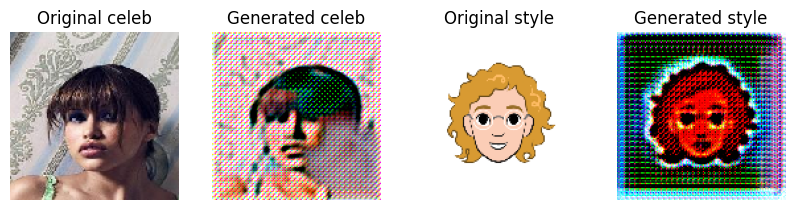

1/1 [==============================] - 0s 23ms/step


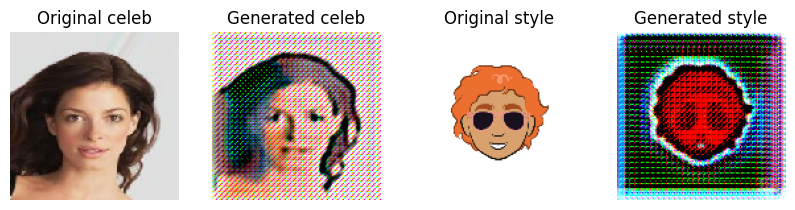

1/1 [==============================] - 0s 21ms/step


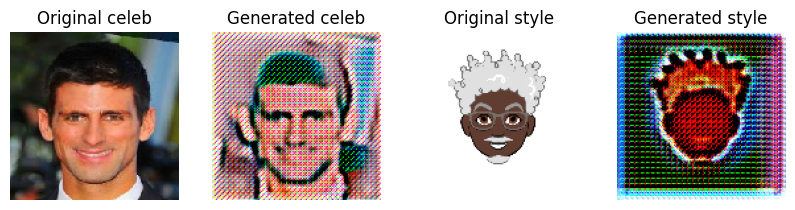

1/1 [==============================] - 0s 25ms/step


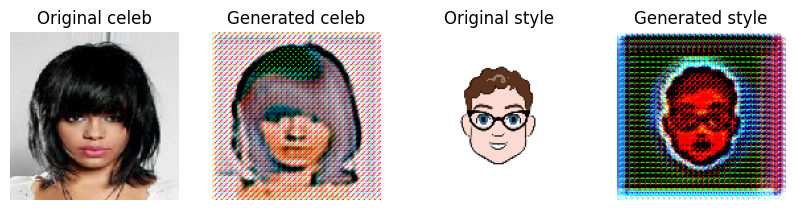

1/1 [==============================] - 0s 23ms/step


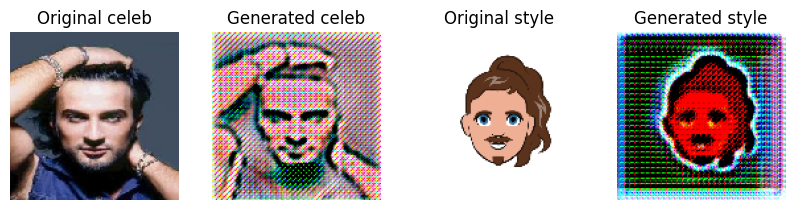

In [45]:
show_preds(CelebtoStyle_gen,StyletoCeleb_gen ,n_images=5)

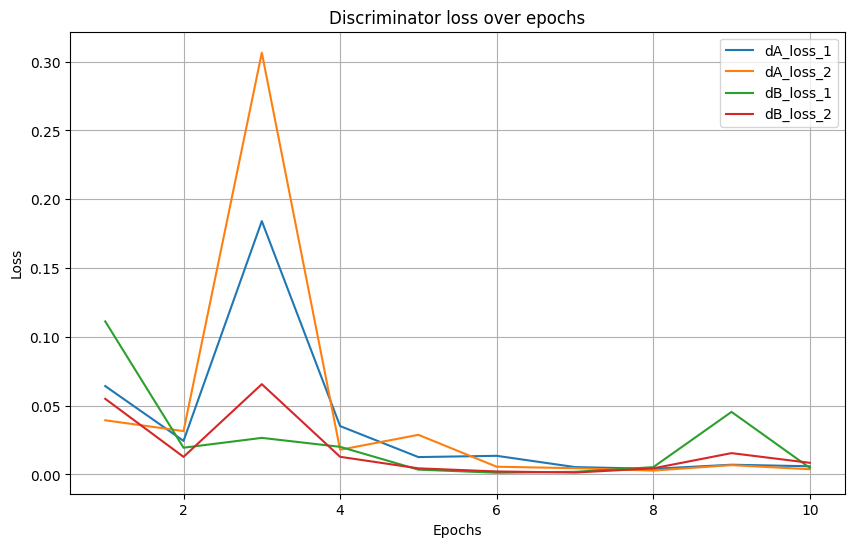

In [46]:
import matplotlib.pyplot as plt

# Extracting individual losses for plotting
dA_loss_1 = [epoch[0] for epoch in loss_history]
dA_loss_2 = [epoch[1] for epoch in loss_history]
dB_loss_1 = [epoch[2] for epoch in loss_history]
dB_loss_2 = [epoch[3] for epoch in loss_history]
gen_loss1 = [epoch[4] for epoch in loss_history]
gen_loss2 = [epoch[5] for epoch in loss_history]

epochs = range(1, len(loss_history) + 1)

# Plotting the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs, dA_loss_1, label='dA_loss_1')
plt.plot(epochs, dA_loss_2, label='dA_loss_2')
plt.plot(epochs, dB_loss_1, label='dB_loss_1')
plt.plot(epochs, dB_loss_2, label='dB_loss_2')

plt.title('Discriminator loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

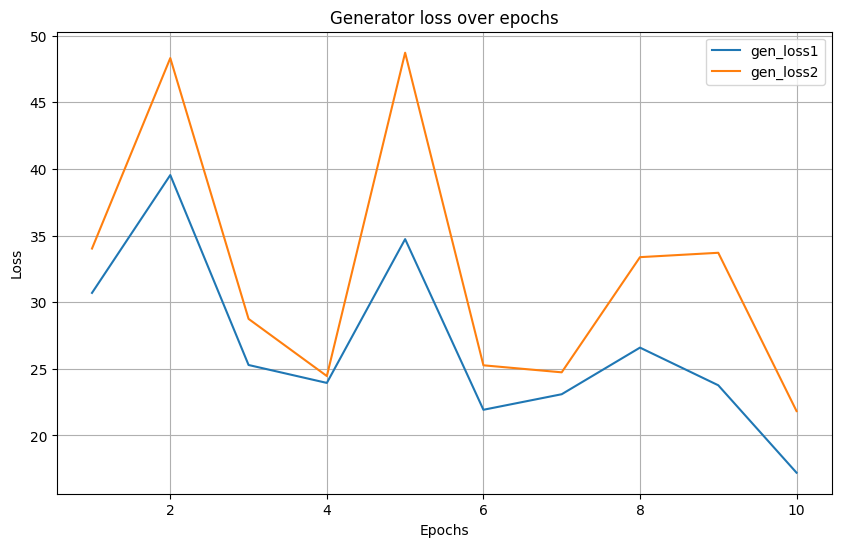

In [47]:
# Plotting the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs, gen_loss1, label='gen_loss1')
plt.plot(epochs, gen_loss2, label='gen_loss2')

plt.title('Generator loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()